## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch evaluate accelerate==0.27.2 dataset transformers scikit-learn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import ast

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.transforms as T
import torchvision.models as models

from datasets import load_dataset
from evaluate import load
from transformers import AutoModelForImageClassification, AutoImageProcessor, TrainingArguments, Trainer, pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

## Randomseed 고정

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data load & Preprocessing


In [ ]:
def scale_handler(x, scale_factor=0.25):
    if isinstance(x, str):
        x = ast.literal_eval(x)

    if x != 0:
        scaled_bbox = [int(coord * scale_factor) for coord in x]
        return scaled_bbox

    else:
        return 0

In [ ]:
# train df
master_df = pd.read_csv("/content/drive/MyDrive/2025-1 KUBIG/finetuning/master_df.csv", index_col=0)

folder_path = '/content/drive/MyDrive/2025-1 KUBIG/dataset/train/' # 경로 변경

master_df['img_path'] = master_df['img_filename'].apply(lambda x: folder_path + x + ".jpg")
master_df['merge_box'] = master_df['merge_box'].apply(lambda x : scale_handler(x))

master_df = master_df[master_df["merge_box"] !=0]
master_df = master_df[master_df["img_filename"] != "TRAIN_04810"]
# box 영역이 너무 작아 이미지 처리 불가능해진 데이터 제외

master_df.reset_index(inplace=True, drop=True)

master_df.head()

,img_path,upscale_img_path,label,img_filename,yolo_box,yolo_conf,unet_box,unet_conf,merge_box
0,/content/drive/MyDrive/2025-1 KUBIG/dataset/tr...,./upscale_train/TRAIN_00000.png,Ruddy Shelduck,TRAIN_00000,0,0.000000,"[3, 64, 188, 179]",0.985534,"[0, 16, 47, 44]"
1,/content/drive/MyDrive/2025-1 KUBIG/dataset/tr...,./upscale_train/TRAIN_00001.png,Gray Wagtail,TRAIN_00001,0,0.000000,"[93, 79, 147, 234]",0.951921,"[23, 19, 36, 58]"
2,/content/drive/MyDrive/2025-1 KUBIG/dataset/tr...,./upscale_train/TRAIN_00002.png,Indian Peacock,TRAIN_00002,0,0.000000,"[81, 53, 227, 239]",0.895013,"[20, 13, 56, 59]"
3,/content/drive/MyDrive/2025-1 KUBIG/dataset/tr...,./upscale_train/TRAIN_00003.png,Common Kingfisher,TRAIN_00003,"[2, 93, 92, 236]",0.255118,"[0, 61, 126, 244]",0.980908,"[0, 15, 31, 61]"
4,/content/drive/MyDrive/2025-1 KUBIG/dataset/tr...,./upscale_train/TRAIN_00004.png,Common Kingfisher,TRAIN_00004,"[0, 57, 106, 175]",0.487455,"[0, 37, 152, 190]",0.963232,"[0, 9, 38, 47]"


In [ ]:
k = list(master_df["merge_box"])[1]
kk = list(master_df["img_path"])[1]

array([[[177, 164, 156],
        [162, 150, 134],
        [147, 136, 106],
        ...,
        [ 92,  95,  52],
        [106, 107,  73],
        [118, 119,  88]],

       [[207, 198, 181],
        [192, 184, 161],
        [166, 160, 124],
        ...,
        [ 93,  95,  56],
        [104, 104,  76],
        [114, 114,  90]],

       [[199, 199, 163],
        [194, 195, 155],
        [167, 169, 120],
        ...,
        [118, 118,  90],
        [128, 127, 109],
        [133, 131, 118]],

       ...,

       [[102, 114,  64],
        [113, 125,  75],
        [110, 122,  74],
        ...,
        [113, 122,  75],
        [109, 119,  59],
        [ 94, 106,  40]],

       [[118, 126,  89],
        [128, 136,  97],
        [131, 140,  95],
        ...,
        [116, 125,  72],
        [116, 126,  57],
        [117, 130,  50]],

       [[135, 142, 111],
        [142, 149, 115],
        [149, 158, 113],
        ...,
        [123, 130,  76],
        [134, 145,  69],
        [158, 170,  84]]], dtype=uint8)
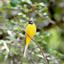

In [ ]:
image = cv2.cvtColor(cv2.imread(kk), cv2.COLOR_BGR2RGB)
image

In [ ]:
x_min, y_min, x_max, y_max = k
image = image[y_min:y_max, x_min:x_max]
image

array([[[102, 113, 105],
        [ 97, 110,  93],
        [111, 126,  97],
        ...,
        [163, 174, 158],
        [164, 174, 149],
        [158, 169, 129]],

       [[175, 186, 178],
        [137, 149, 139],
        [137, 150, 132],
        ...,
        [161, 167, 155],
        [149, 157, 134],
        [145, 153, 116]],

       [[181, 194, 176],
        [170, 183, 165],
        [142, 154, 132],
        ...,
        [143, 147, 133],
        [107, 110,  89],
        [105, 110,  78]],

       ...,

       [[173, 177, 144],
        [230, 233, 204],
        [190, 193, 166],
        ...,
        [130, 146, 101],
        [111, 127,  82],
        [132, 148, 103]],

       [[163, 167, 132],
        [204, 208, 175],
        [185, 190, 158],
        ...,
        [133, 148, 105],
        [122, 137,  94],
        [124, 137,  94]],

       [[156, 162, 124],
        [161, 167, 131],
        [164, 170, 136],
        ...,
        [119, 134,  93],
        [119, 131,  91],
        [122, 133,  93]]], dtype=uint8)

In [ ]:
'''

# 위 코드로 대체

# img path 수정
folder_path = '/content/drive/MyDrive/KUBIG/25_contest' # 경로 변경
train = pd.read_csv(f'{folder_path}/train.csv')
#test = pd.read_csv(f'{folder_path}/test.csv')

train['img_path'] = train['img_path'].apply(lambda x: folder_path + x[1:])
#test['img_path'] = test['img_path'].apply(lambda x: folder_path + x[1:])

'''

"\n\n# 위 코드로 대체\n\n# img path 수정\nfolder_path = '/content/drive/MyDrive/KUBIG/25_contest' # 경로 변경\ntrain = pd.read_csv(f'{folder_path}/train.csv')\n#test = pd.read_csv(f'{folder_path}/test.csv')\n\ntrain['img_path'] = train['img_path'].apply(lambda x: folder_path + x[1:])\n#test['img_path'] = test['img_path'].apply(lambda x: folder_path + x[1:])\n\n"

In [ ]:
# train-validation split
train_df, val_df = train_test_split(master_df, test_size=0.1, stratify=master_df['label'], random_state=SEED)

# Label Encoding
le = preprocessing.LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms, processor):
        self.df = df
        self.transforms = transforms
        self.processor = processor

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = row['img_path']
        label = row['label']

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        # --- 동헌 추가 부분 ~ #

        bbox = row['merge_box']

        if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)

        if (bbox != 0) and (bbox != "0"):
            x_min, y_min, x_max, y_max = bbox
            image = image[y_min:y_max, x_min:x_max]

        # ~ 동헌 추가 부분 --- #

        image = self.transforms(image=image)['image'] #augmentation

        inputs = self.processor(image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (1, C, H, W) -> (C, H, W)

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(int(label), dtype=torch.long)
        }

    def __len__(self):
        return len(self.df)

## Augmentation

In [ ]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    ToTensorV2(),
])

## Model - Swinv2

In [ ]:
model_name = "microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft"
processor = AutoImageProcessor.from_pretrained(model_name, do_normalize=False)

In [ ]:
# 데이터셋 생성
train_dataset = CustomDataset(train_df, train_transform, processor)
val_dataset = CustomDataset(val_df, train_transform, processor)

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/KUBIG/25_contest/results/swinv2_model", # 학습 결과 저장할 폴더 지정
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    gradient_accumulation_steps=2, # batch size를 증가시키는 효과
    #load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    bf16=True,
    learning_rate=5e-5,
    seed=SEED,
    report_to="none"
)

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=AutoModelForImageClassification.from_pretrained(
    model_name, num_labels=len(le.classes_), ignore_mismatched_sizes=True).to(device),
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([25, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([25]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

In [ ]:
from accelerate import Accelerator

# Accelerator 초기화
accelerator = Accelerator()

# distributed_type 속성 확인
if not hasattr(accelerator.state, "distributed_type"):
    accelerator.state.distributed_type = None  # 기본값 설정

In [ ]:
train_results = trainer.train()
print("✅ Training 완료!")

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss
1,0.547100,0.288864
2,0.187100,0.207701
3,0.117000,0.205697
4,0.070000,0.231782
5,0.032600,0.234692
6,0.018900,0.270820
7,0.012600,0.249981
8,0.003900,0.244608
9,0.003000,0.221764


✅ Training 완료!
***** train metrics *****
  epoch                    =        9.9547
  total_flos               = 28617969032GF
  train_loss               =        0.0998
  train_runtime            =    0:40:00.58
  train_samples_per_second =        55.828
  train_steps_per_second   =         0.871


In [ ]:
train_results

TrainOutput(global_step=2090, training_loss=0.09984872165764348, metrics={'train_runtime': 2400.5881, 'train_samples_per_second': 55.828, 'train_steps_per_second': 0.871, 'total_flos': 3.0728310268105064e+19, 'train_loss': 0.09984872165764348, 'epoch': 9.954653937947494})

In [ ]:
import cv2

def debug_image_loading(img_path, bbox):
    image = cv2.imread(img_path)

    if isinstance(bbox, str):
        bbox = ast.literal_eval(bbox)

    if (bbox != 0) and (bbox != "0"):
        x_min, y_min, x_max, y_max = bbox
        image = image[y_min:y_max, x_min:x_max]

    if image is None:
        print(f"❌ 이미지 로드 실패: {img_path}")
        return None

    if image.shape[0] == 0 or image.shape[1] == 0:
        print(f"❌ 빈 이미지 감지 (크기: {image.shape}): {img_path}")
        return None

    return image

for idx, row in master_df.iterrows():
    img_path = row['img_path']
    bbox = row['merge_box']

    image = debug_image_loading(img_path, bbox)

    if image is None:
        print(f"🚨 문제 발생한 데이터: Index {idx}, 파일명 {img_path}")


❌ 빈 이미지 감지 (크기: (1, 0, 3)): /content/drive/MyDrive/2025-1 KUBIG/dataset/train/TRAIN_04810.jpg
🚨 문제 발생한 데이터: Index 4529, 파일명 /content/drive/MyDrive/2025-1 KUBIG/dataset/train/TRAIN_04810.jpg


In [ ]:
master_df[master_df["img_filename"] == "TRAIN_04810"]

# 오,,, 탐지가 너무 작은 영역에서 일어나서 그렇구나,,

,img_path,upscale_img_path,label,img_filename,yolo_box,yolo_conf,unet_box,unet_conf,merge_box
4529,/content/drive/MyDrive/2025-1 KUBIG/dataset/tr...,./upscale_train/TRAIN_04810.png,Asian Green Bee-Eater,TRAIN_04810,"[184, 223, 186, 226]",0.340621,0,0.0,"[46, 55, 46, 56]"


## Inference

In [ ]:
# 학습된 모델 로드
epoch_checkpoint = "/content/drive/MyDrive/KUBIG/25_contest/results/swinv2_model/checkpoint-2090" # 최적 학습 모델으로 변경
model = AutoModelForImageClassification.from_pretrained(epoch_checkpoint).to(device)

In [ ]:
processor = AutoImageProcessor.from_pretrained(model_name, return_tensors="pt")

### YOLO Model 로 test data 처리

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 15.8 MB/s eta 0:00:00


In [ ]:
import ast
from ultralytics import YOLO

# 모델 불러오기
yolo_model = YOLO("/content/drive/MyDrive/2025-1 KUBIG/finetuning/best.pt")  # 학습된 모델 불러오기

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# finetuning 된 모델로 새 탐지하는 function
def detect_bird(image_path, model):
    results = model(image_path)
    # result = model(image_path, imgsz=1024) -- input image resizing

    highest_confidence = 0
    best_box = None
    is_detected = True

    for result in results:
        for box in result.boxes:
            conf = float(box.conf[0])

            if conf > highest_confidence:  # 'bird' class ID == 14
                highest_confidence = conf
                best_box = [int(x) for x in box.xyxy[0]]

    if best_box:
        return best_box, highest_confidence, is_detected
    else:
        return 0, 0, False

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/2025-1 KUBIG/dataset/test.csv")
test_path = '/content/drive/MyDrive/2025-1 KUBIG/dataset/test/' # 경로 변경

def get_img_name(x):
    x = x.split("/")
    x = x[-1]
    return x

test_df["img_name"] = test_df["img_path"].apply(lambda x : get_img_name(x))
test_df["img_path"] = test_df["img_name"].apply(lambda x : test_path + x)

test_df.head()

,id,img_path,img_name
0,TEST_00000,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,TEST_00000.jpg
1,TEST_00001,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,TEST_00001.jpg
2,TEST_00002,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,TEST_00002.jpg
3,TEST_00003,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,TEST_00003.jpg
4,TEST_00004,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,TEST_00004.jpg


In [ ]:
test_df["finetuned_box"] = None
test_df["finetuned_conf"] = None
test_df["finetuned_box"] = test_df["finetuned_box"].astype(object)

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    best_box, highest_confidence, is_detected = detect_bird(row["img_path"], yolo_model)
    if is_detected:
        test_df.at[idx, "finetuned_box"] = best_box
        test_df.at[idx, "finetuned_conf"] = highest_confidence

  0%|          | 0/6786 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00000.jpg: 64x64 1 bird, 10.5ms
Speed: 4.4ms preprocess, 10.5ms inference, 137.6ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 1/6786 [00:01<2:44:11,  1.45s/it]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00001.jpg: 64x64 1 bird, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 2/6786 [00:01<1:21:31,  1.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00002.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 3/6786 [00:01<54:48,  2.06it/s]  


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00003.jpg: 64x64 1 bird, 15.0ms
Speed: 0.6ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 4/6786 [00:02<47:23,  2.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00004.jpg: 64x64 (no detections), 16.0ms
Speed: 0.6ms preprocess, 16.0ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 5/6786 [00:02<38:51,  2.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00005.jpg: 64x64 1 bird, 15.5ms
Speed: 0.6ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 6/6786 [00:02<41:27,  2.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00006.jpg: 64x64 1 bird, 15.4ms
Speed: 0.6ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 7/6786 [00:03<36:41,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00007.jpg: 64x64 1 bird, 15.2ms
Speed: 0.6ms preprocess, 15.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 8/6786 [00:03<32:34,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00008.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 9/6786 [00:03<29:49,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00009.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 10/6786 [00:03<36:55,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00010.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 11/6786 [00:04<32:58,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00011.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 12/6786 [00:04<30:30,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00012.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 13/6786 [00:04<35:34,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00013.jpg: 64x64 2 birds, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 14/6786 [00:05<37:43,  2.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00014.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 15/6786 [00:05<32:04,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00015.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 16/6786 [00:05<29:14,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00016.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 17/6786 [00:05<27:10,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00017.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 18/6786 [00:06<32:34,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00018.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 19/6786 [00:06<30:20,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00019.jpg: 64x64 2 birds, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 20/6786 [00:06<28:35,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00020.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 21/6786 [00:06<27:04,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00021.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 22/6786 [00:07<32:24,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00022.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 23/6786 [00:07<29:53,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00023.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 24/6786 [00:07<27:23,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00024.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 25/6786 [00:07<30:45,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00025.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 26/6786 [00:08<34:12,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00026.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 27/6786 [00:08<36:34,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00027.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 28/6786 [00:08<31:12,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00028.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 29/6786 [00:09<29:00,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00029.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 30/6786 [00:09<27:15,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00030.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 31/6786 [00:09<26:49,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00031.jpg: 64x64 2 birds, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 32/6786 [00:09<28:44,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00032.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  0%|          | 33/6786 [00:09<27:02,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00033.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 34/6786 [00:10<25:23,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00034.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 35/6786 [00:10<25:23,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00035.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 36/6786 [00:10<33:00,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00036.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 37/6786 [00:11<36:51,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00037.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 38/6786 [00:11<40:14,  2.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00038.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 39/6786 [00:11<34:37,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00039.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 40/6786 [00:12<37:33,  2.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00040.jpg: 64x64 1 bird, 11.8ms
Speed: 0.6ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 41/6786 [00:12<33:17,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00041.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 42/6786 [00:12<36:48,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00042.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 43/6786 [00:13<39:20,  2.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00043.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 44/6786 [00:13<40:47,  2.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00044.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 45/6786 [00:13<34:47,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00045.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 46/6786 [00:14<38:12,  2.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00046.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 47/6786 [00:14<32:38,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00047.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 48/6786 [00:14<29:24,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00048.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 49/6786 [00:14<26:57,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00049.jpg: 64x64 1 bird, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 50/6786 [00:15<31:49,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00050.jpg: 64x64 1 bird, 15.4ms
Speed: 0.6ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 51/6786 [00:15<29:07,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00051.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 52/6786 [00:15<27:15,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00052.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 53/6786 [00:15<25:57,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00053.jpg: 64x64 1 bird, 11.6ms
Speed: 0.8ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 54/6786 [00:16<30:56,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00054.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 55/6786 [00:16<34:31,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00055.jpg: 64x64 1 bird, 17.0ms
Speed: 0.6ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 56/6786 [00:17<38:03,  2.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00056.jpg: 64x64 1 bird, 16.6ms
Speed: 0.4ms preprocess, 16.6ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 57/6786 [00:17<33:23,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00057.jpg: 64x64 1 bird, 16.1ms
Speed: 0.5ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 58/6786 [00:17<29:04,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00058.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 59/6786 [00:17<26:29,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00059.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 60/6786 [00:17<24:06,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00060.jpg: 64x64 1 bird, 16.2ms
Speed: 0.6ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 61/6786 [00:18<31:35,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00061.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 62/6786 [00:18<32:12,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00062.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 63/6786 [00:18<28:27,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00063.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 64/6786 [00:18<26:05,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00064.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 65/6786 [00:18<23:35,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00065.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 66/6786 [00:19<29:08,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00066.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 67/6786 [00:19<27:15,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00067.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 68/6786 [00:19<31:18,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00068.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 69/6786 [00:20<33:22,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00069.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 70/6786 [00:20<30:09,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00070.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 71/6786 [00:20<27:34,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00071.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 72/6786 [00:20<25:31,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00072.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 73/6786 [00:21<24:12,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00073.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 74/6786 [00:21<24:13,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00074.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 75/6786 [00:21<22:37,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00075.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 76/6786 [00:21<23:04,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00076.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 77/6786 [00:21<25:49,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00077.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 78/6786 [00:22<27:45,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00078.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 79/6786 [00:22<29:03,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00079.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 80/6786 [00:22<33:20,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00080.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 81/6786 [00:23<42:08,  2.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00081.jpg: 64x64 1 bird, 19.8ms
Speed: 0.6ms preprocess, 19.8ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 82/6786 [00:23<42:57,  2.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00082.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 83/6786 [00:24<45:09,  2.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00083.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|          | 84/6786 [00:24<38:57,  2.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00084.jpg: 64x64 2 birds, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 85/6786 [00:24<33:54,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00085.jpg: 64x64 1 bird, 15.8ms
Speed: 0.6ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 86/6786 [00:24<30:17,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00086.jpg: 64x64 1 bird, 15.4ms
Speed: 0.6ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 87/6786 [00:25<27:10,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00087.jpg: 64x64 1 bird, 15.4ms
Speed: 0.6ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 88/6786 [00:25<25:36,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00088.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 89/6786 [00:25<30:09,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00089.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 90/6786 [00:26<35:29,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00090.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 91/6786 [00:26<34:06,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00091.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 92/6786 [00:26<30:01,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00092.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 93/6786 [00:26<26:59,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00093.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 94/6786 [00:27<32:52,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00094.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 95/6786 [00:27<32:05,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00095.jpg: 64x64 1 bird, 11.9ms
Speed: 0.6ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 96/6786 [00:27<35:36,  3.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00096.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 97/6786 [00:28<31:31,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00097.jpg: 64x64 1 bird, 12.7ms
Speed: 0.6ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 98/6786 [00:28<35:59,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00098.jpg: 64x64 1 bird, 17.5ms
Speed: 0.6ms preprocess, 17.5ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 99/6786 [00:28<38:34,  2.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00099.jpg: 64x64 2 birds, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 100/6786 [00:28<32:30,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00100.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  1%|▏         | 101/6786 [00:29<28:00,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00101.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 102/6786 [00:29<31:20,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00102.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 103/6786 [00:29<29:04,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00103.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 104/6786 [00:29<29:03,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00104.jpg: 64x64 1 bird, 17.1ms
Speed: 0.6ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 105/6786 [00:30<30:27,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00105.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 106/6786 [00:30<27:32,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00106.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 107/6786 [00:30<27:28,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00107.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 108/6786 [00:30<26:07,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00108.jpg: 64x64 (no detections), 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 109/6786 [00:31<24:50,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00109.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 110/6786 [00:31<23:17,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00110.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 111/6786 [00:31<21:02,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00111.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 112/6786 [00:31<21:03,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00112.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 113/6786 [00:31<21:04,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00113.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 114/6786 [00:32<23:06,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00114.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 115/6786 [00:32<23:30,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00115.jpg: 64x64 (no detections), 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 116/6786 [00:32<23:20,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00116.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 117/6786 [00:32<22:47,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00117.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 118/6786 [00:33<29:36,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00118.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 119/6786 [00:33<26:10,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00119.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 120/6786 [00:33<24:01,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00120.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 121/6786 [00:33<21:19,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00121.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 122/6786 [00:33<21:09,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00122.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 123/6786 [00:33<20:57,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00123.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 124/6786 [00:34<21:07,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00124.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 125/6786 [00:34<20:31,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00125.jpg: 64x64 1 bird, 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 126/6786 [00:34<19:37,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00126.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 127/6786 [00:34<18:41,  5.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00127.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 128/6786 [00:34<25:45,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00128.jpg: 64x64 2 birds, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 129/6786 [00:35<24:26,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00129.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 130/6786 [00:35<23:13,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00130.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 131/6786 [00:35<23:06,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00131.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 132/6786 [00:35<22:08,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00132.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 133/6786 [00:35<23:12,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00133.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 134/6786 [00:36<22:53,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00134.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 135/6786 [00:36<21:27,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00135.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 136/6786 [00:36<26:35,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00136.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 137/6786 [00:36<24:34,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00137.jpg: 64x64 1 bird, 14.5ms
Speed: 0.4ms preprocess, 14.5ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 138/6786 [00:37<24:55,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00138.jpg: 64x64 1 bird, 19.6ms
Speed: 0.5ms preprocess, 19.6ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 139/6786 [00:37<23:47,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00139.jpg: 64x64 1 bird, 18.8ms
Speed: 0.9ms preprocess, 18.8ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 140/6786 [00:37<29:46,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00140.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 141/6786 [00:38<33:23,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00141.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 142/6786 [00:38<33:08,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00142.jpg: 64x64 (no detections), 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 143/6786 [00:38<28:57,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00143.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 144/6786 [00:38<25:31,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00144.jpg: 64x64 1 bird, 19.2ms
Speed: 0.6ms preprocess, 19.2ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 145/6786 [00:38<23:46,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00145.jpg: 64x64 1 bird, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 146/6786 [00:39<23:28,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00146.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 147/6786 [00:39<21:58,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00147.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 148/6786 [00:39<23:31,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00148.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 149/6786 [00:39<21:48,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00149.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 150/6786 [00:39<20:24,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00150.jpg: 64x64 1 bird, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 151/6786 [00:40<28:25,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00151.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 152/6786 [00:40<32:46,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00152.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 153/6786 [00:40<28:14,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00153.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 154/6786 [00:40<24:59,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00154.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 155/6786 [00:41<23:03,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00155.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 156/6786 [00:41<22:14,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00156.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 157/6786 [00:41<23:38,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00157.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 158/6786 [00:41<25:39,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00158.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 159/6786 [00:42<27:33,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00159.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 160/6786 [00:42<26:28,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00160.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 161/6786 [00:42<25:14,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00161.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 162/6786 [00:42<27:20,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00162.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 163/6786 [00:43<28:39,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00163.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 164/6786 [00:43<25:14,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00164.jpg: 64x64 1 bird, 19.5ms
Speed: 0.5ms preprocess, 19.5ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 165/6786 [00:43<24:23,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00165.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 166/6786 [00:43<30:23,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00166.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 167/6786 [00:44<26:51,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00167.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 168/6786 [00:44<25:49,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00168.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  2%|▏         | 169/6786 [00:44<24:37,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00169.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 170/6786 [00:44<23:13,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00170.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 171/6786 [00:44<22:45,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00171.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 172/6786 [00:45<22:27,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00172.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 173/6786 [00:45<21:45,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00173.jpg: 64x64 1 bird, 18.1ms
Speed: 0.6ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 174/6786 [00:45<30:59,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00174.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 175/6786 [00:45<28:41,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00175.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 176/6786 [00:46<27:06,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00176.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 177/6786 [00:46<25:09,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00177.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 178/6786 [00:46<22:04,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00178.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 179/6786 [00:46<21:42,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00179.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 180/6786 [00:47<29:57,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00180.jpg: 64x64 1 bird, 13.0ms
Speed: 0.6ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 181/6786 [00:47<26:20,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00181.jpg: 64x64 2 birds, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 182/6786 [00:47<23:54,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00182.jpg: 64x64 1 bird, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 183/6786 [00:47<30:15,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00183.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 184/6786 [00:47<27:01,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00184.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 185/6786 [00:48<25:32,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00185.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 186/6786 [00:48<31:27,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00186.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 187/6786 [00:48<29:29,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00187.jpg: 64x64 1 bird, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 188/6786 [00:49<26:58,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00188.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 189/6786 [00:49<25:01,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00189.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 190/6786 [00:49<31:15,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00190.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 191/6786 [00:49<33:49,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00191.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 192/6786 [00:50<31:26,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00192.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 193/6786 [00:50<27:44,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00193.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 194/6786 [00:50<26:38,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00194.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 195/6786 [00:50<25:16,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00195.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 196/6786 [00:50<23:33,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00196.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 197/6786 [00:51<30:24,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00197.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 198/6786 [00:51<37:04,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00198.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 199/6786 [00:52<38:29,  2.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00199.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 200/6786 [00:52<39:02,  2.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00200.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 201/6786 [00:52<33:12,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00201.jpg: 64x64 2 birds, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 202/6786 [00:53<35:24,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00202.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 203/6786 [00:53<30:36,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00203.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 204/6786 [00:53<27:15,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00204.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 205/6786 [00:53<24:21,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00205.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 206/6786 [00:53<26:00,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00206.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 207/6786 [00:54<31:09,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00207.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 208/6786 [00:54<28:06,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00208.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 209/6786 [00:54<25:17,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00209.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 210/6786 [00:54<26:36,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00210.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 211/6786 [00:55<26:23,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00211.jpg: 64x64 2 birds, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 212/6786 [00:55<25:48,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00212.jpg: 64x64 2 birds, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 213/6786 [00:55<26:00,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00213.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 214/6786 [00:55<24:59,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00214.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 215/6786 [00:56<27:54,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00215.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 216/6786 [00:56<24:26,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00216.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 217/6786 [00:56<30:10,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00217.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 218/6786 [00:56<26:22,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00218.jpg: 64x64 2 birds, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 219/6786 [00:57<31:38,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00219.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 220/6786 [00:57<27:07,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00220.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 221/6786 [00:57<28:55,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00221.jpg: 64x64 2 birds, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 222/6786 [00:57<27:04,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00222.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 223/6786 [00:58<31:50,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00223.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 224/6786 [00:58<29:28,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00224.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 225/6786 [00:58<26:22,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00225.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 226/6786 [00:58<23:44,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00226.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 227/6786 [00:59<22:19,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00227.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 228/6786 [00:59<20:50,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00228.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 229/6786 [00:59<19:35,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00229.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 230/6786 [00:59<19:09,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00230.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 231/6786 [00:59<22:13,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00231.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 232/6786 [01:00<21:07,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00232.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 233/6786 [01:00<23:28,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00233.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 234/6786 [01:00<23:23,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00234.jpg: 64x64 1 bird, 9.6ms
Speed: 0.9ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 235/6786 [01:00<22:04,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00235.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 236/6786 [01:01<28:58,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00236.jpg: 64x64 1 bird, 12.0ms
Speed: 0.3ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  3%|▎         | 237/6786 [01:01<25:19,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00237.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 238/6786 [01:01<24:33,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00238.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 239/6786 [01:01<24:13,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00239.jpg: 64x64 (no detections), 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 240/6786 [01:01<22:06,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00240.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 241/6786 [01:02<22:40,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00241.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 242/6786 [01:02<24:57,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00242.jpg: 64x64 2 birds, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 243/6786 [01:02<23:51,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00243.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 244/6786 [01:02<21:48,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00244.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 245/6786 [01:02<21:42,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00245.jpg: 64x64 1 bird, 9.8ms
Speed: 0.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 246/6786 [01:03<24:12,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00246.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 247/6786 [01:03<22:19,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00247.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 248/6786 [01:03<20:55,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00248.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 249/6786 [01:03<20:06,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00249.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 250/6786 [01:03<19:52,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00250.jpg: 64x64 2 birds, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 251/6786 [01:03<19:29,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00251.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 252/6786 [01:04<19:37,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00252.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 253/6786 [01:04<19:44,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00253.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▎         | 254/6786 [01:04<19:01,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00254.jpg: 64x64 (no detections), 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 255/6786 [01:04<24:48,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00255.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 256/6786 [01:05<24:16,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00256.jpg: 64x64 1 bird, 11.2ms
Speed: 0.8ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 257/6786 [01:05<30:33,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00257.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 258/6786 [01:05<27:49,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00258.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 259/6786 [01:05<27:15,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00259.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 260/6786 [01:06<32:51,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00260.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 261/6786 [01:06<28:21,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00261.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 262/6786 [01:06<28:40,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00262.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 263/6786 [01:06<26:18,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00263.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 264/6786 [01:07<24:27,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00264.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 265/6786 [01:07<25:23,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00265.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 266/6786 [01:07<23:17,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00266.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 267/6786 [01:07<27:49,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00267.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 268/6786 [01:08<34:30,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00268.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 269/6786 [01:08<30:08,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00269.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 270/6786 [01:08<33:26,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00270.jpg: 64x64 (no detections), 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 271/6786 [01:09<29:46,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00271.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 272/6786 [01:09<26:34,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00272.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 273/6786 [01:09<31:14,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00273.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 274/6786 [01:09<28:53,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00274.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 275/6786 [01:10<24:28,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00275.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 276/6786 [01:10<23:37,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00276.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 277/6786 [01:10<22:39,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00277.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 278/6786 [01:10<22:07,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00278.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 279/6786 [01:11<28:00,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00279.jpg: 64x64 1 bird, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 280/6786 [01:11<32:37,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00280.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 281/6786 [01:11<27:33,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00281.jpg: 64x64 1 bird, 9.7ms
Speed: 0.9ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 282/6786 [01:11<25:52,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00282.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 283/6786 [01:11<23:59,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00283.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 284/6786 [01:12<22:20,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00284.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 285/6786 [01:12<21:46,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00285.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 286/6786 [01:12<27:22,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00286.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 287/6786 [01:12<24:23,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00287.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 288/6786 [01:13<24:09,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00288.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 289/6786 [01:13<28:14,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00289.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 290/6786 [01:13<27:28,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00290.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 291/6786 [01:13<26:55,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00291.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 292/6786 [01:14<31:13,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00292.jpg: 64x64 (no detections), 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 293/6786 [01:14<33:20,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00293.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 294/6786 [01:15<35:14,  3.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00294.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 295/6786 [01:15<37:10,  2.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00295.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 296/6786 [01:15<35:07,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00296.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 297/6786 [01:15<30:01,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00297.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 298/6786 [01:16<33:35,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00298.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 299/6786 [01:16<28:56,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00299.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 300/6786 [01:16<27:33,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00300.jpg: 64x64 (no detections), 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 301/6786 [01:16<25:05,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00301.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 302/6786 [01:17<27:06,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00302.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 303/6786 [01:17<24:48,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00303.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 304/6786 [01:17<29:46,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00304.jpg: 64x64 (no detections), 11.9ms
Speed: 0.6ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  4%|▍         | 305/6786 [01:18<32:54,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00305.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 306/6786 [01:18<27:54,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00306.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 307/6786 [01:18<26:03,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00307.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 308/6786 [01:18<27:54,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00308.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 309/6786 [01:18<24:46,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00309.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 310/6786 [01:19<23:28,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00310.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 311/6786 [01:19<22:09,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00311.jpg: 64x64 (no detections), 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 312/6786 [01:19<28:22,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00312.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 313/6786 [01:19<25:24,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00313.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 314/6786 [01:20<25:45,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00314.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 315/6786 [01:20<24:14,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00315.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 316/6786 [01:20<26:15,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00316.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 317/6786 [01:20<23:48,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00317.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 318/6786 [01:20<24:05,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00318.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 319/6786 [01:21<21:21,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00319.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 320/6786 [01:21<20:05,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00320.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 321/6786 [01:21<27:33,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00321.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 322/6786 [01:21<25:26,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00322.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 323/6786 [01:21<23:41,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00323.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 324/6786 [01:22<22:39,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00324.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 325/6786 [01:22<22:02,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00325.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 326/6786 [01:22<23:18,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00326.jpg: 64x64 (no detections), 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 327/6786 [01:22<21:49,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00327.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 328/6786 [01:22<21:47,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00328.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 329/6786 [01:23<20:57,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00329.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 330/6786 [01:23<19:05,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00330.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 331/6786 [01:23<18:53,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00331.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 332/6786 [01:23<18:20,  5.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00332.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 333/6786 [01:23<19:42,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00333.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 334/6786 [01:24<19:08,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00334.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 335/6786 [01:24<28:39,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00335.jpg: 64x64 3 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 336/6786 [01:24<31:31,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00336.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 337/6786 [01:25<28:33,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00337.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 338/6786 [01:25<34:42,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00338.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▍         | 339/6786 [01:25<29:49,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00339.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 340/6786 [01:25<26:36,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00340.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 341/6786 [01:26<24:45,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00341.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 342/6786 [01:26<25:47,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00342.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 343/6786 [01:26<23:33,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00343.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 344/6786 [01:26<23:54,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00344.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 345/6786 [01:26<23:06,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00345.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 346/6786 [01:27<21:08,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00346.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 347/6786 [01:27<24:37,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00347.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 348/6786 [01:27<26:22,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00348.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 349/6786 [01:27<25:09,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00349.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 350/6786 [01:28<23:31,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00350.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 351/6786 [01:28<29:31,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00351.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 352/6786 [01:28<25:31,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00352.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 353/6786 [01:28<23:23,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00353.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 354/6786 [01:28<23:09,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00354.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 355/6786 [01:29<21:05,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00355.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 356/6786 [01:29<20:11,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00356.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 357/6786 [01:29<21:34,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00357.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 358/6786 [01:29<20:37,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00358.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 359/6786 [01:29<20:01,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00359.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 360/6786 [01:30<21:18,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00360.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 361/6786 [01:30<20:07,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00361.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 362/6786 [01:30<18:46,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00362.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 363/6786 [01:30<22:50,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00363.jpg: 64x64 (no detections), 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 364/6786 [01:30<20:51,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00364.jpg: 64x64 (no detections), 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 365/6786 [01:31<19:51,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00365.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 366/6786 [01:31<19:10,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00366.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 367/6786 [01:31<23:52,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00367.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 368/6786 [01:31<22:26,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00368.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 369/6786 [01:31<20:51,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00369.jpg: 64x64 2 birds, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 370/6786 [01:32<19:37,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00370.jpg: 64x64 1 bird, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 371/6786 [01:32<26:24,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00371.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 372/6786 [01:32<31:34,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00372.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  5%|▌         | 373/6786 [01:33<33:57,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00373.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 374/6786 [01:33<30:44,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00374.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 375/6786 [01:33<32:52,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00375.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 376/6786 [01:34<31:11,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00376.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 377/6786 [01:34<34:10,  3.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00377.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 378/6786 [01:34<36:23,  2.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00378.jpg: 64x64 (no detections), 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 379/6786 [01:35<34:55,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00379.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 380/6786 [01:35<34:25,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00380.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 381/6786 [01:35<29:40,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00381.jpg: 64x64 1 bird, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 382/6786 [01:35<26:54,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00382.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 383/6786 [01:36<31:38,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00383.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 384/6786 [01:36<27:45,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00384.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 385/6786 [01:36<23:25,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00385.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 386/6786 [01:36<21:22,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00386.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 387/6786 [01:36<24:09,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00387.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 388/6786 [01:37<22:42,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00388.jpg: 64x64 1 bird, 11.3ms
Speed: 0.6ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 389/6786 [01:37<20:58,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00389.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 390/6786 [01:37<21:00,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00390.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 391/6786 [01:37<21:05,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00391.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 392/6786 [01:37<21:42,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00392.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 393/6786 [01:38<20:46,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00393.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 394/6786 [01:38<19:50,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00394.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 395/6786 [01:38<19:40,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00395.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 396/6786 [01:38<20:23,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00396.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 397/6786 [01:38<23:55,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00397.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 398/6786 [01:39<29:58,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00398.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 399/6786 [01:39<27:16,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00399.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 400/6786 [01:39<25:03,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00400.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 401/6786 [01:39<26:10,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00401.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 402/6786 [01:40<24:25,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00402.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 403/6786 [01:40<22:11,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00403.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 404/6786 [01:40<21:17,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00404.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 405/6786 [01:40<23:02,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00405.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 406/6786 [01:40<21:38,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00406.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 407/6786 [01:41<21:02,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00407.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 408/6786 [01:41<28:41,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00408.jpg: 64x64 1 bird, 18.6ms
Speed: 0.6ms preprocess, 18.6ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 409/6786 [01:41<32:18,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00409.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 410/6786 [01:42<30:22,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00410.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 411/6786 [01:42<32:13,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00411.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 412/6786 [01:42<28:01,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00412.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 413/6786 [01:42<26:07,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00413.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 414/6786 [01:43<24:20,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00414.jpg: 64x64 1 bird, 12.0ms
Speed: 0.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 415/6786 [01:43<22:28,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00415.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 416/6786 [01:43<22:13,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00416.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 417/6786 [01:43<22:04,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00417.jpg: 64x64 1 bird, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 418/6786 [01:43<21:14,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00418.jpg: 64x64 (no detections), 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 419/6786 [01:44<22:20,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00419.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 420/6786 [01:44<21:05,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00420.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 421/6786 [01:44<21:13,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00421.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 422/6786 [01:44<20:29,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00422.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 423/6786 [01:44<19:52,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00423.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▌         | 424/6786 [01:45<26:57,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00424.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 425/6786 [01:45<24:59,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00425.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 426/6786 [01:45<28:25,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00426.jpg: 64x64 (no detections), 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 427/6786 [01:46<32:28,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00427.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 428/6786 [01:46<28:48,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00428.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 429/6786 [01:46<32:22,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00429.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 430/6786 [01:46<27:49,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00430.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 431/6786 [01:47<32:29,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00431.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 432/6786 [01:47<27:14,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00432.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 433/6786 [01:47<24:56,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00433.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 434/6786 [01:47<26:27,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00434.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 435/6786 [01:48<23:10,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00435.jpg: 64x64 1 bird, 10.9ms
Speed: 0.9ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 436/6786 [01:48<22:31,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00436.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 437/6786 [01:48<24:07,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00437.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 438/6786 [01:48<23:44,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00438.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 439/6786 [01:48<22:27,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00439.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 440/6786 [01:49<21:02,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00440.jpg: 64x64 1 bird, 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  6%|▋         | 441/6786 [01:49<19:49,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00441.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 442/6786 [01:49<18:35,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00442.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 443/6786 [01:49<19:32,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00443.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 444/6786 [01:49<20:52,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00444.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 445/6786 [01:49<20:15,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00445.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 446/6786 [01:50<19:07,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00446.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 447/6786 [01:50<26:04,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00447.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 448/6786 [01:50<23:52,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00448.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 449/6786 [01:51<29:06,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00449.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 450/6786 [01:51<32:34,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00450.jpg: 64x64 (no detections), 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 451/6786 [01:51<34:28,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00451.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 452/6786 [01:52<37:29,  2.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00452.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 453/6786 [01:52<34:46,  3.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00453.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 454/6786 [01:52<29:05,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00454.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 455/6786 [01:52<26:13,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00455.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 456/6786 [01:53<23:45,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00456.jpg: 64x64 1 bird, 16.4ms
Speed: 0.5ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 457/6786 [01:53<26:09,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00457.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 458/6786 [01:53<24:16,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00458.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 459/6786 [01:53<24:43,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00459.jpg: 64x64 1 bird, 11.3ms
Speed: 0.7ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 460/6786 [01:54<31:37,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00460.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 461/6786 [01:54<30:29,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00461.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 462/6786 [01:54<34:46,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00462.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 463/6786 [01:55<31:03,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00463.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 464/6786 [01:55<27:27,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00464.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 465/6786 [01:55<26:06,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00465.jpg: 64x64 1 bird, 9.7ms
Speed: 1.0ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 466/6786 [01:55<23:40,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00466.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 467/6786 [01:56<29:32,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00467.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 468/6786 [01:56<33:23,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00468.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 469/6786 [01:56<35:17,  2.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00469.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 470/6786 [01:57<30:59,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00470.jpg: 64x64 1 bird, 9.7ms
Speed: 0.9ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 471/6786 [01:57<27:22,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00471.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 472/6786 [01:57<25:49,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00472.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 473/6786 [01:57<24:08,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00473.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 474/6786 [01:57<22:30,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00474.jpg: 64x64 3 birds, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 475/6786 [01:58<27:31,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00475.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 476/6786 [01:58<29:03,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00476.jpg: 64x64 2 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 477/6786 [01:58<28:06,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00477.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 478/6786 [01:59<29:04,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00478.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 479/6786 [01:59<26:31,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00479.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 480/6786 [01:59<24:46,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00480.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 481/6786 [01:59<22:38,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00481.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 482/6786 [02:00<28:56,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00482.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 483/6786 [02:00<26:09,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00483.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 484/6786 [02:00<23:25,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00484.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 485/6786 [02:00<21:47,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00485.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 486/6786 [02:00<21:08,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00486.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 487/6786 [02:00<19:54,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00487.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 488/6786 [02:01<20:57,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00488.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 489/6786 [02:01<21:07,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00489.jpg: 64x64 1 bird, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 490/6786 [02:01<19:55,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00490.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 491/6786 [02:01<21:20,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00491.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 492/6786 [02:01<19:56,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00492.jpg: 64x64 1 bird, 18.6ms
Speed: 0.5ms preprocess, 18.6ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 493/6786 [02:02<26:03,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00493.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 494/6786 [02:02<25:31,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00494.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 495/6786 [02:02<22:27,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00495.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 496/6786 [02:02<20:56,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00496.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 497/6786 [02:03<21:35,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00497.jpg: 64x64 2 birds, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 498/6786 [02:03<30:35,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00498.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 499/6786 [02:03<28:45,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00499.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 500/6786 [02:03<25:05,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00500.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 501/6786 [02:04<24:18,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00501.jpg: 64x64 1 bird, 13.1ms
Speed: 0.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 502/6786 [02:04<25:37,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00502.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 503/6786 [02:04<23:46,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00503.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 504/6786 [02:05<28:21,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00504.jpg: 64x64 1 bird, 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 505/6786 [02:05<27:14,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00505.jpg: 64x64 1 bird, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 506/6786 [02:05<25:43,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00506.jpg: 64x64 2 birds, 15.6ms
Speed: 0.4ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 507/6786 [02:05<27:10,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00507.jpg: 64x64 1 bird, 15.8ms
Speed: 0.5ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  7%|▋         | 508/6786 [02:05<25:50,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00508.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 509/6786 [02:06<23:16,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00509.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 510/6786 [02:06<21:46,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00510.jpg: 64x64 1 bird, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 511/6786 [02:06<21:48,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00511.jpg: 64x64 1 bird, 16.2ms
Speed: 0.6ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 512/6786 [02:06<30:15,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00512.jpg: 64x64 1 bird, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 513/6786 [02:07<30:59,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00513.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 514/6786 [02:07<27:52,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00514.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 515/6786 [02:07<29:03,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00515.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 516/6786 [02:08<33:36,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00516.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 517/6786 [02:08<29:46,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00517.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 518/6786 [02:08<33:40,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00518.jpg: 64x64 1 bird, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 519/6786 [02:09<32:29,  3.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00519.jpg: 64x64 (no detections), 12.5ms
Speed: 0.8ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 520/6786 [02:09<35:56,  2.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00520.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 521/6786 [02:09<30:12,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00521.jpg: 64x64 1 bird, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 522/6786 [02:09<29:38,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00522.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 523/6786 [02:10<26:47,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00523.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 524/6786 [02:10<25:25,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00524.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 525/6786 [02:10<31:32,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00525.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 526/6786 [02:11<34:11,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00526.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 527/6786 [02:11<33:00,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00527.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 528/6786 [02:11<35:15,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00528.jpg: 64x64 (no detections), 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 529/6786 [02:12<35:36,  2.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00529.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 530/6786 [02:12<34:15,  3.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00530.jpg: 64x64 1 bird, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 531/6786 [02:12<32:10,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00531.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 532/6786 [02:13<32:05,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00532.jpg: 64x64 (no detections), 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 533/6786 [02:13<35:57,  2.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00533.jpg: 64x64 2 birds, 18.4ms
Speed: 0.6ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 534/6786 [02:13<33:03,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00534.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 535/6786 [02:13<28:30,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00535.jpg: 64x64 1 bird, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 536/6786 [02:14<37:02,  2.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00536.jpg: 64x64 2 birds, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 537/6786 [02:14<39:33,  2.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00537.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 538/6786 [02:15<34:01,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00538.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 539/6786 [02:15<29:35,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00539.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 540/6786 [02:15<29:53,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00540.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 541/6786 [02:15<27:35,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00541.jpg: 64x64 2 birds, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 542/6786 [02:16<25:54,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00542.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 543/6786 [02:16<24:52,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00543.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 544/6786 [02:16<23:12,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00544.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 545/6786 [02:16<29:20,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00545.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 546/6786 [02:17<29:18,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00546.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 547/6786 [02:17<28:32,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00547.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 548/6786 [02:17<26:19,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00548.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 549/6786 [02:17<26:00,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00549.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 550/6786 [02:18<25:15,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00550.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 551/6786 [02:18<23:01,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00551.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 552/6786 [02:18<21:58,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00552.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 553/6786 [02:18<22:14,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00553.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 554/6786 [02:18<22:03,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00554.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 555/6786 [02:19<23:52,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00555.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 556/6786 [02:19<24:52,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00556.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 557/6786 [02:19<29:05,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00557.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 558/6786 [02:19<26:51,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00558.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 559/6786 [02:20<22:50,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00559.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 560/6786 [02:20<21:22,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00560.jpg: 64x64 1 bird, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 561/6786 [02:20<21:29,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00561.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 562/6786 [02:20<20:11,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00562.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 563/6786 [02:20<20:27,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00563.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 564/6786 [02:21<25:23,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00564.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 565/6786 [02:21<28:52,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00565.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 566/6786 [02:21<25:30,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00566.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 567/6786 [02:22<29:36,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00567.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 568/6786 [02:22<25:47,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00568.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 569/6786 [02:22<22:20,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00569.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 570/6786 [02:22<19:59,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00570.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 571/6786 [02:22<19:38,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00571.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 572/6786 [02:22<19:14,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00572.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 573/6786 [02:23<18:47,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00573.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 574/6786 [02:23<20:57,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00574.jpg: 64x64 2 birds, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 575/6786 [02:23<23:42,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00575.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  8%|▊         | 576/6786 [02:24<30:09,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00576.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 577/6786 [02:24<26:17,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00577.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 578/6786 [02:24<31:39,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00578.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 579/6786 [02:25<34:32,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00579.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 580/6786 [02:25<30:23,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00580.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 581/6786 [02:25<25:55,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00581.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 582/6786 [02:25<26:04,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00582.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 583/6786 [02:25<24:30,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00583.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 584/6786 [02:26<22:44,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00584.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 585/6786 [02:26<21:13,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00585.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 586/6786 [02:26<23:05,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00586.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 587/6786 [02:26<27:13,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00587.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 588/6786 [02:27<24:35,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00588.jpg: 64x64 (no detections), 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 589/6786 [02:27<28:45,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00589.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 590/6786 [02:27<28:38,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00590.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 591/6786 [02:27<28:47,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00591.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 592/6786 [02:28<32:58,  3.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00592.jpg: 64x64 2 birds, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▊         | 593/6786 [02:28<28:36,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00593.jpg: 64x64 1 bird, 9.7ms
Speed: 0.8ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 594/6786 [02:28<25:20,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00594.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 595/6786 [02:29<30:17,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00595.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 596/6786 [02:29<33:40,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00596.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 597/6786 [02:29<28:32,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00597.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 598/6786 [02:29<26:41,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00598.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 599/6786 [02:30<26:20,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00599.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 600/6786 [02:30<29:58,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00600.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 601/6786 [02:30<27:23,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00601.jpg: 64x64 (no detections), 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 602/6786 [02:31<31:19,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00602.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 603/6786 [02:31<28:27,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00603.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 604/6786 [02:31<32:01,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00604.jpg: 64x64 2 birds, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 605/6786 [02:32<33:42,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00605.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 606/6786 [02:32<29:30,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00606.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 607/6786 [02:32<25:45,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00607.jpg: 64x64 (no detections), 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 608/6786 [02:32<24:18,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00608.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 609/6786 [02:32<26:24,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00609.jpg: 64x64 1 bird, 18.3ms
Speed: 0.5ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 610/6786 [02:33<24:12,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00610.jpg: 64x64 1 bird, 18.6ms
Speed: 0.5ms preprocess, 18.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 611/6786 [02:33<22:53,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00611.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 612/6786 [02:33<22:14,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00612.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 613/6786 [02:33<26:51,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00613.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 614/6786 [02:34<24:33,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00614.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 615/6786 [02:34<23:11,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00615.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 616/6786 [02:34<28:31,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00616.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 617/6786 [02:34<27:41,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00617.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 618/6786 [02:35<34:09,  3.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00618.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 619/6786 [02:35<33:15,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00619.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 620/6786 [02:35<30:11,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00620.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 621/6786 [02:36<26:01,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00621.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 622/6786 [02:36<25:59,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00622.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 623/6786 [02:36<24:51,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00623.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 624/6786 [02:36<22:22,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00624.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 625/6786 [02:36<21:37,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00625.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 626/6786 [02:37<20:43,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00626.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 627/6786 [02:37<26:56,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00627.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 628/6786 [02:37<30:29,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00628.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 629/6786 [02:38<33:10,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00629.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 630/6786 [02:38<35:30,  2.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00630.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 631/6786 [02:38<31:09,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00631.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 632/6786 [02:39<28:15,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00632.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 633/6786 [02:39<31:35,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00633.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 634/6786 [02:39<33:56,  3.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00634.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 635/6786 [02:40<28:00,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00635.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 636/6786 [02:40<25:22,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00636.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 637/6786 [02:40<23:34,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00637.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 638/6786 [02:40<29:41,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00638.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 639/6786 [02:41<29:15,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00639.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 640/6786 [02:41<36:12,  2.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00640.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 641/6786 [02:41<36:54,  2.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00641.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 642/6786 [02:42<32:21,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00642.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 643/6786 [02:42<27:50,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00643.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


  9%|▉         | 644/6786 [02:42<24:50,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00644.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 645/6786 [02:42<23:12,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00645.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 646/6786 [02:42<22:02,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00646.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 647/6786 [02:43<20:57,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00647.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 648/6786 [02:43<20:21,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00648.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 649/6786 [02:43<20:30,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00649.jpg: 64x64 1 bird, 16.0ms
Speed: 0.4ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 650/6786 [02:43<19:38,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00650.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 651/6786 [02:43<19:28,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00651.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 652/6786 [02:44<26:53,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00652.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 653/6786 [02:44<25:12,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00653.jpg: 64x64 1 bird, 11.4ms
Speed: 0.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 654/6786 [02:44<28:35,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00654.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 655/6786 [02:44<24:52,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00655.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 656/6786 [02:45<23:07,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00656.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 657/6786 [02:45<21:56,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00657.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 658/6786 [02:45<21:05,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00658.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 659/6786 [02:45<19:31,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00659.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 660/6786 [02:45<19:33,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00660.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 661/6786 [02:46<18:10,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00661.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 662/6786 [02:46<21:06,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00662.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 663/6786 [02:46<20:39,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00663.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 664/6786 [02:46<19:43,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00664.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 2.7ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 665/6786 [02:46<22:41,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00665.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 666/6786 [02:47<21:00,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00666.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 667/6786 [02:47<20:45,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00667.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 668/6786 [02:47<19:34,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00668.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 669/6786 [02:47<20:11,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00669.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 670/6786 [02:47<22:09,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00670.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 671/6786 [02:48<22:18,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00671.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 672/6786 [02:48<19:58,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00672.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 673/6786 [02:48<19:46,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00673.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 674/6786 [02:48<19:07,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00674.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 675/6786 [02:48<18:23,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00675.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 676/6786 [02:49<20:22,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00676.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 677/6786 [02:49<23:49,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00677.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|▉         | 678/6786 [02:49<28:30,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00678.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 679/6786 [02:50<25:44,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00679.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 680/6786 [02:50<23:52,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00680.jpg: 64x64 2 birds, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 681/6786 [02:50<21:39,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00681.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 682/6786 [02:50<20:18,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00682.jpg: 64x64 1 bird, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 683/6786 [02:50<23:35,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00683.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 684/6786 [02:51<24:35,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00684.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 685/6786 [02:51<28:14,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00685.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 686/6786 [02:51<24:30,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00686.jpg: 64x64 1 bird, 9.7ms
Speed: 0.9ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 687/6786 [02:51<21:39,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00687.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 688/6786 [02:51<20:49,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00688.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 689/6786 [02:52<20:35,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00689.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 690/6786 [02:52<21:16,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00690.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 691/6786 [02:52<25:32,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00691.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 692/6786 [02:52<24:23,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00692.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 693/6786 [02:53<22:59,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00693.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 694/6786 [02:53<20:28,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00694.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 695/6786 [02:53<27:13,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00695.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 696/6786 [02:54<30:26,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00696.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 697/6786 [02:54<33:29,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00697.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 698/6786 [02:54<33:48,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00698.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 699/6786 [02:55<29:48,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00699.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 700/6786 [02:55<31:19,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00700.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 701/6786 [02:55<27:12,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00701.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 702/6786 [02:55<26:59,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00702.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 703/6786 [02:56<25:38,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00703.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 704/6786 [02:56<23:16,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00704.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 705/6786 [02:56<28:50,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00705.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 706/6786 [02:56<30:02,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00706.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 707/6786 [02:57<31:57,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00707.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 708/6786 [02:57<26:26,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00708.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 709/6786 [02:57<23:59,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00709.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 710/6786 [02:57<22:53,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00710.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 711/6786 [02:58<27:46,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00711.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 10%|█         | 712/6786 [02:58<32:19,  3.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00712.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 713/6786 [02:58<33:44,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00713.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 714/6786 [02:59<34:57,  2.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00714.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 715/6786 [02:59<37:16,  2.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00715.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 716/6786 [03:00<37:45,  2.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00716.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 717/6786 [03:00<33:44,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00717.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 718/6786 [03:00<30:35,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00718.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 719/6786 [03:00<27:35,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00719.jpg: 64x64 2 birds, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 720/6786 [03:01<24:05,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00720.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 721/6786 [03:01<28:38,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00721.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 722/6786 [03:01<31:53,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00722.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 723/6786 [03:02<29:01,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00723.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 724/6786 [03:02<26:29,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00724.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 725/6786 [03:02<23:52,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00725.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 726/6786 [03:02<22:14,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00726.jpg: 64x64 (no detections), 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 727/6786 [03:02<20:16,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00727.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 728/6786 [03:02<19:30,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00728.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 729/6786 [03:03<21:34,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00729.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 730/6786 [03:03<23:06,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00730.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 731/6786 [03:03<21:23,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00731.jpg: 64x64 (no detections), 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 732/6786 [03:03<23:24,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00732.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 733/6786 [03:04<20:30,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00733.jpg: 64x64 1 bird, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 734/6786 [03:04<19:17,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00734.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 735/6786 [03:04<18:48,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00735.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 736/6786 [03:04<21:58,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00736.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 737/6786 [03:04<19:48,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00737.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 738/6786 [03:05<25:25,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00738.jpg: 64x64 (no detections), 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 739/6786 [03:05<29:43,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00739.jpg: 64x64 1 bird, 14.4ms
Speed: 0.8ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 740/6786 [03:05<32:00,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00740.jpg: 64x64 1 bird, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 741/6786 [03:06<28:25,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00741.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 742/6786 [03:06<25:50,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00742.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 743/6786 [03:06<28:59,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00743.jpg: 64x64 1 bird, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 744/6786 [03:07<30:37,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00744.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 745/6786 [03:07<34:00,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00745.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 746/6786 [03:07<36:21,  2.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00746.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 747/6786 [03:08<34:26,  2.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00747.jpg: 64x64 1 bird, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 748/6786 [03:08<30:56,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00748.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 749/6786 [03:08<31:02,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00749.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 750/6786 [03:08<27:49,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00750.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 751/6786 [03:09<31:20,  3.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00751.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 752/6786 [03:09<34:10,  2.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00752.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 753/6786 [03:09<30:42,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00753.jpg: 64x64 (no detections), 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 754/6786 [03:10<27:12,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00754.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 755/6786 [03:10<25:20,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00755.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 756/6786 [03:10<22:29,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00756.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 757/6786 [03:10<21:37,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00757.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 758/6786 [03:10<21:13,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00758.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 759/6786 [03:11<19:32,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00759.jpg: 64x64 (no detections), 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 760/6786 [03:11<25:31,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00760.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 761/6786 [03:11<27:10,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00761.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 762/6786 [03:11<25:11,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00762.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█         | 763/6786 [03:12<22:52,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00763.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 764/6786 [03:12<20:43,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00764.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 765/6786 [03:12<19:46,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00765.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 766/6786 [03:12<19:09,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00766.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 767/6786 [03:12<19:14,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00767.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 768/6786 [03:13<26:35,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00768.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 769/6786 [03:13<23:41,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00769.jpg: 64x64 1 bird, 9.7ms
Speed: 0.6ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 770/6786 [03:13<21:21,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00770.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 771/6786 [03:13<20:35,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00771.jpg: 64x64 1 bird, 18.1ms
Speed: 0.5ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 772/6786 [03:13<20:38,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00772.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 773/6786 [03:14<19:45,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00773.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 774/6786 [03:14<19:51,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00774.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 775/6786 [03:14<18:38,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00775.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 776/6786 [03:14<18:07,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00776.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 777/6786 [03:14<17:15,  5.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00777.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 778/6786 [03:14<17:02,  5.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00778.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 779/6786 [03:15<16:37,  6.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00779.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 11%|█▏        | 780/6786 [03:15<17:34,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00780.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 781/6786 [03:15<17:25,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00781.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 782/6786 [03:15<17:21,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00782.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 783/6786 [03:16<22:51,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00783.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 784/6786 [03:16<21:56,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00784.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 785/6786 [03:16<22:59,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00785.jpg: 64x64 2 birds, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 786/6786 [03:16<29:25,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00786.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 787/6786 [03:17<25:42,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00787.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 788/6786 [03:17<25:44,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00788.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 789/6786 [03:17<23:48,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00789.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 790/6786 [03:17<21:27,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00790.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 791/6786 [03:17<20:10,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00791.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 792/6786 [03:18<20:30,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00792.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 793/6786 [03:18<19:14,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00793.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 794/6786 [03:18<18:33,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00794.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 795/6786 [03:18<26:25,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00795.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 796/6786 [03:19<24:47,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00796.jpg: 64x64 (no detections), 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 797/6786 [03:19<29:20,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00797.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 798/6786 [03:19<31:26,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00798.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 799/6786 [03:20<27:32,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00799.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 800/6786 [03:20<24:56,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00800.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 801/6786 [03:20<24:29,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00801.jpg: 64x64 1 bird, 11.6ms
Speed: 0.9ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 802/6786 [03:20<22:10,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00802.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 803/6786 [03:21<28:01,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00803.jpg: 64x64 1 bird, 12.5ms
Speed: 0.4ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 804/6786 [03:21<24:22,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00804.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 805/6786 [03:21<21:32,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00805.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 806/6786 [03:21<20:18,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00806.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 807/6786 [03:21<19:47,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00807.jpg: 64x64 2 birds, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 808/6786 [03:21<21:20,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00808.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 809/6786 [03:22<22:02,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00809.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 810/6786 [03:22<20:04,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00810.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 811/6786 [03:22<22:03,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00811.jpg: 64x64 2 birds, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 812/6786 [03:23<26:51,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00812.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 813/6786 [03:23<23:13,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00813.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 814/6786 [03:23<22:46,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00814.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 815/6786 [03:23<25:47,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00815.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 816/6786 [03:23<25:11,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00816.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 817/6786 [03:24<29:07,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00817.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 818/6786 [03:24<25:24,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00818.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 819/6786 [03:24<29:25,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00819.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 820/6786 [03:25<32:13,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00820.jpg: 64x64 (no detections), 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 821/6786 [03:25<27:38,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00821.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 822/6786 [03:25<31:00,  3.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00822.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 823/6786 [03:26<26:27,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00823.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 824/6786 [03:26<24:00,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00824.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 825/6786 [03:26<24:47,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00825.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 826/6786 [03:26<28:59,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00826.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 827/6786 [03:27<26:28,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00827.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 828/6786 [03:27<24:33,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00828.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 829/6786 [03:27<22:46,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00829.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 830/6786 [03:27<21:49,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00830.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 831/6786 [03:27<21:49,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00831.jpg: 64x64 1 bird, 11.7ms
Speed: 0.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 832/6786 [03:28<21:23,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00832.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 833/6786 [03:28<20:26,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00833.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 834/6786 [03:28<19:17,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00834.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 835/6786 [03:28<19:08,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00835.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 836/6786 [03:28<18:32,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00836.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 837/6786 [03:28<18:41,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00837.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 838/6786 [03:29<18:11,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00838.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 839/6786 [03:29<17:27,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00839.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 840/6786 [03:29<24:29,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00840.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 841/6786 [03:30<26:26,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00841.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 842/6786 [03:30<29:45,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00842.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 843/6786 [03:30<31:17,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00843.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 844/6786 [03:31<31:54,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00844.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 845/6786 [03:31<27:46,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00845.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 846/6786 [03:31<30:19,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00846.jpg: 64x64 1 bird, 12.7ms
Speed: 0.4ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 847/6786 [03:31<25:17,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00847.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 12%|█▏        | 848/6786 [03:32<28:55,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00848.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 849/6786 [03:32<24:50,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00849.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 850/6786 [03:32<23:06,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00850.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 851/6786 [03:32<21:58,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00851.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 852/6786 [03:33<24:09,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00852.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 853/6786 [03:33<21:56,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00853.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 854/6786 [03:33<21:00,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00854.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 855/6786 [03:33<20:06,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00855.jpg: 64x64 1 bird, 10.9ms
Speed: 0.9ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 856/6786 [03:33<20:07,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00856.jpg: 64x64 1 bird, 11.4ms
Speed: 0.3ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 857/6786 [03:33<20:27,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00857.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 858/6786 [03:34<18:26,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00858.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 859/6786 [03:34<16:38,  5.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00859.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 860/6786 [03:34<16:54,  5.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00860.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 861/6786 [03:34<17:59,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00861.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 862/6786 [03:35<25:34,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00862.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 863/6786 [03:35<24:39,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00863.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 864/6786 [03:35<26:27,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00864.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 865/6786 [03:35<27:10,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00865.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 866/6786 [03:36<27:18,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00866.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 867/6786 [03:36<25:37,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00867.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 868/6786 [03:36<28:59,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00868.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 869/6786 [03:36<26:00,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00869.jpg: 64x64 2 birds, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 870/6786 [03:37<23:08,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00870.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 871/6786 [03:37<21:37,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00871.jpg: 64x64 1 bird, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 872/6786 [03:37<27:58,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00872.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 873/6786 [03:37<25:10,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00873.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 874/6786 [03:38<21:58,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00874.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 875/6786 [03:38<28:08,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00875.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 876/6786 [03:38<24:24,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00876.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 877/6786 [03:38<24:04,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00877.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 878/6786 [03:39<22:15,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00878.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 879/6786 [03:39<27:21,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00879.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 880/6786 [03:39<23:49,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00880.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 881/6786 [03:40<27:44,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00881.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 882/6786 [03:40<27:47,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00882.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 883/6786 [03:40<23:44,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00883.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 884/6786 [03:40<23:54,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00884.jpg: 64x64 2 birds, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 885/6786 [03:40<24:17,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00885.jpg: 64x64 (no detections), 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 886/6786 [03:41<23:05,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00886.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 887/6786 [03:41<22:38,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00887.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 888/6786 [03:41<21:30,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00888.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 889/6786 [03:41<22:50,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00889.jpg: 64x64 1 bird, 9.6ms
Speed: 0.9ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 890/6786 [03:42<25:09,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00890.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 891/6786 [03:42<23:18,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00891.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 892/6786 [03:42<21:49,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00892.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 893/6786 [03:42<23:43,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00893.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 894/6786 [03:43<22:27,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00894.jpg: 64x64 (no detections), 13.1ms
Speed: 0.8ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 895/6786 [03:43<22:02,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00895.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 896/6786 [03:43<21:15,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00896.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 897/6786 [03:43<21:23,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00897.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 898/6786 [03:43<20:25,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00898.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 899/6786 [03:44<19:24,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00899.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 900/6786 [03:44<25:09,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00900.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 901/6786 [03:44<22:54,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00901.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 902/6786 [03:44<20:32,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00902.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 903/6786 [03:45<24:25,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00903.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 904/6786 [03:45<21:53,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00904.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 905/6786 [03:45<20:08,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00905.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 906/6786 [03:45<24:57,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00906.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 907/6786 [03:46<26:20,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00907.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 908/6786 [03:46<30:17,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00908.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 909/6786 [03:46<26:01,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00909.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 910/6786 [03:46<24:01,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00910.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 911/6786 [03:47<28:43,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00911.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 912/6786 [03:47<25:01,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00912.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 913/6786 [03:47<25:43,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00913.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 914/6786 [03:47<22:51,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00914.jpg: 64x64 1 bird, 9.6ms
Speed: 0.7ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 915/6786 [03:48<21:45,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00915.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 13%|█▎        | 916/6786 [03:48<19:53,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00916.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 917/6786 [03:48<22:34,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00917.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 918/6786 [03:48<21:39,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00918.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 919/6786 [03:49<23:52,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00919.jpg: 64x64 2 birds, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 920/6786 [03:49<22:38,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00920.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 921/6786 [03:49<20:43,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00921.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 922/6786 [03:49<24:11,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00922.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 923/6786 [03:49<22:50,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00923.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 924/6786 [03:50<21:42,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00924.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 925/6786 [03:50<22:50,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00925.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 926/6786 [03:50<31:52,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00926.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 927/6786 [03:51<33:51,  2.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00927.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 928/6786 [03:51<29:32,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00928.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 929/6786 [03:51<29:04,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00929.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 930/6786 [03:52<26:38,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00930.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 931/6786 [03:52<26:45,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00931.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 932/6786 [03:52<23:10,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00932.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▎        | 933/6786 [03:52<21:28,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00933.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 934/6786 [03:52<19:40,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00934.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 935/6786 [03:53<25:55,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00935.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 936/6786 [03:53<28:46,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00936.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 937/6786 [03:53<26:27,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00937.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 938/6786 [03:54<28:53,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00938.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 939/6786 [03:54<25:04,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00939.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 940/6786 [03:54<24:59,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00940.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 941/6786 [03:54<25:26,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00941.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 942/6786 [03:54<22:26,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00942.jpg: 64x64 1 bird, 16.9ms
Speed: 0.4ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 943/6786 [03:55<20:20,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00943.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 944/6786 [03:55<19:26,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00944.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 945/6786 [03:55<18:38,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00945.jpg: 64x64 (no detections), 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 946/6786 [03:55<17:50,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00946.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 947/6786 [03:55<17:45,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00947.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 948/6786 [03:56<23:37,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00948.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 949/6786 [03:56<23:15,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00949.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 950/6786 [03:56<24:05,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00950.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 951/6786 [03:56<21:23,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00951.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 952/6786 [03:57<20:09,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00952.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 953/6786 [03:57<18:46,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00953.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 954/6786 [03:57<18:02,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00954.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 955/6786 [03:57<17:29,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00955.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 956/6786 [03:57<19:50,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00956.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 957/6786 [03:58<28:51,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00957.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 958/6786 [03:58<25:52,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00958.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 959/6786 [03:58<26:14,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00959.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 960/6786 [03:59<31:05,  3.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00960.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 961/6786 [03:59<26:27,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00961.jpg: 64x64 1 bird, 9.5ms
Speed: 0.7ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 962/6786 [03:59<22:50,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00962.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 963/6786 [03:59<27:34,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00963.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 964/6786 [04:00<23:45,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00964.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 965/6786 [04:00<24:59,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00965.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 966/6786 [04:00<22:32,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00966.jpg: 64x64 1 bird, 9.7ms
Speed: 0.7ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 967/6786 [04:00<21:01,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00967.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 968/6786 [04:00<18:40,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00968.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 969/6786 [04:01<18:20,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00969.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 970/6786 [04:01<17:43,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00970.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 971/6786 [04:01<16:55,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00971.jpg: 64x64 1 bird, 11.4ms
Speed: 0.3ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 972/6786 [04:01<15:43,  6.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00972.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 973/6786 [04:01<16:51,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00973.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 974/6786 [04:02<22:47,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00974.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 975/6786 [04:02<21:14,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00975.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 976/6786 [04:02<18:52,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00976.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 977/6786 [04:02<17:57,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00977.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 978/6786 [04:02<17:10,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00978.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 979/6786 [04:02<17:12,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00979.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 980/6786 [04:03<18:13,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00980.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 981/6786 [04:03<18:34,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00981.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 982/6786 [04:03<18:53,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00982.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 14%|█▍        | 983/6786 [04:03<18:10,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00983.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 984/6786 [04:03<19:17,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00984.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 985/6786 [04:04<21:19,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00985.jpg: 64x64 1 bird, 9.6ms
Speed: 0.7ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 986/6786 [04:04<19:43,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00986.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 987/6786 [04:04<19:13,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00987.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 988/6786 [04:04<19:03,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00988.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 989/6786 [04:04<18:33,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00989.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 990/6786 [04:05<18:27,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00990.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 991/6786 [04:05<25:00,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00991.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 992/6786 [04:05<30:20,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00992.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 993/6786 [04:06<32:22,  2.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00993.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 994/6786 [04:06<33:45,  2.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00994.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 995/6786 [04:06<29:09,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00995.jpg: 64x64 2 birds, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 996/6786 [04:07<25:22,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00996.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 997/6786 [04:07<22:24,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00997.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 998/6786 [04:07<26:35,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00998.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 999/6786 [04:07<24:50,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_00999.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1000/6786 [04:08<25:13,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01000.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1001/6786 [04:08<22:51,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01001.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1002/6786 [04:08<21:54,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01002.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1003/6786 [04:08<20:33,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01003.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1004/6786 [04:08<19:39,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01004.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1005/6786 [04:09<18:50,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01005.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1006/6786 [04:09<19:00,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01006.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1007/6786 [04:09<17:31,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01007.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1008/6786 [04:09<19:05,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01008.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1009/6786 [04:09<23:59,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01009.jpg: 64x64 1 bird, 12.8ms
Speed: 0.3ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1010/6786 [04:10<23:56,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01010.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1011/6786 [04:10<22:46,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01011.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1012/6786 [04:10<21:02,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01012.jpg: 64x64 1 bird, 9.6ms
Speed: 0.7ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1013/6786 [04:10<19:12,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01013.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1014/6786 [04:10<18:26,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01014.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1015/6786 [04:11<23:19,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01015.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1016/6786 [04:11<27:37,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01016.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▍        | 1017/6786 [04:11<27:35,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01017.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1018/6786 [04:12<30:36,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01018.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1019/6786 [04:12<27:04,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01019.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1020/6786 [04:12<25:11,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01020.jpg: 64x64 1 bird, 9.7ms
Speed: 0.8ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1021/6786 [04:13<27:15,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01021.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1022/6786 [04:13<24:04,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01022.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1023/6786 [04:13<22:28,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01023.jpg: 64x64 2 birds, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1024/6786 [04:13<21:44,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01024.jpg: 64x64 1 bird, 9.2ms
Speed: 0.3ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1025/6786 [04:13<19:12,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01025.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1026/6786 [04:14<18:19,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01026.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1027/6786 [04:14<17:23,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01027.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1028/6786 [04:14<17:00,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01028.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1029/6786 [04:14<16:10,  5.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01029.jpg: 64x64 2 birds, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1030/6786 [04:14<21:09,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01030.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1031/6786 [04:15<20:35,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01031.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1032/6786 [04:15<21:46,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01032.jpg: 64x64 1 bird, 13.2ms
Speed: 1.1ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1033/6786 [04:15<20:20,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01033.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1034/6786 [04:15<24:58,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01034.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1035/6786 [04:15<21:04,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01035.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1036/6786 [04:16<26:16,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01036.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1037/6786 [04:16<23:17,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01037.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1038/6786 [04:16<21:59,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01038.jpg: 64x64 1 bird, 9.5ms
Speed: 0.4ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1039/6786 [04:17<25:45,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01039.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1040/6786 [04:17<23:54,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01040.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1041/6786 [04:17<20:20,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01041.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1042/6786 [04:17<22:18,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01042.jpg: 64x64 1 bird, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1043/6786 [04:18<26:41,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01043.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1044/6786 [04:18<23:31,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01044.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1045/6786 [04:18<21:20,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01045.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1046/6786 [04:18<21:42,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01046.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1047/6786 [04:19<26:03,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01047.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1048/6786 [04:19<26:41,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01048.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1049/6786 [04:19<24:42,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01049.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1050/6786 [04:19<22:19,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01050.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 15%|█▌        | 1051/6786 [04:19<20:53,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01051.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1052/6786 [04:20<18:37,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01052.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1053/6786 [04:20<20:32,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01053.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1054/6786 [04:20<25:52,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01054.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1055/6786 [04:20<23:34,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01055.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1056/6786 [04:21<27:15,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01056.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1057/6786 [04:21<22:50,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01057.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1058/6786 [04:21<20:42,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01058.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1059/6786 [04:21<24:57,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01059.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1060/6786 [04:22<26:40,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01060.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1061/6786 [04:22<24:10,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01061.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1062/6786 [04:22<28:46,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01062.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1063/6786 [04:23<28:41,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01063.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1064/6786 [04:23<29:32,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01064.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1065/6786 [04:23<25:50,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01065.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1066/6786 [04:23<24:05,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01066.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1067/6786 [04:24<25:47,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01067.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1068/6786 [04:24<23:03,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01068.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1069/6786 [04:24<21:22,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01069.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1070/6786 [04:24<21:34,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01070.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1071/6786 [04:24<19:43,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01071.jpg: 64x64 (no detections), 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1072/6786 [04:25<18:34,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01072.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1073/6786 [04:25<23:19,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01073.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1074/6786 [04:25<21:50,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01074.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1075/6786 [04:25<20:42,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01075.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1076/6786 [04:26<19:11,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01076.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1077/6786 [04:26<21:04,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01077.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1078/6786 [04:26<25:31,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01078.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1079/6786 [04:26<22:20,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01079.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1080/6786 [04:27<20:38,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01080.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1081/6786 [04:27<20:17,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01081.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1082/6786 [04:27<18:50,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01082.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1083/6786 [04:27<18:38,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01083.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1084/6786 [04:27<19:00,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01084.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1085/6786 [04:27<18:21,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01085.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1086/6786 [04:28<23:21,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01086.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1087/6786 [04:28<27:03,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01087.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1088/6786 [04:28<24:32,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01088.jpg: 64x64 1 bird, 9.6ms
Speed: 0.9ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1089/6786 [04:29<25:14,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01089.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1090/6786 [04:29<22:15,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01090.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1091/6786 [04:29<21:18,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01091.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1092/6786 [04:29<20:31,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01092.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1093/6786 [04:29<19:20,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01093.jpg: 64x64 3 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1094/6786 [04:30<20:03,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01094.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1095/6786 [04:30<24:53,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01095.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1096/6786 [04:30<22:39,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01096.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1097/6786 [04:30<23:37,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01097.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1098/6786 [04:31<21:59,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01098.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1099/6786 [04:31<19:16,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01099.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1100/6786 [04:31<24:40,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01100.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1101/6786 [04:31<22:09,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01101.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▌        | 1102/6786 [04:32<26:22,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01102.jpg: 64x64 1 bird, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1103/6786 [04:32<23:45,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01103.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1104/6786 [04:32<23:59,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01104.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1105/6786 [04:32<23:37,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01105.jpg: 64x64 1 bird, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1106/6786 [04:33<22:51,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01106.jpg: 64x64 1 bird, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1107/6786 [04:33<20:49,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01107.jpg: 64x64 1 bird, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1108/6786 [04:33<19:14,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01108.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1109/6786 [04:33<19:08,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01109.jpg: 64x64 1 bird, 16.2ms
Speed: 0.6ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1110/6786 [04:34<22:27,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01110.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1111/6786 [04:34<23:19,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01111.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1112/6786 [04:34<21:31,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01112.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1113/6786 [04:34<20:38,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01113.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1114/6786 [04:34<20:13,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01114.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1115/6786 [04:35<20:22,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01115.jpg: 64x64 1 bird, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1116/6786 [04:35<27:28,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01116.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1117/6786 [04:35<24:44,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01117.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1118/6786 [04:36<24:24,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01118.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 16%|█▋        | 1119/6786 [04:36<22:11,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01119.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1120/6786 [04:36<19:55,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01120.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1121/6786 [04:36<19:07,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01121.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1122/6786 [04:36<18:13,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01122.jpg: 64x64 1 bird, 17.4ms
Speed: 0.5ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1123/6786 [04:36<20:42,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01123.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1124/6786 [04:37<20:03,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01124.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1125/6786 [04:37<26:05,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01125.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1126/6786 [04:37<24:01,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01126.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1127/6786 [04:38<23:59,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01127.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1128/6786 [04:38<29:39,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01128.jpg: 64x64 1 bird, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1129/6786 [04:38<25:37,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01129.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1130/6786 [04:38<23:44,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01130.jpg: 64x64 1 bird, 12.0ms
Speed: 0.6ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1131/6786 [04:39<22:53,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01131.jpg: 64x64 1 bird, 13.0ms
Speed: 1.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1132/6786 [04:39<26:41,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01132.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1133/6786 [04:39<23:44,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01133.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1134/6786 [04:39<22:12,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01134.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1135/6786 [04:40<20:44,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01135.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1136/6786 [04:40<26:42,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01136.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1137/6786 [04:40<28:26,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01137.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1138/6786 [04:41<30:49,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01138.jpg: 64x64 2 birds, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1139/6786 [04:41<26:43,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01139.jpg: 64x64 1 bird, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1140/6786 [04:41<30:51,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01140.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1141/6786 [04:41<26:33,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01141.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1142/6786 [04:42<29:45,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01142.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1143/6786 [04:42<29:14,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01143.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1144/6786 [04:42<26:33,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01144.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1145/6786 [04:43<29:04,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01145.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1146/6786 [04:43<31:22,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01146.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1147/6786 [04:44<35:55,  2.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01147.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1148/6786 [04:44<29:56,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01148.jpg: 64x64 1 bird, 14.3ms
Speed: 0.7ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1149/6786 [04:44<32:21,  2.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01149.jpg: 64x64 1 bird, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1150/6786 [04:45<32:40,  2.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01150.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1151/6786 [04:45<34:41,  2.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01151.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1152/6786 [04:45<30:49,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01152.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1153/6786 [04:45<28:30,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01153.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1154/6786 [04:46<25:00,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01154.jpg: 64x64 1 bird, 11.7ms
Speed: 0.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1155/6786 [04:46<26:49,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01155.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1156/6786 [04:46<28:25,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01156.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1157/6786 [04:47<25:15,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01157.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1158/6786 [04:47<22:11,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01158.jpg: 64x64 1 bird, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1159/6786 [04:47<26:47,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01159.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1160/6786 [04:47<23:57,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01160.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1161/6786 [04:48<26:35,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01161.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1162/6786 [04:48<22:59,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01162.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1163/6786 [04:48<20:14,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01163.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1164/6786 [04:48<20:15,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01164.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1165/6786 [04:48<18:52,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01165.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1166/6786 [04:49<24:49,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01166.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1167/6786 [04:49<22:49,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01167.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1168/6786 [04:49<21:14,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01168.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1169/6786 [04:49<25:30,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01169.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1170/6786 [04:50<22:35,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01170.jpg: 64x64 2 birds, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1171/6786 [04:50<21:15,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01171.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1172/6786 [04:50<19:46,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01172.jpg: 64x64 1 bird, 13.2ms
Speed: 0.6ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1173/6786 [04:50<22:51,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01173.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1174/6786 [04:51<21:24,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01174.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1175/6786 [04:51<20:26,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01175.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1176/6786 [04:51<21:30,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01176.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1177/6786 [04:51<19:59,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01177.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1178/6786 [04:51<18:18,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01178.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1179/6786 [04:51<17:30,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01179.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1180/6786 [04:52<17:14,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01180.jpg: 64x64 1 bird, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1181/6786 [04:52<17:15,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01181.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1182/6786 [04:52<22:02,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01182.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1183/6786 [04:52<21:42,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01183.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1184/6786 [04:53<20:11,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01184.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1185/6786 [04:53<18:32,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01185.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1186/6786 [04:53<18:21,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01186.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 17%|█▋        | 1187/6786 [04:53<18:16,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01187.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1188/6786 [04:53<17:44,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01188.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1189/6786 [04:54<23:33,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01189.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1190/6786 [04:54<21:57,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01190.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1191/6786 [04:54<26:42,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01191.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1192/6786 [04:54<22:57,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01192.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1193/6786 [04:55<23:55,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01193.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1194/6786 [04:55<24:44,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01194.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1195/6786 [04:55<21:14,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01195.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1196/6786 [04:55<19:29,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01196.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1197/6786 [04:56<27:03,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01197.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1198/6786 [04:56<23:23,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01198.jpg: 64x64 1 bird, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1199/6786 [04:56<22:22,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01199.jpg: 64x64 1 bird, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1200/6786 [04:57<26:18,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01200.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1201/6786 [04:57<22:54,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01201.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1202/6786 [04:57<21:37,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01202.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1203/6786 [04:57<23:42,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01203.jpg: 64x64 1 bird, 10.1ms
Speed: 1.1ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1204/6786 [04:58<27:04,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01204.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1205/6786 [04:58<23:41,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01205.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1206/6786 [04:58<27:09,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01206.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1207/6786 [04:59<29:05,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01207.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1208/6786 [04:59<26:02,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01208.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1209/6786 [04:59<22:42,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01209.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1210/6786 [04:59<21:48,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01210.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1211/6786 [04:59<20:26,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01211.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1212/6786 [05:00<24:04,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01212.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1213/6786 [05:00<22:27,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01213.jpg: 64x64 (no detections), 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1214/6786 [05:00<21:33,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01214.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1215/6786 [05:00<25:40,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01215.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1216/6786 [05:01<28:06,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01216.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1217/6786 [05:01<25:33,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01217.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1218/6786 [05:01<23:08,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01218.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1219/6786 [05:01<20:54,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01219.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1220/6786 [05:02<25:06,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01220.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1221/6786 [05:02<23:41,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01221.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1222/6786 [05:02<27:49,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01222.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1223/6786 [05:03<30:29,  3.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01223.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1224/6786 [05:03<26:07,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01224.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1225/6786 [05:03<29:00,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01225.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1226/6786 [05:04<30:39,  3.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01226.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1227/6786 [05:04<26:04,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01227.jpg: 64x64 (no detections), 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1228/6786 [05:04<28:45,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01228.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1229/6786 [05:04<26:17,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01229.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1230/6786 [05:05<23:44,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01230.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1231/6786 [05:05<21:48,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01231.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1232/6786 [05:05<19:54,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01232.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1233/6786 [05:05<20:46,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01233.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1234/6786 [05:05<19:58,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01234.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1235/6786 [05:06<18:51,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01235.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1236/6786 [05:06<19:13,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01236.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1237/6786 [05:06<19:10,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01237.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1238/6786 [05:06<19:15,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01238.jpg: 64x64 1 bird, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1239/6786 [05:06<18:50,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01239.jpg: 64x64 1 bird, 11.2ms
Speed: 0.7ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1240/6786 [05:07<23:57,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01240.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1241/6786 [05:07<21:21,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01241.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1242/6786 [05:07<25:07,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01242.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1243/6786 [05:08<22:51,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01243.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1244/6786 [05:08<21:12,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01244.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1245/6786 [05:08<20:27,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01245.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1246/6786 [05:08<20:24,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01246.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1247/6786 [05:09<25:27,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01247.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1248/6786 [05:09<29:00,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01248.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1249/6786 [05:09<29:39,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01249.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1250/6786 [05:10<26:10,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01250.jpg: 64x64 1 bird, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1251/6786 [05:10<24:14,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01251.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1252/6786 [05:10<21:32,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01252.jpg: 64x64 1 bird, 13.8ms
Speed: 0.6ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1253/6786 [05:10<20:55,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01253.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1254/6786 [05:10<23:23,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01254.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 18%|█▊        | 1255/6786 [05:11<28:00,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01255.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1256/6786 [05:11<26:58,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01256.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1257/6786 [05:11<26:31,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01257.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1258/6786 [05:12<29:54,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01258.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1259/6786 [05:12<25:54,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01259.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1260/6786 [05:12<26:01,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01260.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1261/6786 [05:13<26:06,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01261.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1262/6786 [05:13<22:12,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01262.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1263/6786 [05:13<20:14,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01263.jpg: 64x64 (no detections), 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1264/6786 [05:13<19:15,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01264.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1265/6786 [05:13<17:52,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01265.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1266/6786 [05:13<17:47,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01266.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1267/6786 [05:14<16:59,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01267.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1268/6786 [05:14<16:05,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01268.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1269/6786 [05:14<16:34,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01269.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1270/6786 [05:14<16:36,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01270.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1271/6786 [05:14<17:22,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01271.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▊        | 1272/6786 [05:15<17:30,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01272.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1273/6786 [05:15<16:04,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01273.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1274/6786 [05:15<22:14,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01274.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1275/6786 [05:15<20:52,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01275.jpg: 64x64 1 bird, 10.9ms
Speed: 0.6ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1276/6786 [05:15<20:15,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01276.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1277/6786 [05:16<24:09,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01277.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1278/6786 [05:16<24:02,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01278.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1279/6786 [05:16<21:19,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01279.jpg: 64x64 1 bird, 10.9ms
Speed: 0.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1280/6786 [05:17<25:04,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01280.jpg: 64x64 1 bird, 19.0ms
Speed: 0.6ms preprocess, 19.0ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1281/6786 [05:17<23:37,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01281.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1282/6786 [05:17<27:10,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01282.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1283/6786 [05:17<23:20,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01283.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1284/6786 [05:18<27:14,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01284.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1285/6786 [05:18<24:50,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01285.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1286/6786 [05:18<23:30,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01286.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1287/6786 [05:19<27:36,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01287.jpg: 64x64 (no detections), 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1288/6786 [05:19<29:57,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01288.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1289/6786 [05:19<25:25,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01289.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1290/6786 [05:19<22:57,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01290.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1291/6786 [05:19<20:35,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01291.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1292/6786 [05:20<20:22,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01292.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1293/6786 [05:20<24:19,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01293.jpg: 64x64 1 bird, 15.1ms
Speed: 0.6ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1294/6786 [05:20<23:08,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01294.jpg: 64x64 1 bird, 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1295/6786 [05:21<21:54,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01295.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1296/6786 [05:21<21:10,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01296.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1297/6786 [05:21<19:57,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01297.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1298/6786 [05:21<19:11,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01298.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1299/6786 [05:21<19:01,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01299.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1300/6786 [05:21<18:27,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01300.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1301/6786 [05:22<18:20,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01301.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1302/6786 [05:22<17:34,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01302.jpg: 64x64 1 bird, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1303/6786 [05:22<23:57,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01303.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1304/6786 [05:23<27:29,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01304.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1305/6786 [05:23<25:00,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01305.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1306/6786 [05:23<23:04,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01306.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1307/6786 [05:23<23:49,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01307.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1308/6786 [05:24<22:08,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01308.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1309/6786 [05:24<23:27,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01309.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1310/6786 [05:24<26:07,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01310.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1311/6786 [05:24<24:28,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01311.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1312/6786 [05:25<27:53,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01312.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1313/6786 [05:25<26:43,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01313.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1314/6786 [05:25<22:49,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01314.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1315/6786 [05:25<21:45,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01315.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1316/6786 [05:26<18:59,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01316.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1317/6786 [05:26<18:45,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01317.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1318/6786 [05:26<18:24,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01318.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1319/6786 [05:26<20:39,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01319.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1320/6786 [05:26<19:52,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01320.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1321/6786 [05:27<19:59,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01321.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1322/6786 [05:27<20:20,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01322.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 19%|█▉        | 1323/6786 [05:27<19:17,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01323.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1324/6786 [05:27<23:44,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01324.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1325/6786 [05:28<26:47,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01325.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1326/6786 [05:28<29:24,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01326.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1327/6786 [05:28<26:43,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01327.jpg: 64x64 1 bird, 11.5ms
Speed: 0.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1328/6786 [05:29<23:39,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01328.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1329/6786 [05:29<23:06,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01329.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1330/6786 [05:29<20:11,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01330.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1331/6786 [05:29<19:16,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01331.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1332/6786 [05:29<18:22,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01332.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1333/6786 [05:30<17:22,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01333.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1334/6786 [05:30<20:16,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01334.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1335/6786 [05:30<18:07,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01335.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1336/6786 [05:30<20:43,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01336.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1337/6786 [05:30<18:04,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01337.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1338/6786 [05:31<20:14,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01338.jpg: 64x64 2 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1339/6786 [05:31<18:43,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01339.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1340/6786 [05:31<22:36,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01340.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1341/6786 [05:31<20:03,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01341.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1342/6786 [05:32<18:41,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01342.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1343/6786 [05:32<22:38,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01343.jpg: 64x64 3 birds, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1344/6786 [05:32<23:31,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01344.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1345/6786 [05:33<26:25,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01345.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1346/6786 [05:33<22:06,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01346.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1347/6786 [05:33<19:34,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01347.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1348/6786 [05:33<18:48,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01348.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1349/6786 [05:34<25:54,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01349.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1350/6786 [05:34<22:32,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01350.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1351/6786 [05:34<26:56,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01351.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1352/6786 [05:34<29:07,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01352.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1353/6786 [05:35<29:57,  3.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01353.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1354/6786 [05:35<26:48,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01354.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1355/6786 [05:35<24:21,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01355.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1356/6786 [05:35<22:51,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01356.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|█▉        | 1357/6786 [05:36<23:36,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01357.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1358/6786 [05:36<27:04,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01358.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1359/6786 [05:37<29:34,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01359.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1360/6786 [05:37<25:58,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01360.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1361/6786 [05:37<23:20,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01361.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1362/6786 [05:37<22:05,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01362.jpg: 64x64 1 bird, 11.6ms
Speed: 0.7ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1363/6786 [05:37<19:22,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01363.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1364/6786 [05:38<20:11,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01364.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1365/6786 [05:38<21:51,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01365.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1366/6786 [05:38<20:14,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01366.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1367/6786 [05:38<18:37,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01367.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1368/6786 [05:39<23:54,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01368.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1369/6786 [05:39<21:11,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01369.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1370/6786 [05:39<25:15,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01370.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1371/6786 [05:39<21:55,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01371.jpg: 64x64 2 birds, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1372/6786 [05:40<25:35,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01372.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1373/6786 [05:40<22:00,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01373.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1374/6786 [05:40<20:41,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01374.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1375/6786 [05:40<18:37,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01375.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1376/6786 [05:40<18:55,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01376.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1377/6786 [05:41<18:47,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01377.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1378/6786 [05:41<23:20,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01378.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1379/6786 [05:41<21:29,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01379.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1380/6786 [05:41<21:19,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01380.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1381/6786 [05:42<23:23,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01381.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1382/6786 [05:42<20:46,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01382.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1383/6786 [05:42<19:25,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01383.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1384/6786 [05:42<18:02,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01384.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1385/6786 [05:43<22:44,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01385.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1386/6786 [05:43<23:40,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01386.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1387/6786 [05:43<24:40,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01387.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1388/6786 [05:43<21:19,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01388.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1389/6786 [05:44<22:18,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01389.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1390/6786 [05:44<26:42,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01390.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 20%|██        | 1391/6786 [05:44<28:15,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01391.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1392/6786 [05:45<27:50,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01392.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1393/6786 [05:45<29:38,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01393.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1394/6786 [05:45<25:52,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01394.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1395/6786 [05:45<22:14,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01395.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1396/6786 [05:46<20:05,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01396.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1397/6786 [05:46<19:19,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01397.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1398/6786 [05:46<19:28,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01398.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1399/6786 [05:46<18:01,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01399.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1400/6786 [05:46<18:09,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01400.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1401/6786 [05:46<17:44,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01401.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1402/6786 [05:47<17:22,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01402.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1403/6786 [05:47<17:27,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01403.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1404/6786 [05:47<16:34,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01404.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1405/6786 [05:47<16:08,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01405.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1406/6786 [05:47<16:10,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01406.jpg: 64x64 (no detections), 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1407/6786 [05:48<15:32,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01407.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1408/6786 [05:48<16:50,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01408.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1409/6786 [05:48<17:32,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01409.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1410/6786 [05:48<16:06,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01410.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1411/6786 [05:48<15:56,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01411.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1412/6786 [05:49<21:23,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01412.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1413/6786 [05:49<20:06,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01413.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1414/6786 [05:49<18:36,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01414.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1415/6786 [05:49<17:53,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01415.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1416/6786 [05:49<16:49,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01416.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1417/6786 [05:50<16:47,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01417.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1418/6786 [05:50<16:14,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01418.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1419/6786 [05:50<15:57,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01419.jpg: 64x64 1 bird, 9.6ms
Speed: 0.7ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1420/6786 [05:50<15:47,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01420.jpg: 64x64 (no detections), 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1421/6786 [05:50<16:03,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01421.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1422/6786 [05:50<16:25,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01422.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1423/6786 [05:51<17:12,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01423.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1424/6786 [05:51<18:21,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01424.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1425/6786 [05:51<16:52,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01425.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1426/6786 [05:51<17:09,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01426.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1427/6786 [05:51<16:49,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01427.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1428/6786 [05:52<22:52,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01428.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1429/6786 [05:52<27:44,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01429.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1430/6786 [05:52<23:52,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01430.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1431/6786 [05:53<20:19,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01431.jpg: 64x64 1 bird, 11.7ms
Speed: 0.3ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1432/6786 [05:53<19:22,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01432.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1433/6786 [05:53<24:55,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01433.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1434/6786 [05:53<23:28,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01434.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1435/6786 [05:54<21:49,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01435.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1436/6786 [05:54<20:36,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01436.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1437/6786 [05:54<19:56,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01437.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1438/6786 [05:54<18:35,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01438.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1439/6786 [05:54<16:50,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01439.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1440/6786 [05:55<17:27,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01440.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1441/6786 [05:55<16:18,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01441.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██        | 1442/6786 [05:55<21:03,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01442.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1443/6786 [05:55<19:20,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01443.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1444/6786 [05:55<17:37,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01444.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1445/6786 [05:56<17:16,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01445.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1446/6786 [05:56<18:19,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01446.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1447/6786 [05:56<23:35,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01447.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1448/6786 [05:56<21:10,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01448.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1449/6786 [05:57<19:41,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01449.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1450/6786 [05:57<18:17,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01450.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1451/6786 [05:57<22:38,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01451.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1452/6786 [05:57<25:31,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01452.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1453/6786 [05:58<23:02,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01453.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1454/6786 [05:58<24:08,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01454.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1455/6786 [05:58<24:12,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01455.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1456/6786 [05:59<27:17,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01456.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1457/6786 [05:59<31:55,  2.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01457.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 21%|██▏       | 1458/6786 [05:59<27:07,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01458.jpg: 64x64 2 birds, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1459/6786 [05:59<23:48,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01459.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1460/6786 [06:00<21:27,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01460.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1461/6786 [06:00<22:23,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01461.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1462/6786 [06:00<20:56,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01462.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1463/6786 [06:01<27:30,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01463.jpg: 64x64 2 birds, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1464/6786 [06:01<24:19,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01464.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1465/6786 [06:01<23:29,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01465.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1466/6786 [06:01<21:17,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01466.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1467/6786 [06:01<19:30,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01467.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1468/6786 [06:02<18:08,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01468.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1469/6786 [06:02<20:06,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01469.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1470/6786 [06:02<21:15,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01470.jpg: 64x64 1 bird, 10.7ms
Speed: 1.1ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1471/6786 [06:02<25:05,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01471.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1472/6786 [06:03<23:16,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01472.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1473/6786 [06:03<21:27,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01473.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1474/6786 [06:03<20:49,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01474.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1475/6786 [06:03<19:06,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01475.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1476/6786 [06:03<17:51,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01476.jpg: 64x64 1 bird, 12.3ms
Speed: 0.8ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1477/6786 [06:04<19:57,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01477.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1478/6786 [06:04<18:42,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01478.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1479/6786 [06:04<22:56,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01479.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1480/6786 [06:05<26:02,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01480.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1481/6786 [06:05<22:39,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01481.jpg: 64x64 (no detections), 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1482/6786 [06:05<21:21,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01482.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1483/6786 [06:05<21:03,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01483.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1484/6786 [06:05<20:25,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01484.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1485/6786 [06:06<18:26,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01485.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1486/6786 [06:06<16:52,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01486.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1487/6786 [06:06<18:05,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01487.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1488/6786 [06:06<18:07,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01488.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1489/6786 [06:06<18:31,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01489.jpg: 64x64 2 birds, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1490/6786 [06:07<24:28,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01490.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1491/6786 [06:07<21:07,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01491.jpg: 64x64 (no detections), 9.3ms
Speed: 0.3ms preprocess, 9.3ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1492/6786 [06:07<19:04,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01492.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1493/6786 [06:07<17:37,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01493.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1494/6786 [06:08<17:15,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01494.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1495/6786 [06:08<18:23,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01495.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1496/6786 [06:08<17:22,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01496.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1497/6786 [06:08<21:55,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01497.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1498/6786 [06:08<19:01,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01498.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1499/6786 [06:09<17:12,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01499.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1500/6786 [06:09<17:08,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01500.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1501/6786 [06:09<19:24,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01501.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1502/6786 [06:09<18:23,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01502.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1503/6786 [06:10<19:40,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01503.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1504/6786 [06:10<18:33,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01504.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1505/6786 [06:10<17:14,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01505.jpg: 64x64 1 bird, 10.2ms
Speed: 1.1ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1506/6786 [06:10<24:11,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01506.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1507/6786 [06:11<21:36,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01507.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1508/6786 [06:11<25:01,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01508.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1509/6786 [06:11<23:41,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01509.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1510/6786 [06:11<24:20,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01510.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1511/6786 [06:12<22:02,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01511.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1512/6786 [06:12<19:43,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01512.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1513/6786 [06:12<18:53,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01513.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1514/6786 [06:12<18:13,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01514.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1515/6786 [06:12<20:53,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01515.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1516/6786 [06:13<18:28,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01516.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1517/6786 [06:13<18:43,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01517.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1518/6786 [06:13<20:22,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01518.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1519/6786 [06:13<21:35,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01519.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1520/6786 [06:14<20:35,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01520.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1521/6786 [06:14<20:26,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01521.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1522/6786 [06:14<18:22,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01522.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1523/6786 [06:14<18:36,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01523.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1524/6786 [06:14<20:20,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01524.jpg: 64x64 1 bird, 9.5ms
Speed: 0.8ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1525/6786 [06:15<18:03,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01525.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 22%|██▏       | 1526/6786 [06:15<16:44,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01526.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1527/6786 [06:15<16:37,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01527.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1528/6786 [06:15<15:39,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01528.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1529/6786 [06:15<15:29,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01529.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1530/6786 [06:15<15:31,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01530.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1531/6786 [06:16<20:46,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01531.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1532/6786 [06:16<19:22,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01532.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1533/6786 [06:16<17:58,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01533.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1534/6786 [06:16<16:06,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01534.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1535/6786 [06:17<17:50,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01535.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1536/6786 [06:17<17:04,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01536.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1537/6786 [06:17<21:16,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01537.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1538/6786 [06:17<18:34,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01538.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1539/6786 [06:17<17:31,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01539.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1540/6786 [06:18<18:08,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01540.jpg: 64x64 1 bird, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1541/6786 [06:18<18:56,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01541.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1542/6786 [06:18<17:00,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01542.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1543/6786 [06:18<17:21,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01543.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1544/6786 [06:18<16:22,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01544.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1545/6786 [06:19<15:57,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01545.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1546/6786 [06:19<21:36,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01546.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1547/6786 [06:19<20:07,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01547.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1548/6786 [06:19<18:45,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01548.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1549/6786 [06:20<18:35,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01549.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1550/6786 [06:20<22:27,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01550.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1551/6786 [06:20<20:12,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01551.jpg: 64x64 2 birds, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1552/6786 [06:20<18:44,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01552.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1553/6786 [06:20<17:46,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01553.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1554/6786 [06:21<17:56,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01554.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1555/6786 [06:21<16:51,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01555.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1556/6786 [06:21<21:31,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01556.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1557/6786 [06:22<25:07,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01557.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1558/6786 [06:22<22:36,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01558.jpg: 64x64 1 bird, 11.0ms
Speed: 0.9ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1559/6786 [06:22<21:24,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01559.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1560/6786 [06:22<23:53,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01560.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1561/6786 [06:23<28:25,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01561.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1562/6786 [06:23<24:35,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01562.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1563/6786 [06:23<22:10,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01563.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1564/6786 [06:23<20:52,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01564.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1565/6786 [06:24<24:34,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01565.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1566/6786 [06:24<22:15,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01566.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1567/6786 [06:24<20:26,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01567.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1568/6786 [06:24<21:09,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01568.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1569/6786 [06:25<20:08,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01569.jpg: 64x64 1 bird, 11.5ms
Speed: 0.3ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1570/6786 [06:25<18:14,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01570.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1571/6786 [06:25<16:45,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01571.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1572/6786 [06:25<16:06,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01572.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1573/6786 [06:25<16:14,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01573.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1574/6786 [06:25<16:20,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01574.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1575/6786 [06:26<17:12,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01575.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1576/6786 [06:26<18:02,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01576.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1577/6786 [06:26<17:15,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01577.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1578/6786 [06:26<21:23,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01578.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1579/6786 [06:27<25:30,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01579.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1580/6786 [06:27<21:50,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01580.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1581/6786 [06:27<19:15,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01581.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1582/6786 [06:27<20:55,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01582.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1583/6786 [06:28<18:51,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01583.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1584/6786 [06:28<17:41,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01584.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1585/6786 [06:28<16:41,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01585.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1586/6786 [06:28<15:32,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01586.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1587/6786 [06:28<15:11,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01587.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1588/6786 [06:28<15:32,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01588.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1589/6786 [06:29<15:42,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01589.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1590/6786 [06:29<15:21,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01590.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1591/6786 [06:29<15:42,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01591.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1592/6786 [06:29<16:55,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01592.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1593/6786 [06:30<21:43,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01593.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 23%|██▎       | 1594/6786 [06:30<19:16,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01594.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1595/6786 [06:30<17:50,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01595.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1596/6786 [06:30<17:38,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01596.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1597/6786 [06:30<17:40,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01597.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1598/6786 [06:30<17:16,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01598.jpg: 64x64 (no detections), 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1599/6786 [06:31<18:13,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01599.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1600/6786 [06:31<17:51,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01600.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1601/6786 [06:31<19:30,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01601.jpg: 64x64 2 birds, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1602/6786 [06:31<18:29,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01602.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1603/6786 [06:32<22:37,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01603.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1604/6786 [06:32<22:08,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01604.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1605/6786 [06:32<20:18,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01605.jpg: 64x64 1 bird, 11.7ms
Speed: 0.3ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1606/6786 [06:32<18:18,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01606.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1607/6786 [06:33<22:21,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01607.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1608/6786 [06:33<20:37,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01608.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1609/6786 [06:33<19:08,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01609.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1610/6786 [06:33<23:41,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01610.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▎       | 1611/6786 [06:34<21:40,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01611.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1612/6786 [06:34<20:05,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01612.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1613/6786 [06:34<22:29,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01613.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1614/6786 [06:34<19:53,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01614.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1615/6786 [06:35<18:27,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01615.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1616/6786 [06:35<17:45,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01616.jpg: 64x64 1 bird, 10.4ms
Speed: 1.1ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1617/6786 [06:35<19:36,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01617.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1618/6786 [06:35<18:13,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01618.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1619/6786 [06:35<18:19,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01619.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1620/6786 [06:36<18:59,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01620.jpg: 64x64 1 bird, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1621/6786 [06:36<26:10,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01621.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1622/6786 [06:36<27:38,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01622.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1623/6786 [06:37<28:41,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01623.jpg: 64x64 (no detections), 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1624/6786 [06:37<26:02,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01624.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1625/6786 [06:37<27:50,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01625.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1626/6786 [06:38<28:03,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01626.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1627/6786 [06:38<24:33,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01627.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1628/6786 [06:38<23:05,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01628.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1629/6786 [06:39<25:59,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01629.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1630/6786 [06:39<27:42,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01630.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1631/6786 [06:39<23:11,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01631.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1632/6786 [06:39<20:23,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01632.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1633/6786 [06:39<19:47,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01633.jpg: 64x64 2 birds, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1634/6786 [06:40<17:58,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01634.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1635/6786 [06:40<23:11,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01635.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1636/6786 [06:40<20:16,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01636.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1637/6786 [06:40<18:48,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01637.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1638/6786 [06:41<18:02,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01638.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1639/6786 [06:41<17:39,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01639.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1640/6786 [06:41<21:11,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01640.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1641/6786 [06:41<24:45,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01641.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1642/6786 [06:42<27:01,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01642.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1643/6786 [06:42<28:04,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01643.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1644/6786 [06:42<24:05,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01644.jpg: 64x64 1 bird, 18.5ms
Speed: 0.6ms preprocess, 18.5ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1645/6786 [06:43<28:05,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01645.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1646/6786 [06:43<28:25,  3.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01646.jpg: 64x64 (no detections), 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1647/6786 [06:43<24:17,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01647.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1648/6786 [06:44<26:58,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01648.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1649/6786 [06:44<23:27,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01649.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1650/6786 [06:44<26:10,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01650.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1651/6786 [06:45<25:53,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01651.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1652/6786 [06:45<22:34,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01652.jpg: 64x64 1 bird, 9.8ms
Speed: 0.5ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1653/6786 [06:45<20:05,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01653.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1654/6786 [06:45<18:23,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01654.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1655/6786 [06:45<18:18,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01655.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1656/6786 [06:46<19:22,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01656.jpg: 64x64 1 bird, 12.5ms
Speed: 0.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1657/6786 [06:46<24:01,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01657.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1658/6786 [06:46<21:43,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01658.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1659/6786 [06:46<19:41,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01659.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1660/6786 [06:46<17:33,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01660.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1661/6786 [06:47<16:53,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01661.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 24%|██▍       | 1662/6786 [06:47<15:55,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01662.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1663/6786 [06:47<15:24,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01663.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1664/6786 [06:47<16:28,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01664.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1665/6786 [06:47<18:34,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01665.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1666/6786 [06:48<23:19,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01666.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1667/6786 [06:48<20:16,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01667.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1668/6786 [06:48<22:29,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01668.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1669/6786 [06:49<20:02,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01669.jpg: 64x64 1 bird, 11.9ms
Speed: 0.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1670/6786 [06:49<18:25,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01670.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1671/6786 [06:49<16:48,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01671.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1672/6786 [06:49<15:32,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01672.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1673/6786 [06:49<15:17,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01673.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1674/6786 [06:49<14:18,  5.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01674.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1675/6786 [06:50<17:23,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01675.jpg: 64x64 (no detections), 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1676/6786 [06:50<15:40,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01676.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1677/6786 [06:50<17:45,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01677.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1678/6786 [06:50<17:08,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01678.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1679/6786 [06:50<16:22,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01679.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1680/6786 [06:51<21:16,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01680.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1681/6786 [06:51<23:59,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01681.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1682/6786 [06:51<26:10,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01682.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1683/6786 [06:52<22:36,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01683.jpg: 64x64 (no detections), 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1684/6786 [06:52<19:59,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01684.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1685/6786 [06:52<17:58,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01685.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1686/6786 [06:52<17:47,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01686.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1687/6786 [06:53<25:01,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01687.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1688/6786 [06:53<24:31,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01688.jpg: 64x64 (no detections), 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1689/6786 [06:53<21:06,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01689.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1690/6786 [06:53<18:31,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01690.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1691/6786 [06:53<16:58,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01691.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1692/6786 [06:54<16:37,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01692.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1693/6786 [06:54<15:19,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01693.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1694/6786 [06:54<14:07,  6.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01694.jpg: 64x64 1 bird, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1695/6786 [06:54<13:58,  6.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01695.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▍       | 1696/6786 [06:54<16:18,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01696.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1697/6786 [06:55<22:13,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01697.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1698/6786 [06:55<20:58,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01698.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1699/6786 [06:55<19:05,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01699.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1700/6786 [06:55<19:26,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01700.jpg: 64x64 1 bird, 10.0ms
Speed: 0.6ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1701/6786 [06:55<17:45,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01701.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1702/6786 [06:56<15:44,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01702.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1703/6786 [06:56<15:41,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01703.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1704/6786 [06:56<20:16,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01704.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1705/6786 [06:56<17:44,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01705.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1706/6786 [06:57<20:08,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01706.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1707/6786 [06:57<19:44,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01707.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1708/6786 [06:57<17:55,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01708.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1709/6786 [06:57<22:49,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01709.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1710/6786 [06:58<27:08,  3.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01710.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1711/6786 [06:58<28:32,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01711.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1712/6786 [06:59<31:01,  2.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01712.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1713/6786 [06:59<26:37,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01713.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1714/6786 [06:59<25:11,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01714.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1715/6786 [06:59<23:10,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01715.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1716/6786 [06:59<20:16,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01716.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1717/6786 [07:00<18:29,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01717.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1718/6786 [07:00<17:18,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01718.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1719/6786 [07:00<20:49,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01719.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1720/6786 [07:00<18:35,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01720.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1721/6786 [07:01<21:41,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01721.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1722/6786 [07:01<23:25,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01722.jpg: 64x64 2 birds, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1723/6786 [07:01<20:40,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01723.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1724/6786 [07:02<24:30,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01724.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1725/6786 [07:02<23:40,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01725.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1726/6786 [07:02<23:42,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01726.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1727/6786 [07:02<21:37,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01727.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1728/6786 [07:02<19:41,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01728.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1729/6786 [07:03<19:19,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01729.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 25%|██▌       | 1730/6786 [07:03<23:51,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01730.jpg: 64x64 1 bird, 14.4ms
Speed: 0.6ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1731/6786 [07:03<22:17,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01731.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1732/6786 [07:04<25:34,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01732.jpg: 64x64 (no detections), 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1733/6786 [07:04<28:21,  2.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01733.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1734/6786 [07:04<28:21,  2.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01734.jpg: 64x64 1 bird, 16.2ms
Speed: 0.4ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1735/6786 [07:05<24:11,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01735.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1736/6786 [07:05<22:44,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01736.jpg: 64x64 1 bird, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1737/6786 [07:05<20:37,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01737.jpg: 64x64 1 bird, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1738/6786 [07:05<24:52,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01738.jpg: 64x64 1 bird, 16.6ms
Speed: 0.6ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1739/6786 [07:06<27:25,  3.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01739.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1740/6786 [07:06<24:33,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01740.jpg: 64x64 1 bird, 15.9ms
Speed: 0.5ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1741/6786 [07:06<22:41,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01741.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1742/6786 [07:07<22:13,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01742.jpg: 64x64 2 birds, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1743/6786 [07:07<23:41,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01743.jpg: 64x64 1 bird, 16.2ms
Speed: 0.5ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1744/6786 [07:07<22:40,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01744.jpg: 64x64 1 bird, 16.2ms
Speed: 0.6ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1745/6786 [07:07<22:10,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01745.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1746/6786 [07:08<25:49,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01746.jpg: 64x64 1 bird, 13.4ms
Speed: 1.0ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1747/6786 [07:08<28:53,  2.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01747.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1748/6786 [07:09<27:57,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01748.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1749/6786 [07:09<24:51,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01749.jpg: 64x64 1 bird, 18.1ms
Speed: 0.6ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1750/6786 [07:09<29:13,  2.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01750.jpg: 64x64 2 birds, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1751/6786 [07:09<25:02,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01751.jpg: 64x64 1 bird, 13.9ms
Speed: 0.7ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1752/6786 [07:10<22:03,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01752.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1753/6786 [07:10<21:38,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01753.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1754/6786 [07:10<20:04,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01754.jpg: 64x64 1 bird, 18.1ms
Speed: 0.6ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1755/6786 [07:10<20:10,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01755.jpg: 64x64 1 bird, 16.0ms
Speed: 0.5ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1756/6786 [07:10<19:09,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01756.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1757/6786 [07:11<17:32,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01757.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1758/6786 [07:11<17:54,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01758.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1759/6786 [07:11<22:27,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01759.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1760/6786 [07:11<21:36,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01760.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1761/6786 [07:12<21:12,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01761.jpg: 64x64 1 bird, 20.7ms
Speed: 0.8ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1762/6786 [07:12<19:57,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01762.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1763/6786 [07:12<18:50,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01763.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1764/6786 [07:12<18:36,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01764.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1765/6786 [07:12<17:19,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01765.jpg: 64x64 1 bird, 18.1ms
Speed: 0.7ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1766/6786 [07:13<16:39,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01766.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1767/6786 [07:13<16:22,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01767.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1768/6786 [07:13<16:37,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01768.jpg: 64x64 1 bird, 11.7ms
Speed: 0.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1769/6786 [07:13<17:49,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01769.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1770/6786 [07:14<17:22,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01770.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1771/6786 [07:14<18:41,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01771.jpg: 64x64 1 bird, 19.9ms
Speed: 0.7ms preprocess, 19.9ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1772/6786 [07:14<18:41,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01772.jpg: 64x64 2 birds, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1773/6786 [07:14<22:47,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01773.jpg: 64x64 1 bird, 16.2ms
Speed: 0.5ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1774/6786 [07:15<22:33,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01774.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1775/6786 [07:15<22:49,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01775.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1776/6786 [07:15<25:07,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01776.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1777/6786 [07:15<22:35,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01777.jpg: 64x64 1 bird, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1778/6786 [07:16<21:29,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01778.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1779/6786 [07:16<22:30,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01779.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1780/6786 [07:16<25:00,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01780.jpg: 64x64 1 bird, 11.4ms
Speed: 0.8ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▌       | 1781/6786 [07:18<1:03:18,  1.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01781.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1782/6786 [07:18<51:01,  1.63it/s]  


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01782.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1783/6786 [07:19<44:35,  1.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01783.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1784/6786 [07:19<37:58,  2.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01784.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1785/6786 [07:19<34:15,  2.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01785.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1786/6786 [07:20<27:49,  2.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01786.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1787/6786 [07:20<25:39,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01787.jpg: 64x64 (no detections), 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1788/6786 [07:20<26:51,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01788.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1789/6786 [07:20<23:03,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01789.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1790/6786 [07:21<20:04,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01790.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1791/6786 [07:22<48:51,  1.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01791.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1792/6786 [07:22<38:19,  2.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01792.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1793/6786 [07:22<31:11,  2.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01793.jpg: 64x64 3 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1794/6786 [07:23<31:05,  2.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01794.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1795/6786 [07:23<26:06,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01795.jpg: 64x64 1 bird, 10.7ms
Speed: 1.2ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1796/6786 [07:23<22:36,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01796.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1797/6786 [07:23<23:27,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01797.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 26%|██▋       | 1798/6786 [07:24<25:21,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01798.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1799/6786 [07:24<23:21,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01799.jpg: 64x64 1 bird, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1800/6786 [07:24<21:29,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01800.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1801/6786 [07:24<24:10,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01801.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1802/6786 [07:25<20:52,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01802.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1803/6786 [07:25<24:17,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01803.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1804/6786 [07:25<21:28,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01804.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1805/6786 [07:26<24:37,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01805.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1806/6786 [07:26<21:10,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01806.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1807/6786 [07:26<18:36,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01807.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1808/6786 [07:26<18:15,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01808.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1809/6786 [07:26<23:18,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01809.jpg: 64x64 3 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1810/6786 [07:27<20:36,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01810.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1811/6786 [07:27<24:20,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01811.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1812/6786 [07:27<20:27,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01812.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1813/6786 [07:27<19:15,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01813.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1814/6786 [07:28<18:40,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01814.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1815/6786 [07:28<16:57,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01815.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1816/6786 [07:28<16:35,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01816.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1817/6786 [07:28<15:45,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01817.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1818/6786 [07:29<20:50,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01818.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1819/6786 [07:29<23:50,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01819.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1820/6786 [07:29<20:04,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01820.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1821/6786 [07:29<18:38,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01821.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1822/6786 [07:29<17:04,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01822.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1823/6786 [07:30<16:32,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01823.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1824/6786 [07:30<16:01,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01824.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1825/6786 [07:30<19:09,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01825.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1826/6786 [07:30<22:42,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01826.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1827/6786 [07:31<25:12,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01827.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1828/6786 [07:31<26:38,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01828.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1829/6786 [07:32<27:48,  2.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01829.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1830/6786 [07:32<24:06,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01830.jpg: 64x64 1 bird, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1831/6786 [07:32<20:26,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01831.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1832/6786 [07:32<18:18,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01832.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1833/6786 [07:32<17:13,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01833.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1834/6786 [07:33<23:10,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01834.jpg: 64x64 (no detections), 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1835/6786 [07:33<25:49,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01835.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1836/6786 [07:33<24:04,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01836.jpg: 64x64 1 bird, 11.2ms
Speed: 0.3ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1837/6786 [07:34<22:17,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01837.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1838/6786 [07:34<19:39,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01838.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1839/6786 [07:34<17:51,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01839.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1840/6786 [07:34<17:27,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01840.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1841/6786 [07:34<16:49,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01841.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1842/6786 [07:34<16:35,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01842.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1843/6786 [07:35<15:15,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01843.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1844/6786 [07:35<20:48,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01844.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1845/6786 [07:35<24:05,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01845.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1846/6786 [07:36<21:10,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01846.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1847/6786 [07:36<17:57,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01847.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1848/6786 [07:36<17:11,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01848.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1849/6786 [07:36<21:00,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01849.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1850/6786 [07:36<18:49,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01850.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1851/6786 [07:37<23:14,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01851.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1852/6786 [07:37<20:00,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01852.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1853/6786 [07:37<24:34,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01853.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1854/6786 [07:38<21:26,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01854.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1855/6786 [07:38<19:57,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01855.jpg: 64x64 (no detections), 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1856/6786 [07:38<18:08,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01856.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1857/6786 [07:38<16:39,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01857.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1858/6786 [07:38<15:46,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01858.jpg: 64x64 (no detections), 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1859/6786 [07:38<15:49,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01859.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1860/6786 [07:39<16:02,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01860.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1861/6786 [07:39<19:32,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01861.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1862/6786 [07:39<18:00,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01862.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1863/6786 [07:39<17:33,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01863.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1864/6786 [07:40<21:11,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01864.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1865/6786 [07:40<19:31,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01865.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 27%|██▋       | 1866/6786 [07:40<18:33,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01866.jpg: 64x64 1 bird, 11.1ms
Speed: 0.3ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1867/6786 [07:40<17:17,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01867.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1868/6786 [07:40<15:54,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01868.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1869/6786 [07:41<15:01,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01869.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1870/6786 [07:41<16:29,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01870.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1871/6786 [07:41<17:33,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01871.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1872/6786 [07:41<17:29,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01872.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1873/6786 [07:41<16:12,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01873.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1874/6786 [07:42<15:55,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01874.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1875/6786 [07:42<14:55,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01875.jpg: 64x64 1 bird, 10.3ms
Speed: 1.1ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1876/6786 [07:42<19:19,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01876.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1877/6786 [07:42<17:33,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01877.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1878/6786 [07:43<21:57,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01878.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1879/6786 [07:43<19:36,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01879.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1880/6786 [07:43<17:56,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01880.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1881/6786 [07:43<17:55,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01881.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1882/6786 [07:43<17:25,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01882.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1883/6786 [07:44<17:08,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01883.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1884/6786 [07:44<19:15,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01884.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1885/6786 [07:44<18:37,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01885.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1886/6786 [07:44<17:39,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01886.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1887/6786 [07:45<22:03,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01887.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1888/6786 [07:45<19:16,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01888.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1889/6786 [07:45<17:59,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01889.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1890/6786 [07:45<17:36,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01890.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1891/6786 [07:45<16:04,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01891.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1892/6786 [07:46<15:31,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01892.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1893/6786 [07:46<17:36,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01893.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1894/6786 [07:46<17:39,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01894.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1895/6786 [07:46<17:27,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01895.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1896/6786 [07:47<22:15,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01896.jpg: 64x64 1 bird, 11.3ms
Speed: 0.7ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1897/6786 [07:47<24:03,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01897.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1898/6786 [07:47<21:47,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01898.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1899/6786 [07:48<22:17,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01899.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1900/6786 [07:48<19:17,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01900.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1901/6786 [07:48<22:39,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01901.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1902/6786 [07:48<20:16,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01902.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1903/6786 [07:48<17:57,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01903.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1904/6786 [07:49<17:29,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01904.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1905/6786 [07:49<18:41,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01905.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1906/6786 [07:49<16:41,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01906.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1907/6786 [07:49<15:06,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01907.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1908/6786 [07:50<19:40,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01908.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1909/6786 [07:50<23:08,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01909.jpg: 64x64 (no detections), 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1910/6786 [07:50<22:44,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01910.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1911/6786 [07:51<24:15,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01911.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1912/6786 [07:51<25:37,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01912.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1913/6786 [07:51<27:59,  2.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01913.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1914/6786 [07:52<28:37,  2.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01914.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1915/6786 [07:52<29:51,  2.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01915.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1916/6786 [07:52<30:11,  2.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01916.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1917/6786 [07:53<30:00,  2.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01917.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1918/6786 [07:53<26:15,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01918.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1919/6786 [07:53<23:30,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01919.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1920/6786 [07:54<22:39,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01920.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1921/6786 [07:54<20:29,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01921.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1922/6786 [07:54<22:11,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01922.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1923/6786 [07:54<19:09,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01923.jpg: 64x64 1 bird, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1924/6786 [07:54<17:31,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01924.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1925/6786 [07:55<17:19,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01925.jpg: 64x64 (no detections), 11.3ms
Speed: 0.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1926/6786 [07:55<16:38,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01926.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1927/6786 [07:55<15:34,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01927.jpg: 64x64 2 birds, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1928/6786 [07:55<15:58,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01928.jpg: 64x64 3 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1929/6786 [07:56<20:42,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01929.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1930/6786 [07:56<20:00,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01930.jpg: 64x64 1 bird, 11.6ms
Speed: 0.6ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1931/6786 [07:56<17:49,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01931.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1932/6786 [07:56<17:30,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01932.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1933/6786 [07:56<16:34,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01933.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 28%|██▊       | 1934/6786 [07:56<15:06,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01934.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1935/6786 [07:57<14:49,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01935.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1936/6786 [07:57<15:47,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01936.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1937/6786 [07:57<14:41,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01937.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1938/6786 [07:57<18:34,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01938.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1939/6786 [07:58<22:27,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01939.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1940/6786 [07:58<19:49,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01940.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1941/6786 [07:58<17:59,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01941.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1942/6786 [07:58<16:24,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01942.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1943/6786 [07:58<15:18,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01943.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1944/6786 [07:59<19:48,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01944.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1945/6786 [07:59<24:26,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01945.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1946/6786 [08:00<26:03,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01946.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1947/6786 [08:00<22:17,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01947.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1948/6786 [08:00<24:40,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01948.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1949/6786 [08:00<21:41,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01949.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▊       | 1950/6786 [08:00<19:13,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01950.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1951/6786 [08:01<20:08,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01951.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1952/6786 [08:01<17:56,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01952.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1953/6786 [08:01<16:35,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01953.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1954/6786 [08:01<16:15,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01954.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1955/6786 [08:02<20:23,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01955.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1956/6786 [08:02<18:13,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01956.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1957/6786 [08:02<17:30,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01957.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1958/6786 [08:02<16:48,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01958.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1959/6786 [08:02<17:31,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01959.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1960/6786 [08:03<17:47,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01960.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1961/6786 [08:03<19:44,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01961.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1962/6786 [08:03<23:30,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01962.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1963/6786 [08:04<20:49,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01963.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1964/6786 [08:04<19:27,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01964.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1965/6786 [08:04<18:01,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01965.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1966/6786 [08:04<17:25,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01966.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1967/6786 [08:04<16:38,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01967.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1968/6786 [08:05<18:38,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01968.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1969/6786 [08:05<16:55,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01969.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1970/6786 [08:05<20:52,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01970.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1971/6786 [08:05<17:47,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01971.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1972/6786 [08:06<19:53,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01972.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1973/6786 [08:06<22:28,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01973.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1974/6786 [08:06<24:35,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01974.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1975/6786 [08:06<21:23,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01975.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1976/6786 [08:07<25:07,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01976.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1977/6786 [08:07<26:25,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01977.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1978/6786 [08:07<23:16,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01978.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1979/6786 [08:08<22:58,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01979.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1980/6786 [08:08<25:00,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01980.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1981/6786 [08:08<20:55,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01981.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1982/6786 [08:08<18:47,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01982.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1983/6786 [08:09<17:01,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01983.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1984/6786 [08:09<15:31,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01984.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1985/6786 [08:09<14:56,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01985.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1986/6786 [08:09<20:18,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01986.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1987/6786 [08:09<17:59,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01987.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1988/6786 [08:10<21:46,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01988.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1989/6786 [08:10<19:04,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01989.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1990/6786 [08:10<21:04,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01990.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1991/6786 [08:10<18:26,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01991.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1992/6786 [08:11<17:21,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01992.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1993/6786 [08:11<16:49,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01993.jpg: 64x64 (no detections), 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1994/6786 [08:11<15:49,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01994.jpg: 64x64 (no detections), 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1995/6786 [08:11<14:35,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01995.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1996/6786 [08:11<14:41,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01996.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1997/6786 [08:12<17:33,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01997.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1998/6786 [08:12<22:20,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01998.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 1999/6786 [08:12<19:13,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_01999.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 2000/6786 [08:12<17:16,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02000.jpg: 64x64 (no detections), 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 29%|██▉       | 2001/6786 [08:13<16:38,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02001.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2002/6786 [08:13<16:45,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02002.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2003/6786 [08:13<15:40,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02003.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2004/6786 [08:13<20:12,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02004.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2005/6786 [08:14<18:20,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02005.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2006/6786 [08:14<17:27,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02006.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2007/6786 [08:14<20:59,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02007.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2008/6786 [08:14<20:09,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02008.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2009/6786 [08:14<18:00,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02009.jpg: 64x64 1 bird, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2010/6786 [08:15<18:17,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02010.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2011/6786 [08:15<17:23,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02011.jpg: 64x64 1 bird, 18.2ms
Speed: 0.5ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2012/6786 [08:15<17:02,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02012.jpg: 64x64 1 bird, 18.0ms
Speed: 0.8ms preprocess, 18.0ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2013/6786 [08:15<15:52,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02013.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2014/6786 [08:16<21:20,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02014.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2015/6786 [08:16<19:19,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02015.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2016/6786 [08:16<17:55,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02016.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2017/6786 [08:16<17:50,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02017.jpg: 64x64 1 bird, 9.7ms
Speed: 0.5ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2018/6786 [08:17<17:42,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02018.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2019/6786 [08:17<17:21,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02019.jpg: 64x64 1 bird, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2020/6786 [08:17<15:08,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02020.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2021/6786 [08:17<19:07,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02021.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2022/6786 [08:17<18:00,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02022.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2023/6786 [08:18<23:34,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02023.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2024/6786 [08:18<23:28,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02024.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2025/6786 [08:18<19:46,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02025.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2026/6786 [08:18<18:33,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02026.jpg: 64x64 1 bird, 12.0ms
Speed: 0.6ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2027/6786 [08:19<21:44,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02027.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2028/6786 [08:19<19:13,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02028.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2029/6786 [08:19<22:56,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02029.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2030/6786 [08:20<20:36,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02030.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2031/6786 [08:20<19:05,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02031.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2032/6786 [08:20<22:36,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02032.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2033/6786 [08:20<20:53,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02033.jpg: 64x64 1 bird, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2034/6786 [08:21<24:24,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02034.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|██▉       | 2035/6786 [08:21<21:01,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02035.jpg: 64x64 1 bird, 15.0ms
Speed: 0.4ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2036/6786 [08:21<19:00,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02036.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2037/6786 [08:22<24:44,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02037.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2038/6786 [08:22<26:27,  2.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02038.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2039/6786 [08:22<22:29,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02039.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2040/6786 [08:22<19:50,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02040.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2041/6786 [08:23<18:13,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02041.jpg: 64x64 1 bird, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2042/6786 [08:23<19:22,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02042.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2043/6786 [08:23<17:46,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02043.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2044/6786 [08:23<21:45,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02044.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2045/6786 [08:24<20:21,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02045.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2046/6786 [08:24<18:52,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02046.jpg: 64x64 2 birds, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2047/6786 [08:24<16:49,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02047.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2048/6786 [08:24<15:26,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02048.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2049/6786 [08:25<20:17,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02049.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2050/6786 [08:25<19:50,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02050.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2051/6786 [08:25<18:07,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02051.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2052/6786 [08:25<20:03,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02052.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2053/6786 [08:25<18:45,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02053.jpg: 64x64 2 birds, 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2054/6786 [08:26<17:00,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02054.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2055/6786 [08:26<15:30,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02055.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2056/6786 [08:26<15:44,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02056.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2057/6786 [08:26<14:45,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02057.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2058/6786 [08:26<15:22,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02058.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2059/6786 [08:27<15:29,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02059.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2060/6786 [08:27<18:12,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02060.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2061/6786 [08:27<17:04,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02061.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2062/6786 [08:27<16:59,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02062.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2063/6786 [08:27<16:04,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02063.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2064/6786 [08:28<16:14,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02064.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2065/6786 [08:28<15:30,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02065.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2066/6786 [08:28<19:06,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02066.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2067/6786 [08:28<17:53,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02067.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2068/6786 [08:29<21:39,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02068.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 30%|███       | 2069/6786 [08:29<20:16,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02069.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2070/6786 [08:29<20:03,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02070.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2071/6786 [08:29<18:29,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02071.jpg: 64x64 (no detections), 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2072/6786 [08:30<16:51,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02072.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2073/6786 [08:30<18:31,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02073.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2074/6786 [08:30<16:32,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02074.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2075/6786 [08:30<16:47,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02075.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2076/6786 [08:30<15:04,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02076.jpg: 64x64 (no detections), 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2077/6786 [08:31<19:21,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02077.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2078/6786 [08:31<18:00,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02078.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2079/6786 [08:31<16:07,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02079.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2080/6786 [08:31<15:35,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02080.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2081/6786 [08:31<15:12,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02081.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2082/6786 [08:32<14:32,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02082.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2083/6786 [08:32<14:29,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02083.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2084/6786 [08:32<14:27,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02084.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2085/6786 [08:32<16:16,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02085.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2086/6786 [08:32<14:11,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02086.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2087/6786 [08:33<16:04,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02087.jpg: 64x64 (no detections), 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2088/6786 [08:33<15:28,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02088.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2089/6786 [08:33<15:50,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02089.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2090/6786 [08:33<14:38,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02090.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2091/6786 [08:33<14:37,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02091.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2092/6786 [08:34<13:39,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02092.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2093/6786 [08:34<18:21,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02093.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2094/6786 [08:34<17:27,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02094.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2095/6786 [08:34<16:07,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02095.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2096/6786 [08:34<15:11,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02096.jpg: 64x64 1 bird, 9.8ms
Speed: 0.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2097/6786 [08:35<15:30,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02097.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2098/6786 [08:35<14:37,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02098.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2099/6786 [08:35<18:54,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02099.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2100/6786 [08:36<22:55,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02100.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2101/6786 [08:36<20:24,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02101.jpg: 64x64 2 birds, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2102/6786 [08:36<19:05,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02102.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2103/6786 [08:36<20:08,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02103.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2104/6786 [08:37<21:47,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02104.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2105/6786 [08:37<19:40,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02105.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2106/6786 [08:37<19:49,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02106.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2107/6786 [08:37<19:07,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02107.jpg: 64x64 1 bird, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2108/6786 [08:38<22:39,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02108.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2109/6786 [08:38<20:22,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02109.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2110/6786 [08:38<18:41,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02110.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2111/6786 [08:38<17:27,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02111.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2112/6786 [08:38<16:18,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02112.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2113/6786 [08:39<20:09,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02113.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2114/6786 [08:39<17:27,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02114.jpg: 64x64 1 bird, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2115/6786 [08:39<18:43,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02115.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2116/6786 [08:39<16:44,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02116.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2117/6786 [08:40<16:31,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02117.jpg: 64x64 1 bird, 17.8ms
Speed: 0.4ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2118/6786 [08:40<15:18,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02118.jpg: 64x64 1 bird, 11.0ms
Speed: 0.9ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2119/6786 [08:40<14:51,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02119.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███       | 2120/6786 [08:40<16:24,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02120.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2121/6786 [08:40<15:11,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02121.jpg: 64x64 2 birds, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2122/6786 [08:41<16:59,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02122.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2123/6786 [08:41<16:24,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02123.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2124/6786 [08:41<15:22,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02124.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2125/6786 [08:41<14:43,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02125.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2126/6786 [08:41<14:34,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02126.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2127/6786 [08:41<14:05,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02127.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2128/6786 [08:42<13:49,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02128.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2129/6786 [08:42<14:26,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02129.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2130/6786 [08:42<18:25,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02130.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2131/6786 [08:42<17:13,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02131.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2132/6786 [08:43<15:54,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02132.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2133/6786 [08:43<14:56,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02133.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2134/6786 [08:43<14:55,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02134.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2135/6786 [08:43<14:10,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02135.jpg: 64x64 2 birds, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2136/6786 [08:43<13:31,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02136.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 31%|███▏      | 2137/6786 [08:43<13:14,  5.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02137.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2138/6786 [08:44<13:08,  5.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02138.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2139/6786 [08:44<12:44,  6.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02139.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2140/6786 [08:44<13:13,  5.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02140.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2141/6786 [08:44<13:34,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02141.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2142/6786 [08:44<16:21,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02142.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2143/6786 [08:45<15:38,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02143.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2144/6786 [08:45<14:48,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02144.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2145/6786 [08:45<15:18,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02145.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2146/6786 [08:45<15:20,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02146.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2147/6786 [08:45<14:23,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02147.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2148/6786 [08:45<14:13,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02148.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2149/6786 [08:46<13:30,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02149.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2150/6786 [08:46<13:03,  5.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02150.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2151/6786 [08:46<17:28,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02151.jpg: 64x64 1 bird, 18.7ms
Speed: 0.5ms preprocess, 18.7ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2152/6786 [08:46<16:50,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02152.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2153/6786 [08:46<15:35,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02153.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2154/6786 [08:47<14:53,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02154.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2155/6786 [08:47<20:43,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02155.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2156/6786 [08:47<17:48,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02156.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2157/6786 [08:47<15:40,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02157.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2158/6786 [08:48<14:33,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02158.jpg: 64x64 2 birds, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2159/6786 [08:48<18:53,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02159.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2160/6786 [08:48<17:44,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02160.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2161/6786 [08:48<15:39,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02161.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2162/6786 [08:49<17:00,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02162.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2163/6786 [08:49<15:25,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02163.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2164/6786 [08:49<15:28,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02164.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2165/6786 [08:49<19:17,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02165.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2166/6786 [08:49<17:35,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02166.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2167/6786 [08:50<21:34,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02167.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2168/6786 [08:50<19:18,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02168.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2169/6786 [08:50<16:54,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02169.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2170/6786 [08:50<14:49,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02170.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2171/6786 [08:50<13:45,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02171.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2172/6786 [08:51<13:05,  5.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02172.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2173/6786 [08:51<16:02,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02173.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2174/6786 [08:51<14:58,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02174.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2175/6786 [08:51<15:04,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02175.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2176/6786 [08:51<14:36,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02176.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2177/6786 [08:52<14:35,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02177.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2178/6786 [08:52<18:29,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02178.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2179/6786 [08:52<16:42,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02179.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2180/6786 [08:52<15:13,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02180.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2181/6786 [08:53<16:11,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02181.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2182/6786 [08:53<15:55,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02182.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2183/6786 [08:53<15:59,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02183.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2184/6786 [08:53<15:36,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02184.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2185/6786 [08:53<15:00,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02185.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2186/6786 [08:53<14:53,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02186.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2187/6786 [08:54<14:05,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02187.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2188/6786 [08:54<18:18,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02188.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2189/6786 [08:54<18:50,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02189.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2190/6786 [08:54<17:41,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02190.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2191/6786 [08:55<16:45,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02191.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2192/6786 [08:55<15:38,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02192.jpg: 64x64 2 birds, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2193/6786 [08:55<16:01,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02193.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2194/6786 [08:55<15:12,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02194.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2195/6786 [08:55<14:40,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02195.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2196/6786 [08:56<13:34,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02196.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2197/6786 [08:56<13:44,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02197.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2198/6786 [08:56<13:23,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02198.jpg: 64x64 1 bird, 9.8ms
Speed: 0.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2199/6786 [08:56<16:42,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02199.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2200/6786 [08:56<15:53,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02200.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2201/6786 [08:57<20:11,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02201.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2202/6786 [08:57<22:17,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02202.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2203/6786 [08:57<19:45,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02203.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2204/6786 [08:57<17:22,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02204.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 32%|███▏      | 2205/6786 [08:58<19:35,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02205.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2206/6786 [08:58<19:01,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02206.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2207/6786 [08:58<18:20,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02207.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2208/6786 [08:58<16:39,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02208.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2209/6786 [08:59<16:26,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02209.jpg: 64x64 (no detections), 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2210/6786 [08:59<15:00,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02210.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2211/6786 [08:59<14:17,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02211.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2212/6786 [08:59<13:41,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02212.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2213/6786 [08:59<13:32,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02213.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2214/6786 [09:00<15:46,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02214.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2215/6786 [09:00<15:12,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02215.jpg: 64x64 (no detections), 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2216/6786 [09:00<14:44,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02216.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2217/6786 [09:00<14:07,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02217.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2218/6786 [09:00<15:22,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02218.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2219/6786 [09:01<15:15,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02219.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2220/6786 [09:01<14:53,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02220.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2221/6786 [09:01<20:07,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02221.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2222/6786 [09:02<23:53,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02222.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2223/6786 [09:02<20:31,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02223.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2224/6786 [09:02<17:58,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02224.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2225/6786 [09:02<21:05,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02225.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2226/6786 [09:03<23:43,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02226.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2227/6786 [09:03<20:16,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02227.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2228/6786 [09:03<19:23,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02228.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2229/6786 [09:03<19:49,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02229.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2230/6786 [09:04<19:28,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02230.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2231/6786 [09:04<21:01,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02231.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2232/6786 [09:04<24:52,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02232.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2233/6786 [09:05<22:04,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02233.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2234/6786 [09:05<24:39,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02234.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2235/6786 [09:05<21:46,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02235.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2236/6786 [09:06<23:40,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02236.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2237/6786 [09:06<20:03,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02237.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2238/6786 [09:06<22:26,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02238.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2239/6786 [09:06<20:20,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02239.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2240/6786 [09:06<18:28,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02240.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2241/6786 [09:07<16:56,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02241.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2242/6786 [09:07<16:13,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02242.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2243/6786 [09:07<17:27,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02243.jpg: 64x64 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2244/6786 [09:07<16:04,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02244.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2245/6786 [09:07<15:52,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02245.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2246/6786 [09:08<20:11,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02246.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2247/6786 [09:08<19:06,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02247.jpg: 64x64 1 bird, 9.4ms
Speed: 0.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2248/6786 [09:08<17:05,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02248.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2249/6786 [09:08<16:10,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02249.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2250/6786 [09:09<17:31,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02250.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2251/6786 [09:09<21:45,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02251.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2252/6786 [09:09<19:11,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02252.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2253/6786 [09:10<20:49,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02253.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2254/6786 [09:10<18:20,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02254.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2255/6786 [09:10<21:55,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02255.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2256/6786 [09:10<19:58,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02256.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2257/6786 [09:11<22:45,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02257.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2258/6786 [09:11<20:54,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02258.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2259/6786 [09:11<23:36,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02259.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2260/6786 [09:12<22:47,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02260.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2261/6786 [09:12<22:12,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02261.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2262/6786 [09:12<19:14,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02262.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2263/6786 [09:12<17:49,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02263.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2264/6786 [09:13<17:12,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02264.jpg: 64x64 1 bird, 10.7ms
Speed: 1.1ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2265/6786 [09:13<21:14,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02265.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2266/6786 [09:13<18:53,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02266.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2267/6786 [09:13<19:14,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02267.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2268/6786 [09:14<22:22,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02268.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2269/6786 [09:14<20:05,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02269.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2270/6786 [09:14<23:19,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02270.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2271/6786 [09:15<19:39,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02271.jpg: 64x64 2 birds, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2272/6786 [09:15<16:51,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02272.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 33%|███▎      | 2273/6786 [09:15<16:29,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02273.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2274/6786 [09:15<16:23,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02274.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2275/6786 [09:15<17:13,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02275.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2276/6786 [09:16<16:29,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02276.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2277/6786 [09:16<19:29,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02277.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2278/6786 [09:16<22:44,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02278.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2279/6786 [09:17<22:36,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02279.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2280/6786 [09:17<19:37,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02280.jpg: 64x64 1 bird, 18.7ms
Speed: 1.1ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2281/6786 [09:17<18:14,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02281.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2282/6786 [09:17<16:31,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02282.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2283/6786 [09:17<16:30,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02283.jpg: 64x64 1 bird, 10.0ms
Speed: 0.6ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2284/6786 [09:18<18:17,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02284.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2285/6786 [09:18<16:39,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02285.jpg: 64x64 1 bird, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2286/6786 [09:18<17:08,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02286.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2287/6786 [09:18<16:19,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02287.jpg: 64x64 1 bird, 16.5ms
Speed: 0.4ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2288/6786 [09:18<14:41,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02288.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2289/6786 [09:19<17:12,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02289.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▎      | 2290/6786 [09:19<16:38,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02290.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2291/6786 [09:19<17:37,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02291.jpg: 64x64 (no detections), 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2292/6786 [09:19<15:59,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02292.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2293/6786 [09:20<16:56,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02293.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2294/6786 [09:20<21:16,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02294.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2295/6786 [09:20<18:54,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02295.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2296/6786 [09:20<16:53,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02296.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2297/6786 [09:21<18:37,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02297.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2298/6786 [09:21<17:04,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02298.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2299/6786 [09:21<16:36,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02299.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2300/6786 [09:21<15:58,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02300.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2301/6786 [09:22<19:04,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02301.jpg: 64x64 (no detections), 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2302/6786 [09:22<16:46,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02302.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2303/6786 [09:22<20:13,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02303.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2304/6786 [09:22<18:05,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02304.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2305/6786 [09:23<20:48,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02305.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2306/6786 [09:23<19:00,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02306.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2307/6786 [09:23<17:37,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02307.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2308/6786 [09:23<20:41,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02308.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2309/6786 [09:24<20:07,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02309.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2310/6786 [09:24<18:39,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02310.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2311/6786 [09:24<16:12,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02311.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2312/6786 [09:24<15:59,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02312.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2313/6786 [09:24<15:10,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02313.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2314/6786 [09:25<14:50,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02314.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2315/6786 [09:25<15:26,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02315.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2316/6786 [09:25<14:34,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02316.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2317/6786 [09:25<15:20,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02317.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2318/6786 [09:25<15:02,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02318.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2319/6786 [09:26<13:30,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02319.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2320/6786 [09:26<17:13,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02320.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2321/6786 [09:26<20:13,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02321.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2322/6786 [09:27<20:15,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02322.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2323/6786 [09:27<24:38,  3.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02323.jpg: 64x64 (no detections), 12.7ms
Speed: 0.6ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2324/6786 [09:27<26:15,  2.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02324.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2325/6786 [09:28<22:35,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02325.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2326/6786 [09:28<20:28,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02326.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2327/6786 [09:28<19:05,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02327.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2328/6786 [09:28<17:02,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02328.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2329/6786 [09:28<16:13,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02329.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2330/6786 [09:29<16:08,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02330.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2331/6786 [09:29<15:15,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02331.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2332/6786 [09:29<14:45,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02332.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2333/6786 [09:29<14:27,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02333.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2334/6786 [09:29<13:38,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02334.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2335/6786 [09:29<13:07,  5.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02335.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2336/6786 [09:30<13:34,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02336.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2337/6786 [09:30<13:21,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02337.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2338/6786 [09:30<12:44,  5.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02338.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2339/6786 [09:30<12:32,  5.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02339.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2340/6786 [09:30<16:41,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02340.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 34%|███▍      | 2341/6786 [09:31<18:37,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02341.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2342/6786 [09:31<17:44,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02342.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2343/6786 [09:31<19:12,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02343.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2344/6786 [09:32<17:41,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02344.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2345/6786 [09:32<20:45,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02345.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2346/6786 [09:32<20:30,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02346.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2347/6786 [09:33<24:29,  3.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02347.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2348/6786 [09:33<21:03,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02348.jpg: 64x64 1 bird, 17.7ms
Speed: 0.5ms preprocess, 17.7ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2349/6786 [09:33<19:34,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02349.jpg: 64x64 1 bird, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2350/6786 [09:33<20:12,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02350.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2351/6786 [09:34<18:36,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02351.jpg: 64x64 1 bird, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2352/6786 [09:34<17:22,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02352.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2353/6786 [09:34<16:29,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02353.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2354/6786 [09:34<15:55,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02354.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2355/6786 [09:34<19:02,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02355.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2356/6786 [09:35<17:52,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02356.jpg: 64x64 1 bird, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2357/6786 [09:35<17:11,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02357.jpg: 64x64 1 bird, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2358/6786 [09:35<16:01,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02358.jpg: 64x64 1 bird, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2359/6786 [09:35<15:16,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02359.jpg: 64x64 1 bird, 15.3ms
Speed: 0.5ms preprocess, 15.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2360/6786 [09:35<15:10,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02360.jpg: 64x64 1 bird, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2361/6786 [09:36<16:27,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02361.jpg: 64x64 1 bird, 13.1ms
Speed: 0.4ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2362/6786 [09:36<15:38,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02362.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2363/6786 [09:36<15:37,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02363.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2364/6786 [09:36<15:06,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02364.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2365/6786 [09:36<14:59,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02365.jpg: 64x64 1 bird, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2366/6786 [09:37<19:58,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02366.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2367/6786 [09:37<18:12,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02367.jpg: 64x64 1 bird, 13.5ms
Speed: 0.5ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2368/6786 [09:37<17:13,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02368.jpg: 64x64 1 bird, 14.4ms
Speed: 0.6ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2369/6786 [09:38<19:02,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02369.jpg: 64x64 2 birds, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2370/6786 [09:38<23:05,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02370.jpg: 64x64 1 bird, 16.7ms
Speed: 0.5ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2371/6786 [09:38<20:43,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02371.jpg: 64x64 (no detections), 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2372/6786 [09:38<18:22,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02372.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2373/6786 [09:39<16:50,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02373.jpg: 64x64 1 bird, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2374/6786 [09:39<15:55,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02374.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▍      | 2375/6786 [09:39<15:46,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02375.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2376/6786 [09:39<19:36,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02376.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2377/6786 [09:40<21:24,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02377.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2378/6786 [09:40<19:52,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02378.jpg: 64x64 2 birds, 17.0ms
Speed: 0.5ms preprocess, 17.0ms inference, 2.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2379/6786 [09:40<22:29,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02379.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2380/6786 [09:41<20:10,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02380.jpg: 64x64 1 bird, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2381/6786 [09:41<19:51,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02381.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2382/6786 [09:41<18:58,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02382.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2383/6786 [09:41<17:50,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02383.jpg: 64x64 2 birds, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2384/6786 [09:42<18:03,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02384.jpg: 64x64 1 bird, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2385/6786 [09:42<17:44,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02385.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2386/6786 [09:42<17:52,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02386.jpg: 64x64 1 bird, 14.9ms
Speed: 0.7ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2387/6786 [09:42<18:02,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02387.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2388/6786 [09:43<19:54,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02388.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2389/6786 [09:43<19:50,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02389.jpg: 64x64 1 bird, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2390/6786 [09:43<21:16,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02390.jpg: 64x64 1 bird, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2391/6786 [09:44<25:07,  2.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02391.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2392/6786 [09:44<27:21,  2.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02392.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2393/6786 [09:44<25:01,  2.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02393.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2394/6786 [09:45<25:10,  2.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02394.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2395/6786 [09:45<22:42,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02395.jpg: 64x64 1 bird, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2396/6786 [09:45<22:55,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02396.jpg: 64x64 1 bird, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2397/6786 [09:46<21:18,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02397.jpg: 64x64 1 bird, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2398/6786 [09:46<21:19,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02398.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2399/6786 [09:46<20:53,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02399.jpg: 64x64 1 bird, 11.3ms
Speed: 0.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2400/6786 [09:46<19:59,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02400.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2401/6786 [09:47<20:02,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02401.jpg: 64x64 (no detections), 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2402/6786 [09:47<19:54,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02402.jpg: 64x64 1 bird, 12.1ms
Speed: 0.6ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2403/6786 [09:47<19:29,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02403.jpg: 64x64 1 bird, 12.7ms
Speed: 1.1ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2404/6786 [09:47<19:03,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02404.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2405/6786 [09:48<19:33,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02405.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2406/6786 [09:48<24:39,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02406.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2407/6786 [09:48<22:52,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02407.jpg: 64x64 1 bird, 11.2ms
Speed: 0.7ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2408/6786 [09:49<21:32,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02408.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 35%|███▌      | 2409/6786 [09:49<20:10,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02409.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2410/6786 [09:49<20:08,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02410.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2411/6786 [09:49<19:34,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02411.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2412/6786 [09:50<18:57,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02412.jpg: 64x64 1 bird, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2413/6786 [09:50<18:32,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02413.jpg: 64x64 1 bird, 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2414/6786 [09:50<17:59,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02414.jpg: 64x64 1 bird, 17.9ms
Speed: 0.6ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2415/6786 [09:50<18:26,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02415.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2416/6786 [09:51<23:06,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02416.jpg: 64x64 (no detections), 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2417/6786 [09:51<24:30,  2.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02417.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2418/6786 [09:52<23:00,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02418.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2419/6786 [09:52<21:19,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02419.jpg: 64x64 1 bird, 14.2ms
Speed: 0.4ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2420/6786 [09:52<21:59,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02420.jpg: 64x64 1 bird, 14.4ms
Speed: 0.8ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2421/6786 [09:52<21:46,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02421.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2422/6786 [09:53<21:29,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02422.jpg: 64x64 1 bird, 14.1ms
Speed: 0.6ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2423/6786 [09:53<20:46,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02423.jpg: 64x64 1 bird, 14.5ms
Speed: 0.7ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2424/6786 [09:53<19:48,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02424.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2425/6786 [09:54<22:41,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02425.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2426/6786 [09:54<21:37,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02426.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2427/6786 [09:54<25:52,  2.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02427.jpg: 64x64 1 bird, 10.8ms
Speed: 0.8ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2428/6786 [09:55<26:13,  2.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02428.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2429/6786 [09:55<23:56,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02429.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2430/6786 [09:55<22:16,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02430.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2431/6786 [09:55<21:15,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02431.jpg: 64x64 1 bird, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2432/6786 [09:56<25:06,  2.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02432.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2433/6786 [09:56<22:16,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02433.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2434/6786 [09:56<20:50,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02434.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2435/6786 [09:57<20:33,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02435.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2436/6786 [09:57<20:28,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02436.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2437/6786 [09:57<22:56,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02437.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2438/6786 [09:58<22:18,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02438.jpg: 64x64 1 bird, 12.6ms
Speed: 0.4ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2439/6786 [09:58<20:56,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02439.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2440/6786 [09:58<20:05,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02440.jpg: 64x64 1 bird, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2441/6786 [09:58<20:11,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02441.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2442/6786 [09:59<19:44,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02442.jpg: 64x64 1 bird, 14.1ms
Speed: 0.6ms preprocess, 14.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2443/6786 [09:59<19:01,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02443.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2444/6786 [09:59<23:23,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02444.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2445/6786 [10:00<21:52,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02445.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2446/6786 [10:00<20:52,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02446.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2447/6786 [10:00<24:17,  2.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02447.jpg: 64x64 (no detections), 12.7ms
Speed: 0.4ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2448/6786 [10:01<23:02,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02448.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2449/6786 [10:01<22:04,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02449.jpg: 64x64 2 birds, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2450/6786 [10:01<22:26,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02450.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2451/6786 [10:02<22:16,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02451.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2452/6786 [10:02<22:57,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02452.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2453/6786 [10:02<21:09,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02453.jpg: 64x64 1 bird, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2454/6786 [10:02<20:25,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02454.jpg: 64x64 1 bird, 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2455/6786 [10:03<28:51,  2.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02455.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2456/6786 [10:03<26:17,  2.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02456.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2457/6786 [10:04<23:19,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02457.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2458/6786 [10:04<22:05,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02458.jpg: 64x64 1 bird, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▌      | 2459/6786 [10:04<21:10,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02459.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2460/6786 [10:04<20:10,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02460.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2461/6786 [10:05<24:52,  2.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02461.jpg: 64x64 (no detections), 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2462/6786 [10:05<23:31,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02462.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2463/6786 [10:05<21:45,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02463.jpg: 64x64 1 bird, 11.7ms
Speed: 0.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2464/6786 [10:06<22:08,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02464.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2465/6786 [10:06<26:01,  2.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02465.jpg: 64x64 1 bird, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2466/6786 [10:07<26:56,  2.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02466.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2467/6786 [10:07<23:41,  3.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02467.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2468/6786 [10:07<22:48,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02468.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2469/6786 [10:07<22:50,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02469.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2470/6786 [10:08<20:37,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02470.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2471/6786 [10:08<18:38,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02471.jpg: 64x64 (no detections), 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2472/6786 [10:08<23:57,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02472.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2473/6786 [10:09<21:41,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02473.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2474/6786 [10:09<21:30,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02474.jpg: 64x64 1 bird, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2475/6786 [10:09<20:38,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02475.jpg: 64x64 1 bird, 14.3ms
Speed: 0.6ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 36%|███▋      | 2476/6786 [10:09<18:44,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02476.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2477/6786 [10:10<22:02,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02477.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2478/6786 [10:10<24:26,  2.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02478.jpg: 64x64 1 bird, 13.5ms
Speed: 0.5ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2479/6786 [10:10<21:28,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02479.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2480/6786 [10:11<19:20,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02480.jpg: 64x64 1 bird, 13.1ms
Speed: 0.4ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2481/6786 [10:11<18:19,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02481.jpg: 64x64 1 bird, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2482/6786 [10:11<16:39,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02482.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2483/6786 [10:11<15:49,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02483.jpg: 64x64 (no detections), 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2484/6786 [10:11<17:50,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02484.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2485/6786 [10:12<16:33,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02485.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2486/6786 [10:12<15:39,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02486.jpg: 64x64 1 bird, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2487/6786 [10:12<17:34,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02487.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2488/6786 [10:12<16:56,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02488.jpg: 64x64 (no detections), 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2489/6786 [10:13<18:58,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02489.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2490/6786 [10:13<18:27,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02490.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2491/6786 [10:13<18:11,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02491.jpg: 64x64 2 birds, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2492/6786 [10:13<18:56,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02492.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2493/6786 [10:14<16:58,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02493.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2494/6786 [10:14<16:35,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02494.jpg: 64x64 1 bird, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2495/6786 [10:14<19:09,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02495.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2496/6786 [10:14<18:19,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02496.jpg: 64x64 1 bird, 11.7ms
Speed: 0.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2497/6786 [10:15<16:55,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02497.jpg: 64x64 1 bird, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2498/6786 [10:15<19:44,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02498.jpg: 64x64 1 bird, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2499/6786 [10:15<18:07,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02499.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2500/6786 [10:15<18:09,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02500.jpg: 64x64 1 bird, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2501/6786 [10:16<21:08,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02501.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2502/6786 [10:16<23:40,  3.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02502.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2503/6786 [10:17<22:42,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02503.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2504/6786 [10:17<20:49,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02504.jpg: 64x64 2 birds, 17.3ms
Speed: 0.6ms preprocess, 17.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2505/6786 [10:17<20:18,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02505.jpg: 64x64 1 bird, 12.6ms
Speed: 0.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2506/6786 [10:17<17:50,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02506.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2507/6786 [10:17<17:13,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02507.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2508/6786 [10:18<16:06,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02508.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2509/6786 [10:18<15:12,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02509.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2510/6786 [10:18<15:03,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02510.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2511/6786 [10:18<16:52,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02511.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2512/6786 [10:18<15:52,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02512.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2513/6786 [10:19<14:42,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02513.jpg: 64x64 1 bird, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2514/6786 [10:19<16:33,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02514.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2515/6786 [10:19<18:55,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02515.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2516/6786 [10:19<16:52,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02516.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2517/6786 [10:20<15:00,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02517.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2518/6786 [10:20<13:57,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02518.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2519/6786 [10:20<13:22,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02519.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2520/6786 [10:20<13:29,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02520.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2521/6786 [10:20<13:35,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02521.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2522/6786 [10:21<15:33,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02522.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2523/6786 [10:21<15:14,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02523.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2524/6786 [10:21<16:08,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02524.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2525/6786 [10:21<14:42,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02525.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2526/6786 [10:21<14:54,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02526.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2527/6786 [10:22<13:42,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02527.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2528/6786 [10:22<12:43,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02528.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2529/6786 [10:22<12:25,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02529.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2530/6786 [10:22<11:48,  6.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02530.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2531/6786 [10:22<11:50,  5.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02531.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2532/6786 [10:22<13:52,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02532.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2533/6786 [10:23<14:15,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02533.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2534/6786 [10:23<13:28,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02534.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2535/6786 [10:23<13:17,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02535.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2536/6786 [10:23<13:20,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02536.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2537/6786 [10:23<14:26,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02537.jpg: 64x64 1 bird, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2538/6786 [10:24<14:03,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02538.jpg: 64x64 2 birds, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2539/6786 [10:24<13:11,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02539.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2540/6786 [10:24<13:12,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02540.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2541/6786 [10:24<16:51,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02541.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2542/6786 [10:24<14:50,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02542.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2543/6786 [10:25<14:00,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02543.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 37%|███▋      | 2544/6786 [10:25<17:38,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02544.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2545/6786 [10:25<15:46,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02545.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2546/6786 [10:25<13:53,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02546.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2547/6786 [10:25<13:03,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02547.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2548/6786 [10:26<12:55,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02548.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2549/6786 [10:26<12:23,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02549.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2550/6786 [10:26<14:59,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02550.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2551/6786 [10:26<18:10,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02551.jpg: 64x64 1 bird, 11.6ms
Speed: 0.7ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2552/6786 [10:27<16:06,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02552.jpg: 64x64 1 bird, 13.2ms
Speed: 0.6ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2553/6786 [10:27<15:47,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02553.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2554/6786 [10:27<15:59,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02554.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2555/6786 [10:27<15:23,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02555.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2556/6786 [10:28<19:52,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02556.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2557/6786 [10:28<22:36,  3.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02557.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2558/6786 [10:28<19:10,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02558.jpg: 64x64 1 bird, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2559/6786 [10:28<17:02,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02559.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2560/6786 [10:29<15:18,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02560.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2561/6786 [10:29<14:30,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02561.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2562/6786 [10:29<14:17,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02562.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2563/6786 [10:29<18:58,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02563.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2564/6786 [10:30<17:27,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02564.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2565/6786 [10:30<17:52,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02565.jpg: 64x64 1 bird, 11.5ms
Speed: 0.7ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2566/6786 [10:30<20:47,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02566.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2567/6786 [10:30<18:11,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02567.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2568/6786 [10:31<16:04,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02568.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2569/6786 [10:31<16:30,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02569.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2570/6786 [10:31<15:05,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02570.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2571/6786 [10:31<14:11,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02571.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2572/6786 [10:32<18:11,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02572.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2573/6786 [10:32<17:04,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02573.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2574/6786 [10:32<16:19,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02574.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2575/6786 [10:32<19:11,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02575.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2576/6786 [10:33<21:44,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02576.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2577/6786 [10:33<19:34,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02577.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2578/6786 [10:33<17:32,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02578.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2579/6786 [10:33<17:11,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02579.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2580/6786 [10:34<14:59,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02580.jpg: 64x64 (no detections), 15.8ms
Speed: 0.4ms preprocess, 15.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2581/6786 [10:34<16:51,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02581.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2582/6786 [10:34<19:55,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02582.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2583/6786 [10:34<17:07,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02583.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2584/6786 [10:35<16:07,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02584.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2585/6786 [10:35<14:26,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02585.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2586/6786 [10:35<13:23,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02586.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2587/6786 [10:35<16:42,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02587.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2588/6786 [10:36<18:03,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02588.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2589/6786 [10:36<16:04,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02589.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2590/6786 [10:36<20:03,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02590.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2591/6786 [10:36<18:12,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02591.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2592/6786 [10:37<16:40,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02592.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2593/6786 [10:37<16:38,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02593.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2594/6786 [10:37<19:12,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02594.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2595/6786 [10:38<21:50,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02595.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2596/6786 [10:38<18:32,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02596.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2597/6786 [10:38<16:22,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02597.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2598/6786 [10:38<19:02,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02598.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2599/6786 [10:38<17:22,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02599.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2600/6786 [10:39<16:56,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02600.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2601/6786 [10:39<19:02,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02601.jpg: 64x64 1 bird, 12.2ms
Speed: 0.6ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2602/6786 [10:39<21:29,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02602.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2603/6786 [10:40<23:32,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02603.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2604/6786 [10:40<20:57,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02604.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2605/6786 [10:40<18:36,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02605.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2606/6786 [10:40<16:01,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02606.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2607/6786 [10:41<18:55,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02607.jpg: 64x64 1 bird, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2608/6786 [10:41<17:40,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02608.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2609/6786 [10:41<15:49,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02609.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2610/6786 [10:41<18:26,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02610.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2611/6786 [10:42<17:00,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02611.jpg: 64x64 2 birds, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 38%|███▊      | 2612/6786 [10:42<19:17,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02612.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2613/6786 [10:42<17:23,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02613.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2614/6786 [10:42<15:09,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02614.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2615/6786 [10:42<14:03,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02615.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2616/6786 [10:43<17:00,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02616.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2617/6786 [10:43<17:54,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02617.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2618/6786 [10:43<15:30,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02618.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2619/6786 [10:43<14:41,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02619.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2620/6786 [10:44<13:25,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02620.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2621/6786 [10:44<17:19,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02621.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2622/6786 [10:44<16:00,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02622.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2623/6786 [10:44<15:00,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02623.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2624/6786 [10:45<15:57,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02624.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2625/6786 [10:45<16:02,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02625.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2626/6786 [10:45<18:28,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02626.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2627/6786 [10:45<17:57,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02627.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2628/6786 [10:46<15:33,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02628.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▊      | 2629/6786 [10:46<15:08,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02629.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2630/6786 [10:46<19:46,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02630.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2631/6786 [10:46<17:16,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02631.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2632/6786 [10:47<15:58,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02632.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2633/6786 [10:47<14:27,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02633.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2634/6786 [10:47<18:29,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02634.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2635/6786 [10:47<16:34,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02635.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2636/6786 [10:48<19:39,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02636.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2637/6786 [10:48<21:07,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02637.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2638/6786 [10:48<17:55,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02638.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2639/6786 [10:49<19:50,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02639.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2640/6786 [10:49<23:36,  2.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02640.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2641/6786 [10:49<25:09,  2.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02641.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2642/6786 [10:50<24:23,  2.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02642.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2643/6786 [10:50<21:01,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02643.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2644/6786 [10:50<17:57,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02644.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2645/6786 [10:50<18:54,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02645.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2646/6786 [10:51<16:59,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02646.jpg: 64x64 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2647/6786 [10:51<17:46,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02647.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2648/6786 [10:51<16:33,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02648.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2649/6786 [10:51<19:10,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02649.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2650/6786 [10:52<16:56,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02650.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2651/6786 [10:52<15:03,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02651.jpg: 64x64 (no detections), 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2652/6786 [10:52<13:56,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02652.jpg: 64x64 2 birds, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2653/6786 [10:52<13:21,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02653.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2654/6786 [10:52<16:54,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02654.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2655/6786 [10:53<18:23,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02655.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2656/6786 [10:53<16:05,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02656.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2657/6786 [10:53<19:23,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02657.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2658/6786 [10:53<17:06,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02658.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2659/6786 [10:54<15:47,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02659.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2660/6786 [10:54<14:27,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02660.jpg: 64x64 2 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2661/6786 [10:54<13:35,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02661.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2662/6786 [10:54<12:43,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02662.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2663/6786 [10:54<14:45,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02663.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2664/6786 [10:55<13:48,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02664.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2665/6786 [10:55<13:25,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02665.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2666/6786 [10:55<17:16,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02666.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2667/6786 [10:56<20:02,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02667.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2668/6786 [10:56<18:58,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02668.jpg: 64x64 (no detections), 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2669/6786 [10:56<16:36,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02669.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2670/6786 [10:56<14:47,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02670.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2671/6786 [10:56<16:49,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02671.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2672/6786 [10:57<15:01,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02672.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2673/6786 [10:57<14:01,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02673.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2674/6786 [10:57<13:03,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02674.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2675/6786 [10:57<16:37,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02675.jpg: 64x64 2 birds, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2676/6786 [10:58<16:19,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02676.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2677/6786 [10:58<14:41,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02677.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2678/6786 [10:58<14:12,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02678.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2679/6786 [10:58<17:17,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02679.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 39%|███▉      | 2680/6786 [10:58<15:11,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02680.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2681/6786 [10:59<14:05,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02681.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2682/6786 [10:59<13:35,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02682.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2683/6786 [10:59<13:20,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02683.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2684/6786 [10:59<16:59,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02684.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2685/6786 [10:59<15:47,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02685.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2686/6786 [11:00<14:37,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02686.jpg: 64x64 1 bird, 13.1ms
Speed: 0.4ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2687/6786 [11:00<15:08,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02687.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2688/6786 [11:00<14:22,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02688.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2689/6786 [11:00<12:42,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02689.jpg: 64x64 (no detections), 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2690/6786 [11:01<16:45,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02690.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2691/6786 [11:01<16:08,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02691.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2692/6786 [11:01<16:25,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02692.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2693/6786 [11:01<20:47,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02693.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2694/6786 [11:02<18:59,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02694.jpg: 64x64 1 bird, 11.4ms
Speed: 0.8ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2695/6786 [11:02<17:39,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02695.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2696/6786 [11:02<18:27,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02696.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2697/6786 [11:03<21:43,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02697.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2698/6786 [11:03<22:14,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02698.jpg: 64x64 1 bird, 10.9ms
Speed: 0.6ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2699/6786 [11:03<21:56,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02699.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2700/6786 [11:03<18:36,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02700.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2701/6786 [11:04<17:11,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02701.jpg: 64x64 1 bird, 12.7ms
Speed: 0.7ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2702/6786 [11:04<19:21,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02702.jpg: 64x64 1 bird, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2703/6786 [11:04<22:02,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02703.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2704/6786 [11:05<18:57,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02704.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2705/6786 [11:05<16:41,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02705.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2706/6786 [11:05<17:10,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02706.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2707/6786 [11:05<20:04,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02707.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2708/6786 [11:06<17:51,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02708.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2709/6786 [11:06<16:07,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02709.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2710/6786 [11:06<18:20,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02710.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2711/6786 [11:06<18:57,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02711.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2712/6786 [11:07<19:53,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02712.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2713/6786 [11:07<17:32,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02713.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 40%|███▉      | 2714/6786 [11:07<15:43,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02714.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2715/6786 [11:08<18:55,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02715.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2716/6786 [11:08<21:47,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02716.jpg: 64x64 (no detections), 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2717/6786 [11:08<18:38,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02717.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2718/6786 [11:09<21:08,  3.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02718.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2719/6786 [11:09<18:14,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02719.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2720/6786 [11:09<20:19,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02720.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2721/6786 [11:09<20:05,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02721.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2722/6786 [11:10<17:37,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02722.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2723/6786 [11:10<16:44,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02723.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2724/6786 [11:10<19:00,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02724.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2725/6786 [11:10<17:22,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02725.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2726/6786 [11:10<15:48,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02726.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2727/6786 [11:11<15:04,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02727.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2728/6786 [11:11<16:32,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02728.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2729/6786 [11:11<15:28,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02729.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2730/6786 [11:12<18:17,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02730.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2731/6786 [11:12<16:07,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02731.jpg: 64x64 (no detections), 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2732/6786 [11:12<14:12,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02732.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2733/6786 [11:12<14:48,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02733.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2734/6786 [11:12<14:00,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02734.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2735/6786 [11:13<16:24,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02735.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2736/6786 [11:13<14:59,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02736.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2737/6786 [11:13<13:55,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02737.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2738/6786 [11:13<13:15,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02738.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2739/6786 [11:13<12:22,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02739.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2740/6786 [11:13<12:34,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02740.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2741/6786 [11:14<12:42,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02741.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2742/6786 [11:14<11:58,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02742.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2743/6786 [11:14<12:29,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02743.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2744/6786 [11:14<13:58,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02744.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2745/6786 [11:15<18:01,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02745.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2746/6786 [11:15<16:45,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02746.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2747/6786 [11:15<19:30,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02747.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 40%|████      | 2748/6786 [11:15<18:05,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02748.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2749/6786 [11:16<17:25,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02749.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2750/6786 [11:16<16:09,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02750.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2751/6786 [11:16<15:00,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02751.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2752/6786 [11:16<14:07,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02752.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2753/6786 [11:16<13:07,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02753.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2754/6786 [11:17<16:20,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02754.jpg: 64x64 2 birds, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2755/6786 [11:17<15:47,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02755.jpg: 64x64 1 bird, 12.1ms
Speed: 0.8ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2756/6786 [11:17<14:15,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02756.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2757/6786 [11:17<13:41,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02757.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2758/6786 [11:18<17:52,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02758.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2759/6786 [11:18<16:00,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02759.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2760/6786 [11:18<19:18,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02760.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2761/6786 [11:19<21:28,  3.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02761.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2762/6786 [11:19<18:07,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02762.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2763/6786 [11:19<16:00,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02763.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2764/6786 [11:19<15:09,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02764.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2765/6786 [11:19<13:25,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02765.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2766/6786 [11:20<13:35,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02766.jpg: 64x64 1 bird, 12.5ms
Speed: 0.4ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2767/6786 [11:20<15:02,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02767.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2768/6786 [11:20<13:51,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02768.jpg: 64x64 2 birds, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2769/6786 [11:20<12:45,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02769.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2770/6786 [11:20<13:02,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02770.jpg: 64x64 (no detections), 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2771/6786 [11:21<12:17,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02771.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2772/6786 [11:21<16:05,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02772.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2773/6786 [11:21<16:54,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02773.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2774/6786 [11:22<19:50,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02774.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2775/6786 [11:22<17:43,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02775.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2776/6786 [11:22<20:21,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02776.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2777/6786 [11:22<20:00,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02777.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2778/6786 [11:23<17:26,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02778.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2779/6786 [11:23<18:22,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02779.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2780/6786 [11:23<16:45,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02780.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2781/6786 [11:23<15:03,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02781.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2782/6786 [11:24<14:15,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02782.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2783/6786 [11:24<14:38,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02783.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2784/6786 [11:24<15:43,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02784.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2785/6786 [11:24<14:23,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02785.jpg: 64x64 (no detections), 11.2ms
Speed: 0.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2786/6786 [11:24<13:10,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02786.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2787/6786 [11:25<14:33,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02787.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2788/6786 [11:25<14:51,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02788.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2789/6786 [11:25<13:19,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02789.jpg: 64x64 2 birds, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2790/6786 [11:25<13:09,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02790.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2791/6786 [11:25<12:29,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02791.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2792/6786 [11:26<12:15,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02792.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2793/6786 [11:26<12:32,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02793.jpg: 64x64 (no detections), 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2794/6786 [11:26<12:13,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02794.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2795/6786 [11:26<12:32,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02795.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2796/6786 [11:26<15:44,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02796.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2797/6786 [11:27<14:28,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02797.jpg: 64x64 1 bird, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2798/6786 [11:27<14:03,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02798.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████      | 2799/6786 [11:27<14:51,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02799.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2800/6786 [11:27<14:05,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02800.jpg: 64x64 2 birds, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2801/6786 [11:27<13:22,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02801.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2802/6786 [11:28<13:07,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02802.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2803/6786 [11:28<12:39,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02803.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2804/6786 [11:28<12:18,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02804.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2805/6786 [11:28<12:39,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02805.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2806/6786 [11:28<12:10,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02806.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2807/6786 [11:28<11:55,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02807.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2808/6786 [11:29<11:45,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02808.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2809/6786 [11:29<13:35,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02809.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2810/6786 [11:29<13:06,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02810.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2811/6786 [11:29<12:26,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02811.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2812/6786 [11:29<11:59,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02812.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2813/6786 [11:30<11:53,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02813.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2814/6786 [11:30<11:45,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02814.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2815/6786 [11:30<12:01,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02815.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 41%|████▏     | 2816/6786 [11:30<12:59,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02816.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2817/6786 [11:30<12:47,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02817.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2818/6786 [11:31<15:40,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02818.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2819/6786 [11:31<17:35,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02819.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2820/6786 [11:31<15:58,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02820.jpg: 64x64 1 bird, 10.4ms
Speed: 1.1ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2821/6786 [11:32<16:54,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02821.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2822/6786 [11:32<18:11,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02822.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2823/6786 [11:32<16:11,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02823.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2824/6786 [11:32<19:56,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02824.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2825/6786 [11:33<16:37,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02825.jpg: 64x64 1 bird, 9.9ms
Speed: 0.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2826/6786 [11:33<15:10,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02826.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2827/6786 [11:33<17:59,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02827.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2828/6786 [11:33<16:01,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02828.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2829/6786 [11:34<14:56,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02829.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2830/6786 [11:34<17:59,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02830.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2831/6786 [11:34<16:44,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02831.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2832/6786 [11:34<16:58,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02832.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2833/6786 [11:35<14:58,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02833.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2834/6786 [11:35<13:23,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02834.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2835/6786 [11:35<12:46,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02835.jpg: 64x64 1 bird, 10.4ms
Speed: 1.1ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2836/6786 [11:35<16:46,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02836.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2837/6786 [11:36<19:12,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02837.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2838/6786 [11:36<16:53,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02838.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2839/6786 [11:36<18:56,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02839.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2840/6786 [11:36<16:41,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02840.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2841/6786 [11:37<15:12,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02841.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2842/6786 [11:37<14:31,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02842.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2843/6786 [11:37<13:03,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02843.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2844/6786 [11:37<17:16,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02844.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2845/6786 [11:38<17:25,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02845.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2846/6786 [11:38<15:41,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02846.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2847/6786 [11:38<13:32,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02847.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2848/6786 [11:38<14:06,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02848.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2849/6786 [11:38<12:29,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02849.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2850/6786 [11:38<12:36,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02850.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2851/6786 [11:39<12:36,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02851.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2852/6786 [11:39<15:56,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02852.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2853/6786 [11:39<18:37,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02853.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2854/6786 [11:40<19:24,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02854.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2855/6786 [11:40<17:01,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02855.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2856/6786 [11:40<15:22,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02856.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2857/6786 [11:40<15:39,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02857.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2858/6786 [11:40<13:47,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02858.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2859/6786 [11:41<15:09,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02859.jpg: 64x64 1 bird, 11.0ms
Speed: 0.9ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2860/6786 [11:41<14:31,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02860.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2861/6786 [11:41<14:12,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02861.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2862/6786 [11:41<15:54,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02862.jpg: 64x64 1 bird, 16.4ms
Speed: 0.5ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2863/6786 [11:42<19:18,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02863.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2864/6786 [11:42<17:21,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02864.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2865/6786 [11:42<18:13,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02865.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2866/6786 [11:43<18:31,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02866.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2867/6786 [11:43<20:08,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02867.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2868/6786 [11:43<17:24,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02868.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2869/6786 [11:44<19:58,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02869.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2870/6786 [11:44<17:26,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02870.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2871/6786 [11:44<15:39,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02871.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2872/6786 [11:44<16:00,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02872.jpg: 64x64 (no detections), 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2873/6786 [11:44<14:51,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02873.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2874/6786 [11:45<13:56,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02874.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2875/6786 [11:45<16:59,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02875.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2876/6786 [11:45<14:45,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02876.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2877/6786 [11:45<18:41,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02877.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2878/6786 [11:46<16:21,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02878.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2879/6786 [11:46<18:58,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02879.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2880/6786 [11:46<20:55,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02880.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2881/6786 [11:47<18:07,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02881.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2882/6786 [11:47<16:26,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02882.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2883/6786 [11:47<14:35,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02883.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 42%|████▏     | 2884/6786 [11:47<14:07,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02884.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2885/6786 [11:47<14:48,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02885.jpg: 64x64 (no detections), 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2886/6786 [11:48<13:32,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02886.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2887/6786 [11:48<13:06,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02887.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2888/6786 [11:48<14:27,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02888.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2889/6786 [11:48<16:15,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02889.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2890/6786 [11:49<15:04,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02890.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2891/6786 [11:49<15:09,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02891.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2892/6786 [11:49<14:17,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02892.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2893/6786 [11:49<12:59,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02893.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2894/6786 [11:49<12:03,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02894.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2895/6786 [11:50<13:26,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02895.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2896/6786 [11:50<13:19,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02896.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2897/6786 [11:50<12:39,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02897.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2898/6786 [11:50<11:45,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02898.jpg: 64x64 3 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2899/6786 [11:50<11:23,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02899.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2900/6786 [11:50<10:49,  5.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02900.jpg: 64x64 1 bird, 9.9ms
Speed: 0.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2901/6786 [11:51<12:02,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02901.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2902/6786 [11:51<15:29,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02902.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2903/6786 [11:51<13:53,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02903.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2904/6786 [11:51<12:54,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02904.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2905/6786 [11:52<14:02,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02905.jpg: 64x64 (no detections), 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2906/6786 [11:52<17:06,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02906.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2907/6786 [11:52<15:37,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02907.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2908/6786 [11:52<13:51,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02908.jpg: 64x64 (no detections), 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2909/6786 [11:52<12:59,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02909.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2910/6786 [11:53<13:16,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02910.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2911/6786 [11:53<12:18,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02911.jpg: 64x64 1 bird, 18.3ms
Speed: 1.6ms preprocess, 18.3ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2912/6786 [11:53<12:33,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02912.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2913/6786 [11:53<11:50,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02913.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2914/6786 [11:53<12:46,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02914.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2915/6786 [11:54<17:00,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02915.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2916/6786 [11:54<14:25,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02916.jpg: 64x64 1 bird, 13.0ms
Speed: 0.9ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2917/6786 [11:54<14:23,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02917.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2918/6786 [11:55<17:17,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02918.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2919/6786 [11:55<15:32,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02919.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2920/6786 [11:55<13:49,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02920.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2921/6786 [11:55<15:26,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02921.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2922/6786 [11:55<15:30,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02922.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2923/6786 [11:56<16:19,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02923.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2924/6786 [11:56<15:03,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02924.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2925/6786 [11:56<15:44,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02925.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2926/6786 [11:56<14:28,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02926.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2927/6786 [11:57<15:11,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02927.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2928/6786 [11:57<18:23,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02928.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2929/6786 [11:57<18:36,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02929.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2930/6786 [11:57<16:17,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02930.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2931/6786 [11:58<17:49,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02931.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2932/6786 [11:58<16:45,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02932.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2933/6786 [11:58<14:27,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02933.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2934/6786 [11:58<13:31,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02934.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2935/6786 [11:59<17:41,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02935.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2936/6786 [11:59<20:30,  3.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02936.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2937/6786 [11:59<17:43,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02937.jpg: 64x64 1 bird, 9.6ms
Speed: 0.8ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2938/6786 [12:00<15:39,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02938.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2939/6786 [12:00<15:14,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02939.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2940/6786 [12:00<13:48,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02940.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2941/6786 [12:00<16:52,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02941.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2942/6786 [12:01<17:05,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02942.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2943/6786 [12:01<15:20,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02943.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2944/6786 [12:01<17:52,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02944.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2945/6786 [12:01<16:20,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02945.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2946/6786 [12:01<13:59,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02946.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2947/6786 [12:02<12:54,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02947.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2948/6786 [12:02<13:05,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02948.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2949/6786 [12:02<12:37,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02949.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2950/6786 [12:02<12:25,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02950.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 43%|████▎     | 2951/6786 [12:03<15:47,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02951.jpg: 64x64 (no detections), 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2952/6786 [12:03<14:42,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02952.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2953/6786 [12:03<13:53,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02953.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2954/6786 [12:03<13:40,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02954.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2955/6786 [12:04<18:15,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02955.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2956/6786 [12:04<15:58,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02956.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2957/6786 [12:04<14:22,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02957.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2958/6786 [12:04<13:41,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02958.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2959/6786 [12:04<15:04,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02959.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2960/6786 [12:05<17:45,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02960.jpg: 64x64 1 bird, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2961/6786 [12:05<15:31,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02961.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2962/6786 [12:05<14:17,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02962.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2963/6786 [12:05<16:23,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02963.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2964/6786 [12:06<14:53,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02964.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2965/6786 [12:06<13:48,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02965.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2966/6786 [12:06<16:21,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02966.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2967/6786 [12:06<14:46,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02967.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▎     | 2968/6786 [12:07<16:21,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02968.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2969/6786 [12:07<15:13,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02969.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2970/6786 [12:07<14:18,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02970.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2971/6786 [12:07<14:30,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02971.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2972/6786 [12:08<16:27,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02972.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2973/6786 [12:08<19:31,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02973.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2974/6786 [12:08<16:52,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02974.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2975/6786 [12:08<15:15,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02975.jpg: 64x64 1 bird, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2976/6786 [12:09<19:59,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02976.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2977/6786 [12:09<16:52,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02977.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2978/6786 [12:09<15:20,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02978.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2979/6786 [12:09<13:50,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02979.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2980/6786 [12:10<12:35,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02980.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2981/6786 [12:10<12:27,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02981.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2982/6786 [12:10<16:17,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02982.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2983/6786 [12:10<15:03,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02983.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2984/6786 [12:11<18:08,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02984.jpg: 64x64 (no detections), 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2985/6786 [12:11<15:59,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02985.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2986/6786 [12:11<15:06,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02986.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2987/6786 [12:11<13:43,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02987.jpg: 64x64 2 birds, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2988/6786 [12:11<13:44,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02988.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2989/6786 [12:12<13:06,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02989.jpg: 64x64 1 bird, 12.2ms
Speed: 0.3ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2990/6786 [12:12<12:55,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02990.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2991/6786 [12:12<14:26,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02991.jpg: 64x64 1 bird, 18.2ms
Speed: 0.5ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2992/6786 [12:12<15:18,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02992.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2993/6786 [12:13<14:03,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02993.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2994/6786 [12:13<15:00,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02994.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2995/6786 [12:13<14:38,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02995.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2996/6786 [12:13<15:07,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02996.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2997/6786 [12:14<14:25,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02997.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2998/6786 [12:14<13:34,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02998.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 2999/6786 [12:14<12:42,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_02999.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3000/6786 [12:14<12:53,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03000.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3001/6786 [12:14<11:59,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03001.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3002/6786 [12:14<12:46,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03002.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3003/6786 [12:15<11:45,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03003.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3004/6786 [12:15<11:19,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03004.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3005/6786 [12:15<11:00,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03005.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3006/6786 [12:15<11:28,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03006.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3007/6786 [12:15<12:58,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03007.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3008/6786 [12:16<16:10,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03008.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3009/6786 [12:16<16:00,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03009.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3010/6786 [12:16<16:41,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03010.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3011/6786 [12:17<15:46,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03011.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3012/6786 [12:17<13:50,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03012.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3013/6786 [12:17<13:05,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03013.jpg: 64x64 1 bird, 12.5ms
Speed: 0.8ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3014/6786 [12:17<16:17,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03014.jpg: 64x64 1 bird, 13.2ms
Speed: 0.6ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3015/6786 [12:18<19:00,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03015.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3016/6786 [12:18<18:06,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03016.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3017/6786 [12:18<20:41,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03017.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3018/6786 [12:19<21:23,  2.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03018.jpg: 64x64 2 birds, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 44%|████▍     | 3019/6786 [12:19<18:36,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03019.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3020/6786 [12:19<20:20,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03020.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3021/6786 [12:19<17:24,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03021.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3022/6786 [12:20<19:06,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03022.jpg: 64x64 2 birds, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3023/6786 [12:20<18:09,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03023.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3024/6786 [12:20<16:44,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03024.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3025/6786 [12:21<15:44,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03025.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3026/6786 [12:21<14:01,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03026.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3027/6786 [12:21<14:37,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03027.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3028/6786 [12:21<14:23,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03028.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3029/6786 [12:22<17:02,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03029.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3030/6786 [12:22<16:15,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03030.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3031/6786 [12:22<16:51,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03031.jpg: 64x64 1 bird, 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3032/6786 [12:22<18:24,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03032.jpg: 64x64 1 bird, 18.6ms
Speed: 0.6ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3033/6786 [12:23<16:42,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03033.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3034/6786 [12:23<15:17,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03034.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3035/6786 [12:23<14:10,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03035.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3036/6786 [12:23<13:07,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03036.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3037/6786 [12:23<12:08,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03037.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3038/6786 [12:24<15:09,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03038.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3039/6786 [12:24<13:52,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03039.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3040/6786 [12:24<13:31,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03040.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3041/6786 [12:24<12:10,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03041.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3042/6786 [12:24<11:17,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03042.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3043/6786 [12:25<11:06,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03043.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3044/6786 [12:25<10:37,  5.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03044.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3045/6786 [12:25<11:29,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03045.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3046/6786 [12:25<12:27,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03046.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3047/6786 [12:25<12:24,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03047.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3048/6786 [12:26<15:16,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03048.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3049/6786 [12:26<14:01,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03049.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3050/6786 [12:26<13:09,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03050.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3051/6786 [12:26<16:14,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03051.jpg: 64x64 1 bird, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3052/6786 [12:27<18:29,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03052.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▍     | 3053/6786 [12:27<16:22,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03053.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3054/6786 [12:27<15:08,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03054.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3055/6786 [12:27<15:34,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03055.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3056/6786 [12:28<17:49,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03056.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3057/6786 [12:28<16:55,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03057.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3058/6786 [12:28<14:55,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03058.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3059/6786 [12:28<13:49,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03059.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3060/6786 [12:29<16:26,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03060.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3061/6786 [12:29<15:01,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03061.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3062/6786 [12:29<13:17,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03062.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3063/6786 [12:29<12:47,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03063.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3064/6786 [12:29<12:37,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03064.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3065/6786 [12:30<15:55,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03065.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3066/6786 [12:30<14:16,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03066.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3067/6786 [12:31<28:26,  2.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03067.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3068/6786 [12:31<24:24,  2.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03068.jpg: 64x64 (no detections), 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3069/6786 [12:32<23:05,  2.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03069.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3070/6786 [12:32<19:27,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03070.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3071/6786 [12:32<19:09,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03071.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3072/6786 [12:32<18:57,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03072.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3073/6786 [12:33<17:00,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03073.jpg: 64x64 1 bird, 11.3ms
Speed: 0.9ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3074/6786 [12:33<15:39,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03074.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3075/6786 [12:33<16:53,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03075.jpg: 64x64 1 bird, 15.8ms
Speed: 0.6ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3076/6786 [12:33<18:06,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03076.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3077/6786 [12:34<20:48,  2.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03077.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3078/6786 [12:34<18:46,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03078.jpg: 64x64 1 bird, 11.6ms
Speed: 0.7ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3079/6786 [12:34<17:00,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03079.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3080/6786 [12:35<17:29,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03080.jpg: 64x64 (no detections), 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3081/6786 [12:35<16:11,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03081.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3082/6786 [12:35<17:54,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03082.jpg: 64x64 1 bird, 16.5ms
Speed: 0.5ms preprocess, 16.5ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3083/6786 [12:35<17:11,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03083.jpg: 64x64 (no detections), 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3084/6786 [12:36<15:54,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03084.jpg: 64x64 2 birds, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3085/6786 [12:36<15:46,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03085.jpg: 64x64 1 bird, 16.5ms
Speed: 0.5ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3086/6786 [12:36<18:49,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03086.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 45%|████▌     | 3087/6786 [12:36<16:52,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03087.jpg: 64x64 1 bird, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3088/6786 [12:37<15:36,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03088.jpg: 64x64 1 bird, 15.7ms
Speed: 0.5ms preprocess, 15.7ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3089/6786 [12:37<15:46,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03089.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3090/6786 [12:37<14:43,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03090.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3091/6786 [12:37<13:39,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03091.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3092/6786 [12:38<17:15,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03092.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3093/6786 [12:38<15:29,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03093.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3094/6786 [12:38<18:24,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03094.jpg: 64x64 1 bird, 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3095/6786 [12:39<16:49,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03095.jpg: 64x64 1 bird, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3096/6786 [12:39<18:07,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03096.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3097/6786 [12:39<16:32,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03097.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3098/6786 [12:39<17:04,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03098.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3099/6786 [12:40<17:15,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03099.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3100/6786 [12:40<15:36,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03100.jpg: 64x64 (no detections), 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3101/6786 [12:40<14:59,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03101.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3102/6786 [12:40<14:12,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03102.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3103/6786 [12:41<13:26,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03103.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3104/6786 [12:41<17:17,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03104.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3105/6786 [12:41<17:55,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03105.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3106/6786 [12:41<16:24,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03106.jpg: 64x64 2 birds, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3107/6786 [12:42<15:14,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03107.jpg: 64x64 1 bird, 13.0ms
Speed: 0.4ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3108/6786 [12:42<18:53,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03108.jpg: 64x64 1 bird, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3109/6786 [12:42<17:22,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03109.jpg: 64x64 1 bird, 12.7ms
Speed: 0.6ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3110/6786 [12:43<16:27,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03110.jpg: 64x64 (no detections), 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3111/6786 [12:43<15:29,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03111.jpg: 64x64 1 bird, 17.9ms
Speed: 0.6ms preprocess, 17.9ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3112/6786 [12:43<15:27,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03112.jpg: 64x64 1 bird, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3113/6786 [12:43<17:53,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03113.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3114/6786 [12:44<16:49,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03114.jpg: 64x64 1 bird, 14.8ms
Speed: 0.7ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3115/6786 [12:44<20:02,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03115.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3116/6786 [12:44<17:39,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03116.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3117/6786 [12:45<16:46,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03117.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3118/6786 [12:45<16:35,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03118.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3119/6786 [12:45<15:11,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03119.jpg: 64x64 1 bird, 16.1ms
Speed: 0.5ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3120/6786 [12:45<14:11,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03120.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3121/6786 [12:45<13:12,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03121.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3122/6786 [12:46<12:36,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03122.jpg: 64x64 1 bird, 16.9ms
Speed: 0.5ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3123/6786 [12:46<12:15,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03123.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3124/6786 [12:46<11:52,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03124.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3125/6786 [12:46<15:09,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03125.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3126/6786 [12:46<13:27,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03126.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3127/6786 [12:47<12:01,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03127.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3128/6786 [12:47<11:36,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03128.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3129/6786 [12:47<11:16,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03129.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3130/6786 [12:47<11:24,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03130.jpg: 64x64 (no detections), 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3131/6786 [12:47<10:32,  5.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03131.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3132/6786 [12:48<14:01,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03132.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3133/6786 [12:48<13:13,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03133.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3134/6786 [12:48<12:36,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03134.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3135/6786 [12:48<12:05,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03135.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3136/6786 [12:48<12:01,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03136.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3137/6786 [12:49<11:37,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03137.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▌     | 3138/6786 [12:49<10:48,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03138.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3139/6786 [12:49<10:14,  5.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03139.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3140/6786 [12:49<14:07,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03140.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3141/6786 [12:50<14:50,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03141.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3142/6786 [12:50<16:28,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03142.jpg: 64x64 (no detections), 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3143/6786 [12:50<14:38,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03143.jpg: 64x64 1 bird, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3144/6786 [12:50<17:32,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03144.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3145/6786 [12:51<19:06,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03145.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3146/6786 [12:51<19:51,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03146.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3147/6786 [12:52<20:27,  2.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03147.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3148/6786 [12:52<17:06,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03148.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3149/6786 [12:52<15:32,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03149.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3150/6786 [12:52<16:46,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03150.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3151/6786 [12:52<15:25,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03151.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3152/6786 [12:53<13:47,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03152.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3153/6786 [12:53<12:22,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03153.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3154/6786 [12:53<12:19,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03154.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 46%|████▋     | 3155/6786 [12:53<12:26,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03155.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3156/6786 [12:53<12:02,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03156.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3157/6786 [12:54<12:09,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03157.jpg: 64x64 1 bird, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3158/6786 [12:54<11:35,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03158.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3159/6786 [12:54<11:07,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03159.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3160/6786 [12:54<10:34,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03160.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3161/6786 [12:54<10:15,  5.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03161.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3162/6786 [12:54<11:27,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03162.jpg: 64x64 (no detections), 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3163/6786 [12:55<11:26,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03163.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3164/6786 [12:55<11:20,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03164.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3165/6786 [12:55<11:14,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03165.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3166/6786 [12:55<13:01,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03166.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3167/6786 [12:55<12:47,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03167.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3168/6786 [12:56<12:20,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03168.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3169/6786 [12:56<15:02,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03169.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3170/6786 [12:56<14:34,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03170.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3171/6786 [12:56<13:35,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03171.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3172/6786 [12:57<12:24,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03172.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3173/6786 [12:57<11:13,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03173.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3174/6786 [12:57<11:08,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03174.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3175/6786 [12:57<11:07,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03175.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3176/6786 [12:57<13:37,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03176.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3177/6786 [12:58<12:22,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03177.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3178/6786 [12:58<12:01,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03178.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3179/6786 [12:58<11:34,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03179.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3180/6786 [12:58<11:21,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03180.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3181/6786 [12:58<11:05,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03181.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3182/6786 [12:58<11:38,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03182.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3183/6786 [12:59<12:23,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03183.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3184/6786 [12:59<12:10,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03184.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3185/6786 [12:59<11:43,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03185.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3186/6786 [12:59<11:51,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03186.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3187/6786 [12:59<11:36,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03187.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3188/6786 [13:00<11:28,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03188.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3189/6786 [13:00<14:21,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03189.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3190/6786 [13:00<12:42,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03190.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3191/6786 [13:00<12:39,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03191.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3192/6786 [13:01<12:16,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03192.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3193/6786 [13:01<15:44,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03193.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3194/6786 [13:01<16:55,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03194.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3195/6786 [13:02<18:07,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03195.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3196/6786 [13:02<15:20,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03196.jpg: 64x64 1 bird, 10.0ms
Speed: 0.6ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3197/6786 [13:02<13:26,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03197.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3198/6786 [13:02<12:49,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03198.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3199/6786 [13:02<13:40,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03199.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3200/6786 [13:03<12:46,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03200.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3201/6786 [13:03<12:40,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03201.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3202/6786 [13:03<11:57,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03202.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3203/6786 [13:03<11:58,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03203.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3204/6786 [13:03<11:16,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03204.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3205/6786 [13:03<10:43,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03205.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3206/6786 [13:04<10:26,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03206.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3207/6786 [13:04<10:40,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03207.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3208/6786 [13:04<10:47,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03208.jpg: 64x64 1 bird, 18.3ms
Speed: 0.5ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3209/6786 [13:04<10:31,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03209.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3210/6786 [13:04<10:11,  5.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03210.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3211/6786 [13:05<10:37,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03211.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3212/6786 [13:05<10:21,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03212.jpg: 64x64 1 bird, 13.0ms
Speed: 0.4ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3213/6786 [13:05<10:29,  5.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03213.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3214/6786 [13:05<10:12,  5.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03214.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3215/6786 [13:05<09:55,  5.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03215.jpg: 64x64 1 bird, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3216/6786 [13:05<11:46,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03216.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3217/6786 [13:06<11:13,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03217.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3218/6786 [13:06<14:50,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03218.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3219/6786 [13:06<17:53,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03219.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3220/6786 [13:07<15:59,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03220.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3221/6786 [13:07<17:58,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03221.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3222/6786 [13:07<16:03,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03222.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 47%|████▋     | 3223/6786 [13:07<14:38,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03223.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3224/6786 [13:08<13:28,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03224.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3225/6786 [13:08<13:13,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03225.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3226/6786 [13:08<12:48,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03226.jpg: 64x64 (no detections), 11.0ms
Speed: 0.9ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3227/6786 [13:08<12:42,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03227.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3228/6786 [13:08<11:29,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03228.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3229/6786 [13:08<10:38,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03229.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3230/6786 [13:09<10:29,  5.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03230.jpg: 64x64 2 birds, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3231/6786 [13:09<14:57,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03231.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3232/6786 [13:09<14:12,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03232.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3233/6786 [13:09<12:56,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03233.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3234/6786 [13:10<12:36,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03234.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3235/6786 [13:10<12:06,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03235.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3236/6786 [13:10<11:00,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03236.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3237/6786 [13:10<10:49,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03237.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3238/6786 [13:10<12:24,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03238.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3239/6786 [13:11<11:34,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03239.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3240/6786 [13:11<10:48,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03240.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3241/6786 [13:11<14:15,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03241.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3242/6786 [13:11<13:40,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03242.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3243/6786 [13:12<12:52,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03243.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3244/6786 [13:12<11:29,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03244.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3245/6786 [13:12<11:15,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03245.jpg: 64x64 (no detections), 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3246/6786 [13:12<11:24,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03246.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3247/6786 [13:12<13:21,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03247.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3248/6786 [13:13<12:28,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03248.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3249/6786 [13:13<11:45,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03249.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3250/6786 [13:13<15:56,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03250.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3251/6786 [13:13<13:54,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03251.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3252/6786 [13:13<12:54,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03252.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3253/6786 [13:14<12:08,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03253.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3254/6786 [13:14<11:59,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03254.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3255/6786 [13:14<13:02,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03255.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3256/6786 [13:14<12:15,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03256.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3257/6786 [13:15<13:29,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03257.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3258/6786 [13:15<12:57,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03258.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3259/6786 [13:15<12:37,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03259.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3260/6786 [13:15<15:21,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03260.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3261/6786 [13:16<15:51,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03261.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3262/6786 [13:16<13:59,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03262.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3263/6786 [13:16<12:49,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03263.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3264/6786 [13:16<11:49,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03264.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3265/6786 [13:16<10:57,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03265.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3266/6786 [13:16<10:38,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03266.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3267/6786 [13:17<11:40,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03267.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3268/6786 [13:17<11:08,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03268.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3269/6786 [13:17<10:56,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03269.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3270/6786 [13:17<11:46,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03270.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3271/6786 [13:17<11:25,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03271.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3272/6786 [13:18<10:29,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03272.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3273/6786 [13:18<11:07,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03273.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3274/6786 [13:18<14:10,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03274.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3275/6786 [13:18<13:27,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03275.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3276/6786 [13:19<12:30,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03276.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3277/6786 [13:19<11:50,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03277.jpg: 64x64 1 bird, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3278/6786 [13:19<11:11,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03278.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3279/6786 [13:19<10:08,  5.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03279.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3280/6786 [13:19<11:24,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03280.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3281/6786 [13:19<11:33,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03281.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3282/6786 [13:20<14:16,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03282.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3283/6786 [13:20<13:12,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03283.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3284/6786 [13:20<12:52,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03284.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3285/6786 [13:20<12:02,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03285.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3286/6786 [13:21<11:33,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03286.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3287/6786 [13:21<11:14,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03287.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3288/6786 [13:21<12:49,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03288.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3289/6786 [13:21<12:09,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03289.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3290/6786 [13:22<15:03,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03290.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 48%|████▊     | 3291/6786 [13:22<13:59,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03291.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3292/6786 [13:22<13:38,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03292.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3293/6786 [13:22<13:15,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03293.jpg: 64x64 (no detections), 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3294/6786 [13:22<12:44,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03294.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3295/6786 [13:23<11:48,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03295.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3296/6786 [13:23<15:37,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03296.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3297/6786 [13:23<14:17,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03297.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3298/6786 [13:23<12:51,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03298.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3299/6786 [13:24<13:34,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03299.jpg: 64x64 2 birds, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3300/6786 [13:24<13:04,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03300.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3301/6786 [13:24<11:35,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03301.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3302/6786 [13:24<11:06,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03302.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3303/6786 [13:24<11:10,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03303.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3304/6786 [13:25<11:07,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03304.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3305/6786 [13:25<10:22,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03305.jpg: 64x64 1 bird, 13.1ms
Speed: 0.7ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3306/6786 [13:25<10:28,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03306.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3307/6786 [13:25<12:07,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03307.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▊     | 3308/6786 [13:25<11:00,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03308.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3309/6786 [13:25<10:52,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03309.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3310/6786 [13:26<10:36,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03310.jpg: 64x64 1 bird, 11.9ms
Speed: 0.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3311/6786 [13:26<11:04,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03311.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3312/6786 [13:26<10:27,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03312.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3313/6786 [13:26<10:45,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03313.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3314/6786 [13:27<14:40,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03314.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3315/6786 [13:27<13:02,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03315.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3316/6786 [13:27<12:22,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03316.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3317/6786 [13:27<11:20,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03317.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3318/6786 [13:27<12:18,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03318.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3319/6786 [13:28<11:13,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03319.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3320/6786 [13:28<11:07,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03320.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3321/6786 [13:28<11:04,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03321.jpg: 64x64 (no detections), 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3322/6786 [13:28<11:03,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03322.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3323/6786 [13:28<10:18,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03323.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3324/6786 [13:28<10:21,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03324.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3325/6786 [13:29<10:13,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03325.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3326/6786 [13:29<09:54,  5.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03326.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3327/6786 [13:29<09:12,  6.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03327.jpg: 64x64 1 bird, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3328/6786 [13:29<09:36,  6.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03328.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3329/6786 [13:29<10:37,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03329.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3330/6786 [13:29<09:58,  5.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03330.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3331/6786 [13:30<11:23,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03331.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3332/6786 [13:30<11:00,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03332.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3333/6786 [13:30<10:55,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03333.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3334/6786 [13:30<10:59,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03334.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3335/6786 [13:30<10:33,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03335.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3336/6786 [13:31<10:37,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03336.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3337/6786 [13:31<10:43,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03337.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3338/6786 [13:31<10:50,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03338.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3339/6786 [13:31<10:04,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03339.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3340/6786 [13:31<09:56,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03340.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3341/6786 [13:32<12:02,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03341.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3342/6786 [13:32<10:57,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03342.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3343/6786 [13:32<11:17,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03343.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3344/6786 [13:32<10:59,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03344.jpg: 64x64 1 bird, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3345/6786 [13:32<10:29,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03345.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3346/6786 [13:33<13:02,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03346.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3347/6786 [13:33<11:42,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03347.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3348/6786 [13:33<11:20,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03348.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3349/6786 [13:33<11:25,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03349.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3350/6786 [13:33<10:33,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03350.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3351/6786 [13:34<11:42,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03351.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3352/6786 [13:34<12:46,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03352.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3353/6786 [13:34<15:37,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03353.jpg: 64x64 1 bird, 13.0ms
Speed: 0.4ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3354/6786 [13:34<13:40,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03354.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3355/6786 [13:35<13:02,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03355.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3356/6786 [13:35<15:28,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03356.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3357/6786 [13:35<16:59,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03357.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3358/6786 [13:35<15:08,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03358.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 49%|████▉     | 3359/6786 [13:36<13:19,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03359.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3360/6786 [13:36<12:02,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03360.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3361/6786 [13:36<11:49,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03361.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3362/6786 [13:36<11:20,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03362.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3363/6786 [13:36<10:16,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03363.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3364/6786 [13:37<11:42,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03364.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3365/6786 [13:37<10:43,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03365.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3366/6786 [13:37<10:32,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03366.jpg: 64x64 2 birds, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3367/6786 [13:37<10:31,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03367.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3368/6786 [13:37<10:12,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03368.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3369/6786 [13:37<09:30,  5.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03369.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3370/6786 [13:38<09:30,  5.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03370.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3371/6786 [13:38<11:43,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03371.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3372/6786 [13:38<10:44,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03372.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3373/6786 [13:38<10:26,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03373.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3374/6786 [13:38<10:40,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03374.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3375/6786 [13:39<10:14,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03375.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3376/6786 [13:39<10:03,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03376.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3377/6786 [13:39<11:38,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03377.jpg: 64x64 (no detections), 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3378/6786 [13:39<11:01,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03378.jpg: 64x64 1 bird, 9.8ms
Speed: 0.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3379/6786 [13:39<10:44,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03379.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3380/6786 [13:40<11:43,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03380.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3381/6786 [13:40<11:04,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03381.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3382/6786 [13:40<11:23,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03382.jpg: 64x64 3 birds, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3383/6786 [13:40<14:31,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03383.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3384/6786 [13:41<12:53,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03384.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3385/6786 [13:41<13:57,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03385.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3386/6786 [13:41<12:41,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03386.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3387/6786 [13:41<12:56,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03387.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3388/6786 [13:41<11:48,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03388.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3389/6786 [13:42<11:21,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03389.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3390/6786 [13:42<14:34,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03390.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3391/6786 [13:42<14:33,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03391.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|████▉     | 3392/6786 [13:43<15:55,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03392.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3393/6786 [13:43<17:34,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03393.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3394/6786 [13:43<15:47,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03394.jpg: 64x64 (no detections), 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3395/6786 [13:43<13:58,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03395.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3396/6786 [13:44<16:01,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03396.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3397/6786 [13:44<18:14,  3.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03397.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3398/6786 [13:44<15:48,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03398.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3399/6786 [13:44<14:11,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03399.jpg: 64x64 1 bird, 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3400/6786 [13:45<12:47,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03400.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3401/6786 [13:45<11:56,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03401.jpg: 64x64 (no detections), 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3402/6786 [13:45<15:21,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03402.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3403/6786 [13:45<14:16,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03403.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3404/6786 [13:46<13:41,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03404.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3405/6786 [13:46<12:23,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03405.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3406/6786 [13:46<12:40,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03406.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3407/6786 [13:46<14:56,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03407.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3408/6786 [13:47<13:28,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03408.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3409/6786 [13:47<12:40,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03409.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3410/6786 [13:47<15:51,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03410.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3411/6786 [13:48<17:37,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03411.jpg: 64x64 2 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3412/6786 [13:48<14:44,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03412.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3413/6786 [13:48<14:44,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03413.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3414/6786 [13:48<13:32,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03414.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3415/6786 [13:49<15:12,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03415.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3416/6786 [13:49<13:43,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03416.jpg: 64x64 1 bird, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3417/6786 [13:49<12:52,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03417.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3418/6786 [13:49<15:04,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03418.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3419/6786 [13:49<13:28,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03419.jpg: 64x64 (no detections), 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3420/6786 [13:50<13:51,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03420.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3421/6786 [13:50<12:25,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03421.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3422/6786 [13:50<12:57,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03422.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3423/6786 [13:50<12:28,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03423.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3424/6786 [13:50<10:48,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03424.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3425/6786 [13:51<09:59,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03425.jpg: 64x64 1 bird, 9.7ms
Speed: 1.0ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 50%|█████     | 3426/6786 [13:51<10:38,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03426.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3427/6786 [13:51<14:07,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03427.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3428/6786 [13:51<13:37,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03428.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3429/6786 [13:52<12:41,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03429.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3430/6786 [13:52<12:46,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03430.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3431/6786 [13:52<11:49,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03431.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3432/6786 [13:52<11:45,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03432.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3433/6786 [13:52<12:52,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03433.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3434/6786 [13:53<12:18,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03434.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3435/6786 [13:53<11:15,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03435.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3436/6786 [13:53<10:48,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03436.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3437/6786 [13:53<10:28,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03437.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3438/6786 [13:54<12:58,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03438.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3439/6786 [13:54<12:01,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03439.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3440/6786 [13:54<11:00,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03440.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3441/6786 [13:54<14:04,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03441.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3442/6786 [13:54<12:46,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03442.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3443/6786 [13:55<12:14,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03443.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3444/6786 [13:55<12:13,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03444.jpg: 64x64 1 bird, 10.1ms
Speed: 1.1ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3445/6786 [13:55<14:54,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03445.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3446/6786 [13:55<13:28,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03446.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3447/6786 [13:56<12:16,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03447.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3448/6786 [13:56<11:32,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03448.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3449/6786 [13:56<10:41,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03449.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3450/6786 [13:56<10:18,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03450.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3451/6786 [13:56<09:32,  5.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03451.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3452/6786 [13:56<10:03,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03452.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3453/6786 [13:57<09:32,  5.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03453.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3454/6786 [13:57<09:14,  6.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03454.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3455/6786 [13:57<09:24,  5.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03455.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3456/6786 [13:57<09:24,  5.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03456.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3457/6786 [13:57<09:35,  5.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03457.jpg: 64x64 3 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3458/6786 [13:58<12:48,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03458.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3459/6786 [13:58<12:10,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03459.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3460/6786 [13:58<12:07,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03460.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3461/6786 [13:58<11:02,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03461.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3462/6786 [13:58<10:57,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03462.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3463/6786 [13:59<10:57,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03463.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3464/6786 [13:59<10:16,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03464.jpg: 64x64 2 birds, 11.2ms
Speed: 0.3ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3465/6786 [13:59<09:35,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03465.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3466/6786 [13:59<09:35,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03466.jpg: 64x64 2 birds, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3467/6786 [13:59<12:46,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03467.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3468/6786 [14:00<14:45,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03468.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3469/6786 [14:00<14:11,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03469.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3470/6786 [14:00<14:08,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03470.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3471/6786 [14:00<12:43,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03471.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3472/6786 [14:01<15:15,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03472.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3473/6786 [14:01<13:13,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03473.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3474/6786 [14:01<15:22,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03474.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3475/6786 [14:02<15:49,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03475.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3476/6786 [14:02<15:31,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03476.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████     | 3477/6786 [14:02<14:58,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03477.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3478/6786 [14:02<14:56,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03478.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3479/6786 [14:03<13:25,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03479.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3480/6786 [14:03<12:59,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03480.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3481/6786 [14:03<14:16,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03481.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3482/6786 [14:03<12:51,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03482.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3483/6786 [14:03<11:59,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03483.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3484/6786 [14:04<11:02,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03484.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3485/6786 [14:04<10:28,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03485.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3486/6786 [14:04<13:32,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03486.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3487/6786 [14:04<12:05,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03487.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3488/6786 [14:05<11:36,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03488.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3489/6786 [14:05<11:02,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03489.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3490/6786 [14:05<11:36,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03490.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3491/6786 [14:05<11:22,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03491.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3492/6786 [14:05<10:47,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03492.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3493/6786 [14:06<10:58,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03493.jpg: 64x64 2 birds, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 51%|█████▏    | 3494/6786 [14:06<11:03,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03494.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3495/6786 [14:06<10:44,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03495.jpg: 64x64 1 bird, 18.6ms
Speed: 0.7ms preprocess, 18.6ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3496/6786 [14:06<12:54,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03496.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3497/6786 [14:06<12:55,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03497.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3498/6786 [14:07<12:27,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03498.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3499/6786 [14:07<15:01,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03499.jpg: 64x64 2 birds, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3500/6786 [14:07<16:00,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03500.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3501/6786 [14:08<16:40,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03501.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3502/6786 [14:08<14:18,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03502.jpg: 64x64 (no detections), 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3503/6786 [14:08<12:53,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03503.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3504/6786 [14:08<11:58,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03504.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3505/6786 [14:08<12:15,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03505.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3506/6786 [14:09<11:57,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03506.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3507/6786 [14:09<11:02,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03507.jpg: 64x64 1 bird, 12.1ms
Speed: 0.6ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3508/6786 [14:09<10:38,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03508.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3509/6786 [14:09<14:58,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03509.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3510/6786 [14:10<13:34,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03510.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3511/6786 [14:10<12:56,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03511.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3512/6786 [14:10<15:11,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03512.jpg: 64x64 1 bird, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3513/6786 [14:10<13:30,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03513.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3514/6786 [14:11<12:06,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03514.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3515/6786 [14:11<11:54,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03515.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3516/6786 [14:11<12:10,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03516.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3517/6786 [14:11<12:31,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03517.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3518/6786 [14:11<11:19,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03518.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3519/6786 [14:12<10:13,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03519.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3520/6786 [14:12<13:33,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03520.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3521/6786 [14:12<12:58,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03521.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3522/6786 [14:13<15:38,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03522.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3523/6786 [14:13<17:14,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03523.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3524/6786 [14:13<18:33,  2.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03524.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3525/6786 [14:14<16:06,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03525.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3526/6786 [14:14<14:26,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03526.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3527/6786 [14:14<12:49,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03527.jpg: 64x64 3 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3528/6786 [14:14<11:30,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03528.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3529/6786 [14:14<11:33,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03529.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3530/6786 [14:14<11:09,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03530.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3531/6786 [14:15<13:24,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03531.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3532/6786 [14:15<15:14,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03532.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3533/6786 [14:15<13:12,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03533.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3534/6786 [14:16<12:08,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03534.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3535/6786 [14:16<11:04,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03535.jpg: 64x64 1 bird, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3536/6786 [14:16<11:34,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03536.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3537/6786 [14:16<10:52,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03537.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3538/6786 [14:16<10:51,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03538.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3539/6786 [14:17<13:31,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03539.jpg: 64x64 1 bird, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3540/6786 [14:17<14:35,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03540.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3541/6786 [14:17<14:31,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03541.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3542/6786 [14:17<13:23,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03542.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3543/6786 [14:18<15:27,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03543.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3544/6786 [14:18<14:34,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03544.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3545/6786 [14:18<12:54,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03545.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3546/6786 [14:18<12:04,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03546.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3547/6786 [14:19<14:48,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03547.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3548/6786 [14:19<13:01,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03548.jpg: 64x64 (no detections), 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3549/6786 [14:19<11:46,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03549.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3550/6786 [14:19<11:17,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03550.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3551/6786 [14:19<10:40,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03551.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3552/6786 [14:20<13:47,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03552.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3553/6786 [14:20<12:23,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03553.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3554/6786 [14:20<11:22,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03554.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3555/6786 [14:20<10:58,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03555.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3556/6786 [14:21<13:57,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03556.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3557/6786 [14:21<13:02,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03557.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3558/6786 [14:21<12:04,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03558.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3559/6786 [14:21<10:56,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03559.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3560/6786 [14:21<09:49,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03560.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3561/6786 [14:22<09:27,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03561.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 52%|█████▏    | 3562/6786 [14:22<10:59,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03562.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3563/6786 [14:22<11:43,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03563.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3564/6786 [14:22<10:53,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03564.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3565/6786 [14:22<10:36,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03565.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3566/6786 [14:23<10:18,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03566.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3567/6786 [14:23<09:34,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03567.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3568/6786 [14:23<10:31,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03568.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3569/6786 [14:23<10:51,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03569.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3570/6786 [14:24<12:20,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03570.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3571/6786 [14:24<10:59,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03571.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3572/6786 [14:24<10:37,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03572.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3573/6786 [14:24<10:12,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03573.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3574/6786 [14:24<09:49,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03574.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3575/6786 [14:24<09:13,  5.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03575.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3576/6786 [14:25<09:26,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03576.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3577/6786 [14:25<09:12,  5.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03577.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3578/6786 [14:25<09:22,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03578.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3579/6786 [14:25<09:22,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03579.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3580/6786 [14:25<09:42,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03580.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3581/6786 [14:26<13:01,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03581.jpg: 64x64 (no detections), 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3582/6786 [14:26<11:15,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03582.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3583/6786 [14:26<11:09,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03583.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3584/6786 [14:26<10:29,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03584.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3585/6786 [14:26<10:29,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03585.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3586/6786 [14:27<13:12,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03586.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3587/6786 [14:27<15:06,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03587.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3588/6786 [14:28<17:02,  3.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03588.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3589/6786 [14:28<15:29,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03589.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3590/6786 [14:28<13:43,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03590.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3591/6786 [14:28<15:39,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03591.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3592/6786 [14:28<13:57,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03592.jpg: 64x64 (no detections), 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3593/6786 [14:29<16:49,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03593.jpg: 64x64 1 bird, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3594/6786 [14:29<19:10,  2.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03594.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3595/6786 [14:30<18:03,  2.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03595.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3596/6786 [14:30<15:47,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03596.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3597/6786 [14:30<13:39,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03597.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3598/6786 [14:30<12:17,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03598.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3599/6786 [14:30<11:22,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03599.jpg: 64x64 2 birds, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3600/6786 [14:31<11:06,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03600.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3601/6786 [14:31<11:36,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03601.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3602/6786 [14:31<11:10,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03602.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3603/6786 [14:31<10:33,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03603.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3604/6786 [14:31<10:02,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03604.jpg: 64x64 (no detections), 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3605/6786 [14:32<09:41,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03605.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3606/6786 [14:32<09:50,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03606.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3607/6786 [14:32<09:26,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03607.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3608/6786 [14:32<09:40,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03608.jpg: 64x64 1 bird, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3609/6786 [14:32<12:48,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03609.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3610/6786 [14:33<12:15,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03610.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3611/6786 [14:33<15:08,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03611.jpg: 64x64 1 bird, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3612/6786 [14:33<13:59,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03612.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3613/6786 [14:34<15:38,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03613.jpg: 64x64 3 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3614/6786 [14:34<16:39,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03614.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3615/6786 [14:34<14:12,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03615.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3616/6786 [14:34<12:55,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03616.jpg: 64x64 1 bird, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3617/6786 [14:35<14:56,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03617.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3618/6786 [14:35<16:38,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03618.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3619/6786 [14:35<15:29,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03619.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3620/6786 [14:36<14:15,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03620.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3621/6786 [14:36<13:27,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03621.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3622/6786 [14:36<12:23,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03622.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3623/6786 [14:36<11:36,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03623.jpg: 64x64 1 bird, 12.3ms
Speed: 0.4ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3624/6786 [14:36<12:58,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03624.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3625/6786 [14:37<13:29,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03625.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3626/6786 [14:37<13:07,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03626.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3627/6786 [14:37<12:01,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03627.jpg: 64x64 2 birds, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3628/6786 [14:37<11:26,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03628.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3629/6786 [14:38<11:17,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03629.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 53%|█████▎    | 3630/6786 [14:38<10:35,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03630.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3631/6786 [14:38<10:22,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03631.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3632/6786 [14:38<09:50,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03632.jpg: 64x64 2 birds, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3633/6786 [14:38<10:13,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03633.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3634/6786 [14:38<09:47,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03634.jpg: 64x64 2 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3635/6786 [14:39<09:16,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03635.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3636/6786 [14:39<09:25,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03636.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3637/6786 [14:39<10:20,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03637.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3638/6786 [14:39<09:59,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03638.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3639/6786 [14:39<09:22,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03639.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3640/6786 [14:40<09:26,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03640.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3641/6786 [14:40<09:17,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03641.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3642/6786 [14:40<08:49,  5.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03642.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3643/6786 [14:40<08:51,  5.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03643.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3644/6786 [14:40<08:51,  5.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03644.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3645/6786 [14:40<09:02,  5.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03645.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3646/6786 [14:41<09:07,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03646.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▎    | 3647/6786 [14:41<09:35,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03647.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3648/6786 [14:41<09:41,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03648.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3649/6786 [14:41<09:54,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03649.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3650/6786 [14:41<09:11,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03650.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3651/6786 [14:42<09:47,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03651.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3652/6786 [14:42<09:28,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03652.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3653/6786 [14:42<09:02,  5.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03653.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3654/6786 [14:42<09:21,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03654.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3655/6786 [14:42<09:19,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03655.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3656/6786 [14:42<09:44,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03656.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3657/6786 [14:43<09:44,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03657.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3658/6786 [14:43<10:52,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03658.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3659/6786 [14:43<10:51,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03659.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3660/6786 [14:43<09:57,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03660.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3661/6786 [14:43<09:11,  5.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03661.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3662/6786 [14:44<09:24,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03662.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3663/6786 [14:44<09:29,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03663.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3664/6786 [14:44<08:58,  5.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03664.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3665/6786 [14:44<12:06,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03665.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3666/6786 [14:45<14:18,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03666.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3667/6786 [14:45<14:42,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03667.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3668/6786 [14:45<13:30,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03668.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3669/6786 [14:46<15:04,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03669.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3670/6786 [14:46<13:28,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03670.jpg: 64x64 2 birds, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3671/6786 [14:46<15:26,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03671.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3672/6786 [14:47<17:18,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03672.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3673/6786 [14:47<14:27,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03673.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3674/6786 [14:47<12:49,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03674.jpg: 64x64 (no detections), 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3675/6786 [14:47<14:19,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03675.jpg: 64x64 1 bird, 18.4ms
Speed: 0.6ms preprocess, 18.4ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3676/6786 [14:47<13:00,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03676.jpg: 64x64 1 bird, 19.1ms
Speed: 0.6ms preprocess, 19.1ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3677/6786 [14:48<15:13,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03677.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3678/6786 [14:48<13:25,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03678.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3679/6786 [14:48<12:49,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03679.jpg: 64x64 1 bird, 10.7ms
Speed: 0.7ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3680/6786 [14:49<14:36,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03680.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3681/6786 [14:49<13:26,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03681.jpg: 64x64 1 bird, 18.3ms
Speed: 0.5ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3682/6786 [14:49<12:24,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03682.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3683/6786 [14:49<12:57,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03683.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3684/6786 [14:50<15:07,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03684.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3685/6786 [14:50<15:30,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03685.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3686/6786 [14:50<13:16,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03686.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3687/6786 [14:50<13:23,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03687.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3688/6786 [14:51<12:27,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03688.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3689/6786 [14:51<10:58,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03689.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3690/6786 [14:51<11:01,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03690.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3691/6786 [14:51<10:41,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03691.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3692/6786 [14:51<10:15,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03692.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3693/6786 [14:52<12:04,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03693.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3694/6786 [14:52<10:55,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03694.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3695/6786 [14:52<11:19,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03695.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3696/6786 [14:52<10:34,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03696.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3697/6786 [14:52<12:38,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03697.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 54%|█████▍    | 3698/6786 [14:53<13:58,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03698.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3699/6786 [14:53<14:00,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03699.jpg: 64x64 2 birds, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3700/6786 [14:53<13:12,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03700.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3701/6786 [14:53<11:18,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03701.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3702/6786 [14:54<10:32,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03702.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3703/6786 [14:54<10:57,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03703.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3704/6786 [14:54<10:15,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03704.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3705/6786 [14:54<10:19,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03705.jpg: 64x64 (no detections), 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3706/6786 [14:55<11:23,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03706.jpg: 64x64 (no detections), 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3707/6786 [14:55<10:22,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03707.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3708/6786 [14:55<10:06,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03708.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3709/6786 [14:55<09:25,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03709.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3710/6786 [14:55<09:23,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03710.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3711/6786 [14:55<09:42,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03711.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3712/6786 [14:56<09:13,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03712.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3713/6786 [14:56<10:09,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03713.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3714/6786 [14:56<10:41,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03714.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3715/6786 [14:56<13:09,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03715.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3716/6786 [14:57<13:49,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03716.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3717/6786 [14:57<12:07,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03717.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3718/6786 [14:57<11:08,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03718.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3719/6786 [14:57<12:07,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03719.jpg: 64x64 3 birds, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3720/6786 [14:57<11:03,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03720.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3721/6786 [14:58<10:09,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03721.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3722/6786 [14:58<10:02,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03722.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3723/6786 [14:58<09:49,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03723.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3724/6786 [14:58<12:56,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03724.jpg: 64x64 2 birds, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3725/6786 [14:59<11:38,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03725.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3726/6786 [14:59<10:49,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03726.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3727/6786 [14:59<13:23,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03727.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3728/6786 [14:59<12:03,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03728.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3729/6786 [15:00<11:53,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03729.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3730/6786 [15:00<11:10,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03730.jpg: 64x64 (no detections), 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3731/6786 [15:00<11:46,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03731.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▍    | 3732/6786 [15:00<10:58,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03732.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3733/6786 [15:00<10:18,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03733.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3734/6786 [15:01<12:13,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03734.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3735/6786 [15:01<10:56,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03735.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3736/6786 [15:01<10:27,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03736.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3737/6786 [15:01<13:33,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03737.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3738/6786 [15:02<12:25,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03738.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3739/6786 [15:02<11:30,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03739.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3740/6786 [15:02<13:41,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03740.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3741/6786 [15:03<15:53,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03741.jpg: 64x64 (no detections), 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3742/6786 [15:03<13:44,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03742.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3743/6786 [15:03<12:19,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03743.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3744/6786 [15:03<12:51,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03744.jpg: 64x64 1 bird, 12.2ms
Speed: 0.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3745/6786 [15:03<12:25,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03745.jpg: 64x64 1 bird, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3746/6786 [15:04<11:43,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03746.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3747/6786 [15:04<11:25,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03747.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3748/6786 [15:04<10:41,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03748.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3749/6786 [15:04<10:56,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03749.jpg: 64x64 1 bird, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3750/6786 [15:05<13:30,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03750.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3751/6786 [15:05<15:52,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03751.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3752/6786 [15:05<14:07,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03752.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3753/6786 [15:05<13:19,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03753.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3754/6786 [15:06<13:04,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03754.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3755/6786 [15:06<12:00,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03755.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3756/6786 [15:06<10:57,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03756.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3757/6786 [15:06<10:47,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03757.jpg: 64x64 1 bird, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3758/6786 [15:06<10:36,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03758.jpg: 64x64 1 bird, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3759/6786 [15:07<10:41,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03759.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3760/6786 [15:07<11:00,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03760.jpg: 64x64 1 bird, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3761/6786 [15:07<10:44,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03761.jpg: 64x64 1 bird, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3762/6786 [15:07<10:56,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03762.jpg: 64x64 1 bird, 14.3ms
Speed: 0.6ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3763/6786 [15:08<10:17,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03763.jpg: 64x64 3 birds, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3764/6786 [15:08<09:47,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03764.jpg: 64x64 1 bird, 13.8ms
Speed: 1.1ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3765/6786 [15:08<09:56,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03765.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 55%|█████▌    | 3766/6786 [15:08<13:14,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03766.jpg: 64x64 1 bird, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3767/6786 [15:09<12:10,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03767.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3768/6786 [15:09<14:32,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03768.jpg: 64x64 1 bird, 13.4ms
Speed: 1.1ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3769/6786 [15:09<16:37,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03769.jpg: 64x64 1 bird, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3770/6786 [15:10<18:02,  2.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03770.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3771/6786 [15:10<15:49,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03771.jpg: 64x64 1 bird, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3772/6786 [15:10<13:59,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03772.jpg: 64x64 1 bird, 12.3ms
Speed: 0.9ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3773/6786 [15:11<17:07,  2.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03773.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3774/6786 [15:11<15:11,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03774.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3775/6786 [15:11<15:54,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03775.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3776/6786 [15:11<14:43,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03776.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3777/6786 [15:12<14:00,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03777.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3778/6786 [15:12<15:29,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03778.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3779/6786 [15:12<13:40,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03779.jpg: 64x64 1 bird, 13.2ms
Speed: 0.6ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3780/6786 [15:12<12:53,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03780.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3781/6786 [15:13<11:43,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03781.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3782/6786 [15:13<11:01,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03782.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3783/6786 [15:13<10:46,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03783.jpg: 64x64 (no detections), 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3784/6786 [15:13<10:02,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03784.jpg: 64x64 (no detections), 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3785/6786 [15:13<09:39,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03785.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3786/6786 [15:14<09:31,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03786.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3787/6786 [15:14<09:38,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03787.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3788/6786 [15:14<11:15,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03788.jpg: 64x64 (no detections), 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3789/6786 [15:14<10:15,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03789.jpg: 64x64 1 bird, 13.4ms
Speed: 1.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3790/6786 [15:15<12:09,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03790.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3791/6786 [15:15<14:03,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03791.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3792/6786 [15:15<13:10,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03792.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3793/6786 [15:16<15:37,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03793.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3794/6786 [15:16<13:45,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03794.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3795/6786 [15:16<12:21,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03795.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3796/6786 [15:16<11:23,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03796.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3797/6786 [15:16<10:45,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03797.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3798/6786 [15:17<09:51,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03798.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3799/6786 [15:17<09:16,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03799.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3800/6786 [15:17<11:49,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03800.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3801/6786 [15:17<13:59,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03801.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3802/6786 [15:18<12:24,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03802.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3803/6786 [15:18<14:35,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03803.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3804/6786 [15:18<12:45,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03804.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3805/6786 [15:18<11:56,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03805.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3806/6786 [15:19<13:57,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03806.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3807/6786 [15:19<12:20,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03807.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3808/6786 [15:19<11:47,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03808.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3809/6786 [15:19<10:44,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03809.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3810/6786 [15:19<10:11,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03810.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3811/6786 [15:20<11:29,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03811.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3812/6786 [15:20<10:42,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03812.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3813/6786 [15:20<10:05,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03813.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3814/6786 [15:20<09:38,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03814.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3815/6786 [15:20<09:49,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03815.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3816/6786 [15:21<12:44,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03816.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▌    | 3817/6786 [15:21<13:40,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03817.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3818/6786 [15:21<12:23,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03818.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3819/6786 [15:22<12:03,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03819.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3820/6786 [15:22<11:33,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03820.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3821/6786 [15:22<10:24,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03821.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3822/6786 [15:22<13:22,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03822.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3823/6786 [15:23<11:54,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03823.jpg: 64x64 1 bird, 12.5ms
Speed: 0.4ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3824/6786 [15:23<12:58,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03824.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3825/6786 [15:23<11:10,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03825.jpg: 64x64 1 bird, 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3826/6786 [15:23<11:52,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03826.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3827/6786 [15:24<11:49,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03827.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3828/6786 [15:24<11:08,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03828.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3829/6786 [15:24<10:28,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03829.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3830/6786 [15:24<09:57,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03830.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3831/6786 [15:24<10:32,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03831.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3832/6786 [15:25<11:05,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03832.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3833/6786 [15:25<09:59,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03833.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 56%|█████▋    | 3834/6786 [15:25<10:47,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03834.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3835/6786 [15:25<10:05,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03835.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3836/6786 [15:25<09:44,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03836.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3837/6786 [15:26<11:44,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03837.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3838/6786 [15:26<10:29,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03838.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3839/6786 [15:26<10:07,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03839.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3840/6786 [15:26<09:37,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03840.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3841/6786 [15:26<09:43,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03841.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3842/6786 [15:27<09:43,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03842.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3843/6786 [15:27<10:29,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03843.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3844/6786 [15:27<10:08,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03844.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3845/6786 [15:27<09:30,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03845.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3846/6786 [15:28<12:11,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03846.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3847/6786 [15:28<10:35,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03847.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3848/6786 [15:28<12:39,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03848.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3849/6786 [15:28<11:18,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03849.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3850/6786 [15:29<12:22,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03850.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3851/6786 [15:29<12:21,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03851.jpg: 64x64 1 bird, 18.9ms
Speed: 0.5ms preprocess, 18.9ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3852/6786 [15:29<11:22,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03852.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3853/6786 [15:29<10:41,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03853.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3854/6786 [15:30<13:14,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03854.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3855/6786 [15:30<15:51,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03855.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3856/6786 [15:30<13:30,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03856.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3857/6786 [15:30<12:16,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03857.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3858/6786 [15:31<10:54,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03858.jpg: 64x64 1 bird, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3859/6786 [15:31<13:45,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03859.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3860/6786 [15:31<12:22,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03860.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3861/6786 [15:31<11:58,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03861.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3862/6786 [15:32<11:50,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03862.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3863/6786 [15:32<14:06,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03863.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3864/6786 [15:32<12:13,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03864.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3865/6786 [15:33<14:04,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03865.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3866/6786 [15:33<12:25,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03866.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3867/6786 [15:33<10:57,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03867.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3868/6786 [15:33<10:26,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03868.jpg: 64x64 (no detections), 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3869/6786 [15:33<10:07,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03869.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3870/6786 [15:33<09:31,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03870.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3871/6786 [15:34<09:30,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03871.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3872/6786 [15:34<09:40,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03872.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3873/6786 [15:34<09:19,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03873.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3874/6786 [15:34<09:50,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03874.jpg: 64x64 1 bird, 10.8ms
Speed: 0.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3875/6786 [15:35<12:30,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03875.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3876/6786 [15:35<11:37,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03876.jpg: 64x64 1 bird, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3877/6786 [15:35<10:35,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03877.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3878/6786 [15:35<10:43,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03878.jpg: 64x64 1 bird, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3879/6786 [15:35<10:38,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03879.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3880/6786 [15:36<09:54,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03880.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3881/6786 [15:36<09:28,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03881.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3882/6786 [15:36<11:25,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03882.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3883/6786 [15:36<10:38,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03883.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3884/6786 [15:36<09:39,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03884.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3885/6786 [15:37<09:10,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03885.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3886/6786 [15:37<08:44,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03886.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3887/6786 [15:37<08:29,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03887.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3888/6786 [15:37<11:16,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03888.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3889/6786 [15:37<10:25,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03889.jpg: 64x64 1 bird, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3890/6786 [15:38<12:48,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03890.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3891/6786 [15:38<11:25,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03891.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3892/6786 [15:38<13:59,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03892.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3893/6786 [15:39<12:17,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03893.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3894/6786 [15:39<11:40,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03894.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3895/6786 [15:39<11:58,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03895.jpg: 64x64 1 bird, 16.1ms
Speed: 0.6ms preprocess, 16.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3896/6786 [15:39<11:28,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03896.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3897/6786 [15:39<10:23,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03897.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3898/6786 [15:40<09:43,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03898.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3899/6786 [15:40<09:20,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03899.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3900/6786 [15:40<09:44,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03900.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 57%|█████▋    | 3901/6786 [15:40<09:42,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03901.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3902/6786 [15:40<09:07,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03902.jpg: 64x64 2 birds, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3903/6786 [15:41<09:03,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03903.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3904/6786 [15:41<09:48,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03904.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3905/6786 [15:41<09:42,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03905.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3906/6786 [15:41<09:46,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03906.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3907/6786 [15:41<09:36,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03907.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3908/6786 [15:42<09:56,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03908.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3909/6786 [15:42<12:26,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03909.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3910/6786 [15:42<11:42,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03910.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3911/6786 [15:43<13:37,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03911.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3912/6786 [15:43<11:59,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03912.jpg: 64x64 1 bird, 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3913/6786 [15:43<11:13,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03913.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3914/6786 [15:43<10:58,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03914.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3915/6786 [15:43<10:17,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03915.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3916/6786 [15:44<09:56,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03916.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3917/6786 [15:44<09:03,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03917.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3918/6786 [15:44<08:50,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03918.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3919/6786 [15:44<08:36,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03919.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3920/6786 [15:44<10:49,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03920.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3921/6786 [15:45<10:07,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03921.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3922/6786 [15:45<09:31,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03922.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3923/6786 [15:45<09:53,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03923.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3924/6786 [15:45<09:20,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03924.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3925/6786 [15:45<08:52,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03925.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3926/6786 [15:45<08:56,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03926.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3927/6786 [15:46<08:23,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03927.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3928/6786 [15:46<08:34,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03928.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3929/6786 [15:46<08:23,  5.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03929.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3930/6786 [15:46<08:45,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03930.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3931/6786 [15:47<11:48,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03931.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3932/6786 [15:47<13:21,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03932.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3933/6786 [15:47<15:00,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03933.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3934/6786 [15:48<15:38,  3.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03934.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3935/6786 [15:48<14:08,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03935.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3936/6786 [15:48<13:02,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03936.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3937/6786 [15:49<14:26,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03937.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3938/6786 [15:49<12:28,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03938.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3939/6786 [15:49<11:06,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03939.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3940/6786 [15:49<11:30,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03940.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3941/6786 [15:49<13:20,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03941.jpg: 64x64 1 bird, 27.7ms
Speed: 0.6ms preprocess, 27.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3942/6786 [15:50<13:04,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03942.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3943/6786 [15:50<11:47,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03943.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3944/6786 [15:50<10:37,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03944.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3945/6786 [15:50<12:51,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03945.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3946/6786 [15:51<11:27,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03946.jpg: 64x64 1 bird, 12.6ms
Speed: 0.4ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3947/6786 [15:51<10:42,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03947.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3948/6786 [15:51<09:47,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03948.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3949/6786 [15:51<09:30,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03949.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3950/6786 [15:51<10:04,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03950.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3951/6786 [15:52<09:20,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03951.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3952/6786 [15:52<09:26,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03952.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3953/6786 [15:52<09:10,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03953.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3954/6786 [15:52<08:57,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03954.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3955/6786 [15:52<08:17,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03955.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3956/6786 [15:53<10:14,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03956.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3957/6786 [15:53<11:53,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03957.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3958/6786 [15:53<10:27,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03958.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3959/6786 [15:53<09:34,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03959.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3960/6786 [15:54<10:22,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03960.jpg: 64x64 1 bird, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3961/6786 [15:54<10:11,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03961.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3962/6786 [15:54<09:48,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03962.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3963/6786 [15:54<09:15,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03963.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3964/6786 [15:54<08:53,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03964.jpg: 64x64 2 birds, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3965/6786 [15:54<08:40,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03965.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3966/6786 [15:55<11:18,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03966.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3967/6786 [15:55<11:35,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03967.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3968/6786 [15:55<10:41,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03968.jpg: 64x64 (no detections), 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 58%|█████▊    | 3969/6786 [15:56<12:39,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03969.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3970/6786 [15:56<11:14,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03970.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3971/6786 [15:56<13:21,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03971.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3972/6786 [15:57<14:55,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03972.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3973/6786 [15:57<12:56,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03973.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3974/6786 [15:57<12:49,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03974.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3975/6786 [15:57<11:52,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03975.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3976/6786 [15:58<12:32,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03976.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3977/6786 [15:58<14:43,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03977.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3978/6786 [15:58<14:21,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03978.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3979/6786 [15:58<12:41,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03979.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3980/6786 [15:59<13:31,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03980.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3981/6786 [15:59<13:04,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03981.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3982/6786 [15:59<11:45,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03982.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3983/6786 [15:59<10:16,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03983.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3984/6786 [16:00<10:54,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03984.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3985/6786 [16:00<10:29,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03985.jpg: 64x64 (no detections), 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▊    | 3986/6786 [16:00<10:56,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03986.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3987/6786 [16:00<11:35,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03987.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3988/6786 [16:01<12:26,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03988.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3989/6786 [16:01<12:13,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03989.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3990/6786 [16:01<11:31,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03990.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3991/6786 [16:01<10:46,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03991.jpg: 64x64 (no detections), 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3992/6786 [16:01<09:52,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03992.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3993/6786 [16:02<09:14,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03993.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3994/6786 [16:02<11:41,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03994.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3995/6786 [16:02<12:21,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03995.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3996/6786 [16:02<10:58,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03996.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3997/6786 [16:03<09:50,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03997.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3998/6786 [16:03<09:24,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03998.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 3999/6786 [16:03<09:44,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_03999.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4000/6786 [16:03<09:37,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04000.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4001/6786 [16:03<09:33,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04001.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4002/6786 [16:04<10:57,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04002.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4003/6786 [16:04<12:41,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04003.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4004/6786 [16:04<11:11,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04004.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4005/6786 [16:05<10:52,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04005.jpg: 64x64 (no detections), 11.8ms
Speed: 0.6ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4006/6786 [16:05<12:47,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04006.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4007/6786 [16:05<11:05,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04007.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4008/6786 [16:05<13:12,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04008.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4009/6786 [16:06<14:36,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04009.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4010/6786 [16:06<12:17,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04010.jpg: 64x64 1 bird, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4011/6786 [16:06<11:03,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04011.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4012/6786 [16:06<10:03,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04012.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4013/6786 [16:06<09:17,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04013.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4014/6786 [16:07<10:34,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04014.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4015/6786 [16:07<09:56,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04015.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4016/6786 [16:07<09:17,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04016.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4017/6786 [16:07<11:36,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04017.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4018/6786 [16:08<10:18,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04018.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4019/6786 [16:08<12:33,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04019.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4020/6786 [16:08<11:12,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04020.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4021/6786 [16:08<11:06,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04021.jpg: 64x64 1 bird, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4022/6786 [16:09<13:12,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04022.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4023/6786 [16:09<11:34,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04023.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4024/6786 [16:09<10:29,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04024.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4025/6786 [16:09<11:09,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04025.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4026/6786 [16:10<10:20,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04026.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4027/6786 [16:10<12:14,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04027.jpg: 64x64 1 bird, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4028/6786 [16:10<11:15,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04028.jpg: 64x64 1 bird, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4029/6786 [16:10<10:55,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04029.jpg: 64x64 1 bird, 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4030/6786 [16:11<13:23,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04030.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4031/6786 [16:11<12:10,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04031.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4032/6786 [16:11<12:10,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04032.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4033/6786 [16:12<12:22,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04033.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4034/6786 [16:12<11:07,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04034.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4035/6786 [16:12<10:16,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04035.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4036/6786 [16:12<09:14,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04036.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 59%|█████▉    | 4037/6786 [16:12<09:01,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04037.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4038/6786 [16:13<09:16,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04038.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4039/6786 [16:13<10:48,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04039.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4040/6786 [16:13<09:34,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04040.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4041/6786 [16:13<09:23,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04041.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4042/6786 [16:13<08:49,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04042.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4043/6786 [16:13<08:29,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04043.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4044/6786 [16:14<11:18,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04044.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4045/6786 [16:14<10:17,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04045.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4046/6786 [16:14<09:17,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04046.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4047/6786 [16:14<08:48,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04047.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4048/6786 [16:15<08:34,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04048.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4049/6786 [16:15<08:24,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04049.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4050/6786 [16:15<09:55,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04050.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4051/6786 [16:15<09:30,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04051.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4052/6786 [16:15<09:33,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04052.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4053/6786 [16:16<09:07,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04053.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4054/6786 [16:16<11:29,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04054.jpg: 64x64 1 bird, 9.5ms
Speed: 0.3ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4055/6786 [16:16<09:51,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04055.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4056/6786 [16:16<08:50,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04056.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4057/6786 [16:17<10:16,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04057.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4058/6786 [16:17<09:31,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04058.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4059/6786 [16:17<08:55,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04059.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4060/6786 [16:17<08:44,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04060.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4061/6786 [16:17<10:06,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04061.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4062/6786 [16:18<09:39,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04062.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4063/6786 [16:18<08:49,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04063.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4064/6786 [16:18<08:26,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04064.jpg: 64x64 (no detections), 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4065/6786 [16:18<09:58,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04065.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4066/6786 [16:18<09:12,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04066.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4067/6786 [16:18<08:35,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04067.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4068/6786 [16:19<08:27,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04068.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4069/6786 [16:19<08:20,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04069.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4070/6786 [16:19<08:34,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04070.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|█████▉    | 4071/6786 [16:19<08:07,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04071.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4072/6786 [16:19<07:56,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04072.jpg: 64x64 1 bird, 9.7ms
Speed: 0.3ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4073/6786 [16:20<07:46,  5.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04073.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4074/6786 [16:20<07:42,  5.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04074.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4075/6786 [16:20<07:50,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04075.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4076/6786 [16:20<08:12,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04076.jpg: 64x64 (no detections), 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4077/6786 [16:20<08:15,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04077.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4078/6786 [16:21<09:56,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04078.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4079/6786 [16:21<09:20,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04079.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4080/6786 [16:21<08:50,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04080.jpg: 64x64 1 bird, 12.0ms
Speed: 0.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4081/6786 [16:21<08:13,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04081.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4082/6786 [16:21<10:26,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04082.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4083/6786 [16:22<09:48,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04083.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4084/6786 [16:22<09:26,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04084.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4085/6786 [16:22<08:38,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04085.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4086/6786 [16:22<09:25,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04086.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4087/6786 [16:22<08:29,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04087.jpg: 64x64 1 bird, 10.8ms
Speed: 0.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4088/6786 [16:23<09:02,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04088.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4089/6786 [16:23<08:42,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04089.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4090/6786 [16:23<08:20,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04090.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4091/6786 [16:23<08:04,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04091.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4092/6786 [16:24<12:00,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04092.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4093/6786 [16:24<10:37,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04093.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4094/6786 [16:24<09:21,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04094.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4095/6786 [16:24<10:24,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04095.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4096/6786 [16:25<12:19,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04096.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4097/6786 [16:25<13:20,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04097.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4098/6786 [16:25<11:31,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04098.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4099/6786 [16:25<10:17,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04099.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4100/6786 [16:26<12:45,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04100.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4101/6786 [16:26<10:56,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04101.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4102/6786 [16:26<12:17,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04102.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4103/6786 [16:26<10:48,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04103.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4104/6786 [16:26<09:51,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04104.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 60%|██████    | 4105/6786 [16:27<09:23,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04105.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4106/6786 [16:27<09:47,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04106.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4107/6786 [16:27<12:13,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04107.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4108/6786 [16:28<14:02,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04108.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4109/6786 [16:28<14:51,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04109.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4110/6786 [16:28<13:47,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04110.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4111/6786 [16:29<12:18,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04111.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4112/6786 [16:29<11:10,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04112.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4113/6786 [16:29<10:14,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04113.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4114/6786 [16:29<09:18,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04114.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4115/6786 [16:29<09:15,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04115.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4116/6786 [16:29<08:31,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04116.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4117/6786 [16:30<08:29,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04117.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4118/6786 [16:30<08:28,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04118.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4119/6786 [16:30<08:28,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04119.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4120/6786 [16:30<08:27,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04120.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4121/6786 [16:30<09:09,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04121.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4122/6786 [16:31<08:39,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04122.jpg: 64x64 1 bird, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4123/6786 [16:31<10:13,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04123.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4124/6786 [16:31<09:26,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04124.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4125/6786 [16:31<08:27,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04125.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4126/6786 [16:31<09:01,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04126.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4127/6786 [16:32<09:14,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04127.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4128/6786 [16:32<08:49,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04128.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4129/6786 [16:32<09:14,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04129.jpg: 64x64 1 bird, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4130/6786 [16:32<09:42,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04130.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4131/6786 [16:33<09:46,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04131.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4132/6786 [16:33<11:56,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04132.jpg: 64x64 (no detections), 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4133/6786 [16:33<10:39,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04133.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4134/6786 [16:33<10:57,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04134.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4135/6786 [16:34<12:24,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04135.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4136/6786 [16:34<10:44,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04136.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4137/6786 [16:34<12:51,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04137.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4138/6786 [16:34<11:20,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04138.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4139/6786 [16:35<09:57,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04139.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4140/6786 [16:35<11:52,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04140.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4141/6786 [16:35<13:08,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04141.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4142/6786 [16:36<11:56,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04142.jpg: 64x64 1 bird, 11.7ms
Speed: 0.8ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4143/6786 [16:36<13:32,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04143.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4144/6786 [16:36<14:21,  3.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04144.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4145/6786 [16:36<12:10,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04145.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4146/6786 [16:37<11:00,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04146.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4147/6786 [16:37<09:57,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04147.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4148/6786 [16:37<09:20,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04148.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4149/6786 [16:37<08:53,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04149.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4150/6786 [16:38<12:43,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04150.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4151/6786 [16:38<11:30,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04151.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4152/6786 [16:38<12:36,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04152.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4153/6786 [16:39<12:30,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04153.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4154/6786 [16:39<11:10,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04154.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4155/6786 [16:39<10:36,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04155.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████    | 4156/6786 [16:39<12:11,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04156.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4157/6786 [16:39<11:06,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04157.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4158/6786 [16:40<10:19,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04158.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4159/6786 [16:40<09:25,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04159.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4160/6786 [16:40<08:33,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04160.jpg: 64x64 (no detections), 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4161/6786 [16:40<11:52,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04161.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4162/6786 [16:41<10:42,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04162.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4163/6786 [16:41<10:30,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04163.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4164/6786 [16:41<11:00,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04164.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4165/6786 [16:42<12:58,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04165.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4166/6786 [16:42<13:32,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04166.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4167/6786 [16:42<11:49,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04167.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4168/6786 [16:42<11:01,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04168.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4169/6786 [16:42<10:26,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04169.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4170/6786 [16:43<10:46,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04170.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4171/6786 [16:43<10:06,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04171.jpg: 64x64 (no detections), 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4172/6786 [16:43<11:47,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04172.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 61%|██████▏   | 4173/6786 [16:44<11:36,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04173.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4174/6786 [16:44<11:21,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04174.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4175/6786 [16:44<10:01,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04175.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4176/6786 [16:44<09:21,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04176.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4177/6786 [16:44<09:57,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04177.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4178/6786 [16:45<09:52,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04178.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4179/6786 [16:45<09:12,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04179.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4180/6786 [16:45<08:54,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04180.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4181/6786 [16:45<08:38,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04181.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4182/6786 [16:45<07:59,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04182.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4183/6786 [16:46<08:37,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04183.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4184/6786 [16:46<09:22,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04184.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4185/6786 [16:46<10:16,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04185.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4186/6786 [16:46<10:45,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04186.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4187/6786 [16:47<09:50,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04187.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4188/6786 [16:47<09:05,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04188.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4189/6786 [16:47<08:18,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04189.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4190/6786 [16:47<08:09,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04190.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4191/6786 [16:47<08:07,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04191.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4192/6786 [16:47<08:44,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04192.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4193/6786 [16:48<09:55,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04193.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4194/6786 [16:48<10:02,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04194.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4195/6786 [16:48<09:07,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04195.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4196/6786 [16:48<08:53,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04196.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4197/6786 [16:49<08:29,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04197.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4198/6786 [16:49<08:46,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04198.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4199/6786 [16:49<08:49,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04199.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4200/6786 [16:49<08:14,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04200.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4201/6786 [16:49<08:36,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04201.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4202/6786 [16:49<07:52,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04202.jpg: 64x64 1 bird, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4203/6786 [16:50<09:15,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04203.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4204/6786 [16:50<11:30,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04204.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4205/6786 [16:50<10:58,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04205.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4206/6786 [16:51<12:30,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04206.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4207/6786 [16:51<11:06,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04207.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4208/6786 [16:51<12:44,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04208.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4209/6786 [16:51<10:56,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04209.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4210/6786 [16:52<10:33,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04210.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4211/6786 [16:52<09:44,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04211.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4212/6786 [16:52<09:06,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04212.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4213/6786 [16:52<08:24,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04213.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4214/6786 [16:52<08:40,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04214.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4215/6786 [16:53<08:21,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04215.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4216/6786 [16:53<09:19,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04216.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4217/6786 [16:53<09:02,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04217.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4218/6786 [16:53<08:37,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04218.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4219/6786 [16:53<07:57,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04219.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4220/6786 [16:54<07:22,  5.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04220.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4221/6786 [16:54<07:30,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04221.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4222/6786 [16:54<08:49,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04222.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4223/6786 [16:54<07:58,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04223.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4224/6786 [16:54<07:56,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04224.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4225/6786 [16:55<07:48,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04225.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4226/6786 [16:55<09:04,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04226.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4227/6786 [16:55<08:20,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04227.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4228/6786 [16:55<08:04,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04228.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4229/6786 [16:55<07:48,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04229.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4230/6786 [16:56<10:15,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04230.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4231/6786 [16:56<12:12,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04231.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4232/6786 [16:56<11:18,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04232.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4233/6786 [16:56<10:23,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04233.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4234/6786 [16:57<12:15,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04234.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4235/6786 [16:57<11:10,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04235.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4236/6786 [16:57<10:04,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04236.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4237/6786 [16:57<09:27,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04237.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4238/6786 [16:58<08:37,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04238.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4239/6786 [16:58<10:41,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04239.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4240/6786 [16:58<09:17,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04240.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 62%|██████▏   | 4241/6786 [16:58<08:36,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04241.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4242/6786 [16:58<08:24,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04242.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4243/6786 [16:59<09:40,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04243.jpg: 64x64 2 birds, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4244/6786 [16:59<10:32,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04244.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4245/6786 [16:59<12:10,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04245.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4246/6786 [17:00<10:13,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04246.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4247/6786 [17:00<09:23,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04247.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4248/6786 [17:00<08:59,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04248.jpg: 64x64 1 bird, 11.3ms
Speed: 0.6ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4249/6786 [17:00<08:52,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04249.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4250/6786 [17:00<08:56,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04250.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4251/6786 [17:01<10:02,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04251.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4252/6786 [17:01<09:35,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04252.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4253/6786 [17:01<11:38,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04253.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4254/6786 [17:02<12:58,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04254.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4255/6786 [17:02<11:16,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04255.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4256/6786 [17:02<09:52,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04256.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4257/6786 [17:02<09:11,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04257.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4258/6786 [17:03<11:32,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04258.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4259/6786 [17:03<10:04,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04259.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4260/6786 [17:03<11:36,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04260.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4261/6786 [17:03<10:44,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04261.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4262/6786 [17:04<11:27,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04262.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4263/6786 [17:04<09:53,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04263.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4264/6786 [17:04<10:17,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04264.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4265/6786 [17:04<11:56,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04265.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4266/6786 [17:05<10:28,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04266.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4267/6786 [17:05<09:09,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04267.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4268/6786 [17:05<08:21,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04268.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4269/6786 [17:05<09:11,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04269.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4270/6786 [17:05<08:54,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04270.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4271/6786 [17:05<08:20,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04271.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4272/6786 [17:06<09:45,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04272.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4273/6786 [17:06<10:55,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04273.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4274/6786 [17:06<09:56,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04274.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4275/6786 [17:06<09:29,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04275.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4276/6786 [17:07<08:45,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04276.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4277/6786 [17:07<11:02,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04277.jpg: 64x64 1 bird, 18.6ms
Speed: 0.5ms preprocess, 18.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4278/6786 [17:07<11:04,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04278.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4279/6786 [17:07<10:04,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04279.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4280/6786 [17:08<11:20,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04280.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4281/6786 [17:08<09:38,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04281.jpg: 64x64 1 bird, 11.3ms
Speed: 0.9ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4282/6786 [17:08<09:16,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04282.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4283/6786 [17:08<08:36,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04283.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4284/6786 [17:09<08:16,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04284.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4285/6786 [17:09<08:36,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04285.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4286/6786 [17:09<10:47,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04286.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4287/6786 [17:09<11:22,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04287.jpg: 64x64 1 bird, 12.5ms
Speed: 0.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4288/6786 [17:10<13:09,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04288.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4289/6786 [17:10<11:54,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04289.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4290/6786 [17:10<11:51,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04290.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4291/6786 [17:11<13:02,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04291.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4292/6786 [17:11<13:32,  3.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04292.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4293/6786 [17:11<11:31,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04293.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4294/6786 [17:11<10:40,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04294.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4295/6786 [17:12<09:51,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04295.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4296/6786 [17:12<09:10,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04296.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4297/6786 [17:12<08:30,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04297.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4298/6786 [17:12<10:32,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04298.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4299/6786 [17:13<09:53,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04299.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4300/6786 [17:13<09:08,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04300.jpg: 64x64 (no detections), 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4301/6786 [17:13<11:26,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04301.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4302/6786 [17:14<13:47,  3.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04302.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4303/6786 [17:14<11:55,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04303.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4304/6786 [17:14<11:00,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04304.jpg: 64x64 1 bird, 11.1ms
Speed: 0.8ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4305/6786 [17:14<12:21,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04305.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4306/6786 [17:15<11:41,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04306.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4307/6786 [17:15<09:54,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04307.jpg: 64x64 2 birds, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4308/6786 [17:15<08:51,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04308.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 63%|██████▎   | 4309/6786 [17:15<08:09,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04309.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4310/6786 [17:15<07:58,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04310.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4311/6786 [17:15<07:41,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04311.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4312/6786 [17:16<07:47,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04312.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4313/6786 [17:16<07:39,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04313.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4314/6786 [17:16<09:37,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04314.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4315/6786 [17:16<08:48,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04315.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4316/6786 [17:17<08:28,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04316.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4317/6786 [17:17<08:29,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04317.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4318/6786 [17:17<12:09,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04318.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4319/6786 [17:17<11:46,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04319.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4320/6786 [17:18<13:01,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04320.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4321/6786 [17:18<13:21,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04321.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4322/6786 [17:18<11:11,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04322.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4323/6786 [17:19<10:28,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04323.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4324/6786 [17:19<09:14,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04324.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4325/6786 [17:19<09:32,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04325.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▎   | 4326/6786 [17:19<08:48,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04326.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4327/6786 [17:19<08:25,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04327.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4328/6786 [17:20<07:41,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04328.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4329/6786 [17:20<08:36,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04329.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4330/6786 [17:20<09:06,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04330.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4331/6786 [17:20<08:42,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04331.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4332/6786 [17:20<08:23,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04332.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4333/6786 [17:21<07:47,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04333.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4334/6786 [17:21<07:39,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04334.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4335/6786 [17:21<07:35,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04335.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4336/6786 [17:21<07:29,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04336.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4337/6786 [17:21<07:37,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04337.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4338/6786 [17:22<09:49,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04338.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4339/6786 [17:22<08:50,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04339.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4340/6786 [17:22<10:30,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04340.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4341/6786 [17:22<09:30,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04341.jpg: 64x64 (no detections), 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4342/6786 [17:23<09:33,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04342.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4343/6786 [17:23<08:34,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04343.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4344/6786 [17:23<08:28,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04344.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4345/6786 [17:23<08:57,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04345.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4346/6786 [17:23<08:43,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04346.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4347/6786 [17:24<08:11,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04347.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4348/6786 [17:24<10:41,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04348.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4349/6786 [17:24<09:40,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04349.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4350/6786 [17:25<11:27,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04350.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4351/6786 [17:25<09:54,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04351.jpg: 64x64 1 bird, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4352/6786 [17:25<11:26,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04352.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4353/6786 [17:25<12:29,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04353.jpg: 64x64 (no detections), 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4354/6786 [17:26<10:54,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04354.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4355/6786 [17:26<10:59,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04355.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4356/6786 [17:26<12:09,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04356.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4357/6786 [17:26<11:27,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04357.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4358/6786 [17:27<10:33,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04358.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4359/6786 [17:27<09:24,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04359.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4360/6786 [17:27<08:37,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04360.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4361/6786 [17:27<07:48,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04361.jpg: 64x64 1 bird, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4362/6786 [17:27<07:40,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04362.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4363/6786 [17:28<07:11,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04363.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4364/6786 [17:28<09:27,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04364.jpg: 64x64 1 bird, 18.1ms
Speed: 0.5ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4365/6786 [17:28<08:38,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04365.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4366/6786 [17:28<08:09,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04366.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4367/6786 [17:28<08:35,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04367.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4368/6786 [17:29<08:42,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04368.jpg: 64x64 (no detections), 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4369/6786 [17:29<08:18,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04369.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4370/6786 [17:29<07:49,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04370.jpg: 64x64 (no detections), 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4371/6786 [17:29<07:35,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04371.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4372/6786 [17:29<07:34,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04372.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4373/6786 [17:30<07:23,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04373.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4374/6786 [17:30<10:13,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04374.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4375/6786 [17:30<08:56,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04375.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 64%|██████▍   | 4376/6786 [17:30<08:08,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04376.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4377/6786 [17:30<07:40,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04377.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4378/6786 [17:31<07:44,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04378.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4379/6786 [17:31<07:33,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04379.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4380/6786 [17:31<07:04,  5.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04380.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4381/6786 [17:31<09:27,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04381.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4382/6786 [17:32<08:51,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04382.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4383/6786 [17:32<10:04,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04383.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4384/6786 [17:32<09:13,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04384.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4385/6786 [17:32<08:38,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04385.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4386/6786 [17:32<09:00,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04386.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4387/6786 [17:33<11:03,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04387.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4388/6786 [17:33<09:51,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04388.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4389/6786 [17:33<08:55,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04389.jpg: 64x64 1 bird, 13.0ms
Speed: 1.1ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4390/6786 [17:34<11:15,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04390.jpg: 64x64 (no detections), 15.7ms
Speed: 1.2ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4391/6786 [17:34<12:37,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04391.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4392/6786 [17:34<11:18,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04392.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4393/6786 [17:34<10:11,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04393.jpg: 64x64 1 bird, 12.2ms
Speed: 0.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4394/6786 [17:35<10:20,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04394.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4395/6786 [17:35<10:40,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04395.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4396/6786 [17:35<09:51,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04396.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4397/6786 [17:35<09:17,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04397.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4398/6786 [17:36<08:46,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04398.jpg: 64x64 1 bird, 17.2ms
Speed: 0.6ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4399/6786 [17:36<12:09,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04399.jpg: 64x64 1 bird, 16.0ms
Speed: 0.5ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4400/6786 [17:36<11:18,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04400.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4401/6786 [17:37<10:13,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04401.jpg: 64x64 1 bird, 22.1ms
Speed: 0.7ms preprocess, 22.1ms inference, 2.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4402/6786 [17:37<09:35,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04402.jpg: 64x64 1 bird, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4403/6786 [17:37<09:14,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04403.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4404/6786 [17:37<08:27,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04404.jpg: 64x64 1 bird, 16.1ms
Speed: 0.5ms preprocess, 16.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4405/6786 [17:37<08:20,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04405.jpg: 64x64 1 bird, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4406/6786 [17:38<08:23,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04406.jpg: 64x64 1 bird, 13.6ms
Speed: 0.7ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4407/6786 [17:38<10:46,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04407.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4408/6786 [17:38<09:57,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04408.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4409/6786 [17:38<09:15,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04409.jpg: 64x64 1 bird, 17.5ms
Speed: 0.6ms preprocess, 17.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▍   | 4410/6786 [17:39<08:44,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04410.jpg: 64x64 1 bird, 15.7ms
Speed: 0.5ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4411/6786 [17:39<08:48,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04411.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4412/6786 [17:39<08:46,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04412.jpg: 64x64 1 bird, 11.9ms
Speed: 0.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4413/6786 [17:39<08:20,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04413.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4414/6786 [17:40<10:27,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04414.jpg: 64x64 1 bird, 16.0ms
Speed: 0.5ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4415/6786 [17:40<09:48,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04415.jpg: 64x64 1 bird, 15.9ms
Speed: 0.5ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4416/6786 [17:40<09:05,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04416.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4417/6786 [17:40<08:39,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04417.jpg: 64x64 1 bird, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4418/6786 [17:40<10:32,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04418.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4419/6786 [17:41<09:23,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04419.jpg: 64x64 (no detections), 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4420/6786 [17:41<09:00,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04420.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4421/6786 [17:41<08:35,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04421.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4422/6786 [17:41<08:36,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04422.jpg: 64x64 2 birds, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4423/6786 [17:41<08:24,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04423.jpg: 64x64 1 bird, 15.1ms
Speed: 0.7ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4424/6786 [17:42<09:26,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04424.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4425/6786 [17:42<09:25,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04425.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4426/6786 [17:42<09:17,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04426.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4427/6786 [17:42<08:39,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04427.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4428/6786 [17:43<10:41,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04428.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4429/6786 [17:43<09:47,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04429.jpg: 64x64 1 bird, 15.7ms
Speed: 0.5ms preprocess, 15.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4430/6786 [17:43<09:21,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04430.jpg: 64x64 1 bird, 12.3ms
Speed: 0.6ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4431/6786 [17:43<08:49,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04431.jpg: 64x64 (no detections), 12.6ms
Speed: 0.8ms preprocess, 12.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4432/6786 [17:44<10:51,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04432.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4433/6786 [17:44<09:55,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04433.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4434/6786 [17:44<08:47,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04434.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4435/6786 [17:44<08:15,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04435.jpg: 64x64 1 bird, 16.8ms
Speed: 0.9ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4436/6786 [17:45<10:24,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04436.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4437/6786 [17:45<09:33,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04437.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4438/6786 [17:45<09:13,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04438.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4439/6786 [17:45<08:50,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04439.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4440/6786 [17:46<09:21,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04440.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4441/6786 [17:46<08:37,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04441.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4442/6786 [17:46<08:09,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04442.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4443/6786 [17:46<10:09,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04443.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 65%|██████▌   | 4444/6786 [17:47<09:08,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04444.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4445/6786 [17:47<08:18,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04445.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4446/6786 [17:47<07:39,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04446.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4447/6786 [17:47<07:20,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04447.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4448/6786 [17:47<07:33,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04448.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4449/6786 [17:47<07:27,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04449.jpg: 64x64 (no detections), 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4450/6786 [17:48<09:48,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04450.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4451/6786 [17:48<11:28,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04451.jpg: 64x64 1 bird, 17.3ms
Speed: 0.6ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4452/6786 [17:48<09:58,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04452.jpg: 64x64 1 bird, 18.9ms
Speed: 0.7ms preprocess, 18.9ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4453/6786 [17:49<11:32,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04453.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4454/6786 [17:49<10:04,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04454.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4455/6786 [17:49<09:36,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04455.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4456/6786 [17:49<08:36,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04456.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4457/6786 [17:50<08:17,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04457.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4458/6786 [17:50<10:25,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04458.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4459/6786 [17:50<09:30,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04459.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4460/6786 [17:50<08:40,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04460.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4461/6786 [17:51<08:40,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04461.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4462/6786 [17:51<08:21,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04462.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4463/6786 [17:51<07:54,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04463.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4464/6786 [17:51<09:18,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04464.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4465/6786 [17:51<08:15,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04465.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4466/6786 [17:52<07:57,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04466.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4467/6786 [17:52<08:07,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04467.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4468/6786 [17:52<07:31,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04468.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4469/6786 [17:52<07:16,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04469.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4470/6786 [17:52<06:47,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04470.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4471/6786 [17:52<06:52,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04471.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4472/6786 [17:53<07:00,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04472.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4473/6786 [17:53<06:53,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04473.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4474/6786 [17:53<06:37,  5.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04474.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4475/6786 [17:53<07:12,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04475.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4476/6786 [17:53<07:02,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04476.jpg: 64x64 1 bird, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4477/6786 [17:53<06:34,  5.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04477.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4478/6786 [17:54<06:40,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04478.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4479/6786 [17:54<07:22,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04479.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4480/6786 [17:54<06:56,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04480.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4481/6786 [17:54<06:47,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04481.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4482/6786 [17:54<06:33,  5.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04482.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4483/6786 [17:55<06:43,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04483.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4484/6786 [17:55<06:42,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04484.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4485/6786 [17:55<06:58,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04485.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4486/6786 [17:55<06:56,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04486.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4487/6786 [17:55<06:45,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04487.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4488/6786 [17:55<06:59,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04488.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4489/6786 [17:56<07:01,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04489.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4490/6786 [17:56<06:49,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04490.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4491/6786 [17:56<06:39,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04491.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4492/6786 [17:56<06:27,  5.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04492.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4493/6786 [17:56<06:40,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04493.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4494/6786 [17:57<06:43,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04494.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▌   | 4495/6786 [17:57<06:46,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04495.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4496/6786 [17:57<06:39,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04496.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4497/6786 [17:57<06:37,  5.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04497.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4498/6786 [17:57<06:28,  5.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04498.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4499/6786 [17:57<06:19,  6.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04499.jpg: 64x64 1 bird, 11.8ms
Speed: 0.6ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4500/6786 [17:58<06:23,  5.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04500.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4501/6786 [17:58<06:33,  5.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04501.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4502/6786 [17:58<07:00,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04502.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4503/6786 [17:58<06:37,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04503.jpg: 64x64 1 bird, 12.7ms
Speed: 0.4ms preprocess, 12.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4504/6786 [17:58<06:42,  5.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04504.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4505/6786 [17:58<06:37,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04505.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4506/6786 [17:59<06:38,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04506.jpg: 64x64 1 bird, 19.0ms
Speed: 0.6ms preprocess, 19.0ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4507/6786 [17:59<06:44,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04507.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4508/6786 [17:59<06:54,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04508.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4509/6786 [17:59<06:43,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04509.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4510/6786 [17:59<06:49,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04510.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4511/6786 [18:00<06:55,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04511.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 66%|██████▋   | 4512/6786 [18:00<06:49,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04512.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4513/6786 [18:00<06:50,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04513.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4514/6786 [18:00<06:41,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04514.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4515/6786 [18:00<06:44,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04515.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4516/6786 [18:00<06:50,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04516.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4517/6786 [18:01<07:38,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04517.jpg: 64x64 1 bird, 11.3ms
Speed: 0.9ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4518/6786 [18:01<07:41,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04518.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4519/6786 [18:01<07:36,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04519.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4520/6786 [18:01<07:10,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04520.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4521/6786 [18:01<07:10,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04521.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4522/6786 [18:02<07:10,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04522.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4523/6786 [18:02<07:31,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04523.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4524/6786 [18:02<07:03,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04524.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4525/6786 [18:02<08:05,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04525.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4526/6786 [18:03<09:05,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04526.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4527/6786 [18:03<08:28,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04527.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4528/6786 [18:03<08:02,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04528.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4529/6786 [18:03<07:46,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04529.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4530/6786 [18:03<06:56,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04530.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4531/6786 [18:04<08:46,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04531.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4532/6786 [18:04<08:53,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04532.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4533/6786 [18:04<08:04,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04533.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4534/6786 [18:04<07:13,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04534.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4535/6786 [18:04<07:42,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04535.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4536/6786 [18:05<07:44,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04536.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4537/6786 [18:05<07:18,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04537.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4538/6786 [18:05<06:53,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04538.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4539/6786 [18:05<07:09,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04539.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4540/6786 [18:05<07:18,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04540.jpg: 64x64 1 bird, 11.1ms
Speed: 0.8ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4541/6786 [18:06<07:07,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04541.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4542/6786 [18:06<06:45,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04542.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4543/6786 [18:06<06:56,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04543.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4544/6786 [18:06<06:39,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04544.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4545/6786 [18:06<06:32,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04545.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4546/6786 [18:06<07:06,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04546.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4547/6786 [18:07<07:02,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04547.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4548/6786 [18:07<07:59,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04548.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4549/6786 [18:07<07:39,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04549.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4550/6786 [18:07<07:25,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04550.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4551/6786 [18:08<07:48,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04551.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4552/6786 [18:08<10:05,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04552.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4553/6786 [18:08<09:07,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04553.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4554/6786 [18:08<08:47,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04554.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4555/6786 [18:09<08:33,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04555.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4556/6786 [18:09<07:55,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04556.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4557/6786 [18:09<07:38,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04557.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4558/6786 [18:09<07:27,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04558.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4559/6786 [18:09<07:28,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04559.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4560/6786 [18:09<07:01,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04560.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4561/6786 [18:10<08:54,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04561.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4562/6786 [18:10<10:40,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04562.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4563/6786 [18:10<09:18,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04563.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4564/6786 [18:11<09:41,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04564.jpg: 64x64 2 birds, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4565/6786 [18:11<08:35,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04565.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4566/6786 [18:11<09:31,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04566.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4567/6786 [18:11<08:53,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04567.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4568/6786 [18:12<07:59,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04568.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4569/6786 [18:12<07:33,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04569.jpg: 64x64 1 bird, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4570/6786 [18:12<07:34,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04570.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4571/6786 [18:12<08:22,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04571.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4572/6786 [18:12<08:45,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04572.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4573/6786 [18:13<07:58,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04573.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4574/6786 [18:13<07:30,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04574.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4575/6786 [18:13<08:38,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04575.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4576/6786 [18:13<07:55,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04576.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4577/6786 [18:13<07:13,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04577.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4578/6786 [18:14<06:33,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04578.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4579/6786 [18:14<06:17,  5.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04579.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 67%|██████▋   | 4580/6786 [18:14<08:05,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04580.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4581/6786 [18:14<07:36,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04581.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4582/6786 [18:14<07:25,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04582.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4583/6786 [18:15<07:11,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04583.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4584/6786 [18:15<07:02,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04584.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4585/6786 [18:15<06:41,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04585.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4586/6786 [18:15<06:28,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04586.jpg: 64x64 (no detections), 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4587/6786 [18:15<07:01,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04587.jpg: 64x64 (no detections), 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4588/6786 [18:16<07:11,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04588.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4589/6786 [18:16<07:33,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04589.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4590/6786 [18:16<07:49,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04590.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4591/6786 [18:16<07:47,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04591.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4592/6786 [18:16<07:13,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04592.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4593/6786 [18:17<07:56,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04593.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4594/6786 [18:17<09:30,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04594.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4595/6786 [18:17<09:04,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04595.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4596/6786 [18:18<10:40,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04596.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4597/6786 [18:18<11:27,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04597.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4598/6786 [18:18<10:36,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04598.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4599/6786 [18:18<09:40,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04599.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4600/6786 [18:19<10:45,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04600.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4601/6786 [18:19<09:43,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04601.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4602/6786 [18:19<08:52,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04602.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4603/6786 [18:20<10:29,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04603.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4604/6786 [18:20<09:35,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04604.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4605/6786 [18:20<11:20,  3.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04605.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4606/6786 [18:20<10:51,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04606.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4607/6786 [18:21<09:26,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04607.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4608/6786 [18:21<08:27,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04608.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4609/6786 [18:21<07:46,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04609.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4610/6786 [18:21<08:09,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04610.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4611/6786 [18:22<10:57,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04611.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4612/6786 [18:22<09:21,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04612.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4613/6786 [18:22<08:23,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04613.jpg: 64x64 2 birds, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4614/6786 [18:22<07:32,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04614.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4615/6786 [18:22<07:38,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04615.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4616/6786 [18:23<07:01,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04616.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4617/6786 [18:23<07:36,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04617.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4618/6786 [18:23<07:11,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04618.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4619/6786 [18:23<06:48,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04619.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4620/6786 [18:23<06:38,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04620.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4621/6786 [18:23<06:35,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04621.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4622/6786 [18:24<08:51,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04622.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4623/6786 [18:24<08:48,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04623.jpg: 64x64 2 birds, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4624/6786 [18:25<10:40,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04624.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4625/6786 [18:25<09:36,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04625.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4626/6786 [18:25<08:21,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04626.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4627/6786 [18:25<08:56,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04627.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4628/6786 [18:25<08:05,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04628.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4629/6786 [18:26<07:49,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04629.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4630/6786 [18:26<07:43,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04630.jpg: 64x64 (no detections), 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4631/6786 [18:26<07:49,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04631.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4632/6786 [18:26<07:26,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04632.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4633/6786 [18:27<10:08,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04633.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4634/6786 [18:27<10:06,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04634.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4635/6786 [18:27<09:07,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04635.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4636/6786 [18:27<08:17,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04636.jpg: 64x64 1 bird, 13.4ms
Speed: 0.6ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4637/6786 [18:27<07:39,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04637.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4638/6786 [18:28<07:09,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04638.jpg: 64x64 (no detections), 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4639/6786 [18:28<06:55,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04639.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4640/6786 [18:28<06:54,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04640.jpg: 64x64 (no detections), 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4641/6786 [18:28<06:50,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04641.jpg: 64x64 (no detections), 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4642/6786 [18:28<06:40,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04642.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4643/6786 [18:29<06:47,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04643.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4644/6786 [18:29<08:18,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04644.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4645/6786 [18:29<07:54,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04645.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4646/6786 [18:29<07:07,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04646.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4647/6786 [18:29<06:51,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04647.jpg: 64x64 1 bird, 10.4ms
Speed: 1.1ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 68%|██████▊   | 4648/6786 [18:30<06:50,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04648.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4649/6786 [18:30<06:42,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04649.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4650/6786 [18:30<06:26,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04650.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4651/6786 [18:30<06:57,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04651.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4652/6786 [18:30<07:18,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04652.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4653/6786 [18:31<06:49,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04653.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4654/6786 [18:31<06:32,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04654.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4655/6786 [18:31<07:05,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04655.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4656/6786 [18:31<06:39,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04656.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4657/6786 [18:31<07:30,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04657.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4658/6786 [18:32<06:53,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04658.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4659/6786 [18:32<06:41,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04659.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4660/6786 [18:32<06:35,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04660.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4661/6786 [18:32<06:31,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04661.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4662/6786 [18:32<06:43,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04662.jpg: 64x64 2 birds, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4663/6786 [18:32<06:22,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04663.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4664/6786 [18:33<06:12,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04664.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▊   | 4665/6786 [18:33<06:56,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04665.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4666/6786 [18:33<08:56,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04666.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4667/6786 [18:33<08:34,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04667.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4668/6786 [18:34<07:58,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04668.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4669/6786 [18:34<08:45,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04669.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4670/6786 [18:34<07:49,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04670.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4671/6786 [18:34<07:16,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04671.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4672/6786 [18:34<06:54,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04672.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4673/6786 [18:35<06:48,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04673.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4674/6786 [18:35<06:38,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04674.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4675/6786 [18:35<06:46,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04675.jpg: 64x64 2 birds, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4676/6786 [18:35<07:21,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04676.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4677/6786 [18:36<09:24,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04677.jpg: 64x64 1 bird, 13.3ms
Speed: 0.7ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4678/6786 [18:36<10:42,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04678.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4679/6786 [18:36<09:31,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04679.jpg: 64x64 2 birds, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4680/6786 [18:37<10:33,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04680.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4681/6786 [18:37<09:13,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04681.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4682/6786 [18:37<10:01,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04682.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4683/6786 [18:37<08:47,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04683.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4684/6786 [18:38<09:22,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04684.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4685/6786 [18:38<11:00,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04685.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4686/6786 [18:38<09:28,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04686.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4687/6786 [18:38<08:40,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04687.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4688/6786 [18:39<09:29,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04688.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4689/6786 [18:39<08:44,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04689.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4690/6786 [18:39<07:48,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04690.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4691/6786 [18:39<08:30,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04691.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4692/6786 [18:40<08:15,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04692.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4693/6786 [18:40<07:42,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04693.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4694/6786 [18:40<07:55,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04694.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4695/6786 [18:40<07:41,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04695.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4696/6786 [18:40<07:11,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04696.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4697/6786 [18:41<06:57,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04697.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4698/6786 [18:41<06:41,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04698.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4699/6786 [18:41<06:33,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04699.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4700/6786 [18:41<06:25,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04700.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4701/6786 [18:41<08:34,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04701.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4702/6786 [18:42<08:05,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04702.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4703/6786 [18:42<07:42,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04703.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4704/6786 [18:42<07:39,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04704.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4705/6786 [18:42<07:10,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04705.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4706/6786 [18:43<09:07,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04706.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4707/6786 [18:43<08:16,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04707.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4708/6786 [18:43<07:27,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04708.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4709/6786 [18:43<09:00,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04709.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4710/6786 [18:44<08:20,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04710.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4711/6786 [18:44<07:21,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04711.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4712/6786 [18:44<09:04,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04712.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4713/6786 [18:44<07:48,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04713.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4714/6786 [18:44<07:14,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04714.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4715/6786 [18:45<07:11,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04715.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 69%|██████▉   | 4716/6786 [18:45<06:54,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04716.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4717/6786 [18:45<06:51,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04717.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4718/6786 [18:45<06:29,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04718.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4719/6786 [18:45<06:30,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04719.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4720/6786 [18:46<06:57,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04720.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4721/6786 [18:46<07:10,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04721.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4722/6786 [18:46<06:35,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04722.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4723/6786 [18:46<06:49,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04723.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4724/6786 [18:46<06:28,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04724.jpg: 64x64 (no detections), 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4725/6786 [18:47<07:54,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04725.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4726/6786 [18:47<09:37,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04726.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4727/6786 [18:47<08:52,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04727.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4728/6786 [18:47<07:46,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04728.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4729/6786 [18:48<07:03,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04729.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4730/6786 [18:48<06:42,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04730.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4731/6786 [18:48<06:34,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04731.jpg: 64x64 1 bird, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4732/6786 [18:48<06:27,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04732.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4733/6786 [18:48<05:55,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04733.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4734/6786 [18:48<05:50,  5.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04734.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4735/6786 [18:49<05:45,  5.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04735.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4736/6786 [18:49<05:57,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04736.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4737/6786 [18:49<05:56,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04737.jpg: 64x64 (no detections), 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4738/6786 [18:49<05:55,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04738.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4739/6786 [18:49<05:54,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04739.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4740/6786 [18:49<06:20,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04740.jpg: 64x64 (no detections), 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4741/6786 [18:50<07:12,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04741.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4742/6786 [18:50<07:05,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04742.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4743/6786 [18:50<07:34,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04743.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4744/6786 [18:50<07:00,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04744.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4745/6786 [18:51<07:06,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04745.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4746/6786 [18:51<07:44,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04746.jpg: 64x64 (no detections), 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4747/6786 [18:51<07:51,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04747.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4748/6786 [18:51<07:13,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04748.jpg: 64x64 2 birds, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4749/6786 [18:51<07:03,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04749.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|██████▉   | 4750/6786 [18:52<06:53,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04750.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4751/6786 [18:52<08:48,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04751.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4752/6786 [18:52<09:41,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04752.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4753/6786 [18:53<08:41,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04753.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4754/6786 [18:53<07:43,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04754.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4755/6786 [18:53<07:08,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04755.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4756/6786 [18:53<08:56,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04756.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4757/6786 [18:54<10:16,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04757.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4758/6786 [18:54<10:12,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04758.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4759/6786 [18:54<08:39,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04759.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4760/6786 [18:54<08:31,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04760.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4761/6786 [18:55<07:36,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04761.jpg: 64x64 2 birds, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4762/6786 [18:55<07:05,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04762.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4763/6786 [18:55<06:37,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04763.jpg: 64x64 (no detections), 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4764/6786 [18:55<08:39,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04764.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4765/6786 [18:56<10:01,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04765.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4766/6786 [18:56<10:27,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04766.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4767/6786 [18:56<10:58,  3.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04767.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4768/6786 [18:57<10:08,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04768.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4769/6786 [18:57<10:05,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04769.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4770/6786 [18:57<09:16,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04770.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4771/6786 [18:58<10:23,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04771.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4772/6786 [18:58<09:13,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04772.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4773/6786 [18:58<08:24,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04773.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4774/6786 [18:58<07:30,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04774.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4775/6786 [18:58<06:54,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04775.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4776/6786 [18:58<06:25,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04776.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4777/6786 [18:59<06:23,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04777.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4778/6786 [18:59<06:27,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04778.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4779/6786 [18:59<05:54,  5.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04779.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4780/6786 [18:59<06:56,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04780.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4781/6786 [18:59<06:44,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04781.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4782/6786 [19:00<06:29,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04782.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4783/6786 [19:00<06:15,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04783.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 70%|███████   | 4784/6786 [19:00<06:31,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04784.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4785/6786 [19:00<06:26,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04785.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4786/6786 [19:00<06:30,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04786.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4787/6786 [19:01<08:32,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04787.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4788/6786 [19:01<07:40,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04788.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4789/6786 [19:01<07:13,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04789.jpg: 64x64 (no detections), 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4790/6786 [19:01<06:33,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04790.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4791/6786 [19:01<06:26,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04791.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4792/6786 [19:02<06:19,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04792.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4793/6786 [19:02<07:04,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04793.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4794/6786 [19:02<06:55,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04794.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4795/6786 [19:02<06:39,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04795.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4796/6786 [19:02<06:01,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04796.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4797/6786 [19:03<05:51,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04797.jpg: 64x64 (no detections), 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4798/6786 [19:03<06:06,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04798.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4799/6786 [19:03<08:00,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04799.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4800/6786 [19:03<08:16,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04800.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4801/6786 [19:04<07:39,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04801.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4802/6786 [19:04<07:21,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04802.jpg: 64x64 1 bird, 10.5ms
Speed: 1.2ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4803/6786 [19:04<08:51,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04803.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4804/6786 [19:04<07:50,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04804.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4805/6786 [19:05<07:25,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04805.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4806/6786 [19:05<07:07,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04806.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4807/6786 [19:05<06:56,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04807.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4808/6786 [19:05<06:23,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04808.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4809/6786 [19:05<06:32,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04809.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4810/6786 [19:06<08:14,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04810.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4811/6786 [19:06<07:30,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04811.jpg: 64x64 1 bird, 15.5ms
Speed: 0.5ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4812/6786 [19:06<06:59,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04812.jpg: 64x64 1 bird, 18.3ms
Speed: 1.0ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4813/6786 [19:06<08:44,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04813.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4814/6786 [19:07<07:52,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04814.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4815/6786 [19:07<07:32,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04815.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4816/6786 [19:07<07:01,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04816.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4817/6786 [19:07<06:22,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04817.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4818/6786 [19:07<06:07,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04818.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4819/6786 [19:08<06:09,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04819.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4820/6786 [19:08<06:01,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04820.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4821/6786 [19:08<05:57,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04821.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4822/6786 [19:08<05:47,  5.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04822.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4823/6786 [19:08<05:48,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04823.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4824/6786 [19:08<06:14,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04824.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4825/6786 [19:09<06:05,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04825.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4826/6786 [19:09<05:43,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04826.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4827/6786 [19:09<06:05,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04827.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4828/6786 [19:09<06:51,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04828.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4829/6786 [19:09<06:49,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04829.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4830/6786 [19:10<06:03,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04830.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4831/6786 [19:10<06:14,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04831.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4832/6786 [19:10<08:41,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04832.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4833/6786 [19:10<07:48,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04833.jpg: 64x64 1 bird, 9.9ms
Speed: 0.3ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4834/6786 [19:11<07:23,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04834.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████   | 4835/6786 [19:11<07:03,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04835.jpg: 64x64 1 bird, 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4836/6786 [19:11<06:50,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04836.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4837/6786 [19:11<06:26,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04837.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4838/6786 [19:11<07:47,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04838.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4839/6786 [19:12<08:03,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04839.jpg: 64x64 3 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4840/6786 [19:12<07:27,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04840.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4841/6786 [19:12<07:08,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04841.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4842/6786 [19:12<06:35,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04842.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4843/6786 [19:13<07:46,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04843.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4844/6786 [19:13<07:30,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04844.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4845/6786 [19:13<09:40,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04845.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4846/6786 [19:13<08:20,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04846.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4847/6786 [19:14<09:12,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04847.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4848/6786 [19:14<09:14,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04848.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4849/6786 [19:14<09:52,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04849.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4850/6786 [19:15<08:37,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04850.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 71%|███████▏  | 4851/6786 [19:15<07:29,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04851.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4852/6786 [19:15<07:19,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04852.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4853/6786 [19:15<07:02,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04853.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4854/6786 [19:15<06:35,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04854.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4855/6786 [19:16<07:51,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04855.jpg: 64x64 1 bird, 12.0ms
Speed: 0.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4856/6786 [19:16<06:59,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04856.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4857/6786 [19:16<06:28,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04857.jpg: 64x64 3 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4858/6786 [19:16<06:48,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04858.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4859/6786 [19:16<06:36,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04859.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4860/6786 [19:17<06:36,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04860.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4861/6786 [19:17<06:07,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04861.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4862/6786 [19:17<05:43,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04862.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4863/6786 [19:17<08:16,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04863.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4864/6786 [19:18<07:27,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04864.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4865/6786 [19:18<07:07,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04865.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4866/6786 [19:18<06:35,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04866.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4867/6786 [19:18<06:27,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04867.jpg: 64x64 (no detections), 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4868/6786 [19:18<07:55,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04868.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4869/6786 [19:19<09:18,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04869.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4870/6786 [19:19<08:19,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04870.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4871/6786 [19:19<08:34,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04871.jpg: 64x64 1 bird, 16.5ms
Speed: 0.4ms preprocess, 16.5ms inference, 2.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4872/6786 [19:20<07:27,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04872.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4873/6786 [19:20<06:53,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04873.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4874/6786 [19:20<08:23,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04874.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4875/6786 [19:20<09:31,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04875.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4876/6786 [19:21<08:31,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04876.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4877/6786 [19:21<07:40,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04877.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4878/6786 [19:21<07:20,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04878.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4879/6786 [19:21<08:37,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04879.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4880/6786 [19:22<08:24,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04880.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4881/6786 [19:22<07:46,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04881.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4882/6786 [19:22<07:07,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04882.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4883/6786 [19:22<06:48,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04883.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4884/6786 [19:22<06:11,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04884.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4885/6786 [19:23<06:16,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04885.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4886/6786 [19:23<06:34,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04886.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4887/6786 [19:23<06:10,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04887.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4888/6786 [19:23<05:54,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04888.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4889/6786 [19:23<05:52,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04889.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4890/6786 [19:24<06:14,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04890.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4891/6786 [19:24<05:59,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04891.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4892/6786 [19:24<05:55,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04892.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4893/6786 [19:24<05:53,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04893.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4894/6786 [19:24<05:40,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04894.jpg: 64x64 1 bird, 10.3ms
Speed: 0.7ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4895/6786 [19:25<07:16,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04895.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4896/6786 [19:25<08:39,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04896.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4897/6786 [19:25<08:39,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04897.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4898/6786 [19:26<08:40,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04898.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4899/6786 [19:26<08:03,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04899.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4900/6786 [19:26<07:56,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04900.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4901/6786 [19:26<07:00,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04901.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4902/6786 [19:26<06:32,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04902.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4903/6786 [19:26<06:18,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04903.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4904/6786 [19:27<06:05,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04904.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4905/6786 [19:27<05:45,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04905.jpg: 64x64 1 bird, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4906/6786 [19:27<05:33,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04906.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4907/6786 [19:27<05:30,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04907.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4908/6786 [19:28<07:21,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04908.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4909/6786 [19:28<06:55,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04909.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4910/6786 [19:28<06:50,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04910.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4911/6786 [19:28<06:08,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04911.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4912/6786 [19:28<07:03,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04912.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4913/6786 [19:29<06:35,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04913.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4914/6786 [19:29<06:39,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04914.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4915/6786 [19:29<06:20,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04915.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4916/6786 [19:29<06:38,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04916.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4917/6786 [19:29<06:43,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04917.jpg: 64x64 1 bird, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4918/6786 [19:30<06:29,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04918.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 72%|███████▏  | 4919/6786 [19:30<06:00,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04919.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4920/6786 [19:30<07:30,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04920.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4921/6786 [19:30<07:11,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04921.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4922/6786 [19:30<06:39,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04922.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4923/6786 [19:31<06:06,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04923.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4924/6786 [19:31<05:58,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04924.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4925/6786 [19:31<06:07,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04925.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4926/6786 [19:31<05:55,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04926.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4927/6786 [19:31<06:26,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04927.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4928/6786 [19:32<06:02,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04928.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4929/6786 [19:32<06:45,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04929.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4930/6786 [19:32<06:29,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04930.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4931/6786 [19:32<08:16,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04931.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4932/6786 [19:33<07:12,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04932.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4933/6786 [19:33<07:28,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04933.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4934/6786 [19:33<07:47,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04934.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4935/6786 [19:33<07:02,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04935.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4936/6786 [19:34<07:01,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04936.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4937/6786 [19:34<07:01,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04937.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4938/6786 [19:34<06:23,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04938.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4939/6786 [19:34<06:21,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04939.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4940/6786 [19:34<05:56,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04940.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4941/6786 [19:35<06:01,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04941.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4942/6786 [19:35<05:39,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04942.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4943/6786 [19:35<05:14,  5.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04943.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4944/6786 [19:35<04:54,  6.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04944.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4945/6786 [19:35<07:15,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04945.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4946/6786 [19:36<07:06,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04946.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4947/6786 [19:36<06:59,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04947.jpg: 64x64 1 bird, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4948/6786 [19:36<06:22,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04948.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4949/6786 [19:36<06:18,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04949.jpg: 64x64 (no detections), 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4950/6786 [19:36<05:44,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04950.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4951/6786 [19:36<05:33,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04951.jpg: 64x64 1 bird, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4952/6786 [19:37<06:34,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04952.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4953/6786 [19:37<06:05,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04953.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4954/6786 [19:37<05:53,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04954.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4955/6786 [19:37<05:43,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04955.jpg: 64x64 (no detections), 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4956/6786 [19:37<05:46,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04956.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4957/6786 [19:38<05:30,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04957.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4958/6786 [19:38<05:07,  5.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04958.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4959/6786 [19:38<05:38,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04959.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4960/6786 [19:38<05:52,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04960.jpg: 64x64 1 bird, 13.5ms
Speed: 0.4ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4961/6786 [19:38<05:27,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04961.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4962/6786 [19:39<05:30,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04962.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4963/6786 [19:39<05:29,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04963.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4964/6786 [19:39<05:35,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04964.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4965/6786 [19:39<06:24,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04965.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4966/6786 [19:39<06:06,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04966.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4967/6786 [19:40<06:12,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04967.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4968/6786 [19:40<05:54,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04968.jpg: 64x64 (no detections), 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4969/6786 [19:40<07:31,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04969.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4970/6786 [19:40<06:52,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04970.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4971/6786 [19:41<06:39,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04971.jpg: 64x64 2 birds, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4972/6786 [19:41<06:27,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04972.jpg: 64x64 1 bird, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4973/6786 [19:41<06:05,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04973.jpg: 64x64 1 bird, 12.5ms
Speed: 0.6ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4974/6786 [19:41<06:22,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04974.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4975/6786 [19:41<06:03,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04975.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4976/6786 [19:41<05:40,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04976.jpg: 64x64 1 bird, 14.2ms
Speed: 0.4ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4977/6786 [19:42<05:31,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04977.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4978/6786 [19:42<05:17,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04978.jpg: 64x64 (no detections), 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4979/6786 [19:42<05:42,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04979.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4980/6786 [19:42<05:21,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04980.jpg: 64x64 1 bird, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4981/6786 [19:42<05:02,  5.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04981.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4982/6786 [19:43<05:59,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04982.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4983/6786 [19:43<06:08,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04983.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4984/6786 [19:43<05:48,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04984.jpg: 64x64 1 bird, 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4985/6786 [19:43<05:38,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04985.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4986/6786 [19:43<05:42,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04986.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 73%|███████▎  | 4987/6786 [19:44<05:36,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04987.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4988/6786 [19:44<05:36,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04988.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4989/6786 [19:44<07:23,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04989.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4990/6786 [19:44<07:29,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04990.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4991/6786 [19:45<06:40,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04991.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4992/6786 [19:45<06:02,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04992.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4993/6786 [19:45<06:41,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04993.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4994/6786 [19:45<06:30,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04994.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4995/6786 [19:45<06:25,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04995.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4996/6786 [19:46<06:01,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04996.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4997/6786 [19:46<06:18,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04997.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4998/6786 [19:46<06:09,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04998.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 4999/6786 [19:46<05:47,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_04999.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 5000/6786 [19:46<05:39,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05000.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 5001/6786 [19:47<07:54,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05001.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 5002/6786 [19:47<07:07,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05002.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 5003/6786 [19:47<06:33,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05003.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▎  | 5004/6786 [19:47<06:08,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05004.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5005/6786 [19:47<06:06,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05005.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5006/6786 [19:48<05:46,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05006.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5007/6786 [19:48<05:32,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05007.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5008/6786 [19:48<05:17,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05008.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5009/6786 [19:48<05:28,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05009.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5010/6786 [19:48<05:36,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05010.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5011/6786 [19:49<05:45,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05011.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5012/6786 [19:49<05:27,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05012.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5013/6786 [19:49<05:41,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05013.jpg: 64x64 (no detections), 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5014/6786 [19:49<05:19,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05014.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5015/6786 [19:49<05:27,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05015.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5016/6786 [19:49<05:23,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05016.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5017/6786 [19:50<04:57,  5.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05017.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5018/6786 [19:50<04:55,  5.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05018.jpg: 64x64 3 birds, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5019/6786 [19:50<06:51,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05019.jpg: 64x64 1 bird, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5020/6786 [19:51<08:00,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05020.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5021/6786 [19:51<09:00,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05021.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5022/6786 [19:51<07:46,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05022.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5023/6786 [19:51<07:11,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05023.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5024/6786 [19:51<06:43,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05024.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5025/6786 [19:52<06:29,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05025.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5026/6786 [19:52<06:57,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05026.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5027/6786 [19:52<06:19,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05027.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5028/6786 [19:52<06:30,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05028.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5029/6786 [19:53<06:32,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05029.jpg: 64x64 2 birds, 14.1ms
Speed: 0.6ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5030/6786 [19:53<06:05,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05030.jpg: 64x64 1 bird, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5031/6786 [19:53<05:46,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05031.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5032/6786 [19:53<05:30,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05032.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5033/6786 [19:53<07:03,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05033.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5034/6786 [19:54<06:33,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05034.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5035/6786 [19:54<06:18,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05035.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5036/6786 [19:54<08:05,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05036.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5037/6786 [19:54<07:33,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05037.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5038/6786 [19:55<08:28,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05038.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5039/6786 [19:55<07:32,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05039.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5040/6786 [19:55<06:52,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05040.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5041/6786 [19:56<07:54,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05041.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5042/6786 [19:56<08:06,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05042.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5043/6786 [19:56<07:14,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05043.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5044/6786 [19:56<07:29,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05044.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5045/6786 [19:56<06:34,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05045.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5046/6786 [19:57<06:02,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05046.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5047/6786 [19:57<05:37,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05047.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5048/6786 [19:57<05:25,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05048.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5049/6786 [19:57<05:47,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05049.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5050/6786 [19:57<05:43,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05050.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5051/6786 [19:58<05:46,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05051.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5052/6786 [19:58<08:27,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05052.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5053/6786 [19:58<07:32,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05053.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5054/6786 [19:59<08:35,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05054.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 74%|███████▍  | 5055/6786 [19:59<07:23,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05055.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5056/6786 [19:59<06:36,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05056.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5057/6786 [19:59<06:12,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05057.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5058/6786 [19:59<05:49,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05058.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5059/6786 [20:00<06:32,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05059.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5060/6786 [20:00<08:27,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05060.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5061/6786 [20:00<07:37,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05061.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5062/6786 [20:00<06:42,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05062.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5063/6786 [20:01<06:19,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05063.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5064/6786 [20:01<06:15,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05064.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5065/6786 [20:01<06:12,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05065.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5066/6786 [20:01<06:04,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05066.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5067/6786 [20:01<05:31,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05067.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5068/6786 [20:02<06:59,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05068.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5069/6786 [20:02<06:18,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05069.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5070/6786 [20:02<05:54,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05070.jpg: 64x64 2 birds, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5071/6786 [20:02<05:27,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05071.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5072/6786 [20:02<05:32,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05072.jpg: 64x64 1 bird, 15.0ms
Speed: 0.6ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5073/6786 [20:03<06:24,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05073.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5074/6786 [20:03<06:25,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05074.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5075/6786 [20:03<06:28,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05075.jpg: 64x64 (no detections), 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5076/6786 [20:03<06:04,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05076.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5077/6786 [20:04<07:42,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05077.jpg: 64x64 1 bird, 12.7ms
Speed: 0.6ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5078/6786 [20:04<07:22,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05078.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5079/6786 [20:04<07:21,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05079.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5080/6786 [20:04<06:40,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05080.jpg: 64x64 1 bird, 17.4ms
Speed: 0.5ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5081/6786 [20:05<06:35,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05081.jpg: 64x64 1 bird, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5082/6786 [20:05<06:28,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05082.jpg: 64x64 1 bird, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5083/6786 [20:05<06:30,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05083.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5084/6786 [20:05<07:19,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05084.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5085/6786 [20:06<06:41,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05085.jpg: 64x64 1 bird, 12.1ms
Speed: 0.6ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5086/6786 [20:06<06:20,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05086.jpg: 64x64 1 bird, 15.8ms
Speed: 0.5ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5087/6786 [20:06<06:24,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05087.jpg: 64x64 1 bird, 11.3ms
Speed: 0.7ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5088/6786 [20:07<08:04,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05088.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▍  | 5089/6786 [20:07<07:37,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05089.jpg: 64x64 1 bird, 18.4ms
Speed: 0.6ms preprocess, 18.4ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5090/6786 [20:07<07:14,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05090.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5091/6786 [20:07<06:41,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05091.jpg: 64x64 1 bird, 14.7ms
Speed: 0.9ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5092/6786 [20:08<07:52,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05092.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5093/6786 [20:08<09:08,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05093.jpg: 64x64 1 bird, 15.6ms
Speed: 0.7ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5094/6786 [20:08<08:15,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05094.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5095/6786 [20:08<07:18,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05095.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5096/6786 [20:09<07:00,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05096.jpg: 64x64 (no detections), 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5097/6786 [20:09<08:00,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05097.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5098/6786 [20:09<09:02,  3.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05098.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5099/6786 [20:10<07:56,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05099.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5100/6786 [20:10<07:01,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05100.jpg: 64x64 1 bird, 18.5ms
Speed: 0.7ms preprocess, 18.5ms inference, 2.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5101/6786 [20:10<06:50,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05101.jpg: 64x64 1 bird, 10.9ms
Speed: 0.9ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5102/6786 [20:10<06:23,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05102.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5103/6786 [20:10<06:11,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05103.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5104/6786 [20:11<06:10,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05104.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5105/6786 [20:11<07:15,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05105.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5106/6786 [20:11<07:11,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05106.jpg: 64x64 1 bird, 17.3ms
Speed: 1.2ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5107/6786 [20:11<06:48,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05107.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5108/6786 [20:12<06:33,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05108.jpg: 64x64 1 bird, 18.5ms
Speed: 0.5ms preprocess, 18.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5109/6786 [20:12<07:12,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05109.jpg: 64x64 1 bird, 15.3ms
Speed: 0.6ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5110/6786 [20:12<07:41,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05110.jpg: 64x64 1 bird, 13.5ms
Speed: 0.5ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5111/6786 [20:12<07:23,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05111.jpg: 64x64 1 bird, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5112/6786 [20:13<07:49,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05112.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5113/6786 [20:13<07:06,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05113.jpg: 64x64 1 bird, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5114/6786 [20:13<07:36,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05114.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5115/6786 [20:14<07:41,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05115.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5116/6786 [20:14<06:36,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05116.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5117/6786 [20:14<06:12,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05117.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5118/6786 [20:14<05:53,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05118.jpg: 64x64 1 bird, 17.6ms
Speed: 0.6ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5119/6786 [20:14<05:48,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05119.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5120/6786 [20:15<05:52,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05120.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5121/6786 [20:15<06:11,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05121.jpg: 64x64 1 bird, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5122/6786 [20:15<07:29,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05122.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 75%|███████▌  | 5123/6786 [20:15<06:56,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05123.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5124/6786 [20:16<06:35,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05124.jpg: 64x64 1 bird, 18.5ms
Speed: 0.6ms preprocess, 18.5ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5125/6786 [20:16<06:13,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05125.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5126/6786 [20:16<05:56,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05126.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5127/6786 [20:16<05:35,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05127.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5128/6786 [20:16<05:22,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05128.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5129/6786 [20:16<05:14,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05129.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5130/6786 [20:17<05:05,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05130.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5131/6786 [20:17<04:56,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05131.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5132/6786 [20:17<06:30,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05132.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5133/6786 [20:17<06:01,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05133.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5134/6786 [20:18<05:53,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05134.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5135/6786 [20:18<05:33,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05135.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5136/6786 [20:18<05:14,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05136.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5137/6786 [20:18<05:00,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05137.jpg: 64x64 1 bird, 10.9ms
Speed: 0.6ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5138/6786 [20:18<05:17,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05138.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5139/6786 [20:18<05:03,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05139.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5140/6786 [20:19<05:06,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05140.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5141/6786 [20:19<05:00,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05141.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5142/6786 [20:19<05:09,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05142.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5143/6786 [20:19<05:04,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05143.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5144/6786 [20:20<06:24,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05144.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5145/6786 [20:20<08:05,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05145.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5146/6786 [20:20<06:55,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05146.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5147/6786 [20:20<06:04,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05147.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5148/6786 [20:20<05:34,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05148.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5149/6786 [20:21<06:57,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05149.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5150/6786 [20:21<06:22,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05150.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5151/6786 [20:21<05:43,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05151.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5152/6786 [20:21<05:19,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05152.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5153/6786 [20:21<05:06,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05153.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5154/6786 [20:22<05:13,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05154.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5155/6786 [20:22<05:20,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05155.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5156/6786 [20:22<05:00,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05156.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5157/6786 [20:22<05:19,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05157.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5158/6786 [20:22<05:10,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05158.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5159/6786 [20:23<04:45,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05159.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5160/6786 [20:23<04:56,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05160.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5161/6786 [20:23<04:45,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05161.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5162/6786 [20:23<05:37,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05162.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5163/6786 [20:23<05:20,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05163.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5164/6786 [20:24<05:22,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05164.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5165/6786 [20:24<05:25,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05165.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5166/6786 [20:24<05:15,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05166.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5167/6786 [20:24<05:17,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05167.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5168/6786 [20:25<06:40,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05168.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5169/6786 [20:25<06:08,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05169.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5170/6786 [20:25<06:19,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05170.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5171/6786 [20:25<06:29,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05171.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5172/6786 [20:26<07:49,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05172.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5173/6786 [20:26<06:57,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05173.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▌  | 5174/6786 [20:26<07:25,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05174.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5175/6786 [20:26<06:17,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05175.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5176/6786 [20:27<07:05,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05176.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5177/6786 [20:27<06:14,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05177.jpg: 64x64 1 bird, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5178/6786 [20:27<06:00,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05178.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5179/6786 [20:27<05:56,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05179.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5180/6786 [20:28<07:02,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05180.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5181/6786 [20:28<06:17,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05181.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5182/6786 [20:28<05:48,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05182.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5183/6786 [20:28<05:22,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05183.jpg: 64x64 1 bird, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5184/6786 [20:28<05:08,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05184.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5185/6786 [20:29<05:45,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05185.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5186/6786 [20:29<05:27,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05186.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5187/6786 [20:29<05:13,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05187.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5188/6786 [20:29<06:48,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05188.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5189/6786 [20:30<06:53,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05189.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5190/6786 [20:30<06:19,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05190.jpg: 64x64 2 birds, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 76%|███████▋  | 5191/6786 [20:30<06:38,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05191.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5192/6786 [20:30<06:30,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05192.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5193/6786 [20:30<06:31,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05193.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5194/6786 [20:31<07:34,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05194.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5195/6786 [20:31<06:47,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05195.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5196/6786 [20:31<05:54,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05196.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5197/6786 [20:31<05:38,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05197.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5198/6786 [20:32<05:20,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05198.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5199/6786 [20:32<05:25,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05199.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5200/6786 [20:32<05:13,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05200.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5201/6786 [20:32<05:29,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05201.jpg: 64x64 1 bird, 18.6ms
Speed: 0.6ms preprocess, 18.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5202/6786 [20:32<06:07,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05202.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5203/6786 [20:33<05:42,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05203.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5204/6786 [20:33<07:03,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05204.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5205/6786 [20:33<06:49,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05205.jpg: 64x64 2 birds, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5206/6786 [20:33<06:15,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05206.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5207/6786 [20:34<05:43,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05207.jpg: 64x64 1 bird, 10.1ms
Speed: 0.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5208/6786 [20:34<05:20,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05208.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5209/6786 [20:34<04:48,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05209.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5210/6786 [20:34<06:48,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05210.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5211/6786 [20:35<06:07,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05211.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5212/6786 [20:35<05:41,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05212.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5213/6786 [20:35<05:49,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05213.jpg: 64x64 1 bird, 10.6ms
Speed: 0.7ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5214/6786 [20:35<05:54,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05214.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5215/6786 [20:35<05:26,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05215.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5216/6786 [20:36<05:06,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05216.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5217/6786 [20:36<04:57,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05217.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5218/6786 [20:36<04:53,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05218.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5219/6786 [20:36<04:42,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05219.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5220/6786 [20:36<04:42,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05220.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5221/6786 [20:37<06:13,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05221.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5222/6786 [20:37<05:53,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05222.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5223/6786 [20:37<05:38,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05223.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5224/6786 [20:37<05:10,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05224.jpg: 64x64 (no detections), 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5225/6786 [20:37<04:52,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05225.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5226/6786 [20:38<04:53,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05226.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5227/6786 [20:38<04:52,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05227.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5228/6786 [20:38<04:56,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05228.jpg: 64x64 1 bird, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5229/6786 [20:38<04:42,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05229.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5230/6786 [20:38<04:35,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05230.jpg: 64x64 1 bird, 10.0ms
Speed: 0.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5231/6786 [20:38<04:45,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05231.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5232/6786 [20:39<06:17,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05232.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5233/6786 [20:39<06:11,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05233.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5234/6786 [20:39<06:08,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05234.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5235/6786 [20:39<05:49,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05235.jpg: 64x64 1 bird, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5236/6786 [20:40<05:46,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05236.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5237/6786 [20:40<05:17,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05237.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5238/6786 [20:40<05:06,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05238.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5239/6786 [20:40<05:54,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05239.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5240/6786 [20:41<05:35,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05240.jpg: 64x64 (no detections), 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5241/6786 [20:41<05:07,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05241.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5242/6786 [20:41<04:45,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05242.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5243/6786 [20:41<04:51,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05243.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5244/6786 [20:41<04:33,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05244.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5245/6786 [20:42<06:00,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05245.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5246/6786 [20:42<05:37,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05246.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5247/6786 [20:42<05:21,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05247.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5248/6786 [20:42<05:14,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05248.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5249/6786 [20:42<05:03,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05249.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5250/6786 [20:42<04:51,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05250.jpg: 64x64 1 bird, 18.2ms
Speed: 1.4ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5251/6786 [20:43<05:13,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05251.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5252/6786 [20:43<06:46,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05252.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5253/6786 [20:43<07:15,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05253.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5254/6786 [20:44<07:16,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05254.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5255/6786 [20:44<06:21,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05255.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5256/6786 [20:44<06:03,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05256.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5257/6786 [20:44<05:34,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05257.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5258/6786 [20:45<06:42,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05258.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 77%|███████▋  | 5259/6786 [20:45<06:26,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05259.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5260/6786 [20:45<05:53,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05260.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5261/6786 [20:45<05:31,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05261.jpg: 64x64 1 bird, 13.5ms
Speed: 0.5ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5262/6786 [20:45<05:06,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05262.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5263/6786 [20:46<04:57,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05263.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5264/6786 [20:46<04:40,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05264.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5265/6786 [20:46<04:42,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05265.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5266/6786 [20:46<04:38,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05266.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5267/6786 [20:46<05:04,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05267.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5268/6786 [20:47<06:25,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05268.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5269/6786 [20:47<08:02,  3.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05269.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5270/6786 [20:47<06:52,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05270.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5271/6786 [20:48<06:58,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05271.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5272/6786 [20:48<06:19,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05272.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5273/6786 [20:48<06:40,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05273.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5274/6786 [20:48<06:02,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05274.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5275/6786 [20:48<05:27,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05275.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5276/6786 [20:49<06:27,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05276.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5277/6786 [20:49<07:14,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05277.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5278/6786 [20:49<06:18,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05278.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5279/6786 [20:50<06:19,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05279.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5280/6786 [20:50<05:29,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05280.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5281/6786 [20:50<05:13,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05281.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5282/6786 [20:50<05:11,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05282.jpg: 64x64 1 bird, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5283/6786 [20:50<05:02,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05283.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5284/6786 [20:51<06:09,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05284.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5285/6786 [20:51<05:53,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05285.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5286/6786 [20:51<05:21,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05286.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5287/6786 [20:51<05:06,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05287.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5288/6786 [20:52<06:32,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05288.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5289/6786 [20:52<06:00,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05289.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5290/6786 [20:52<05:24,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05290.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5291/6786 [20:52<05:24,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05291.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5292/6786 [20:52<04:54,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05292.jpg: 64x64 1 bird, 11.3ms
Speed: 0.6ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5293/6786 [20:53<06:01,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05293.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5294/6786 [20:53<05:36,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05294.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5295/6786 [20:53<06:24,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05295.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5296/6786 [20:53<06:06,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05296.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5297/6786 [20:54<06:18,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05297.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5298/6786 [20:54<05:51,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05298.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5299/6786 [20:54<05:26,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05299.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5300/6786 [20:54<06:26,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05300.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5301/6786 [20:55<06:07,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05301.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5302/6786 [20:55<07:05,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05302.jpg: 64x64 1 bird, 10.2ms
Speed: 1.1ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5303/6786 [20:56<08:27,  2.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05303.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5304/6786 [20:56<08:16,  2.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05304.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5305/6786 [20:56<07:06,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05305.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5306/6786 [20:56<07:48,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05306.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5307/6786 [20:57<06:58,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05307.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5308/6786 [20:57<06:16,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05308.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5309/6786 [20:57<05:46,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05309.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5310/6786 [20:57<05:34,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05310.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5311/6786 [20:57<05:21,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05311.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5312/6786 [20:58<06:27,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05312.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5313/6786 [20:58<07:45,  3.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05313.jpg: 64x64 1 bird, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5314/6786 [20:58<06:50,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05314.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5315/6786 [20:59<06:04,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05315.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5316/6786 [20:59<06:09,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05316.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5317/6786 [20:59<05:40,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05317.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5318/6786 [20:59<05:55,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05318.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5319/6786 [20:59<05:27,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05319.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5320/6786 [21:00<05:35,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05320.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5321/6786 [21:00<05:32,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05321.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5322/6786 [21:00<05:06,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05322.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5323/6786 [21:00<06:21,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05323.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5324/6786 [21:01<05:36,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05324.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5325/6786 [21:01<05:16,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05325.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5326/6786 [21:01<06:37,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05326.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 78%|███████▊  | 5327/6786 [21:01<05:44,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05327.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5328/6786 [21:02<05:39,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05328.jpg: 64x64 (no detections), 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5329/6786 [21:02<05:06,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05329.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5330/6786 [21:02<05:00,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05330.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5331/6786 [21:02<04:43,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05331.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5332/6786 [21:02<04:24,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05332.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5333/6786 [21:02<04:17,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05333.jpg: 64x64 1 bird, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5334/6786 [21:03<04:19,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05334.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5335/6786 [21:03<04:19,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05335.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5336/6786 [21:03<06:00,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05336.jpg: 64x64 1 bird, 18.6ms
Speed: 0.5ms preprocess, 18.6ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5337/6786 [21:03<05:31,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05337.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5338/6786 [21:04<05:21,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05338.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5339/6786 [21:04<04:46,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05339.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5340/6786 [21:04<04:57,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05340.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5341/6786 [21:04<04:43,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05341.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5342/6786 [21:04<04:25,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05342.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▊  | 5343/6786 [21:04<04:22,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05343.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5344/6786 [21:05<04:28,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05344.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5345/6786 [21:05<04:21,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05345.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5346/6786 [21:05<04:18,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05346.jpg: 64x64 1 bird, 11.8ms
Speed: 0.6ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5347/6786 [21:05<04:06,  5.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05347.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5348/6786 [21:05<04:04,  5.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05348.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5349/6786 [21:05<04:06,  5.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05349.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5350/6786 [21:06<04:00,  5.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05350.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5351/6786 [21:06<05:39,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05351.jpg: 64x64 1 bird, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5352/6786 [21:06<05:03,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05352.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5353/6786 [21:06<04:36,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05353.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5354/6786 [21:07<04:51,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05354.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5355/6786 [21:07<04:48,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05355.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5356/6786 [21:07<04:46,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05356.jpg: 64x64 1 bird, 11.8ms
Speed: 0.8ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5357/6786 [21:07<04:43,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05357.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5358/6786 [21:07<04:30,  5.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05358.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5359/6786 [21:08<05:37,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05359.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5360/6786 [21:08<05:09,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05360.jpg: 64x64 (no detections), 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5361/6786 [21:08<04:53,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05361.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5362/6786 [21:08<04:25,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05362.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5363/6786 [21:08<04:51,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05363.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5364/6786 [21:09<04:38,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05364.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5365/6786 [21:09<04:23,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05365.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5366/6786 [21:09<04:18,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05366.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5367/6786 [21:09<04:07,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05367.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5368/6786 [21:09<03:59,  5.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05368.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5369/6786 [21:09<04:13,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05369.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5370/6786 [21:10<04:30,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05370.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5371/6786 [21:10<04:21,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05371.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5372/6786 [21:10<04:04,  5.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05372.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5373/6786 [21:10<03:58,  5.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05373.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5374/6786 [21:10<03:47,  6.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05374.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5375/6786 [21:10<03:47,  6.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05375.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5376/6786 [21:11<05:25,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05376.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5377/6786 [21:11<05:03,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05377.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5378/6786 [21:11<06:58,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05378.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5379/6786 [21:12<06:04,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05379.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5380/6786 [21:12<07:04,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05380.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5381/6786 [21:12<07:44,  3.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05381.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5382/6786 [21:13<07:14,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05382.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5383/6786 [21:13<06:55,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05383.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5384/6786 [21:13<06:08,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05384.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5385/6786 [21:13<05:29,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05385.jpg: 64x64 1 bird, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5386/6786 [21:14<06:43,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05386.jpg: 64x64 1 bird, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5387/6786 [21:14<06:26,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05387.jpg: 64x64 1 bird, 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5388/6786 [21:14<05:51,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05388.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5389/6786 [21:15<06:55,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05389.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5390/6786 [21:15<08:05,  2.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05390.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5391/6786 [21:15<07:00,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05391.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5392/6786 [21:15<06:14,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05392.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5393/6786 [21:16<05:50,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05393.jpg: 64x64 1 bird, 11.3ms
Speed: 0.7ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 79%|███████▉  | 5394/6786 [21:16<05:25,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05394.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5395/6786 [21:16<05:14,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05395.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5396/6786 [21:16<04:52,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05396.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5397/6786 [21:16<04:41,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05397.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5398/6786 [21:17<04:21,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05398.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5399/6786 [21:17<04:16,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05399.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5400/6786 [21:17<04:14,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05400.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5401/6786 [21:17<04:11,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05401.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5402/6786 [21:17<03:52,  5.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05402.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5403/6786 [21:18<04:54,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05403.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5404/6786 [21:18<04:46,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05404.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5405/6786 [21:18<04:38,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05405.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5406/6786 [21:18<05:53,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05406.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5407/6786 [21:19<05:29,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05407.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5408/6786 [21:19<05:09,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05408.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5409/6786 [21:19<05:37,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05409.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5410/6786 [21:19<05:23,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05410.jpg: 64x64 1 bird, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5411/6786 [21:20<06:07,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05411.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5412/6786 [21:20<05:10,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05412.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5413/6786 [21:20<04:47,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05413.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5414/6786 [21:20<04:58,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05414.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5415/6786 [21:21<06:26,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05415.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5416/6786 [21:21<05:40,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05416.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5417/6786 [21:21<05:55,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05417.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5418/6786 [21:21<05:16,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05418.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5419/6786 [21:22<06:21,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05419.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5420/6786 [21:22<05:37,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05420.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5421/6786 [21:22<05:33,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05421.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5422/6786 [21:22<05:24,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05422.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5423/6786 [21:22<05:03,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05423.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5424/6786 [21:23<05:30,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05424.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5425/6786 [21:23<05:04,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05425.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5426/6786 [21:23<05:14,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05426.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5427/6786 [21:24<06:33,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05427.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|███████▉  | 5428/6786 [21:24<05:45,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05428.jpg: 64x64 2 birds, 11.0ms
Speed: 0.9ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5429/6786 [21:24<05:10,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05429.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5430/6786 [21:24<04:55,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05430.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5431/6786 [21:24<04:35,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05431.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5432/6786 [21:24<04:35,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05432.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5433/6786 [21:25<05:05,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05433.jpg: 64x64 (no detections), 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5434/6786 [21:25<05:23,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05434.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5435/6786 [21:25<05:05,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05435.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5436/6786 [21:25<04:35,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05436.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5437/6786 [21:26<05:31,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05437.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5438/6786 [21:26<05:21,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05438.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5439/6786 [21:26<05:05,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05439.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5440/6786 [21:26<04:37,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05440.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5441/6786 [21:26<04:24,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05441.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5442/6786 [21:27<04:55,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05442.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5443/6786 [21:27<06:12,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05443.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5444/6786 [21:27<05:28,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05444.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5445/6786 [21:27<04:49,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05445.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5446/6786 [21:28<04:40,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05446.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5447/6786 [21:28<04:33,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05447.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5448/6786 [21:28<04:42,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05448.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5449/6786 [21:28<04:35,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05449.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5450/6786 [21:29<05:20,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05450.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5451/6786 [21:29<05:25,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05451.jpg: 64x64 1 bird, 11.4ms
Speed: 0.7ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5452/6786 [21:29<04:55,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05452.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5453/6786 [21:29<04:45,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05453.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5454/6786 [21:29<04:30,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05454.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5455/6786 [21:30<04:41,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05455.jpg: 64x64 (no detections), 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5456/6786 [21:30<04:24,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05456.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5457/6786 [21:30<05:40,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05457.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5458/6786 [21:30<05:20,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05458.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5459/6786 [21:31<04:54,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05459.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5460/6786 [21:31<04:35,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05460.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5461/6786 [21:31<04:46,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05461.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 80%|████████  | 5462/6786 [21:31<04:29,  4.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05462.jpg: 64x64 (no detections), 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5463/6786 [21:31<04:21,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05463.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5464/6786 [21:31<03:57,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05464.jpg: 64x64 1 bird, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5465/6786 [21:32<03:54,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05465.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5466/6786 [21:32<04:16,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05466.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5467/6786 [21:32<04:42,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05467.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5468/6786 [21:32<04:28,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05468.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5469/6786 [21:32<04:11,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05469.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5470/6786 [21:33<04:03,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05470.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5471/6786 [21:33<04:05,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05471.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5472/6786 [21:33<04:03,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05472.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5473/6786 [21:33<03:56,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05473.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5474/6786 [21:33<03:48,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05474.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5475/6786 [21:33<03:42,  5.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05475.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5476/6786 [21:34<03:39,  5.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05476.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5477/6786 [21:34<03:37,  6.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05477.jpg: 64x64 (no detections), 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5478/6786 [21:34<03:46,  5.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05478.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5479/6786 [21:34<03:55,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05479.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5480/6786 [21:34<04:31,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05480.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5481/6786 [21:35<04:08,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05481.jpg: 64x64 1 bird, 17.4ms
Speed: 0.5ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5482/6786 [21:35<03:58,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05482.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5483/6786 [21:35<03:47,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05483.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5484/6786 [21:35<03:36,  6.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05484.jpg: 64x64 1 bird, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5485/6786 [21:35<03:36,  6.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05485.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5486/6786 [21:35<03:48,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05486.jpg: 64x64 1 bird, 11.6ms
Speed: 0.6ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5487/6786 [21:36<03:54,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05487.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5488/6786 [21:36<03:47,  5.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05488.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5489/6786 [21:36<03:48,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05489.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5490/6786 [21:36<05:10,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05490.jpg: 64x64 1 bird, 12.3ms
Speed: 0.4ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5491/6786 [21:37<04:50,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05491.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5492/6786 [21:37<04:48,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05492.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5493/6786 [21:37<06:15,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05493.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5494/6786 [21:37<05:36,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05494.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5495/6786 [21:38<05:39,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05495.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5496/6786 [21:38<05:08,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05496.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5497/6786 [21:38<04:57,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05497.jpg: 64x64 2 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5498/6786 [21:38<05:02,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05498.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5499/6786 [21:38<04:39,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05499.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5500/6786 [21:39<04:18,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05500.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5501/6786 [21:39<04:06,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05501.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5502/6786 [21:39<04:06,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05502.jpg: 64x64 2 birds, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5503/6786 [21:39<03:57,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05503.jpg: 64x64 1 bird, 11.7ms
Speed: 0.7ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5504/6786 [21:39<04:28,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05504.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5505/6786 [21:40<04:46,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05505.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5506/6786 [21:40<04:23,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05506.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5507/6786 [21:40<05:36,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05507.jpg: 64x64 1 bird, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5508/6786 [21:41<05:42,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05508.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5509/6786 [21:41<05:04,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05509.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5510/6786 [21:41<04:37,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05510.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5511/6786 [21:41<04:22,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05511.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5512/6786 [21:41<04:13,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05512.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████  | 5513/6786 [21:41<04:03,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05513.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5514/6786 [21:42<04:06,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05514.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5515/6786 [21:42<03:57,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05515.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5516/6786 [21:42<03:55,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05516.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5517/6786 [21:42<03:51,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05517.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5518/6786 [21:42<03:55,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05518.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5519/6786 [21:43<04:01,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05519.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5520/6786 [21:43<03:57,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05520.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5521/6786 [21:43<03:45,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05521.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5522/6786 [21:43<03:43,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05522.jpg: 64x64 1 bird, 12.4ms
Speed: 0.6ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5523/6786 [21:43<04:59,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05523.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5524/6786 [21:44<04:36,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05524.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5525/6786 [21:44<04:22,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05525.jpg: 64x64 1 bird, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5526/6786 [21:44<04:47,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05526.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5527/6786 [21:44<04:21,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05527.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5528/6786 [21:45<05:23,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05528.jpg: 64x64 1 bird, 18.5ms
Speed: 0.6ms preprocess, 18.5ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5529/6786 [21:45<04:57,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05529.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 81%|████████▏ | 5530/6786 [21:45<04:31,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05530.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5531/6786 [21:45<04:50,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05531.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5532/6786 [21:45<04:22,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05532.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5533/6786 [21:46<05:57,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05533.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5534/6786 [21:46<05:13,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05534.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5535/6786 [21:46<06:13,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05535.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5536/6786 [21:47<05:29,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05536.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5537/6786 [21:47<04:53,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05537.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5538/6786 [21:47<04:24,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05538.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5539/6786 [21:47<05:20,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05539.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5540/6786 [21:47<04:44,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05540.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5541/6786 [21:48<04:29,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05541.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5542/6786 [21:48<05:24,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05542.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5543/6786 [21:48<05:45,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05543.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5544/6786 [21:48<04:54,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05544.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5545/6786 [21:49<05:50,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05545.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5546/6786 [21:49<05:50,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05546.jpg: 64x64 2 birds, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5547/6786 [21:49<06:22,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05547.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5548/6786 [21:50<05:43,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05548.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5549/6786 [21:50<05:14,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05549.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5550/6786 [21:50<05:05,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05550.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5551/6786 [21:50<04:45,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05551.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5552/6786 [21:50<04:23,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05552.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5553/6786 [21:51<04:04,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05553.jpg: 64x64 1 bird, 10.3ms
Speed: 0.6ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5554/6786 [21:51<04:11,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05554.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5555/6786 [21:51<04:11,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05555.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5556/6786 [21:51<04:02,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05556.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5557/6786 [21:52<05:10,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05557.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5558/6786 [21:52<04:55,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05558.jpg: 64x64 1 bird, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5559/6786 [21:52<04:30,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05559.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5560/6786 [21:52<05:30,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05560.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5561/6786 [21:53<04:54,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05561.jpg: 64x64 (no detections), 10.0ms
Speed: 0.9ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5562/6786 [21:53<04:41,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05562.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5563/6786 [21:53<04:36,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05563.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5564/6786 [21:53<04:12,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05564.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5565/6786 [21:53<03:59,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05565.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5566/6786 [21:53<03:44,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05566.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5567/6786 [21:54<05:25,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05567.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5568/6786 [21:54<05:00,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05568.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5569/6786 [21:55<05:58,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05569.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5570/6786 [21:55<06:24,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05570.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5571/6786 [21:55<06:04,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05571.jpg: 64x64 1 bird, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5572/6786 [21:55<05:42,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05572.jpg: 64x64 1 bird, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5573/6786 [21:56<05:12,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05573.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5574/6786 [21:56<04:49,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05574.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5575/6786 [21:56<04:29,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05575.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5576/6786 [21:56<04:10,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05576.jpg: 64x64 1 bird, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5577/6786 [21:56<03:58,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05577.jpg: 64x64 1 bird, 12.3ms
Speed: 0.9ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5578/6786 [21:57<03:43,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05578.jpg: 64x64 2 birds, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5579/6786 [21:57<03:35,  5.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05579.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5580/6786 [21:57<05:12,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05580.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5581/6786 [21:57<04:47,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05581.jpg: 64x64 2 birds, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5582/6786 [21:58<04:27,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05582.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5583/6786 [21:58<04:16,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05583.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5584/6786 [21:58<03:57,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05584.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5585/6786 [21:58<03:50,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05585.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5586/6786 [21:58<03:46,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05586.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5587/6786 [21:58<03:47,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05587.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5588/6786 [21:59<03:57,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05588.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5589/6786 [21:59<03:48,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05589.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5590/6786 [21:59<03:48,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05590.jpg: 64x64 1 bird, 12.4ms
Speed: 0.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5591/6786 [21:59<03:35,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05591.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5592/6786 [21:59<03:37,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05592.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5593/6786 [21:59<03:27,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05593.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5594/6786 [22:00<04:03,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05594.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5595/6786 [22:00<03:52,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05595.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5596/6786 [22:00<03:54,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05596.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5597/6786 [22:00<03:41,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05597.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 82%|████████▏ | 5598/6786 [22:00<03:41,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05598.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5599/6786 [22:01<03:33,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05599.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5600/6786 [22:01<03:47,  5.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05600.jpg: 64x64 (no detections), 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5601/6786 [22:01<04:04,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05601.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5602/6786 [22:01<04:24,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05602.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5603/6786 [22:02<04:03,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05603.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5604/6786 [22:02<04:13,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05604.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5605/6786 [22:02<04:08,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05605.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5606/6786 [22:02<04:37,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05606.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5607/6786 [22:02<04:26,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05607.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5608/6786 [22:03<04:00,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05608.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5609/6786 [22:03<03:44,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05609.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5610/6786 [22:03<03:41,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05610.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5611/6786 [22:03<04:13,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05611.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5612/6786 [22:03<04:03,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05612.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5613/6786 [22:04<04:35,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05613.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5614/6786 [22:04<04:25,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05614.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5615/6786 [22:04<04:08,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05615.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5616/6786 [22:04<04:02,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05616.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5617/6786 [22:05<04:13,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05617.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5618/6786 [22:05<04:03,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05618.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5619/6786 [22:05<04:26,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05619.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5620/6786 [22:05<05:27,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05620.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5621/6786 [22:06<05:25,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05621.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5622/6786 [22:06<04:50,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05622.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5623/6786 [22:06<05:35,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05623.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5624/6786 [22:06<04:54,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05624.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5625/6786 [22:07<04:27,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05625.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5626/6786 [22:07<03:59,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05626.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5627/6786 [22:07<03:46,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05627.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5628/6786 [22:07<03:44,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05628.jpg: 64x64 (no detections), 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5629/6786 [22:07<03:31,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05629.jpg: 64x64 1 bird, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5630/6786 [22:07<03:30,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05630.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5631/6786 [22:08<03:24,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05631.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5632/6786 [22:08<03:36,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05632.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5633/6786 [22:08<03:22,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05633.jpg: 64x64 1 bird, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5634/6786 [22:08<03:18,  5.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05634.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5635/6786 [22:08<03:27,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05635.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5636/6786 [22:09<03:32,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05636.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5637/6786 [22:09<03:22,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05637.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5638/6786 [22:09<03:19,  5.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05638.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5639/6786 [22:09<03:24,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05639.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5640/6786 [22:09<03:28,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05640.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5641/6786 [22:09<03:33,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05641.jpg: 64x64 3 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5642/6786 [22:10<03:27,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05642.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5643/6786 [22:10<03:19,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05643.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5644/6786 [22:10<03:19,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05644.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5645/6786 [22:10<03:33,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05645.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5646/6786 [22:10<03:41,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05646.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5647/6786 [22:11<03:27,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05647.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5648/6786 [22:11<03:17,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05648.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5649/6786 [22:11<03:23,  5.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05649.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5650/6786 [22:11<04:03,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05650.jpg: 64x64 1 bird, 10.3ms
Speed: 0.3ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5651/6786 [22:11<03:46,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05651.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5652/6786 [22:12<03:38,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05652.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5653/6786 [22:12<03:26,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05653.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5654/6786 [22:12<03:36,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05654.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5655/6786 [22:12<03:29,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05655.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5656/6786 [22:12<03:41,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05656.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5657/6786 [22:13<03:59,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05657.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5658/6786 [22:13<04:02,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05658.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5659/6786 [22:13<03:41,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05659.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5660/6786 [22:13<04:45,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05660.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5661/6786 [22:14<04:41,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05661.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5662/6786 [22:14<04:16,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05662.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5663/6786 [22:14<03:58,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05663.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5664/6786 [22:14<03:58,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05664.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5665/6786 [22:14<04:11,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05665.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 83%|████████▎ | 5666/6786 [22:15<04:02,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05666.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5667/6786 [22:15<04:10,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05667.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5668/6786 [22:15<05:06,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05668.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5669/6786 [22:15<04:50,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05669.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5670/6786 [22:16<04:21,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05670.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5671/6786 [22:16<04:09,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05671.jpg: 64x64 1 bird, 11.6ms
Speed: 0.8ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5672/6786 [22:16<04:04,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05672.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5673/6786 [22:16<03:54,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05673.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5674/6786 [22:17<04:57,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05674.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5675/6786 [22:17<04:18,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05675.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5676/6786 [22:17<04:03,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05676.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5677/6786 [22:17<03:49,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05677.jpg: 64x64 (no detections), 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5678/6786 [22:17<04:41,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05678.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5679/6786 [22:18<05:27,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05679.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5680/6786 [22:18<04:44,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05680.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5681/6786 [22:18<05:15,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05681.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5682/6786 [22:19<04:42,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05682.jpg: 64x64 1 bird, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▎ | 5683/6786 [22:19<04:26,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05683.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5684/6786 [22:19<05:18,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05684.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5685/6786 [22:19<04:49,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05685.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5686/6786 [22:20<04:38,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05686.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5687/6786 [22:20<04:14,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05687.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5688/6786 [22:20<03:52,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05688.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5689/6786 [22:20<03:52,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05689.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5690/6786 [22:21<04:52,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05690.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5691/6786 [22:21<04:14,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05691.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5692/6786 [22:21<04:07,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05692.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5693/6786 [22:21<03:56,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05693.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5694/6786 [22:21<03:46,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05694.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5695/6786 [22:21<03:28,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05695.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5696/6786 [22:22<03:12,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05696.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5697/6786 [22:22<03:07,  5.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05697.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5698/6786 [22:22<03:12,  5.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05698.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5699/6786 [22:22<03:13,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05699.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5700/6786 [22:22<03:12,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05700.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5701/6786 [22:22<03:10,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05701.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5702/6786 [22:23<03:09,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05702.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5703/6786 [22:23<03:10,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05703.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5704/6786 [22:23<03:35,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05704.jpg: 64x64 2 birds, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5705/6786 [22:23<03:17,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05705.jpg: 64x64 1 bird, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5706/6786 [22:23<03:14,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05706.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5707/6786 [22:24<03:22,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05707.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5708/6786 [22:24<03:14,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05708.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5709/6786 [22:24<03:22,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05709.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5710/6786 [22:24<03:27,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05710.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5711/6786 [22:24<03:13,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05711.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5712/6786 [22:24<03:00,  5.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05712.jpg: 64x64 1 bird, 13.3ms
Speed: 0.6ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5713/6786 [22:25<03:08,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05713.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5714/6786 [22:25<03:04,  5.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05714.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5715/6786 [22:25<03:02,  5.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05715.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5716/6786 [22:25<03:06,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05716.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5717/6786 [22:25<03:00,  5.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05717.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5718/6786 [22:26<03:05,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05718.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5719/6786 [22:26<03:53,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05719.jpg: 64x64 2 birds, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5720/6786 [22:26<03:38,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05720.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5721/6786 [22:26<04:03,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05721.jpg: 64x64 2 birds, 11.2ms
Speed: 0.7ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5722/6786 [22:27<04:55,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05722.jpg: 64x64 1 bird, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5723/6786 [22:27<04:27,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05723.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5724/6786 [22:27<04:34,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05724.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5725/6786 [22:27<04:13,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05725.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5726/6786 [22:28<04:27,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05726.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5727/6786 [22:28<04:07,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05727.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5728/6786 [22:28<04:23,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05728.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5729/6786 [22:28<04:03,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05729.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5730/6786 [22:29<04:21,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05730.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5731/6786 [22:29<04:25,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05731.jpg: 64x64 1 bird, 17.0ms
Speed: 0.6ms preprocess, 17.0ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5732/6786 [22:29<04:01,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05732.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5733/6786 [22:29<03:39,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05733.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 84%|████████▍ | 5734/6786 [22:29<03:36,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05734.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5735/6786 [22:30<03:26,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05735.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5736/6786 [22:30<03:19,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05736.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5737/6786 [22:30<04:23,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05737.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5738/6786 [22:30<04:12,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05738.jpg: 64x64 1 bird, 11.0ms
Speed: 0.9ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5739/6786 [22:31<03:53,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05739.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5740/6786 [22:31<04:06,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05740.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5741/6786 [22:31<04:02,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05741.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5742/6786 [22:31<04:23,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05742.jpg: 64x64 2 birds, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5743/6786 [22:32<05:09,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05743.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5744/6786 [22:32<04:30,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05744.jpg: 64x64 1 bird, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5745/6786 [22:32<04:12,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05745.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5746/6786 [22:32<03:57,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05746.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5747/6786 [22:32<03:35,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05747.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5748/6786 [22:33<03:36,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05748.jpg: 64x64 1 bird, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5749/6786 [22:33<03:24,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05749.jpg: 64x64 1 bird, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5750/6786 [22:33<03:26,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05750.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5751/6786 [22:33<03:44,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05751.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5752/6786 [22:33<03:47,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05752.jpg: 64x64 1 bird, 15.1ms
Speed: 0.5ms preprocess, 15.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5753/6786 [22:34<04:04,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05753.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5754/6786 [22:34<03:55,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05754.jpg: 64x64 1 bird, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5755/6786 [22:34<03:45,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05755.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5756/6786 [22:34<03:44,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05756.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5757/6786 [22:35<04:05,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05757.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5758/6786 [22:35<03:53,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05758.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5759/6786 [22:35<03:42,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05759.jpg: 64x64 1 bird, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5760/6786 [22:35<04:43,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05760.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5761/6786 [22:36<04:19,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05761.jpg: 64x64 1 bird, 13.9ms
Speed: 0.7ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5762/6786 [22:36<04:03,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05762.jpg: 64x64 1 bird, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5763/6786 [22:36<03:45,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05763.jpg: 64x64 2 birds, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5764/6786 [22:36<03:43,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05764.jpg: 64x64 1 bird, 11.4ms
Speed: 0.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5765/6786 [22:36<03:35,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05765.jpg: 64x64 1 bird, 13.2ms
Speed: 0.9ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5766/6786 [22:37<04:34,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05766.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5767/6786 [22:37<04:21,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05767.jpg: 64x64 1 bird, 15.9ms
Speed: 0.6ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▍ | 5768/6786 [22:37<04:11,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05768.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5769/6786 [22:38<04:55,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05769.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5770/6786 [22:38<04:28,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05770.jpg: 64x64 1 bird, 11.3ms
Speed: 0.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5771/6786 [22:38<05:14,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05771.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5772/6786 [22:39<04:58,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05772.jpg: 64x64 1 bird, 16.2ms
Speed: 0.5ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5773/6786 [22:39<05:33,  3.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05773.jpg: 64x64 1 bird, 17.0ms
Speed: 0.6ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5774/6786 [22:40<06:27,  2.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05774.jpg: 64x64 1 bird, 15.4ms
Speed: 0.6ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5775/6786 [22:40<05:44,  2.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05775.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5776/6786 [22:40<05:13,  3.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05776.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5777/6786 [22:40<04:42,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05777.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5778/6786 [22:40<04:10,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05778.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5779/6786 [22:41<03:44,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05779.jpg: 64x64 1 bird, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5780/6786 [22:41<03:33,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05780.jpg: 64x64 1 bird, 19.5ms
Speed: 1.8ms preprocess, 19.5ms inference, 2.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5781/6786 [22:41<04:39,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05781.jpg: 64x64 1 bird, 17.7ms
Speed: 0.5ms preprocess, 17.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5782/6786 [22:41<04:47,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05782.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5783/6786 [22:42<04:15,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05783.jpg: 64x64 1 bird, 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5784/6786 [22:42<03:55,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05784.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5785/6786 [22:42<03:43,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05785.jpg: 64x64 1 bird, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5786/6786 [22:42<03:33,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05786.jpg: 64x64 (no detections), 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5787/6786 [22:43<04:39,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05787.jpg: 64x64 1 bird, 13.8ms
Speed: 0.6ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5788/6786 [22:43<04:22,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05788.jpg: 64x64 2 birds, 15.9ms
Speed: 0.5ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5789/6786 [22:43<04:06,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05789.jpg: 64x64 1 bird, 14.5ms
Speed: 0.4ms preprocess, 14.5ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5790/6786 [22:43<03:50,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05790.jpg: 64x64 2 birds, 16.4ms
Speed: 0.7ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5791/6786 [22:43<03:41,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05791.jpg: 64x64 1 bird, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5792/6786 [22:44<03:40,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05792.jpg: 64x64 1 bird, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5793/6786 [22:44<03:49,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05793.jpg: 64x64 1 bird, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5794/6786 [22:44<03:37,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05794.jpg: 64x64 (no detections), 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5795/6786 [22:44<03:27,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05795.jpg: 64x64 1 bird, 15.7ms
Speed: 0.7ms preprocess, 15.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5796/6786 [22:45<03:29,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05796.jpg: 64x64 (no detections), 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5797/6786 [22:45<03:35,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05797.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5798/6786 [22:45<03:24,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05798.jpg: 64x64 1 bird, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5799/6786 [22:45<04:01,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05799.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5800/6786 [22:46<03:48,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05800.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5801/6786 [22:46<03:33,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05801.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 85%|████████▌ | 5802/6786 [22:46<03:32,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05802.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5803/6786 [22:46<03:31,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05803.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5804/6786 [22:46<03:23,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05804.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5805/6786 [22:46<03:05,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05805.jpg: 64x64 1 bird, 14.2ms
Speed: 0.4ms preprocess, 14.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5806/6786 [22:47<03:11,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05806.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5807/6786 [22:47<03:12,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05807.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5808/6786 [22:47<03:10,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05808.jpg: 64x64 1 bird, 10.8ms
Speed: 0.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5809/6786 [22:47<03:10,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05809.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5810/6786 [22:47<03:07,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05810.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5811/6786 [22:48<03:01,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05811.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5812/6786 [22:48<02:56,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05812.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5813/6786 [22:48<03:57,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05813.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5814/6786 [22:49<04:35,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05814.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5815/6786 [22:49<04:58,  3.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05815.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5816/6786 [22:49<04:25,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05816.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5817/6786 [22:49<03:55,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05817.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5818/6786 [22:49<03:35,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05818.jpg: 64x64 (no detections), 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5819/6786 [22:50<03:32,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05819.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5820/6786 [22:50<03:20,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05820.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5821/6786 [22:50<03:18,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05821.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5822/6786 [22:50<03:56,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05822.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5823/6786 [22:51<03:36,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05823.jpg: 64x64 2 birds, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5824/6786 [22:51<03:11,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05824.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5825/6786 [22:51<03:16,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05825.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5826/6786 [22:51<04:05,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05826.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5827/6786 [22:52<04:45,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05827.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5828/6786 [22:52<04:19,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05828.jpg: 64x64 1 bird, 10.3ms
Speed: 1.1ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5829/6786 [22:52<03:55,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05829.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5830/6786 [22:52<03:48,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05830.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5831/6786 [22:53<04:19,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05831.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5832/6786 [22:53<03:57,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05832.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5833/6786 [22:53<04:03,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05833.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5834/6786 [22:53<03:40,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05834.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5835/6786 [22:54<03:41,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05835.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5836/6786 [22:54<03:22,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05836.jpg: 64x64 2 birds, 12.6ms
Speed: 0.4ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5837/6786 [22:54<03:17,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05837.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5838/6786 [22:54<03:05,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05838.jpg: 64x64 3 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5839/6786 [22:54<03:15,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05839.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5840/6786 [22:55<03:35,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05840.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5841/6786 [22:55<03:21,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05841.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5842/6786 [22:55<03:25,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05842.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5843/6786 [22:55<03:09,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05843.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5844/6786 [22:55<03:01,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05844.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5845/6786 [22:55<02:53,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05845.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5846/6786 [22:56<02:43,  5.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05846.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5847/6786 [22:56<02:40,  5.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05847.jpg: 64x64 (no detections), 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5848/6786 [22:56<02:49,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05848.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5849/6786 [22:56<02:45,  5.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05849.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5850/6786 [22:56<02:41,  5.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05850.jpg: 64x64 1 bird, 10.9ms
Speed: 0.9ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5851/6786 [22:57<03:34,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05851.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▌ | 5852/6786 [22:57<03:19,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05852.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5853/6786 [22:57<03:59,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05853.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5854/6786 [22:57<03:33,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05854.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5855/6786 [22:58<04:13,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05855.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5856/6786 [22:58<04:38,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05856.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5857/6786 [22:58<04:03,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05857.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5858/6786 [22:58<03:40,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05858.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5859/6786 [22:59<03:27,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05859.jpg: 64x64 1 bird, 11.4ms
Speed: 0.8ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5860/6786 [22:59<03:18,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05860.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5861/6786 [22:59<03:11,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05861.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5862/6786 [22:59<03:13,  4.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05862.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5863/6786 [22:59<03:10,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05863.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5864/6786 [23:00<02:54,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05864.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5865/6786 [23:00<03:08,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05865.jpg: 64x64 1 bird, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5866/6786 [23:00<03:06,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05866.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5867/6786 [23:00<02:51,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05867.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5868/6786 [23:00<02:55,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05868.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 86%|████████▋ | 5869/6786 [23:01<02:54,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05869.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5870/6786 [23:01<03:03,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05870.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5871/6786 [23:01<03:09,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05871.jpg: 64x64 1 bird, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5872/6786 [23:01<02:58,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05872.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5873/6786 [23:01<03:18,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05873.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5874/6786 [23:02<03:20,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05874.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5875/6786 [23:02<03:17,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05875.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5876/6786 [23:02<03:13,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05876.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5877/6786 [23:02<03:05,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05877.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5878/6786 [23:02<02:54,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05878.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5879/6786 [23:03<03:49,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05879.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5880/6786 [23:03<03:26,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05880.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5881/6786 [23:03<03:18,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05881.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5882/6786 [23:03<03:11,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05882.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5883/6786 [23:04<03:28,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05883.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5884/6786 [23:04<04:17,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05884.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5885/6786 [23:04<04:25,  3.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05885.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5886/6786 [23:05<05:00,  2.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05886.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5887/6786 [23:05<04:22,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05887.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5888/6786 [23:05<04:40,  3.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05888.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5889/6786 [23:06<04:18,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05889.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5890/6786 [23:06<03:51,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05890.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5891/6786 [23:06<03:35,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05891.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5892/6786 [23:06<03:30,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05892.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5893/6786 [23:06<03:15,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05893.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5894/6786 [23:07<02:56,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05894.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5895/6786 [23:07<03:02,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05895.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5896/6786 [23:07<03:57,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05896.jpg: 64x64 3 birds, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5897/6786 [23:08<04:39,  3.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05897.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5898/6786 [23:08<04:05,  3.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05898.jpg: 64x64 (no detections), 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5899/6786 [23:08<03:44,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05899.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5900/6786 [23:08<03:31,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05900.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5901/6786 [23:08<03:18,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05901.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5902/6786 [23:09<03:06,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05902.jpg: 64x64 1 bird, 10.9ms
Speed: 0.6ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5903/6786 [23:09<03:02,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05903.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5904/6786 [23:09<03:03,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05904.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5905/6786 [23:09<03:14,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05905.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5906/6786 [23:09<03:04,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05906.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5907/6786 [23:10<03:00,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05907.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5908/6786 [23:10<02:52,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05908.jpg: 64x64 (no detections), 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5909/6786 [23:10<03:33,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05909.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5910/6786 [23:11<04:27,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05910.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5911/6786 [23:11<04:23,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05911.jpg: 64x64 1 bird, 17.8ms
Speed: 0.5ms preprocess, 17.8ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5912/6786 [23:11<03:44,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05912.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5913/6786 [23:11<03:26,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05913.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5914/6786 [23:11<03:16,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05914.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5915/6786 [23:12<04:02,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05915.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5916/6786 [23:12<03:33,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05916.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5917/6786 [23:12<03:46,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05917.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5918/6786 [23:13<03:27,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05918.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5919/6786 [23:13<03:15,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05919.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5920/6786 [23:13<04:02,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05920.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5921/6786 [23:13<03:58,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05921.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5922/6786 [23:14<03:43,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05922.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5923/6786 [23:14<04:10,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05923.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5924/6786 [23:14<04:02,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05924.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5925/6786 [23:14<03:56,  3.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05925.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5926/6786 [23:15<03:28,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05926.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5927/6786 [23:15<03:29,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05927.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5928/6786 [23:15<03:11,  4.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05928.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5929/6786 [23:15<03:02,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05929.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5930/6786 [23:15<03:02,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05930.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5931/6786 [23:16<03:39,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05931.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5932/6786 [23:16<03:16,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05932.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5933/6786 [23:16<02:59,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05933.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5934/6786 [23:16<03:05,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05934.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5935/6786 [23:17<02:52,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05935.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5936/6786 [23:17<02:39,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05936.jpg: 64x64 1 bird, 12.0ms
Speed: 0.7ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 87%|████████▋ | 5937/6786 [23:17<02:39,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05937.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5938/6786 [23:17<02:30,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05938.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5939/6786 [23:17<03:26,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05939.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5940/6786 [23:18<03:01,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05940.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5941/6786 [23:18<02:44,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05941.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5942/6786 [23:18<02:53,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05942.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5943/6786 [23:18<02:41,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05943.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5944/6786 [23:18<02:44,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05944.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5945/6786 [23:19<02:38,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05945.jpg: 64x64 1 bird, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5946/6786 [23:19<02:34,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05946.jpg: 64x64 1 bird, 10.4ms
Speed: 0.8ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5947/6786 [23:19<03:18,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05947.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5948/6786 [23:19<03:50,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05948.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5949/6786 [23:20<03:21,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05949.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5950/6786 [23:20<03:05,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05950.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5951/6786 [23:20<02:51,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05951.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5952/6786 [23:20<03:13,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05952.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5953/6786 [23:20<02:57,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05953.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5954/6786 [23:21<02:47,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05954.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5955/6786 [23:21<03:08,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05955.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5956/6786 [23:21<03:05,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05956.jpg: 64x64 1 bird, 12.8ms
Speed: 0.6ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5957/6786 [23:21<02:58,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05957.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5958/6786 [23:21<02:58,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05958.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5959/6786 [23:22<02:46,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05959.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5960/6786 [23:22<02:50,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05960.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5961/6786 [23:22<02:35,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05961.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5962/6786 [23:22<02:33,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05962.jpg: 64x64 1 bird, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5963/6786 [23:22<02:39,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05963.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5964/6786 [23:23<02:30,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05964.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5965/6786 [23:23<02:29,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05965.jpg: 64x64 (no detections), 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5966/6786 [23:23<02:31,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05966.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5967/6786 [23:23<03:10,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05967.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5968/6786 [23:24<03:53,  3.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05968.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5969/6786 [23:24<03:30,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05969.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5970/6786 [23:24<03:19,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05970.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5971/6786 [23:24<03:05,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05971.jpg: 64x64 1 bird, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5972/6786 [23:24<02:54,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05972.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5973/6786 [23:25<02:44,  4.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05973.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5974/6786 [23:25<02:41,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05974.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5975/6786 [23:25<02:35,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05975.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5976/6786 [23:25<02:37,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05976.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5977/6786 [23:25<02:29,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05977.jpg: 64x64 1 bird, 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5978/6786 [23:26<02:23,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05978.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5979/6786 [23:26<02:22,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05979.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5980/6786 [23:26<02:23,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05980.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5981/6786 [23:26<02:21,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05981.jpg: 64x64 1 bird, 10.1ms
Speed: 0.9ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5982/6786 [23:26<03:11,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05982.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5983/6786 [23:27<02:59,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05983.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5984/6786 [23:27<03:33,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05984.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5985/6786 [23:27<03:22,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05985.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5986/6786 [23:27<03:11,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05986.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5987/6786 [23:28<03:38,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05987.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5988/6786 [23:28<03:11,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05988.jpg: 64x64 1 bird, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5989/6786 [23:28<02:56,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05989.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5990/6786 [23:28<03:37,  3.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05990.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5991/6786 [23:29<03:28,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05991.jpg: 64x64 (no detections), 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5992/6786 [23:29<03:19,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05992.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5993/6786 [23:29<03:34,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05993.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5994/6786 [23:29<03:21,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05994.jpg: 64x64 1 bird, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5995/6786 [23:30<04:18,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05995.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5996/6786 [23:30<03:49,  3.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05996.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5997/6786 [23:30<03:32,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05997.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5998/6786 [23:31<03:13,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05998.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 5999/6786 [23:31<02:50,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_05999.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 6000/6786 [23:31<03:47,  3.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06000.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 6001/6786 [23:31<03:21,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06001.jpg: 64x64 (no detections), 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 6002/6786 [23:32<03:08,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06002.jpg: 64x64 1 bird, 14.5ms
Speed: 0.6ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 6003/6786 [23:32<02:49,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06003.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 6004/6786 [23:32<02:36,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06004.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 88%|████████▊ | 6005/6786 [23:32<02:30,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06005.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6006/6786 [23:32<02:26,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06006.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6007/6786 [23:32<02:24,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06007.jpg: 64x64 1 bird, 10.6ms
Speed: 0.6ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6008/6786 [23:33<03:06,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06008.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6009/6786 [23:33<02:48,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06009.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6010/6786 [23:33<02:39,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06010.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6011/6786 [23:33<02:30,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06011.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6012/6786 [23:34<02:31,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06012.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6013/6786 [23:34<02:24,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06013.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6014/6786 [23:34<02:14,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06014.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6015/6786 [23:34<02:20,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06015.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6016/6786 [23:34<03:08,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06016.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6017/6786 [23:35<03:02,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06017.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6018/6786 [23:35<03:20,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06018.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6019/6786 [23:35<03:05,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06019.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6020/6786 [23:35<02:44,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06020.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6021/6786 [23:35<02:27,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06021.jpg: 64x64 1 bird, 10.8ms
Speed: 0.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▊ | 6022/6786 [23:36<03:09,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06022.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6023/6786 [23:36<02:51,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06023.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6024/6786 [23:36<02:40,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06024.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6025/6786 [23:36<02:29,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06025.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6026/6786 [23:37<02:32,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06026.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6027/6786 [23:37<02:20,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06027.jpg: 64x64 1 bird, 420.0ms
Speed: 0.6ms preprocess, 420.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6028/6786 [23:37<03:49,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06028.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6029/6786 [23:37<03:25,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06029.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6030/6786 [23:38<02:59,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06030.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6031/6786 [23:38<02:46,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06031.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6032/6786 [23:38<02:30,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06032.jpg: 64x64 1 bird, 9.6ms
Speed: 0.3ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6033/6786 [23:38<02:17,  5.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06033.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6034/6786 [23:38<02:21,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06034.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6035/6786 [23:39<02:47,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06035.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6036/6786 [23:39<02:40,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06036.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6037/6786 [23:39<02:34,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06037.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6038/6786 [23:39<03:20,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06038.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6039/6786 [23:40<02:57,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06039.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6040/6786 [23:40<02:38,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06040.jpg: 64x64 1 bird, 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6041/6786 [23:40<02:27,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06041.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6042/6786 [23:40<02:46,  4.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06042.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6043/6786 [23:40<02:45,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06043.jpg: 64x64 1 bird, 13.8ms
Speed: 0.8ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6044/6786 [23:41<02:29,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06044.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6045/6786 [23:41<03:14,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06045.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6046/6786 [23:41<03:42,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06046.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6047/6786 [23:41<03:09,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06047.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6048/6786 [23:42<03:14,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06048.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6049/6786 [23:42<03:42,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06049.jpg: 64x64 1 bird, 13.7ms
Speed: 1.3ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6050/6786 [23:42<03:18,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06050.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6051/6786 [23:43<03:05,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06051.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6052/6786 [23:43<03:27,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06052.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6053/6786 [23:43<03:07,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06053.jpg: 64x64 1 bird, 10.2ms
Speed: 0.8ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6054/6786 [23:43<03:17,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06054.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6055/6786 [23:44<03:00,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06055.jpg: 64x64 2 birds, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6056/6786 [23:44<03:24,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06056.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6057/6786 [23:44<03:29,  3.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06057.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6058/6786 [23:45<03:45,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06058.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6059/6786 [23:45<03:47,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06059.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6060/6786 [23:45<03:57,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06060.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6061/6786 [23:45<03:16,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06061.jpg: 64x64 1 bird, 10.2ms
Speed: 1.1ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6062/6786 [23:46<03:43,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06062.jpg: 64x64 (no detections), 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6063/6786 [23:46<03:24,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06063.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6064/6786 [23:46<03:17,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06064.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6065/6786 [23:47<02:56,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06065.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6066/6786 [23:47<02:33,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06066.jpg: 64x64 1 bird, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6067/6786 [23:47<02:36,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06067.jpg: 64x64 (no detections), 11.4ms
Speed: 0.7ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6068/6786 [23:47<02:24,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06068.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6069/6786 [23:47<03:12,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06069.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6070/6786 [23:48<02:54,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06070.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6071/6786 [23:48<03:00,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06071.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6072/6786 [23:48<02:42,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06072.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 89%|████████▉ | 6073/6786 [23:48<02:31,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06073.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6074/6786 [23:48<02:20,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06074.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6075/6786 [23:49<02:26,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06075.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6076/6786 [23:49<02:20,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06076.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6077/6786 [23:49<02:13,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06077.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6078/6786 [23:49<02:57,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06078.jpg: 64x64 1 bird, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6079/6786 [23:50<02:37,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06079.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6080/6786 [23:50<03:25,  3.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06080.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6081/6786 [23:50<02:59,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06081.jpg: 64x64 (no detections), 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6082/6786 [23:50<02:41,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06082.jpg: 64x64 (no detections), 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6083/6786 [23:51<02:30,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06083.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6084/6786 [23:51<02:44,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06084.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6085/6786 [23:51<02:52,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06085.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6086/6786 [23:51<03:15,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06086.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6087/6786 [23:52<02:53,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06087.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6088/6786 [23:52<03:06,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06088.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6089/6786 [23:52<02:53,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06089.jpg: 64x64 1 bird, 11.1ms
Speed: 0.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6090/6786 [23:52<02:29,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06090.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6091/6786 [23:52<02:21,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06091.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6092/6786 [23:53<02:16,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06092.jpg: 64x64 1 bird, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6093/6786 [23:53<02:08,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06093.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6094/6786 [23:53<02:30,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06094.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6095/6786 [23:53<02:27,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06095.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6096/6786 [23:54<03:01,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06096.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6097/6786 [23:54<02:42,  4.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06097.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6098/6786 [23:54<02:29,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06098.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6099/6786 [23:54<02:25,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06099.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6100/6786 [23:54<02:18,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06100.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6101/6786 [23:55<02:15,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06101.jpg: 64x64 1 bird, 10.0ms
Speed: 1.1ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6102/6786 [23:55<02:08,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06102.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6103/6786 [23:55<02:07,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06103.jpg: 64x64 2 birds, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6104/6786 [23:55<01:57,  5.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06104.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6105/6786 [23:55<02:06,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06105.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6106/6786 [23:56<02:14,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06106.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|████████▉ | 6107/6786 [23:56<02:11,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06107.jpg: 64x64 1 bird, 12.1ms
Speed: 0.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6108/6786 [23:56<02:13,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06108.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6109/6786 [23:56<02:54,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06109.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6110/6786 [23:57<02:48,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06110.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6111/6786 [23:57<02:53,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06111.jpg: 64x64 1 bird, 10.7ms
Speed: 0.8ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6112/6786 [23:57<03:19,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06112.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6113/6786 [23:57<03:06,  3.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06113.jpg: 64x64 1 bird, 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6114/6786 [23:58<02:44,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06114.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6115/6786 [23:58<02:34,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06115.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6116/6786 [23:58<02:25,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06116.jpg: 64x64 2 birds, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6117/6786 [23:58<02:23,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06117.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6118/6786 [23:59<02:56,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06118.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6119/6786 [23:59<02:55,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06119.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6120/6786 [23:59<02:39,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06120.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6121/6786 [23:59<02:24,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06121.jpg: 64x64 1 bird, 13.1ms
Speed: 0.4ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6122/6786 [23:59<02:19,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06122.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6123/6786 [24:00<02:10,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06123.jpg: 64x64 1 bird, 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6124/6786 [24:00<02:07,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06124.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6125/6786 [24:00<02:10,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06125.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6126/6786 [24:00<02:28,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06126.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6127/6786 [24:00<02:20,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06127.jpg: 64x64 (no detections), 10.5ms
Speed: 0.8ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6128/6786 [24:01<02:47,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06128.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6129/6786 [24:01<02:29,  4.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06129.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6130/6786 [24:01<02:28,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06130.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6131/6786 [24:01<02:20,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06131.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6132/6786 [24:02<02:17,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06132.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6133/6786 [24:02<02:12,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06133.jpg: 64x64 2 birds, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6134/6786 [24:02<02:04,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06134.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6135/6786 [24:02<02:21,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06135.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6136/6786 [24:02<02:07,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06136.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6137/6786 [24:02<02:06,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06137.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6138/6786 [24:03<01:54,  5.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06138.jpg: 64x64 1 bird, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6139/6786 [24:03<02:39,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06139.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6140/6786 [24:03<02:31,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06140.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 90%|█████████ | 6141/6786 [24:03<02:19,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06141.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6142/6786 [24:04<02:07,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06142.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6143/6786 [24:04<02:00,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06143.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6144/6786 [24:04<02:22,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06144.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6145/6786 [24:04<02:05,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06145.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6146/6786 [24:04<02:10,  4.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06146.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6147/6786 [24:05<02:05,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06147.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6148/6786 [24:05<02:02,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06148.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6149/6786 [24:05<01:57,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06149.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6150/6786 [24:05<02:12,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06150.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6151/6786 [24:06<02:40,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06151.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6152/6786 [24:06<02:24,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06152.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6153/6786 [24:06<02:47,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06153.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6154/6786 [24:06<02:30,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06154.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6155/6786 [24:06<02:11,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06155.jpg: 64x64 1 bird, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6156/6786 [24:07<02:04,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06156.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6157/6786 [24:07<01:59,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06157.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6158/6786 [24:07<01:55,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06158.jpg: 64x64 1 bird, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6159/6786 [24:07<01:53,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06159.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6160/6786 [24:07<01:56,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06160.jpg: 64x64 1 bird, 9.9ms
Speed: 0.7ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6161/6786 [24:07<01:54,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06161.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6162/6786 [24:08<02:06,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06162.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6163/6786 [24:08<02:00,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06163.jpg: 64x64 1 bird, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6164/6786 [24:08<01:52,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06164.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6165/6786 [24:08<01:50,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06165.jpg: 64x64 2 birds, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6166/6786 [24:08<01:47,  5.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06166.jpg: 64x64 1 bird, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6167/6786 [24:09<01:50,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06167.jpg: 64x64 1 bird, 12.3ms
Speed: 0.6ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6168/6786 [24:09<02:11,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06168.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6169/6786 [24:09<02:33,  4.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06169.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6170/6786 [24:09<02:26,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06170.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6171/6786 [24:10<02:12,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06171.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6172/6786 [24:10<02:15,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06172.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6173/6786 [24:10<02:31,  4.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06173.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6174/6786 [24:10<02:23,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06174.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6175/6786 [24:10<02:11,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06175.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6176/6786 [24:11<02:36,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06176.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6177/6786 [24:11<02:23,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06177.jpg: 64x64 1 bird, 11.7ms
Speed: 0.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6178/6786 [24:11<02:47,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06178.jpg: 64x64 (no detections), 12.6ms
Speed: 0.4ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6179/6786 [24:12<02:24,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06179.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6180/6786 [24:12<02:12,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06180.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6181/6786 [24:12<02:21,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06181.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6182/6786 [24:12<02:08,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06182.jpg: 64x64 (no detections), 10.7ms
Speed: 1.2ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6183/6786 [24:13<02:42,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06183.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6184/6786 [24:13<02:31,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06184.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6185/6786 [24:13<02:58,  3.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06185.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6186/6786 [24:13<02:35,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06186.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6187/6786 [24:13<02:19,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06187.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6188/6786 [24:14<02:10,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06188.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6189/6786 [24:14<02:07,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06189.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6190/6786 [24:14<01:56,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06190.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6191/6786 [24:14<01:54,  5.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06191.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████ | 6192/6786 [24:14<01:51,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06192.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6193/6786 [24:15<01:52,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06193.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6194/6786 [24:15<01:49,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06194.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6195/6786 [24:15<02:29,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06195.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6196/6786 [24:16<02:58,  3.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06196.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6197/6786 [24:16<03:12,  3.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06197.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6198/6786 [24:16<03:18,  2.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06198.jpg: 64x64 1 bird, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6199/6786 [24:17<03:11,  3.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06199.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6200/6786 [24:17<02:56,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06200.jpg: 64x64 2 birds, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6201/6786 [24:17<02:29,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06201.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6202/6786 [24:17<02:18,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06202.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6203/6786 [24:17<02:19,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06203.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6204/6786 [24:18<02:31,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06204.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6205/6786 [24:18<02:25,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06205.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6206/6786 [24:18<02:35,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06206.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6207/6786 [24:19<02:55,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06207.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6208/6786 [24:19<03:21,  2.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06208.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 91%|█████████▏| 6209/6786 [24:20<03:27,  2.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06209.jpg: 64x64 2 birds, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6210/6786 [24:20<02:55,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06210.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6211/6786 [24:20<02:41,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06211.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6212/6786 [24:20<02:19,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06212.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6213/6786 [24:20<02:06,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06213.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6214/6786 [24:21<02:12,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06214.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6215/6786 [24:21<02:00,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06215.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6216/6786 [24:21<01:54,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06216.jpg: 64x64 2 birds, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6217/6786 [24:21<01:54,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06217.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6218/6786 [24:21<01:54,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06218.jpg: 64x64 1 bird, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6219/6786 [24:21<01:48,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06219.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6220/6786 [24:22<01:42,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06220.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6221/6786 [24:22<01:50,  5.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06221.jpg: 64x64 1 bird, 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6222/6786 [24:22<01:43,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06222.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6223/6786 [24:22<01:39,  5.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06223.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6224/6786 [24:22<01:38,  5.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06224.jpg: 64x64 1 bird, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6225/6786 [24:23<02:02,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06225.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6226/6786 [24:23<01:57,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06226.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6227/6786 [24:23<01:48,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06227.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6228/6786 [24:23<01:47,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06228.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6229/6786 [24:23<01:41,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06229.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6230/6786 [24:23<01:43,  5.39it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06230.jpg: 64x64 1 bird, 12.2ms
Speed: 0.6ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6231/6786 [24:24<01:35,  5.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06231.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6232/6786 [24:24<01:38,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06232.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6233/6786 [24:24<01:40,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06233.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6234/6786 [24:24<01:40,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06234.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6235/6786 [24:24<01:47,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06235.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6236/6786 [24:25<01:49,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06236.jpg: 64x64 (no detections), 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6237/6786 [24:25<01:43,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06237.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6238/6786 [24:25<01:48,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06238.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6239/6786 [24:25<01:42,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06239.jpg: 64x64 2 birds, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6240/6786 [24:25<01:38,  5.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06240.jpg: 64x64 1 bird, 10.5ms
Speed: 0.7ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6241/6786 [24:26<02:10,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06241.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6242/6786 [24:26<02:02,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06242.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6243/6786 [24:26<02:26,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06243.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6244/6786 [24:27<02:38,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06244.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6245/6786 [24:27<03:05,  2.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06245.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6246/6786 [24:28<03:15,  2.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06246.jpg: 64x64 (no detections), 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6247/6786 [24:28<02:41,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06247.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6248/6786 [24:28<02:16,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06248.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6249/6786 [24:28<02:04,  4.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06249.jpg: 64x64 1 bird, 11.7ms
Speed: 0.7ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6250/6786 [24:28<01:54,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06250.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6251/6786 [24:28<01:49,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06251.jpg: 64x64 1 bird, 11.0ms
Speed: 0.8ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6252/6786 [24:28<01:38,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06252.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6253/6786 [24:29<01:40,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06253.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6254/6786 [24:29<02:10,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06254.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6255/6786 [24:29<02:04,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06255.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6256/6786 [24:30<02:10,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06256.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6257/6786 [24:30<02:06,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06257.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6258/6786 [24:30<01:58,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06258.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6259/6786 [24:30<02:18,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06259.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6260/6786 [24:31<02:19,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06260.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6261/6786 [24:31<02:03,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06261.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6262/6786 [24:31<01:56,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06262.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6263/6786 [24:31<01:48,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06263.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6264/6786 [24:31<01:40,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06264.jpg: 64x64 1 bird, 12.0ms
Speed: 0.4ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6265/6786 [24:32<02:11,  3.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06265.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6266/6786 [24:32<02:20,  3.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06266.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6267/6786 [24:32<02:11,  3.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06267.jpg: 64x64 1 bird, 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6268/6786 [24:32<01:59,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06268.jpg: 64x64 1 bird, 12.0ms
Speed: 0.5ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6269/6786 [24:33<01:56,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06269.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6270/6786 [24:33<02:21,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06270.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6271/6786 [24:33<02:09,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06271.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6272/6786 [24:33<02:13,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06272.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6273/6786 [24:34<01:58,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06273.jpg: 64x64 2 birds, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6274/6786 [24:34<01:49,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06274.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6275/6786 [24:34<01:55,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06275.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6276/6786 [24:34<02:03,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06276.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 92%|█████████▏| 6277/6786 [24:35<02:24,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06277.jpg: 64x64 1 bird, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6278/6786 [24:35<02:12,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06278.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6279/6786 [24:35<01:57,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06279.jpg: 64x64 1 bird, 10.8ms
Speed: 0.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6280/6786 [24:35<01:54,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06280.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6281/6786 [24:35<01:51,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06281.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6282/6786 [24:36<01:49,  4.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06282.jpg: 64x64 2 birds, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6283/6786 [24:36<02:12,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06283.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6284/6786 [24:36<02:05,  3.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06284.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6285/6786 [24:37<02:08,  3.89it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06285.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6286/6786 [24:37<01:54,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06286.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6287/6786 [24:37<01:43,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06287.jpg: 64x64 2 birds, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6288/6786 [24:37<01:41,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06288.jpg: 64x64 (no detections), 11.3ms
Speed: 0.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6289/6786 [24:37<01:39,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06289.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6290/6786 [24:37<01:42,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06290.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6291/6786 [24:38<01:39,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06291.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6292/6786 [24:38<01:34,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06292.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6293/6786 [24:38<01:32,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06293.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6294/6786 [24:38<01:58,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06294.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6295/6786 [24:39<01:43,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06295.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6296/6786 [24:39<01:47,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06296.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6297/6786 [24:39<01:41,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06297.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6298/6786 [24:39<01:40,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06298.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6299/6786 [24:39<01:41,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06299.jpg: 64x64 1 bird, 10.2ms
Speed: 1.1ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6300/6786 [24:40<01:36,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06300.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6301/6786 [24:40<01:28,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06301.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6302/6786 [24:40<01:27,  5.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06302.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6303/6786 [24:40<01:26,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06303.jpg: 64x64 1 bird, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6304/6786 [24:40<01:19,  6.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06304.jpg: 64x64 1 bird, 9.8ms
Speed: 0.3ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6305/6786 [24:40<01:19,  6.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06305.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6306/6786 [24:41<01:23,  5.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06306.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6307/6786 [24:41<01:20,  5.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06307.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6308/6786 [24:41<01:21,  5.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06308.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6309/6786 [24:41<01:21,  5.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06309.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6310/6786 [24:41<01:56,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06310.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6311/6786 [24:42<01:46,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06311.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6312/6786 [24:42<01:58,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06312.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6313/6786 [24:42<01:47,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06313.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6314/6786 [24:42<01:37,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06314.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6315/6786 [24:42<01:32,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06315.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6316/6786 [24:43<01:33,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06316.jpg: 64x64 (no detections), 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6317/6786 [24:43<01:28,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06317.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6318/6786 [24:43<01:27,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06318.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6319/6786 [24:43<01:26,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06319.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6320/6786 [24:43<01:27,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06320.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6321/6786 [24:44<01:25,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06321.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6322/6786 [24:44<01:24,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06322.jpg: 64x64 1 bird, 12.6ms
Speed: 1.8ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6323/6786 [24:44<01:26,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06323.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6324/6786 [24:44<01:54,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06324.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6325/6786 [24:45<01:48,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06325.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6326/6786 [24:45<01:44,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06326.jpg: 64x64 1 bird, 10.3ms
Speed: 1.2ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6327/6786 [24:45<02:30,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06327.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6328/6786 [24:46<02:16,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06328.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6329/6786 [24:46<02:03,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06329.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6330/6786 [24:46<02:08,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06330.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6331/6786 [24:46<01:57,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06331.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6332/6786 [24:47<02:01,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06332.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6333/6786 [24:47<01:48,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06333.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6334/6786 [24:47<01:37,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06334.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6335/6786 [24:47<01:34,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06335.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6336/6786 [24:47<01:39,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06336.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6337/6786 [24:47<01:30,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06337.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6338/6786 [24:48<01:27,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06338.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6339/6786 [24:48<01:54,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06339.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6340/6786 [24:48<02:12,  3.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06340.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6341/6786 [24:49<01:52,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06341.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6342/6786 [24:49<01:43,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06342.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6343/6786 [24:49<01:43,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06343.jpg: 64x64 1 bird, 9.9ms
Speed: 1.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 93%|█████████▎| 6344/6786 [24:49<01:36,  4.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06344.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6345/6786 [24:50<02:01,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06345.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6346/6786 [24:50<02:16,  3.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06346.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6347/6786 [24:50<02:02,  3.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06347.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6348/6786 [24:50<02:02,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06348.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6349/6786 [24:51<01:53,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06349.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6350/6786 [24:51<02:09,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06350.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6351/6786 [24:51<01:53,  3.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06351.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6352/6786 [24:51<01:49,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06352.jpg: 64x64 1 bird, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6353/6786 [24:52<01:51,  3.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06353.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6354/6786 [24:52<01:41,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06354.jpg: 64x64 2 birds, 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6355/6786 [24:52<02:00,  3.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06355.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6356/6786 [24:52<01:46,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06356.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6357/6786 [24:53<01:44,  4.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06357.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6358/6786 [24:53<01:56,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06358.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6359/6786 [24:53<01:44,  4.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06359.jpg: 64x64 1 bird, 11.4ms
Speed: 0.7ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6360/6786 [24:53<01:33,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06360.jpg: 64x64 (no detections), 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▎| 6361/6786 [24:54<01:24,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06361.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6362/6786 [24:54<01:47,  3.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06362.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6363/6786 [24:54<01:37,  4.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06363.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6364/6786 [24:54<01:46,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06364.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6365/6786 [24:55<01:59,  3.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06365.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6366/6786 [24:55<02:13,  3.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06366.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6367/6786 [24:55<01:53,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06367.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6368/6786 [24:56<01:51,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06368.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6369/6786 [24:56<01:44,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06369.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6370/6786 [24:56<01:37,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06370.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6371/6786 [24:56<01:30,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06371.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6372/6786 [24:57<01:53,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06372.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6373/6786 [24:57<01:39,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06373.jpg: 64x64 1 bird, 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6374/6786 [24:57<01:55,  3.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06374.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6375/6786 [24:57<01:43,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06375.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6376/6786 [24:58<01:45,  3.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06376.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6377/6786 [24:58<01:46,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06377.jpg: 64x64 (no detections), 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6378/6786 [24:58<01:37,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06378.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6379/6786 [24:58<01:39,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06379.jpg: 64x64 1 bird, 10.4ms
Speed: 0.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6380/6786 [24:58<01:32,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06380.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6381/6786 [24:59<01:28,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06381.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6382/6786 [24:59<01:20,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06382.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6383/6786 [24:59<01:19,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06383.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6384/6786 [24:59<01:15,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06384.jpg: 64x64 (no detections), 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6385/6786 [24:59<01:19,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06385.jpg: 64x64 (no detections), 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6386/6786 [25:00<01:16,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06386.jpg: 64x64 1 bird, 15.0ms
Speed: 0.6ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6387/6786 [25:00<01:19,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06387.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6388/6786 [25:00<01:20,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06388.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6389/6786 [25:00<01:16,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06389.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6390/6786 [25:00<01:12,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06390.jpg: 64x64 (no detections), 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6391/6786 [25:01<01:14,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06391.jpg: 64x64 1 bird, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6392/6786 [25:01<01:35,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06392.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6393/6786 [25:01<01:30,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06393.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6394/6786 [25:01<01:33,  4.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06394.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6395/6786 [25:02<01:26,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06395.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6396/6786 [25:02<01:34,  4.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06396.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6397/6786 [25:02<01:23,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06397.jpg: 64x64 1 bird, 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6398/6786 [25:02<01:16,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06398.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6399/6786 [25:02<01:21,  4.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06399.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6400/6786 [25:03<01:20,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06400.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6401/6786 [25:03<01:14,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06401.jpg: 64x64 1 bird, 12.4ms
Speed: 0.5ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6402/6786 [25:03<01:16,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06402.jpg: 64x64 1 bird, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6403/6786 [25:03<01:39,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06403.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6404/6786 [25:04<01:59,  3.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06404.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6405/6786 [25:04<01:45,  3.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06405.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6406/6786 [25:04<01:35,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06406.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6407/6786 [25:04<01:28,  4.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06407.jpg: 64x64 1 bird, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6408/6786 [25:05<01:27,  4.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06408.jpg: 64x64 1 bird, 12.1ms
Speed: 0.5ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6409/6786 [25:05<01:24,  4.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06409.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6410/6786 [25:05<01:19,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06410.jpg: 64x64 1 bird, 14.1ms
Speed: 0.6ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6411/6786 [25:05<01:18,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06411.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 94%|█████████▍| 6412/6786 [25:05<01:27,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06412.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6413/6786 [25:06<01:27,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06413.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6414/6786 [25:06<01:28,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06414.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6415/6786 [25:06<01:22,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06415.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6416/6786 [25:06<01:21,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06416.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6417/6786 [25:07<01:20,  4.58it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06417.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6418/6786 [25:07<01:22,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06418.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6419/6786 [25:07<01:27,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06419.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6420/6786 [25:07<01:45,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06420.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6421/6786 [25:08<01:52,  3.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06421.jpg: 64x64 1 bird, 15.7ms
Speed: 0.6ms preprocess, 15.7ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6422/6786 [25:08<01:38,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06422.jpg: 64x64 1 bird, 11.6ms
Speed: 0.9ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6423/6786 [25:08<01:54,  3.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06423.jpg: 64x64 1 bird, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6424/6786 [25:09<01:44,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06424.jpg: 64x64 1 bird, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6425/6786 [25:09<01:46,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06425.jpg: 64x64 1 bird, 13.2ms
Speed: 0.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6426/6786 [25:09<01:38,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06426.jpg: 64x64 1 bird, 17.9ms
Speed: 0.6ms preprocess, 17.9ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6427/6786 [25:09<01:30,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06427.jpg: 64x64 1 bird, 13.3ms
Speed: 0.6ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6428/6786 [25:10<01:24,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06428.jpg: 64x64 1 bird, 18.4ms
Speed: 0.6ms preprocess, 18.4ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6429/6786 [25:10<01:20,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06429.jpg: 64x64 1 bird, 16.2ms
Speed: 0.6ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6430/6786 [25:10<01:21,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06430.jpg: 64x64 (no detections), 15.9ms
Speed: 1.1ms preprocess, 15.9ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6431/6786 [25:10<01:23,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06431.jpg: 64x64 1 bird, 13.4ms
Speed: 0.5ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6432/6786 [25:11<01:38,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06432.jpg: 64x64 1 bird, 22.5ms
Speed: 0.7ms preprocess, 22.5ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6433/6786 [25:11<01:35,  3.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06433.jpg: 64x64 1 bird, 13.1ms
Speed: 0.5ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6434/6786 [25:11<01:45,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06434.jpg: 64x64 (no detections), 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 0.9ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6435/6786 [25:11<01:36,  3.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06435.jpg: 64x64 1 bird, 13.5ms
Speed: 1.4ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6436/6786 [25:12<01:25,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06436.jpg: 64x64 1 bird, 13.2ms
Speed: 0.6ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6437/6786 [25:12<01:23,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06437.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6438/6786 [25:12<01:41,  3.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06438.jpg: 64x64 1 bird, 15.2ms
Speed: 0.6ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6439/6786 [25:13<01:32,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06439.jpg: 64x64 1 bird, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6440/6786 [25:13<01:26,  4.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06440.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6441/6786 [25:13<01:24,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06441.jpg: 64x64 1 bird, 14.2ms
Speed: 0.7ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6442/6786 [25:13<01:32,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06442.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6443/6786 [25:13<01:24,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06443.jpg: 64x64 1 bird, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6444/6786 [25:14<01:23,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06444.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6445/6786 [25:14<01:19,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06445.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▍| 6446/6786 [25:14<01:15,  4.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06446.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6447/6786 [25:14<01:17,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06447.jpg: 64x64 1 bird, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6448/6786 [25:15<01:12,  4.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06448.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6449/6786 [25:15<01:12,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06449.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6450/6786 [25:15<01:10,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06450.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6451/6786 [25:15<01:10,  4.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06451.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6452/6786 [25:15<01:06,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06452.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6453/6786 [25:16<01:07,  4.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06453.jpg: 64x64 2 birds, 10.5ms
Speed: 0.9ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6454/6786 [25:16<01:29,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06454.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6455/6786 [25:16<01:27,  3.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06455.jpg: 64x64 1 bird, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6456/6786 [25:16<01:17,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06456.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6457/6786 [25:17<01:12,  4.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06457.jpg: 64x64 1 bird, 12.8ms
Speed: 0.5ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6458/6786 [25:17<01:13,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06458.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6459/6786 [25:17<01:14,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06459.jpg: 64x64 1 bird, 11.1ms
Speed: 0.8ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6460/6786 [25:17<01:07,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06460.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6461/6786 [25:17<01:03,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06461.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6462/6786 [25:18<01:04,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06462.jpg: 64x64 1 bird, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6463/6786 [25:18<01:00,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06463.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6464/6786 [25:18<00:59,  5.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06464.jpg: 64x64 1 bird, 11.3ms
Speed: 0.7ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6465/6786 [25:18<01:17,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06465.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6466/6786 [25:18<01:12,  4.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06466.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6467/6786 [25:19<01:31,  3.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06467.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6468/6786 [25:19<01:20,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06468.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6469/6786 [25:19<01:12,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06469.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6470/6786 [25:19<01:09,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06470.jpg: 64x64 1 bird, 10.8ms
Speed: 0.7ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6471/6786 [25:20<01:04,  4.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06471.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6472/6786 [25:20<01:14,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06472.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6473/6786 [25:20<01:07,  4.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06473.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6474/6786 [25:21<01:23,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06474.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6475/6786 [25:21<01:15,  4.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06475.jpg: 64x64 1 bird, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6476/6786 [25:21<01:12,  4.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06476.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6477/6786 [25:21<01:27,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06477.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6478/6786 [25:22<01:19,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06478.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6479/6786 [25:22<01:10,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06479.jpg: 64x64 1 bird, 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 95%|█████████▌| 6480/6786 [25:22<01:06,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06480.jpg: 64x64 (no detections), 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6481/6786 [25:22<00:59,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06481.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6482/6786 [25:22<00:55,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06482.jpg: 64x64 1 bird, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6483/6786 [25:22<00:55,  5.49it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06483.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6484/6786 [25:22<00:52,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06484.jpg: 64x64 (no detections), 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6485/6786 [25:23<00:53,  5.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06485.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6486/6786 [25:23<00:55,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06486.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6487/6786 [25:23<01:03,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06487.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6488/6786 [25:23<00:58,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06488.jpg: 64x64 1 bird, 9.8ms
Speed: 1.0ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6489/6786 [25:23<00:54,  5.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06489.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6490/6786 [25:24<00:52,  5.60it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06490.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6491/6786 [25:24<00:51,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06491.jpg: 64x64 2 birds, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6492/6786 [25:24<00:53,  5.45it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06492.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6493/6786 [25:24<00:48,  6.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06493.jpg: 64x64 2 birds, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6494/6786 [25:24<00:53,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06494.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6495/6786 [25:25<00:52,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06495.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6496/6786 [25:25<00:50,  5.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06496.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6497/6786 [25:25<01:06,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06497.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6498/6786 [25:25<00:58,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06498.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6499/6786 [25:25<00:58,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06499.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6500/6786 [25:26<00:58,  4.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06500.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6501/6786 [25:26<00:54,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06501.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6502/6786 [25:26<01:10,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06502.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6503/6786 [25:26<01:05,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06503.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6504/6786 [25:26<00:59,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06504.jpg: 64x64 1 bird, 12.2ms
Speed: 0.6ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6505/6786 [25:27<00:56,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06505.jpg: 64x64 1 bird, 11.5ms
Speed: 0.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6506/6786 [25:27<00:55,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06506.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6507/6786 [25:27<01:02,  4.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06507.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6508/6786 [25:27<00:57,  4.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06508.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6509/6786 [25:27<00:52,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06509.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6510/6786 [25:28<00:51,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06510.jpg: 64x64 1 bird, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6511/6786 [25:28<00:52,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06511.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6512/6786 [25:28<01:07,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06512.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6513/6786 [25:28<01:03,  4.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06513.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6514/6786 [25:29<01:09,  3.92it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06514.jpg: 64x64 1 bird, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6515/6786 [25:29<01:01,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06515.jpg: 64x64 1 bird, 11.8ms
Speed: 0.6ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6516/6786 [25:29<00:54,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06516.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6517/6786 [25:29<00:54,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06517.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6518/6786 [25:29<00:52,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06518.jpg: 64x64 1 bird, 11.3ms
Speed: 0.5ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6519/6786 [25:30<01:11,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06519.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6520/6786 [25:30<01:20,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06520.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6521/6786 [25:30<01:10,  3.74it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06521.jpg: 64x64 1 bird, 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6522/6786 [25:31<01:03,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06522.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6523/6786 [25:31<00:57,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06523.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6524/6786 [25:31<01:00,  4.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06524.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6525/6786 [25:31<01:01,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06525.jpg: 64x64 1 bird, 10.2ms
Speed: 1.1ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6526/6786 [25:31<00:57,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06526.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6527/6786 [25:32<00:51,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06527.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6528/6786 [25:32<00:50,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06528.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6529/6786 [25:32<00:48,  5.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06529.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6530/6786 [25:32<00:44,  5.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06530.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▌| 6531/6786 [25:32<00:43,  5.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06531.jpg: 64x64 1 bird, 10.7ms
Speed: 0.9ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6532/6786 [25:32<00:43,  5.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06532.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6533/6786 [25:33<00:42,  5.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06533.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6534/6786 [25:33<00:42,  5.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06534.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6535/6786 [25:33<00:57,  4.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06535.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6536/6786 [25:33<00:52,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06536.jpg: 64x64 1 bird, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6537/6786 [25:33<00:48,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06537.jpg: 64x64 1 bird, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6538/6786 [25:34<00:45,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06538.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6539/6786 [25:34<01:05,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06539.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6540/6786 [25:34<00:57,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06540.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6541/6786 [25:34<00:51,  4.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06541.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6542/6786 [25:35<00:48,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06542.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6543/6786 [25:35<00:47,  5.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06543.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6544/6786 [25:35<00:43,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06544.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6545/6786 [25:35<00:44,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06545.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6546/6786 [25:35<00:45,  5.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06546.jpg: 64x64 1 bird, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6547/6786 [25:35<00:43,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06547.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 96%|█████████▋| 6548/6786 [25:36<00:44,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06548.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6549/6786 [25:36<01:00,  3.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06549.jpg: 64x64 1 bird, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6550/6786 [25:36<00:56,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06550.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6551/6786 [25:37<01:06,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06551.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6552/6786 [25:37<00:58,  4.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06552.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6553/6786 [25:37<00:53,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06553.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6554/6786 [25:37<00:49,  4.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06554.jpg: 64x64 1 bird, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6555/6786 [25:37<00:45,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06555.jpg: 64x64 2 birds, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6556/6786 [25:38<00:45,  5.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06556.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6557/6786 [25:38<00:42,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06557.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6558/6786 [25:38<00:43,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06558.jpg: 64x64 1 bird, 11.6ms
Speed: 0.6ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6559/6786 [25:38<00:52,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06559.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6560/6786 [25:38<00:50,  4.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06560.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6561/6786 [25:39<00:46,  4.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06561.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6562/6786 [25:39<01:00,  3.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06562.jpg: 64x64 2 birds, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6563/6786 [25:39<00:52,  4.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06563.jpg: 64x64 1 bird, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6564/6786 [25:39<00:50,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06564.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6565/6786 [25:40<00:47,  4.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06565.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6566/6786 [25:40<00:44,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06566.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6567/6786 [25:40<00:44,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06567.jpg: 64x64 1 bird, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6568/6786 [25:40<01:00,  3.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06568.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6569/6786 [25:41<00:54,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06569.jpg: 64x64 1 bird, 11.2ms
Speed: 0.6ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6570/6786 [25:41<00:51,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06570.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6571/6786 [25:41<01:03,  3.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06571.jpg: 64x64 1 bird, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6572/6786 [25:41<00:55,  3.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06572.jpg: 64x64 1 bird, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6573/6786 [25:42<00:50,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06573.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6574/6786 [25:42<00:46,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06574.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6575/6786 [25:42<00:56,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06575.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6576/6786 [25:42<00:50,  4.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06576.jpg: 64x64 2 birds, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6577/6786 [25:43<00:54,  3.85it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06577.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6578/6786 [25:43<00:49,  4.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06578.jpg: 64x64 1 bird, 9.9ms
Speed: 0.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6579/6786 [25:43<00:45,  4.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06579.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6580/6786 [25:43<00:56,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06580.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6581/6786 [25:44<01:01,  3.33it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06581.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6582/6786 [25:44<00:53,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06582.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6583/6786 [25:44<00:49,  4.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06583.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6584/6786 [25:44<00:45,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06584.jpg: 64x64 1 bird, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6585/6786 [25:44<00:42,  4.72it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06585.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6586/6786 [25:45<00:39,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06586.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6587/6786 [25:45<00:38,  5.23it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06587.jpg: 64x64 2 birds, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6588/6786 [25:45<00:48,  4.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06588.jpg: 64x64 1 bird, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6589/6786 [25:45<00:45,  4.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06589.jpg: 64x64 2 birds, 13.3ms
Speed: 0.8ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6590/6786 [25:46<00:44,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06590.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6591/6786 [25:46<00:38,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06591.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6592/6786 [25:46<00:45,  4.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06592.jpg: 64x64 (no detections), 11.0ms
Speed: 0.4ms preprocess, 11.0ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6593/6786 [25:46<00:40,  4.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06593.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6594/6786 [25:46<00:38,  4.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06594.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6595/6786 [25:47<00:48,  3.95it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06595.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6596/6786 [25:47<00:43,  4.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06596.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6597/6786 [25:47<00:40,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06597.jpg: 64x64 1 bird, 11.8ms
Speed: 0.4ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6598/6786 [25:47<00:41,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06598.jpg: 64x64 1 bird, 10.4ms
Speed: 0.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6599/6786 [25:48<00:40,  4.64it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06599.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6600/6786 [25:48<00:39,  4.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06600.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6601/6786 [25:48<00:43,  4.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06601.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6602/6786 [25:48<00:51,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06602.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6603/6786 [25:49<00:48,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06603.jpg: 64x64 1 bird, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6604/6786 [25:49<00:43,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06604.jpg: 64x64 1 bird, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6605/6786 [25:49<00:51,  3.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06605.jpg: 64x64 (no detections), 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6606/6786 [25:49<00:47,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06606.jpg: 64x64 2 birds, 13.8ms
Speed: 0.6ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6607/6786 [25:50<00:53,  3.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06607.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6608/6786 [25:50<00:52,  3.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06608.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6609/6786 [25:50<00:44,  3.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06609.jpg: 64x64 1 bird, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6610/6786 [25:50<00:39,  4.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06610.jpg: 64x64 (no detections), 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6611/6786 [25:51<00:36,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06611.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6612/6786 [25:51<00:34,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06612.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6613/6786 [25:51<00:32,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06613.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6614/6786 [25:51<00:32,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06614.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6615/6786 [25:51<00:36,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06615.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 97%|█████████▋| 6616/6786 [25:52<00:34,  4.99it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06616.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6617/6786 [25:52<00:33,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06617.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6618/6786 [25:52<00:31,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06618.jpg: 64x64 2 birds, 11.1ms
Speed: 0.5ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6619/6786 [25:52<00:30,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06619.jpg: 64x64 1 bird, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6620/6786 [25:52<00:29,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06620.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6621/6786 [25:52<00:27,  6.11it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06621.jpg: 64x64 1 bird, 11.2ms
Speed: 0.9ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6622/6786 [25:53<00:32,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06622.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6623/6786 [25:53<00:30,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06623.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6624/6786 [25:53<00:29,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06624.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6625/6786 [25:53<00:30,  5.31it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06625.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6626/6786 [25:53<00:28,  5.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06626.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6627/6786 [25:54<00:28,  5.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06627.jpg: 64x64 1 bird, 13.4ms
Speed: 0.8ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6628/6786 [25:54<00:28,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06628.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6629/6786 [25:54<00:26,  5.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06629.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6630/6786 [25:54<00:27,  5.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06630.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6631/6786 [25:54<00:26,  5.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06631.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6632/6786 [25:54<00:28,  5.41it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06632.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6633/6786 [25:55<00:28,  5.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06633.jpg: 64x64 1 bird, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6634/6786 [25:55<00:27,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06634.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6635/6786 [25:55<00:29,  5.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06635.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6636/6786 [25:55<00:35,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06636.jpg: 64x64 1 bird, 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6637/6786 [25:56<00:32,  4.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06637.jpg: 64x64 1 bird, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6638/6786 [25:56<00:40,  3.66it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06638.jpg: 64x64 1 bird, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6639/6786 [25:56<00:38,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06639.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6640/6786 [25:57<00:44,  3.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06640.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6641/6786 [25:57<00:40,  3.59it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06641.jpg: 64x64 1 bird, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6642/6786 [25:57<00:44,  3.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06642.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6643/6786 [25:57<00:40,  3.55it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06643.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6644/6786 [25:58<00:38,  3.68it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06644.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6645/6786 [25:58<00:33,  4.16it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06645.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6646/6786 [25:58<00:30,  4.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06646.jpg: 64x64 1 bird, 11.1ms
Speed: 0.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6647/6786 [25:58<00:30,  4.63it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06647.jpg: 64x64 1 bird, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6648/6786 [25:58<00:28,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06648.jpg: 64x64 1 bird, 18.6ms
Speed: 0.5ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6649/6786 [25:59<00:26,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06649.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6650/6786 [25:59<00:25,  5.44it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06650.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6651/6786 [25:59<00:26,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06651.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6652/6786 [25:59<00:25,  5.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06652.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6653/6786 [25:59<00:27,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06653.jpg: 64x64 (no detections), 11.1ms
Speed: 0.9ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6654/6786 [26:00<00:26,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06654.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6655/6786 [26:00<00:24,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06655.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6656/6786 [26:00<00:23,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06656.jpg: 64x64 1 bird, 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6657/6786 [26:00<00:22,  5.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06657.jpg: 64x64 1 bird, 11.5ms
Speed: 0.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6658/6786 [26:00<00:30,  4.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06658.jpg: 64x64 1 bird, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6659/6786 [26:01<00:30,  4.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06659.jpg: 64x64 (no detections), 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6660/6786 [26:01<00:27,  4.56it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06660.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6661/6786 [26:01<00:27,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06661.jpg: 64x64 2 birds, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6662/6786 [26:01<00:25,  4.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06662.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6663/6786 [26:01<00:24,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06663.jpg: 64x64 1 bird, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6664/6786 [26:02<00:24,  4.97it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06664.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6665/6786 [26:02<00:23,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06665.jpg: 64x64 1 bird, 30.1ms
Speed: 0.6ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6666/6786 [26:02<00:23,  5.03it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06666.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6667/6786 [26:02<00:21,  5.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06667.jpg: 64x64 (no detections), 10.7ms
Speed: 0.6ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6668/6786 [26:02<00:21,  5.50it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06668.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6669/6786 [26:03<00:21,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06669.jpg: 64x64 1 bird, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6670/6786 [26:03<00:22,  5.19it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06670.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6671/6786 [26:03<00:21,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06671.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6672/6786 [26:03<00:20,  5.53it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06672.jpg: 64x64 1 bird, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6673/6786 [26:03<00:23,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06673.jpg: 64x64 2 birds, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6674/6786 [26:03<00:21,  5.12it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06674.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6675/6786 [26:04<00:20,  5.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06675.jpg: 64x64 1 bird, 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6676/6786 [26:04<00:20,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06676.jpg: 64x64 2 birds, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6677/6786 [26:04<00:21,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06677.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6678/6786 [26:04<00:21,  5.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06678.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6679/6786 [26:04<00:21,  5.05it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06679.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6680/6786 [26:05<00:20,  5.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06680.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6681/6786 [26:05<00:20,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06681.jpg: 64x64 1 bird, 10.4ms
Speed: 0.7ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6682/6786 [26:05<00:19,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06682.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6683/6786 [26:05<00:21,  4.84it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06683.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 98%|█████████▊| 6684/6786 [26:05<00:19,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06684.jpg: 64x64 1 bird, 11.3ms
Speed: 0.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6685/6786 [26:06<00:21,  4.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06685.jpg: 64x64 (no detections), 10.3ms
Speed: 0.8ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6686/6786 [26:06<00:26,  3.76it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06686.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6687/6786 [26:06<00:25,  3.81it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06687.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6688/6786 [26:07<00:31,  3.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06688.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6689/6786 [26:07<00:28,  3.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06689.jpg: 64x64 1 bird, 10.2ms
Speed: 0.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6690/6786 [26:07<00:31,  3.09it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06690.jpg: 64x64 1 bird, 11.7ms
Speed: 0.6ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6691/6786 [26:08<00:32,  2.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06691.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6692/6786 [26:08<00:28,  3.30it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06692.jpg: 64x64 1 bird, 11.8ms
Speed: 0.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6693/6786 [26:08<00:24,  3.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06693.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6694/6786 [26:09<00:27,  3.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06694.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6695/6786 [26:09<00:27,  3.28it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06695.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6696/6786 [26:09<00:25,  3.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06696.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6697/6786 [26:09<00:21,  4.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06697.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6698/6786 [26:09<00:19,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06698.jpg: 64x64 2 birds, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6699/6786 [26:10<00:18,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06699.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6700/6786 [26:10<00:18,  4.70it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06700.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▊| 6701/6786 [26:10<00:16,  5.17it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06701.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6702/6786 [26:10<00:15,  5.38it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06702.jpg: 64x64 1 bird, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6703/6786 [26:10<00:14,  5.86it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06703.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6704/6786 [26:10<00:14,  5.71it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06704.jpg: 64x64 1 bird, 11.1ms
Speed: 0.8ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6705/6786 [26:11<00:19,  4.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06705.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6706/6786 [26:11<00:18,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06706.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6707/6786 [26:11<00:17,  4.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06707.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6708/6786 [26:11<00:15,  5.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06708.jpg: 64x64 1 bird, 10.1ms
Speed: 0.5ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6709/6786 [26:12<00:14,  5.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06709.jpg: 64x64 1 bird, 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6710/6786 [26:12<00:13,  5.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06710.jpg: 64x64 1 bird, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6711/6786 [26:12<00:13,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06711.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6712/6786 [26:12<00:12,  5.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06712.jpg: 64x64 1 bird, 11.2ms
Speed: 0.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6713/6786 [26:12<00:13,  5.61it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06713.jpg: 64x64 1 bird, 11.0ms
Speed: 0.5ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6714/6786 [26:13<00:15,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06714.jpg: 64x64 1 bird, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6715/6786 [26:13<00:16,  4.42it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06715.jpg: 64x64 1 bird, 13.7ms
Speed: 0.8ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6716/6786 [26:13<00:14,  4.88it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06716.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6717/6786 [26:13<00:13,  5.14it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06717.jpg: 64x64 1 bird, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6718/6786 [26:13<00:13,  5.04it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06718.jpg: 64x64 1 bird, 10.0ms
Speed: 0.5ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6719/6786 [26:14<00:12,  5.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06719.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6720/6786 [26:14<00:11,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06720.jpg: 64x64 1 bird, 10.6ms
Speed: 0.5ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6721/6786 [26:14<00:13,  4.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06721.jpg: 64x64 1 bird, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6722/6786 [26:14<00:14,  4.43it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06722.jpg: 64x64 1 bird, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6723/6786 [26:14<00:13,  4.80it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06723.jpg: 64x64 1 bird, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6724/6786 [26:15<00:12,  4.98it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06724.jpg: 64x64 (no detections), 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6725/6786 [26:15<00:11,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06725.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6726/6786 [26:15<00:11,  5.10it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06726.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6727/6786 [26:15<00:11,  5.01it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06727.jpg: 64x64 1 bird, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6728/6786 [26:15<00:11,  5.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06728.jpg: 64x64 (no detections), 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6729/6786 [26:16<00:10,  5.29it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06729.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6730/6786 [26:16<00:10,  5.57it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06730.jpg: 64x64 (no detections), 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6731/6786 [26:16<00:09,  5.77it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06731.jpg: 64x64 1 bird, 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6732/6786 [26:16<00:09,  5.65it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06732.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6733/6786 [26:16<00:09,  5.54it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06733.jpg: 64x64 1 bird, 10.3ms
Speed: 1.1ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6734/6786 [26:16<00:09,  5.26it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06734.jpg: 64x64 1 bird, 9.8ms
Speed: 0.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6735/6786 [26:17<00:09,  5.37it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06735.jpg: 64x64 1 bird, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6736/6786 [26:17<00:09,  5.36it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06736.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6737/6786 [26:17<00:10,  4.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06737.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6738/6786 [26:17<00:09,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06738.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6739/6786 [26:17<00:09,  5.02it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06739.jpg: 64x64 1 bird, 10.9ms
Speed: 0.9ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6740/6786 [26:18<00:09,  4.96it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06740.jpg: 64x64 1 bird, 11.9ms
Speed: 0.4ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6741/6786 [26:18<00:11,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06741.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6742/6786 [26:18<00:11,  3.93it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06742.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6743/6786 [26:18<00:10,  4.25it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06743.jpg: 64x64 (no detections), 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6744/6786 [26:19<00:09,  4.48it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06744.jpg: 64x64 1 bird, 11.1ms
Speed: 0.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6745/6786 [26:19<00:08,  4.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06745.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6746/6786 [26:19<00:10,  3.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06746.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6747/6786 [26:19<00:09,  4.07it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06747.jpg: 64x64 1 bird, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6748/6786 [26:20<00:11,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06748.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6749/6786 [26:20<00:09,  3.82it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06749.jpg: 64x64 1 bird, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6750/6786 [26:20<00:10,  3.32it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06750.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6751/6786 [26:21<00:09,  3.52it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06751.jpg: 64x64 1 bird, 10.3ms
Speed: 0.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


 99%|█████████▉| 6752/6786 [26:21<00:09,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06752.jpg: 64x64 (no detections), 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6753/6786 [26:21<00:08,  3.75it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06753.jpg: 64x64 1 bird, 18.1ms
Speed: 0.5ms preprocess, 18.1ms inference, 2.1ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6754/6786 [26:21<00:07,  4.00it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06754.jpg: 64x64 (no detections), 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6755/6786 [26:22<00:07,  4.22it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06755.jpg: 64x64 1 bird, 10.6ms
Speed: 0.9ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6756/6786 [26:22<00:06,  4.40it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06756.jpg: 64x64 (no detections), 10.2ms
Speed: 0.4ms preprocess, 10.2ms inference, 0.6ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6757/6786 [26:22<00:05,  4.83it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06757.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6758/6786 [26:22<00:05,  5.15it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06758.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6759/6786 [26:22<00:05,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06759.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6760/6786 [26:22<00:04,  5.46it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06760.jpg: 64x64 1 bird, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6761/6786 [26:23<00:04,  5.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06761.jpg: 64x64 1 bird, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6762/6786 [26:23<00:04,  5.20it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06762.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6763/6786 [26:23<00:04,  5.21it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06763.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6764/6786 [26:23<00:04,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06764.jpg: 64x64 1 bird, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6765/6786 [26:23<00:04,  5.13it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06765.jpg: 64x64 1 bird, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6766/6786 [26:24<00:03,  5.34it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06766.jpg: 64x64 1 bird, 10.8ms
Speed: 0.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6767/6786 [26:24<00:04,  3.91it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06767.jpg: 64x64 1 bird, 9.6ms
Speed: 0.4ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6768/6786 [26:24<00:04,  4.27it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06768.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6769/6786 [26:24<00:03,  4.67it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06769.jpg: 64x64 1 bird, 9.9ms
Speed: 0.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6770/6786 [26:25<00:04,  3.73it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06770.jpg: 64x64 1 bird, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6771/6786 [26:25<00:04,  3.69it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06771.jpg: 64x64 1 bird, 10.1ms
Speed: 0.7ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6772/6786 [26:26<00:04,  3.06it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06772.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6773/6786 [26:26<00:04,  2.90it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06773.jpg: 64x64 1 bird, 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6774/6786 [26:26<00:04,  2.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06774.jpg: 64x64 1 bird, 13.3ms
Speed: 0.6ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6775/6786 [26:27<00:03,  2.94it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06775.jpg: 64x64 1 bird, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6776/6786 [26:27<00:02,  3.47it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06776.jpg: 64x64 1 bird, 13.5ms
Speed: 0.6ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6777/6786 [26:27<00:02,  3.24it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06777.jpg: 64x64 2 birds, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6778/6786 [26:28<00:02,  2.87it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06778.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6779/6786 [26:28<00:02,  3.35it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06779.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6780/6786 [26:28<00:01,  3.78it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06780.jpg: 64x64 1 bird, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6781/6786 [26:28<00:01,  4.18it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06781.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6782/6786 [26:28<00:00,  4.51it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06782.jpg: 64x64 1 bird, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6783/6786 [26:29<00:00,  3.79it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06783.jpg: 64x64 1 bird, 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6784/6786 [26:29<00:00,  4.08it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06784.jpg: 64x64 1 bird, 10.9ms
Speed: 0.5ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


100%|█████████▉| 6785/6786 [26:29<00:00,  4.62it/s]


image 1/1 /content/drive/MyDrive/2025-1 KUBIG/dataset/test/TEST_06785.jpg: 64x64 1 bird, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 64, 64)


100%|██████████| 6786/6786 [26:29<00:00,  4.27it/s]


In [ ]:
import pandas as pd

kk = pd.read_csv("/content/drive/MyDrive/2025-1 KUBIG/finetuning/test_df_2.csv")

In [ ]:
kk.head()

,Unnamed: 0,id,img_path,finetuned_box,img_name
0,0,TEST_00000,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,"[24, 16, 44, 34]",TEST_00000.jpg
1,1,TEST_00001,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,"[39, 17, 55, 51]",TEST_00001.jpg
2,2,TEST_00002,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,"[26, 4, 49, 39]",TEST_00002.jpg
3,3,TEST_00003,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,"[27, 23, 52, 59]",TEST_00003.jpg
4,4,TEST_00004,/content/drive/MyDrive/2025-1 KUBIG/dataset/te...,0,TEST_00004.jpg


In [ ]:
# 모델 평가 모드
model.eval()

# Image Classification Pipeline 생성
classifier = pipeline("image-classification", model=model, image_processor=processor, device=0)

# test 데이터 로드
# test_df = pd.read_csv("/content/drive/MyDrive/KUBIG/25_contest/test_sample.csv")  # 경로 변경
# test_file_names = test_df["img_path"].apply(lambda x: os.path.join("/content/drive/MyDrive/KUBIG/25_contest", x.strip("./"))).tolist()  # 경로 변경

# 예측 리스트
predict_labels = []

# 이미지 처리 및 예측
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Predicting"):

    # 이미지 로드 (PIL)
    image = Image.open(img_path).convert("RGB")

    bbox = row['finetuned_box']

    if isinstance(bbox, str):
        bbox = ast.literal_eval(bbox)

    if (bbox != 0) and (bbox != "0"):
        x_min, y_min, x_max, y_max = bbox
        image = image.crop((x_min, y_min, x_max, y_max))

        # image = image[y_min:y_max, x_min:x_max]

    # 이미지 분류 (SwinV2 모델 예측)
    try:
        prediction = classifier(image)[0]['label']
        predict_labels.append(prediction)
    except Exception as e:
        print(f"🚨 예측 오류 발생 (index: {idx}, 파일명: {row['img_path']}): {e}")
        predict_labels.append(None)  # 예측 실패 시 None 추가

# # 결과 저장
# test_df["predicted_label"] = predict_labels

# # 최종 CSV 저장
# test_df.to_csv("/content/drive/MyDrive/KUBIG/25_contest/test_predictions.csv", index=False)

# print("✅ 예측 완료! 결과 저장됨.")


Device set to use cuda:0
Predicting: 100%|██████████| 6786/6786 [08:38<00:00, 13.08it/s]


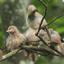

In [ ]:
jjj = list(test_dataset["finetuned_box"])[2]
jj = list(test_dataset["img_path"])[2]

image = Image.open(jj).convert("RGB")
image
# bbox = row['finetuned_box']

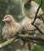

In [ ]:
if isinstance(jjj, str):
    bbox = ast.literal_eval(jjj)

if (bbox != 0) and (bbox != "0"):
    x_min, y_min, x_max, y_max = bbox
    image = image.crop((x_min, y_min, x_max, y_max))

image

In [ ]:
# 결과 저장
test_df["predicted_label"] = predict_labels

# 최종 CSV 저장
test_df.to_csv("/content/drive/MyDrive/2025-1 KUBIG/finetuning/test_predictions.csv", index=False)

In [ ]:
from google.colab import files

le.fit(master_df["label"])

# label 숫자만 추출 (LABEL_15 -> 15)
# predict_labels = [int(label.replace("LABEL_", "")) for label in predict_labels]

submission_df = pd.read_csv("/content/drive/MyDrive/2025-1 KUBIG/dataset/sample_submission.csv") # 경로 변경

submission_df["label"] = le.inverse_transform(predict_labels) # 숫자 -> 클래스로 변환

In [ ]:
submission_df.to_csv("/content/drive/MyDrive/2025-1 KUBIG/finetuning/submission.csv", index=False)
files.download("/content/drive/MyDrive/2025-1 KUBIG/finetuning/submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>